# FastText Embeddings Plus CNN-LSTM Architecture (Hashmi et al., 2024)

- Approach inspired by this research article: **Ehtesham Hashmi, Sule Yildirim Yayilgan, Muhammad Yamin, Subhan Ali, and Mohamed Abomhara. 2024. Advancing Fake News Detection: Hybrid Deep Learning With FastText and Explainable AI. IEEE Access 12 (2024), 44462–44480. https://doi.org/10.1109/ACCESS.2024.3381038**

## Environment Setup

In [1]:
# Imports the basic Python functionality libraries
import gc # To manage the memory usage
import os # For path construction
import re # Regex for preprocessing text to remove URLs, email addresses etc.
import random # For setting random seeds for reproducibility of results
# Imports the basic Python text and data processing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
# Tracks the progress of pandas text pre-processing using .progress_apply when applying a function to a column instead of .apply
tqdm.pandas()
# Imports NLTK for stopword removal, tokenization & lemmatization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Downloads the NLTK resources for text pre-processing
nltk.download("punkt") # Required for tokenization
nltk.download("stopwords") # Required for stopword removal
nltk.download("wordnet") # Required for lemmatization

# Imports the feature extraction libraries
from nrclex import NRCLex # For extracting emotion scores, such as positive emotion word frequency
import spacy # For extracting named entities, e.g. PERSON
import textstat # For extracting readability scores

# Imports model training libraries
import fasttext # Imports the fastText embeddings library
from sklearn.preprocessing import StandardScaler, MinMaxScaler # For scaling extra features, removes overly large values
from sklearn.model_selection import KFold # Imports KFold for automatic index-splitting for k-fold cross-validation for tuning the fastText model
# Imports evaluation functions
from sklearn.metrics import f1_score, classification_report, confusion_matrix # Import metrics for evaluation and cross-validation

# Imports visualization-related libraries
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn for plotting colorful confusion matrices

# Imports TensorFlow, Keras and Deep Learning functionality
import tensorflow as tf # Imports the general TensorFlow library
from tensorflow.keras.preprocessing.sequence import pad_sequences # For padding texts/sequences of word embeddings to all be same length
from tensorflow.keras.models import Model # For constructing the neural model
from tensorflow.keras.metrics import F1Score # TensorFlow's F1-score for monitoring performance progress when training
from tensorflow.keras.utils import to_categorical # For converting integer labels to one-hot encoded format for deep learning

# Imports the Keras Layers required to implement Hashmi et al.'s neural CNN-LSTM model, as well as concatenation functionality 
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, Dense, 
    Dropout, Flatten, Reshape, concatenate,
    MultiHeadAttention, # For extension: adding a multi-head attention layer to capture relationships between word features and extra ones
    Lambda
)
from tensorflow.keras.optimizers import Adam # Imports the Adam optimizer as recorded in Hashmi et al.'s paper
# Imports functionality for L1- and L2-regularization
from tensorflow.keras.regularizers import l1, l2
# Imports EarlyStopping callback to stop training when loss decrease plateaus
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /Users/ophelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ophelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Sets up the filepath where .csv files are saved
root_path = "../../FPData/BasicFeatureExtractionDFs/"

# Sets up file paths to full-scale datasets
# Sets up WELFake train, validation and test dataset paths
train_path_wf = os.path.join(root_path, "WELFake_train_basic_features.csv")
val_path_wf = os.path.join(root_path, "WELFake_val_basic_features.csv")
test_path_wf = os.path.join(root_path, "WELFake_test_basic_features.csv")
# Constraint
train_path_ct = os.path.join(root_path, "Constraint_train_basic_features.csv")
val_path_ct = os.path.join(root_path, "Constraint_val_basic_features.csv")
test_path_ct = os.path.join(root_path, "Constraint_test_basic_features.csv")
# Fakeddit
train_path_fe = os.path.join(root_path, "Fakeddit_train_basic_features.csv")
val_path_fe = os.path.join(root_path, "Fakeddit_val_basic_features.csv")
test_path_fe = os.path.join(root_path, "Fakeddit_test_basic_features.csv")
# PolitiFact
train_path_pf = os.path.join(root_path, "PolitiFact_train_basic_features.csv")
val_path_pf = os.path.join(root_path, "PolitiFact_val_basic_features.csv")
test_path_pf = os.path.join(root_path, "PolitiFact_test_basic_features.csv")
# GossipCop
train_path_gc = os.path.join(root_path, "GossipCop_train_basic_features.csv")
val_path_gc = os.path.join(root_path, "GossipCop_val_basic_features.csv")
test_path_gc = os.path.join(root_path, "GossipCop_test_basic_features.csv")
# All-Four Combined
train_path_all_four = os.path.join(root_path, "all_four_datasets_train_basic_features.csv")
val_path_all_four = os.path.join(root_path, "all_four_datasets_val_basic_features.csv")
test_path_all_four = os.path.join(root_path, "all_four_datasets_test_basic_features.csv")

# Sets up file paths to five-shot datasets
# Five-Shot: WELFake target
train_path_five_shot_wf_target = os.path.join(root_path, "Five_Shot_WELFake_Target_basic_features.csv")
# Five-Shot: Constraint target
train_path_five_shot_ct_target = os.path.join(root_path, "Five_Shot_Constraint_Target_basic_features.csv")
# Five-Shot: PolitiFact target
train_path_five_shot_pf_target = os.path.join(root_path, "Five_Shot_PolitiFact_Target_basic_features.csv")
# Five-Shot: GossipCop target
train_path_five_shot_gc_target = os.path.join(root_path, "Five_Shot_GossipCop_Target_basic_features.csv")


# Sets up file paths to zero-shot datasets
train_path_zero_shot_wf_target = os.path.join(root_path, "Zero_Shot_WELFake_Target_basic_features.csv")
# Zero-Shot: Constraint target
train_path_zero_shot_ct_target = os.path.join(root_path, "Zero_Shot_Constraint_Target_basic_features.csv")
# Zero-Shot: PolitiFact target
train_path_zero_shot_pf_target = os.path.join(root_path, "Zero_Shot_PolitiFact_Target_basic_features.csv")
# Zero-Shot: GossipCop target
train_path_zero_shot_gc_target = os.path.join(root_path, "Zero_Shot_GossipCop_Target_basic_features.csv")


# Loads in the full-scale datasets
# WELFake
wf_train_df = pd.read_csv(train_path_wf)
wf_val_df = pd.read_csv(val_path_wf)
wf_test_df = pd.read_csv(test_path_wf)
# Constraint
ct_train_df = pd.read_csv(train_path_ct)
ct_val_df = pd.read_csv(val_path_ct)
ct_test_df = pd.read_csv(test_path_ct)
# Fakeddit
fe_train_df = pd.read_csv(train_path_fe)
fe_val_df = pd.read_csv(val_path_fe)
fe_test_df = pd.read_csv(test_path_fe)
# PolitiFact
pf_train_df = pd.read_csv(train_path_pf)
pf_val_df = pd.read_csv(val_path_pf)
pf_test_df = pd.read_csv(test_path_pf)
# GossipCop
gc_train_df = pd.read_csv(train_path_gc)
gc_val_df = pd.read_csv(val_path_gc)
gc_test_df = pd.read_csv(test_path_gc)
# All-Four combined
all_four_train_df = pd.read_csv(train_path_all_four)
all_four_val_df = pd.read_csv(val_path_all_four)
all_four_test_df = pd.read_csv(test_path_all_four)

# Loads in the five-shot datasets
# Five-Shot: WELFake target training dataset
five_shot_wf_target_train_df = pd.read_csv(train_path_five_shot_wf_target)
# Five-Shot: Constraint target training dataset
five_shot_ct_target_train_df = pd.read_csv(train_path_five_shot_ct_target)
# Five-Shot: PolitiFact target training dataset
five_shot_pf_target_train_df = pd.read_csv(train_path_five_shot_pf_target)
# Five-Shot: GossipCop target training dataset
five_shot_gc_target_train_df = pd.read_csv(train_path_five_shot_gc_target)

# Loads in the zero-shot datasets
# Zero-Shot: WELFake target training dataset
zero_shot_wf_target_train_df = pd.read_csv(train_path_zero_shot_wf_target)
# Zero-Shot: Constraint target training dataset
zero_shot_ct_target_train_df = pd.read_csv(train_path_zero_shot_ct_target)
# Zero-Shot: PolitiFact target training dataset
zero_shot_pf_target_train_df = pd.read_csv(train_path_zero_shot_pf_target)
# Zero-Shot: GossipCop target training dataset
zero_shot_gc_target_train_df = pd.read_csv(train_path_zero_shot_gc_target)

## Text-Preprocessing Functions Defined for Pipeline Outlined in the Hashmi et al. (2024) Research Paper 

In [3]:
def preprocessTextForHashmiApproach(text):
    """
    Preprocesses a text in preparation for CNN-LSTM approach applied by Hashmi et al. (2024). Involves:
        lowercasing --> removing non-essential special characters + regular expressions matching URLs/emails/phone numbers/HTML tags
        --> word tokenization --> stopword removal --> lemmatization --> rejoining into a string
            
        Input Parameters:
            text (str): the text to clean
            
        Output:
            text (str): the cleaned text
    """

    # Initializes the set (more efficient than using a list) of NLTK stopwords and WordNet lemmatizer
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    # Converts the text to lowercase
    text = text.lower()

    # Filters the non-essential special characters and unwanted patterns (URLs, emails, phone numbers, HTML tags) as
    # detailed in Hashmi et al. (2024)
    text = re.sub(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>", 
                  '', text)  # Filters HTML tags. Reference: https://uibakery.io/regex-library/html-regex-python
    text = re.sub(r"^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$",
                  '', text)  # Filters URLs starting with http/https. Reference: https://uibakery.io/regex-library/url-regex-python
    text = re.sub(r"^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$",
                  '', text) # Filters URLs not starting with http/https. Reference: https://uibakery.io/regex-library/url-regex-python
    text = re.sub(r"^[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?$" ,
                  '', text)  # Filters email addresses, reference: https://uibakery.io/regex-library/email-regex-python
    text = re.sub("^\\+?[1-9][0-9]{7,14}$",
                  '', text)  # Filters phone numbers (basic 10-digit format). Reference: https://uibakery.io/regex-library/phone-number-python

    # Removes any punctuation (matches any non-word/space chars and replaces them)
    text = re.sub(r"[^\w\s]", '', text)
    
    # Matches any whitespaces that are more than a single space and normalizes them by replacing them with a single space,
    # FastText cannot handle any tab or newline characters, so this regular expression replaces them as well
    text = re.sub(r"\s+", ' ', text)
    
    # Tokenizes the text into words
    words = word_tokenize(text)

    # Filters stopwords
    words = [word for word in words if word not in stop_words]

    # Lemmatizes each word to its root (dictionary) form
    words = [lemmatizer.lemmatize(word) for word in words]

    # Rejoins the words back into a string
    cleaned_text = ' '.join(words)

    # Executes a final cleanup of any trailing extra spaces (fasttext cannot handle them)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

def removeEmptyRows(df, dataset_name, text_column_name="clean_text"):
    """
    Removes rows where the "text" column's value is empty or contains only whitespace.
    This could be the case after cleaning!
    
    Input Parameters:
        df (pandas.DataFrame): The DataFrame to clean.
        text_column_name (str): The column name containing the text data. The default is "text".
        
    Output:
        df (pandas.DataFrame): The cleaned dataframe with rows where "text" is empty removed.
    """
    # Prints the number of rows in dataset before and after removing empty-string text field rows
    print(f"\nRows in {dataset_name} before filtering empty text entries: {len(df)}")
    
    # Strips whitespace from text entry using the .str method and removes resulting empty strings
    df = df[df[text_column_name].str.strip() != ""]
    
    print(f"Rows in {dataset_name} after filtering empty text entries: {len(df)}\n")
    
    return df


def preprocessAndSaveDataFrame(df, dataset_name, root_path="../../FPData/BasicFeatureExtractionDFs"):
    """
        Preprocesses text column in a DataFrame using the preprocessing functions above into
        a new clean text column, and saves and returns the new DataFrame.

        Input Parameters:
        df (pandas.DataFrame): the pandas DataFrame to clean the text in
        dataset_name (str): the dataset's name/desc. for saving
        
        Output:
            df (pandas.DataFrame): the cleaned dataframe with rows where "text" is now preprocessed for extracting FastTextembeddings
    """
    # Creates a new column called "clean_text" and apply the function for preprocessng with tqdm progress bar
    df["clean_text"] = df["text"].progress_apply(preprocessTextForHashmiApproach)
    
    # Removes the empty rows for this dataset
    df = removeEmptyRows(df, dataset_name)
    
    # Saves this dataset as .csv file
    df.to_csv(os.path.join(root_path, f"{dataset_name}_preprocessed_for_hashmi.csv"))
    return df

In [22]:
# Applies the text pre-processing functions

# WELFake
wf_train_df = preprocessAndSaveDataFrame(wf_train_df, "wf_train")
wf_val_df = preprocessAndSaveDataFrame(wf_val_df, "wf_val")
wf_test_df = preprocessAndSaveDataFrame(wf_test_df, "wf_test")


00%|████████████████████████████████████| 41560/41560 [01:04<00:00, 646.82it/s]


Rows in wf_train before filtering empty text entries: 41560
Rows in wf_train after filtering empty text entries: 41559




00%|██████████████████████████████████████| 9325/9325 [00:14<00:00, 658.96it/s]


Rows in wf_val before filtering empty text entries: 9325
Rows in wf_val after filtering empty text entries: 9325




00%|████████████████████████████████████| 11237/11237 [00:17<00:00, 645.05it/s]


Rows in wf_test before filtering empty text entries: 11237
Rows in wf_test after filtering empty text entries: 11237



In [23]:
wf_check_sizes_msg = f"""Size of WELFake train data: {len(wf_train_df)}.
Size of WELFake validation data: {len(wf_val_df)}. Size of WELFake test data: {len(wf_test_df)}
"""
print(wf_check_sizes_msg)

Size of WELFake train data: 41559.
Size of WELFake validation data: 9325. Size of WELFake test data: 11237



In [25]:
# Constraint
ct_train_df = preprocessAndSaveDataFrame(ct_train_df, "ct_train")
ct_val_df = preprocessAndSaveDataFrame(ct_val_df, "ct_val")
ct_test_df = preprocessAndSaveDataFrame(ct_test_df, "ct_test")


00%|█████████████████████████████████████| 6376/6376 [00:00<00:00, 6643.51it/s]


Rows in ct_train before filtering empty text entries: 6376
Rows in ct_train after filtering empty text entries: 6376




00%|█████████████████████████████████████| 2128/2128 [00:00<00:00, 6688.06it/s]


Rows in ct_val before filtering empty text entries: 2128
Rows in ct_val after filtering empty text entries: 2128



100%|█████████████████████████████████████| 2122/2122 [00:00<00:00, 6554.90it/s]


Rows in ct_test before filtering empty text entries: 2122
Rows in ct_test after filtering empty text entries: 2122



In [26]:
ct_check_sizes_msg = f"""Size of Constraint train data: {len(ct_train_df)}.
Size of Constraint validation data: {len(ct_val_df)}. Size of Constraint test data: {len(ct_test_df)}
"""
print(ct_check_sizes_msg)

Size of Constraint train data: 6376.
Size of Constraint validation data: 2128. Size of Constraint test data: 2122



In [4]:
# Fakeddit
fe_train_df = preprocessAndSaveDataFrame(fe_train_df, "fe_train")
fe_val_df = preprocessAndSaveDataFrame(fe_val_df, "fe_val")
fe_test_df = preprocessAndSaveDataFrame(fe_test_df, "fe_test")


00%|████████████████████████████████| 648076/648076 [00:57<00:00, 11271.00it/s]


Rows in fe_train before filtering empty text entries: 648076
Rows in fe_train after filtering empty text entries: 647497




00%|██████████████████████████████████| 70332/70332 [00:06<00:00, 11328.12it/s]


Rows in fe_val before filtering empty text entries: 70332
Rows in fe_val after filtering empty text entries: 70239




00%|██████████████████████████████████| 71095/71095 [00:06<00:00, 11516.54it/s]


Rows in fe_test before filtering empty text entries: 71095
Rows in fe_test after filtering empty text entries: 71010



In [5]:
fe_check_sizes_msg = f"""Size of Fakeddit train data: {len(fe_train_df)}.
Size of Fakeddit validation data: {len(fe_val_df)}. Size of Fakeddit test data: {len(fe_test_df)}
"""
print(fe_check_sizes_msg)

Size of Fakeddit train data: 647497.
Size of Fakeddit validation data: 70239. Size of Fakeddit test data: 71010



In [29]:
# PolitiFact
pf_train_df = preprocessAndSaveDataFrame(pf_train_df, "pf_train")
pf_val_df = preprocessAndSaveDataFrame(pf_val_df, "pf_val")
pf_test_df = preprocessAndSaveDataFrame(pf_test_df, "pf_test")


00%|████████████████████████████████████████| 436/436 [00:01<00:00, 272.44it/s]


Rows in pf_train before filtering empty text entries: 436
Rows in pf_train after filtering empty text entries: 436




00%|████████████████████████████████████████| 104/104 [00:00<00:00, 284.59it/s]


Rows in pf_val before filtering empty text entries: 104
Rows in pf_val after filtering empty text entries: 104




00%|████████████████████████████████████████| 126/126 [00:00<00:00, 295.78it/s]


Rows in pf_test before filtering empty text entries: 126
Rows in pf_test after filtering empty text entries: 126



In [30]:
pf_check_sizes_msg = f"""Size of PolitiFact train data: {len(pf_train_df)}.
Size of PolitiFact validation data: {len(pf_val_df)}. Size of PolitiFact test data: {len(pf_test_df)}
"""
print(pf_check_sizes_msg)

Size of PolitiFact train data: 436.
Size of PolitiFact validation data: 104. Size of PolitiFact test data: 126



In [31]:
# GossipCop
gc_train_df = preprocessAndSaveDataFrame(gc_train_df, "gc_train")
gc_val_df = preprocessAndSaveDataFrame(gc_val_df, "gc_val")
gc_test_df = preprocessAndSaveDataFrame(gc_test_df, "gc_test")


00%|████████████████████████████████████| 11042/11042 [00:18<00:00, 585.87it/s]


Rows in gc_train before filtering empty text entries: 11042
Rows in gc_train after filtering empty text entries: 11042




00%|██████████████████████████████████████| 2630/2630 [00:04<00:00, 609.66it/s]


Rows in gc_val before filtering empty text entries: 2630
Rows in gc_val after filtering empty text entries: 2630




00%|██████████████████████████████████████| 3199/3199 [00:05<00:00, 616.07it/s]


Rows in gc_test before filtering empty text entries: 3199
Rows in gc_test after filtering empty text entries: 3199



In [32]:
gc_check_sizes_msg = f"""Size of GossipCop train data: {len(gc_train_df)}.
Size of GossipCop validation data: {len(gc_val_df)}. Size of GossipCop test data: {len(gc_test_df)}
"""
print(gc_check_sizes_msg)

Size of GossipCop train data: 11042.
Size of GossipCop validation data: 2630. Size of GossipCop test data: 3199



In [33]:
# All-Four Combined
all_four_train_df = preprocessAndSaveDataFrame(gc_train_df, "all_four_train")
all_four_val_df = preprocessAndSaveDataFrame(gc_val_df, "all_four_val")
all_four_test_df = preprocessAndSaveDataFrame(gc_test_df, "all_four_test")


00%|████████████████████████████████████| 11042/11042 [00:18<00:00, 589.93it/s]


Rows in all_four_train before filtering empty text entries: 11042
Rows in all_four_train after filtering empty text entries: 11042




00%|██████████████████████████████████████| 2630/2630 [00:04<00:00, 601.61it/s]


Rows in all_four_val before filtering empty text entries: 2630
Rows in all_four_val after filtering empty text entries: 2630




00%|██████████████████████████████████████| 3199/3199 [00:05<00:00, 621.70it/s]


Rows in all_four_test before filtering empty text entries: 3199
Rows in all_four_test after filtering empty text entries: 3199



In [37]:
# Five-Shot training data - WELFake target
five_shot_wf_target_train_df = preprocessAndSaveDataFrame(five_shot_wf_target_train_df, "five_shot_wf_target_train")
five_shot_wf_target_check_sizes_msg = f"""Size of Five-Shot: WELFake Target train data: {len(five_shot_wf_target_train_df)}"""
print(five_shot_wf_target_check_sizes_msg)


00%|████████████████████████████████████| 17857/17857 [00:21<00:00, 839.34it/s]


Rows in five_shot_wf_target_train before filtering empty text entries: 17857
Rows in five_shot_wf_target_train after filtering empty text entries: 17857

Size of Five-Shot: WELFake Target train data: 17857


In [38]:
# Five-Shot training data - Constraint target
five_shot_ct_target_train_df = preprocessAndSaveDataFrame(five_shot_ct_target_train_df, "five_shot_ct_target_train")
five_shot_ct_target_check_sizes_msg = f"""Size of Five-Shot: Constraint Target train data: {len(five_shot_ct_target_train_df)}"""
print(five_shot_ct_target_check_sizes_msg)


00%|████████████████████████████████████| 53041/53041 [01:24<00:00, 624.99it/s]


Rows in five_shot_ct_target_train before filtering empty text entries: 53041
Rows in five_shot_ct_target_train after filtering empty text entries: 53040

Size of Five-Shot: Constraint Target train data: 53040


In [39]:
# Five-Shot training data - PolitiFact target
five_shot_pf_target_train_df = preprocessAndSaveDataFrame(five_shot_pf_target_train_df, "five_shot_pf_target_train")
five_shot_pf_target_check_sizes_msg = f"""Size of Five-Shot: PolitiFact Target train data: {len(five_shot_pf_target_train_df)}"""
print(five_shot_pf_target_check_sizes_msg)


00%|████████████████████████████████████| 58983/58983 [01:24<00:00, 701.56it/s]


Rows in five_shot_pf_target_train before filtering empty text entries: 58983
Rows in five_shot_pf_target_train after filtering empty text entries: 58982

Size of Five-Shot: PolitiFact Target train data: 58982


In [40]:
# Five-Shot training data - GossipCop target
five_shot_gc_target_train_df = preprocessAndSaveDataFrame(five_shot_gc_target_train_df, "five_shot_gc_target_train")
five_shot_gc_target_check_sizes_msg = f"""Size of Five-Shot: GossipCop Target train data: {len(five_shot_gc_target_train_df)}"""
print(five_shot_gc_target_check_sizes_msg)


00%|████████████████████████████████████| 48377/48377 [01:06<00:00, 725.10it/s]


Rows in five_shot_gc_target_train before filtering empty text entries: 48377
Rows in five_shot_gc_target_train after filtering empty text entries: 48376

Size of Five-Shot: GossipCop Target train data: 48376


In [41]:
# Zero-Shot training data - WELFake target
zero_shot_wf_target_train_df = preprocessAndSaveDataFrame(zero_shot_wf_target_train_df, "zero_shot_wf_target_train")
zero_shot_wf_target_check_sizes_msg = f"""Size of Zero-Shot: WELFake Target train data: {len(zero_shot_wf_target_train_df)}"""
print(zero_shot_wf_target_check_sizes_msg)


00%|████████████████████████████████████| 17852/17852 [00:21<00:00, 839.03it/s]


Rows in zero_shot_wf_target_train before filtering empty text entries: 17852
Rows in zero_shot_wf_target_train after filtering empty text entries: 17852

Size of Zero-Shot: WELFake Target train data: 17852


In [42]:
# Zero-Shot training data - Constraint target
zero_shot_ct_target_train_df = preprocessAndSaveDataFrame(zero_shot_ct_target_train_df, "zero_shot_ct_target_train")
zero_shot_ct_target_check_sizes_msg = f"""Size of Zero-Shot: Constraint Target train data: {len(zero_shot_ct_target_train_df)}"""
print(zero_shot_ct_target_check_sizes_msg)


00%|████████████████████████████████████| 53036/53036 [01:24<00:00, 626.08it/s]


Rows in zero_shot_ct_target_train before filtering empty text entries: 53036
Rows in zero_shot_ct_target_train after filtering empty text entries: 53035

Size of Zero-Shot: Constraint Target train data: 53035


In [43]:
# Zero-Shot training data - PolitiFact target
zero_shot_pf_target_train_df = preprocessAndSaveDataFrame(zero_shot_pf_target_train_df, "zero_shot_pf_target_train")
zero_shot_pf_target_check_sizes_msg = f"""Size of Zero-Shot: PolitiFact Target train data: {len(zero_shot_pf_target_train_df)}"""
print(zero_shot_pf_target_check_sizes_msg)


00%|████████████████████████████████████| 58978/58978 [01:23<00:00, 702.62it/s]


Rows in zero_shot_pf_target_train before filtering empty text entries: 58978
Rows in zero_shot_pf_target_train after filtering empty text entries: 58977

Size of Zero-Shot: PolitiFact Target train data: 58977


In [44]:
# Zero-Shot training data - GossipCop target
zero_shot_gc_target_train_df = preprocessAndSaveDataFrame(zero_shot_gc_target_train_df, "zero_shot_gc_target_train")
zero_shot_gc_target_check_sizes_msg = f"""Size of Zero-Shot: GossipCop Target train data: {len(zero_shot_gc_target_train_df)}"""
print(zero_shot_gc_target_check_sizes_msg)


00%|████████████████████████████████████| 48372/48372 [01:03<00:00, 758.50it/s]


Rows in zero_shot_gc_target_train before filtering empty text entries: 48372
Rows in zero_shot_gc_target_train after filtering empty text entries: 48371

Size of Zero-Shot: GossipCop Target train data: 48371


## Loading Back in the Processed DataFrames

In [6]:
main_root_path = "../../FPData/BasicFeatureExtractionDFs"

In [6]:
# WELFake
wf_train_df = pd.read_csv(os.path.join(main_root_path, "wf_train_preprocessed_for_hashmi.csv"))
wf_val_df = pd.read_csv(os.path.join(main_root_path, "wf_val_preprocessed_for_hashmi.csv"))
wf_test_df = pd.read_csv(os.path.join(main_root_path, "wf_test_preprocessed_for_hashmi.csv"))

# Fakeddit
fe_train_df = pd.read_csv(os.path.join(main_root_path, "fe_train_preprocessed_for_hashmi.csv"))
fe_val_df = pd.read_csv(os.path.join(main_root_path, "fe_val_preprocessed_for_hashmi.csv"))
fe_test_df = pd.read_csv(os.path.join(main_root_path, "fe_test_preprocessed_for_hashmi.csv"))

# Constraint
ct_train_df = pd.read_csv(os.path.join(main_root_path, "ct_train_preprocessed_for_hashmi.csv"))
ct_val_df = pd.read_csv(os.path.join(main_root_path, "ct_val_preprocessed_for_hashmi.csv"))
ct_test_df = pd.read_csv(os.path.join(main_root_path, "ct_test_preprocessed_for_hashmi.csv"))

# PolitiFact
pf_train_df = pd.read_csv(os.path.join(main_root_path, "pf_train_preprocessed_for_hashmi.csv"))
pf_val_df = pd.read_csv(os.path.join(main_root_path, "pf_val_preprocessed_for_hashmi.csv"))
pf_test_df = pd.read_csv(os.path.join(main_root_path, "pf_test_preprocessed_for_hashmi.csv"))

# GossipCop
gc_train_df = pd.read_csv(os.path.join(main_root_path, "gc_train_preprocessed_for_hashmi.csv"))
gc_val_df = pd.read_csv(os.path.join(main_root_path, "gc_val_preprocessed_for_hashmi.csv"))
gc_test_df = pd.read_csv(os.path.join(main_root_path, "gc_test_preprocessed_for_hashmi.csv"))

# All-Four Combined
all_four_train_df = pd.read_csv(os.path.join(main_root_path, "all_four_train_preprocessed_for_hashmi.csv"))
all_four_val_df = pd.read_csv(os.path.join(main_root_path, "all_four_val_preprocessed_for_hashmi.csv"))
all_four_test_df = pd.read_csv(os.path.join(main_root_path, "all_four_test_preprocessed_for_hashmi.csv"))

# Five-Shot: WELFake target training dataset
five_shot_wf_target_train_df = pd.read_csv(os.path.join(main_root_path, "five_shot_wf_target_train_preprocessed_for_hashmi.csv"))

# Five-Shot: Constraint target training dataset
five_shot_ct_target_train_df = pd.read_csv(os.path.join(main_root_path, "five_shot_ct_target_train_preprocessed_for_hashmi.csv"))

# Five-Shot: PolitiFact target training dataset
five_shot_pf_target_train_df = pd.read_csv(os.path.join(main_root_path, "five_shot_pf_target_train_preprocessed_for_hashmi.csv"))

# Five-Shot: GossipCop target training dataset
five_shot_gc_target_train_df = pd.read_csv(os.path.join(main_root_path, "five_shot_gc_target_train_preprocessed_for_hashmi.csv"))

# Zero-Shot: WELFake target training dataset
zero_shot_wf_target_train_df = pd.read_csv(os.path.join(main_root_path, "zero_shot_wf_target_train_preprocessed_for_hashmi.csv"))

# Zero-Shot: Constraint target training dataset
zero_shot_ct_target_train_df = pd.read_csv(os.path.join(main_root_path, "zero_shot_ct_target_train_preprocessed_for_hashmi.csv"))

# Zero-Shot: PolitiFact target training dataset
zero_shot_pf_target_train_df = pd.read_csv(os.path.join(main_root_path, "zero_shot_pf_target_train_preprocessed_for_hashmi.csv"))

# Zero-Shot: GossipCop target training dataset
zero_shot_gc_target_train_df = pd.read_csv(os.path.join(main_root_path, "zero_shot_gc_target_train_preprocessed_for_hashmi.csv"))

## Training fastText Models (Full-Scale Scenario)

For the purposes of generalization, for five-shot and zero-shot evaluation settings, a pre-trained fastText model (on Wikipedia and Common Crawl) will be used instead of training a model on the training data itself. This is to encourage generalization to **unseen data** rather than learning patterns inherent in existing, different domain training data.

In [7]:
def prepareDataForFastText(df, output_file, text_column_name="clean_text", label_column_name="label"):
    """
    
    This function converts a training dataset with text and label columns into fastText format for training the FastText model, i.e.
    "__label__ <text>". Reference for the correct format : https://fasttext.cc/docs/en/supervised-tutorial.html
    "All the labels start by the __label__ prefix, which is how fastText recognize what is a label or what is a word."
        
        Input Parameters:
            df (pd.DataFrame): a training dataset for training a fastText model with a text ("clean_text") and label column
            output_file (str): .txt filename to save the fastText training data to in the "__label__ <text>" format per line
            text_col_name (str): name of the text column in the training DataFrame, default is "clean_text"
            label_col_name (str): name of the label column (news category, 0 = real, 1 = fake news)
                                in the training DataFrame, default is "label"
            
        Output:
            output_file (str): name of the output text fastText format file being created
    """
    
    # Opens a text file with the inputted filename for write access
    with open(output_file, 'w') as f:
        # Iterates over the texts and labels in the training DataFrame and writes them in the fastText format to the text file,
        # line by line
        for text, label in zip(df[text_column_name], df[label_column_name]): # Zip up the texts and labels and iterate over them
            # Converts into format: __label__<label> <text>
            f.write(f'__label__{label} {text}\n')
    # Returns the name of output text file for easy function chaining if necessary
    return output_file



def trainFastTextModel(
    train_file,
    save_path,
    num_folds=5,
    autotune_duration=300, # Set tuning length to 5 minutes for each kˆth fold
    force_dimensions=None
):
    """
    Trains a supervised FastText model with k-fold cross-validation, using scikit-learn's KFold to generate folds, and the built-in
    fastText "autotune" functionality, selecting the best model based on F1-score.

        Input Parameters:
            train_file (str): the .txt filename containing the FastText-formatted "__label__ <text>" data
            save_path (str): the filepath string to save the best model to (it should end in .bin)
            num_folds (int): the number of folds for K-fold cross-validation. Default is 5
            autotune_duration (int): the time in seconds for fastText autotune to run per fold, default is 300 seconds = 5 minutes
            force_dimensions (None | int): if None, the fastText autotune learns best embedding dimension size itself, if int
                                            then use this dimension size. This stops certain datasets having an autotuned embedding
                                            dimension of size 1 (which was the case of the PolitiFact dataset).

        Output:
            best_model (fasttext.FastText._FastText): the trained FastText model with the best validation folds' F1-score
    """
    
    # Reads in the dataset formatted as __label__<label> <text> in read mode
    with open(train_file, 'r') as f:
        data = f.readlines()
    
    # Sets up the k-fold cross-validation using inbuilt KFold from scikit-learn. Uses random_state = 5 for reproducibility of results
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=5)
    best_model = None # Keeps track of the best fastText model so far
    best_f1 = 0 # Keeps track of best F1-score so far
    
    # Now performs cross-validation: start enumerating each fold from 1 instead of 0 for readability when printing out progress
    for fold, (train_idx, val_idx) in enumerate(kf.split(data), 1): # Split data into train and validation indices

        # Prints which fold is being trained and evaluated
        print(f"Training fold {fold}/{num_folds}...")
        
        # Splits the data into training and validation sets based on indices generated using KFold 
        train_data = [data[i] for i in train_idx]
        val_data = [data[i] for i in val_idx]
        
        # Saves the train and validation sets temporarily as .txt files
        train_file_temp = "temp_train.txt"
        val_file_temp = "temp_val.txt"

        # Save the temporary training and validation files
        with open(train_file_temp, 'w') as train_f:
            train_f.writelines(train_data)
            
        with open(val_file_temp, 'w') as val_f:
            val_f.writelines(val_data)

        if force_dimensions: # Force embeddings to be of a certain dimension
            # Trains the FastText model with built-in autotune option
            # Reference: https://fasttext.cc/docs/en/autotune.html
            model = fasttext.train_supervised(
                input=train_file_temp, # Input the temporary training data file for this split
                dim=force_dimensions, 
                autotuneValidationFile=val_file_temp, # Input the temporary validation data file for this split
                autotuneDuration=autotune_duration, # Default is 5 minutes
                
            )
        else: # Else, learn best dimension size using autotune
             model = fasttext.train_supervised(
                input=train_file_temp, # Input the temporary training data file for this split
                autotuneValidationFile=val_file_temp, # Input the temporary validation data file for this split
                autotuneDuration=autotune_duration, # Default is 5 minutes      
            )
        
        # Now evaluate this fold's model on the validation set...
        # Extract the labels from the .txt validation file: split format __label__<label> <text> on space and get first part for label
        # Replace the __label__ bit with an empty string to extract only the integer label
        y_true = [line.split()[0].replace("__label__", '') for line in val_data]
        # For each news sample in the read-in val_data, generate prediction using the trained model for this fold
        # 1. Splits the "__label__<label> <text>" row on a space character only once on the first instance
        # 2. Extracts the <text> content at index 1 of the split text, which is now a list
        # 3. Strips the text of any whitespace by calling strip()
        # 4. Gets the actual output (highest probability class, either 0 or 1) of the prediction by accessing the nested fastText 
        # output [0][0] to get the first prediction/class with the highest probability using the fastText convention
        # 5. Replaces the "__label__" part of the most highly predicted class with an empty string to get only the integer predicgtion
        y_pred = [model.predict(line.split(' ', 1)[1].strip())[0][0].replace("__label__", '') for line in val_data]

        # Calculates the F1-score on this fold's validation set ground truth and predicted labels
        f1 = f1_score(y_true, y_pred, average="macro")  # Compute macro F1-scores as minority (fake) class is equally important

        # Prints the F1-score for this test-validation fold
        print(f"Fold {fold}: Validation F1-score = {f1:.4f}")
        
        # Updates the value of the best model placeholder and score if and only if this fold is better in terms of F1-score
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
        
        # Clears the memory used by the current model to not crash the kernel using del and Python's garbage collection
        del model
        gc.collect()  # Use Python garbage collection for this
    
    # Saves the best model to the path inputted as an argument to the function
    if best_model:
        best_model.save_model(save_path)
        print(f"Best model saved with F1-score {best_f1:.4f} at {save_path}!!!")
    
    return best_model

### Convert Full-Scale Datasets into fastText Format

In [8]:
# Set up filepath of where to save fastText data (.txt) file and .bin model file
fasttext_root_path = "../../FPData/FastText/"

In [9]:
# WELFake
wf_text_filepath = os.path.join(fasttext_root_path, "welfake_fasttext_hashmi_train.txt")
prepareDataForFastText(wf_train_df, wf_text_filepath)

# Fakeddit
fe_text_filepath = os.path.join(fasttext_root_path, "fakeddit_fasttext_hashmi_train.txt")
prepareDataForFastText(fe_train_df, fe_text_filepath)

# Constraint
ct_text_filepath = os.path.join(fasttext_root_path, "constraint_fasttext_hashmi_train.txt")
prepareDataForFastText(ct_train_df, ct_text_filepath)

# PolitiFact
pf_text_filepath = os.path.join(fasttext_root_path, "politifact_fasttext_hashmi_train.txt")
prepareDataForFastText(pf_train_df, pf_text_filepath)

# GossipCop
gc_text_filepath = os.path.join(fasttext_root_path, "gossipcop_fasttext_hashmi_train.txt")
prepareDataForFastText(gc_train_df, gc_text_filepath)

# All-Four Combinde
all_four_text_filepath = os.path.join(fasttext_root_path, "all_four_fasttext_hashmi_train.txt")
prepareDataForFastText(all_four_train_df, all_four_text_filepath)

### Train Supervised fastText Models for Full-Scale Scenarios

In [52]:
# WELFake
wf_model_filepath = os.path.join(fasttext_root_path, "welfake_fasttext_hashmi_model.bin")
wf_hashmi_model = trainFastTextModel(wf_text_filepath, wf_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   31 Best score:  0.960178 ETA:   0h 0m 0s
Training again with best arguments
Read 10M words
Number of words:  217573
Number of labels: 2
Progress: 100.0% words/sec/thread:  847122 lr:  0.000000 avg.loss:  0.095057 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.9595
Training fold 2/5...


Progress: 100.0% Trials:   31 Best score:  0.959336 ETA:   0h 0m 0s
Training again with best arguments
Read 10M words
Number of words:  216754
Number of labels: 2
Progress: 100.0% words/sec/thread: 1050423 lr:  0.000000 avg.loss:  0.066245 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.9591
Training fold 3/5...


Progress: 100.0% Trials:   12 Best score:  0.961381 ETA:   0h 0m 0s
Training again with best arguments
Read 10M words
Number of words:  216614
Number of labels: 2
Progress: 100.0% words/sec/thread: 1618943 lr:  0.000000 avg.loss:  0.069666 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.9612
Training fold 4/5...


Progress: 100.0% Trials:   38 Best score:  0.958975 ETA:   0h 0m 0s
Training again with best arguments
Read 10M words
Number of words:  216104
Number of labels: 2
Progress: 100.0% words/sec/thread: 1241200 lr:  0.000000 avg.loss:  0.103863 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.9596
Training fold 5/5...


Progress: 100.0% Trials:   63 Best score:  0.958248 ETA:   0h 0m 0s
Training again with best arguments
Read 10M words
Number of words:  218504
Number of labels: 2
Progress: 100.0% words/sec/thread: 3354761 lr:  0.000000 avg.loss:  0.080966 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.9581
Best model saved with F1-score 0.9612 at ../../FPData/FastText/welfake_fasttext_hashmi_model.bin!!!


In [10]:
# Fakeddit
fe_model_filepath = os.path.join(fasttext_root_path, "fakeddit_fasttext_hashmi_model.bin")
fe_hashmi_model = trainFastTextModel(fe_text_filepath, fe_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:   62 Best score:  0.849830 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  117960
Number of labels: 2
Progress: 100.0% words/sec/thread: 1597624 lr:  0.000000 avg.loss:  0.223844 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.8468
Training fold 2/5...


Progress: 100.0% Trials:   63 Best score:  0.850000 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  117470
Number of labels: 2
Progress: 100.0% words/sec/thread: 1629189 lr:  0.000000 avg.loss:  0.225656 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.8476
Training fold 3/5...


Progress: 100.0% Trials:   63 Best score:  0.848740 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  117753
Number of labels: 2
Progress: 100.0% words/sec/thread: 1071211 lr:  0.000000 avg.loss:  0.347684 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.8454
Training fold 4/5...


Progress: 100.0% Trials:   72 Best score:  0.849736 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  117724
Number of labels: 2
Progress: 100.0% words/sec/thread: 2849182 lr:  0.000000 avg.loss:  0.210707 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.8475
Training fold 5/5...


Progress: 100.0% Trials:   63 Best score:  0.849481 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  117636
Number of labels: 2
Progress: 100.0% words/sec/thread: 1600899 lr:  0.000000 avg.loss:  0.229880 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.8461
Best model saved with F1-score 0.8476 at ../../FPData/FastText/fakeddit_fasttext_hashmi_model.bin!!!


In [6]:
# Constraint
ct_model_filepath = os.path.join(fasttext_root_path, "constraint_fasttext_hashmi_model.bin")
ct_hashmi_model = trainFastTextModel(ct_text_filepath, ct_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:  839 Best score:  0.953762 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  16391
Number of labels: 2
Progress: 100.0% words/sec/thread: 1095920 lr:  0.000000 avg.loss:  0.005314 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.9503
Training fold 2/5...


Progress: 100.0% Trials:  312 Best score:  0.943529 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  16398
Number of labels: 2
Progress: 100.0% words/sec/thread:  364272 lr:  0.000000 avg.loss:  0.005384 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.9307
Training fold 3/5...


Progress: 100.0% Trials:  667 Best score:  0.947451 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  16525
Number of labels: 2
Progress: 100.0% words/sec/thread: 1450070 lr:  0.000000 avg.loss:  0.047970 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.9473
Training fold 4/5...


Progress: 100.0% Trials:  699 Best score:  0.944314 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  16442
Number of labels: 2
Progress: 100.0% words/sec/thread: 1230052 lr:  0.000000 avg.loss:  0.004433 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.9380
Training fold 5/5...



Training again with best arguments
Read 0M words06 ETA:   0h 0m 0s
Number of words:  16660
Number of labels: 2
Progress: 100.0% words/sec/thread:   26527 lr:  0.000000 avg.loss:  0.033273 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.9206
Best model saved with F1-score 0.9503 at ../../FPData/FastText/constraint_fasttext_hashmi_model.bin!!!


In [8]:
# PolitiFact
pf_model_filepath = os.path.join(fasttext_root_path, "politifact_fasttext_hashmi_model.bin")
pf_hashmi_model = trainFastTextModel(pf_text_filepath, pf_model_filepath) # Make embeddings size 50 for this dataset

Training fold 1/5...


Progress: 100.0% Trials:  393 Best score:  0.886364 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  18627
Number of labels: 2
Progress: 100.0% words/sec/thread: 2309140 lr:  0.000000 avg.loss:  0.293775 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.8713
Training fold 2/5...


Progress: 100.0% Trials:  349 Best score:  0.896552 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  19019
Number of labels: 2
Progress: 100.0% words/sec/thread: 1179745 lr:  0.000000 avg.loss:  0.175950 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.8849
Training fold 3/5...


Progress: 100.0% Trials:   70 Best score:  0.896552 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  18868
Number of labels: 2
Progress: 100.0% words/sec/thread:  247190 lr:  0.000000 avg.loss:  0.085500 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.8843
Training fold 4/5...


Progress: 100.0% Trials:  381 Best score:  0.885057 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  18198
Number of labels: 2
Progress: 100.0% words/sec/thread: 1838203 lr:  0.000000 avg.loss:  0.057304 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.8616
Training fold 5/5...


Progress: 100.0% Trials:  306 Best score:  0.850575 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  19221
Number of labels: 2
Progress: 100.0% words/sec/thread: 6848482 lr:  0.000000 avg.loss:  0.120198 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.8506
Best model saved with F1-score 0.8849 at ../../FPData/FastText/politifact_fasttext_hashmi_model.bin!!!


In [9]:
# GossipCop
gc_model_filepath = os.path.join(fasttext_root_path, "gossipcop_fasttext_hashmi_model.bin")
gc_hashmi_model = trainFastTextModel(gc_text_filepath, gc_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:  181 Best score:  0.873246 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  121752
Number of labels: 2
Progress: 100.0% words/sec/thread: 13870905 lr:  0.000000 avg.loss:  0.332366 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.7822
Training fold 2/5...


Progress: 100.0% Trials:   41 Best score:  0.865550 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  119161
Number of labels: 2
Progress: 100.0% words/sec/thread:  639695 lr:  0.000000 avg.loss:  0.279950 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.7748
Training fold 3/5...


Progress: 100.0% Trials:   99 Best score:  0.855072 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  120321
Number of labels: 2
Progress: 100.0% words/sec/thread: 5728491 lr:  0.000000 avg.loss:  0.334504 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.7661
Training fold 4/5...


Progress: 100.0% Trials:   95 Best score:  0.851449 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  119279
Number of labels: 2
Progress: 100.0% words/sec/thread: 1520667 lr:  0.000000 avg.loss:  0.381381 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.7691
Training fold 5/5...


Progress: 100.0% Trials:   43 Best score:  0.856431 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  123639
Number of labels: 2
Progress: 100.0% words/sec/thread:  701441 lr:  0.000000 avg.loss:  0.285840 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.7716
Best model saved with F1-score 0.7822 at ../../FPData/FastText/gossipcop_fasttext_hashmi_model.bin!!!


In [8]:
# All-Four Combined
all_four_model_filepath = os.path.join(fasttext_root_path, "all_four_fasttext_hashmi_model.bin")
all_four_hashmi_model = trainFastTextModel(all_four_text_filepath, all_four_model_filepath)

Training fold 1/5...


Progress: 100.0% Trials:  234 Best score:  0.872340 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  121752
Number of labels: 2
Progress: 100.0% words/sec/thread: 6629970 lr:  0.000000 avg.loss:  0.179889 ETA:   0h 0m 0s


Fold 1: Validation F1-score = 0.7817
Training fold 2/5...


Progress: 100.0% Trials:  112 Best score:  0.866003 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  119161
Number of labels: 2
Progress: 100.0% words/sec/thread: 5745114 lr:  0.000000 avg.loss:  0.075691 ETA:   0h 0m 0s


Fold 2: Validation F1-score = 0.7787
Training fold 3/5...


Progress: 100.0% Trials:   59 Best score:  0.857337 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  120321
Number of labels: 2
Progress: 100.0% words/sec/thread:  996304 lr:  0.000000 avg.loss:  0.248665 ETA:   0h 0m 0s


Fold 3: Validation F1-score = 0.7707
Training fold 4/5...


Progress: 100.0% Trials:   95 Best score:  0.852355 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  119279
Number of labels: 2
Progress: 100.0% words/sec/thread:  919854 lr:  0.000000 avg.loss:  0.331862 ETA:   0h 0m 0s


Fold 4: Validation F1-score = 0.7760
Training fold 5/5...


Progress: 100.0% Trials:   99 Best score:  0.857337 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  123639
Number of labels: 2
Progress: 100.0% words/sec/thread: 1559095 lr:  0.000000 avg.loss:  0.232301 ETA:   0h 0m 0s


Fold 5: Validation F1-score = 0.7716
Best model saved with F1-score 0.7817 at ../../FPData/FastText/all_four_fasttext_hashmi_model.bin!!!


In [3]:
# Loads the models back in!
fasttext_root_path = "../../FPData/FastText/"

In [6]:
# WELFake
wf_model = fasttext.load_model(os.path.join(fasttext_root_path, "welfake_fasttext_hashmi_model.bin"))

In [17]:
# Fakeddit
fe_model = fasttext.load_model(os.path.join(fasttext_root_path, "fakeddit_fasttext_hashmi_model.bin"))

In [4]:
# Constraint
ct_model = fasttext.load_model(os.path.join(fasttext_root_path, "constraint_fasttext_hashmi_model.bin"))

In [64]:
# PolitiFact
pf_model = fasttext.load_model(os.path.join(fasttext_root_path, "politifact_fasttext_hashmi_model.bin"))

In [65]:
# GossipCop
gc_model = fasttext.load_model(os.path.join(fasttext_root_path, "gossipcop_fasttext_hashmi_model.bin"))

In [9]:
# All-Four Combined
all_four_model = fasttext.load_model(os.path.join(fasttext_root_path, "all_four_fasttext_hashmi_model.bin"))

In [6]:
# Loads the pre-trained CommonCrawl fastText 100-size embedding model for the five-shot and zero-shot scenarios
pretrained_model = fasttext.load_model("cc.en.100.bin")

## Calculating How Long The Text Sequences Should Be by Plotting Text Length Distribution (by Word Tokens in Text)

- For training a CNN-LSTM model using fastText embeddings, each word in every news text has to be encoded as a dense embedding using the fastText model tuned and trained above. One cannot simply average the word embeddings for a text to return a single mean embedding as with the PassiveAggressiveClassifier before, as a **LSTM** model performs best on **sequential** data to capture relationships based on word order.

- However, some text lengths are extremely long (e.g. 10,000 word tokens), which is infeasible computationally and slows down model performance. Therefore, it is necessary to truncate and cap the total embedding length to a number that is reasonable for this dataset, to avoid overly long inputs. Texts shorter than this value will be padded with 0s to make all the texs the same length for deep learning. The longer texts will be truncated to this word-token length, at the risk of some information loss, but this is something that has to be balanced with time and computational complexity requirements.

- The following functions and visualizations showing distribution of text lengths for the training datasets will assist in choosing the maximum length of word tokens (dense embeddings) to allow for representing each input. This will help with training the CNN-LSTM which requires all texts (embedding sequences) to be of the same length.

In [6]:
def getMeanTextLength(train_df):
    """
    Calculates the mean length of the texts in a (training) news DataFrame by number of word tokens.

        Input Parameters:
            train_df (pd.DataFrame): training news dataset with "clean_text" column

        Output:
            mean_length (float): mean number of word tokens in the "clean_text" column in the DataFrame
    """
    # Calculates the length of each text in number of word tokens
    text_lengths = train_df["clean_text"].progress_apply(lambda x: len(word_tokenize(x)))

    # Gets the mean text length (in word tokens)
    mean_length = text_lengths.mean()

    return mean_length


def getMaxTextLength(train_df):

    """
    Calculates the longest text length in a (training) news DataFrame by number of word tokens.

        Input Parameters:
            train_df (pd.DataFrame): training news dataset with "clean_text" column
    
        Output:
            mean_length (float): mean number of word tokens in the "clean_text" column in the DataFrame
            text_lengths (list): list of each text's length in word tokens, for plotting a graph showing text length distribution
    """
    
    # Calculates the length of each text in number of word tokens
    text_lengths = train_df["clean_text"].progress_apply(lambda x: len(word_tokenize(x)))

    # Convert text_lengths from a pandas Series to list for easier plotting of length istributions
    text_lengths = text_lengths.to_list()
    
    # Calculates the max text length (in word tokens)
    max_length = max(text_lengths)
    
    return max_length, text_lengths


def plotDistributionOfTextLengthsAsHistogram(text_lengths, bin_size, offset, dataset_name, rotation_value=90):
    """
    Plots the distribution of the text lengths as a histogram.
    # Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

        Input Parameters:
            text_length (list): a list of int (lengths of texts in word tokens) for a dataset
            bin_size (int): the number of lenghts in each histogram bin to plot (depends on the dataset)
            offset (int): the number to overlap on the histogram x-axis by to include all the bins in the clearest way with no cut-off bins
            dataset_name (str): a dataset name for title
            rotation_value (int, 90): the angle to rotate the x-labels (text lengths) by
    """
    plt.hist(
        text_lengths,
        # Defines the bin edges to range from length 0 to the maximum length + offset, in steps of bin_size
        bins=range(0, max(text_lengths) + offset, bin_size), 
        edgecolor="black")  # Outlines the blue bars in black for easier readability
    
    # Adds the labels and title to the historgram
    plt.xlabel("Text Length (in words)")
    plt.ylabel("Number of Texts")
    plt.title(f"Distribution of Text Lengths for {dataset_name} training data")
    
    # Shows the x-axis labels with actual lengths, ensuring they don't overlap by rotating them by 90 degrees
    plt.xticks(range(0, max(text_lengths) + offset, bin_size), rotation=rotation_value)
    
    # Displays the plot
    plt.show()

### WELFake


00%|███████████████████████████████████| 41559/41559 [00:17<00:00, 2330.99it/s]

WELFake train - mean length of word tokens in texts: 313.74571091700955



00%|███████████████████████████████████| 41559/41559 [00:17<00:00, 2342.80it/s]

Maximum length of word tokens in texts: 10775


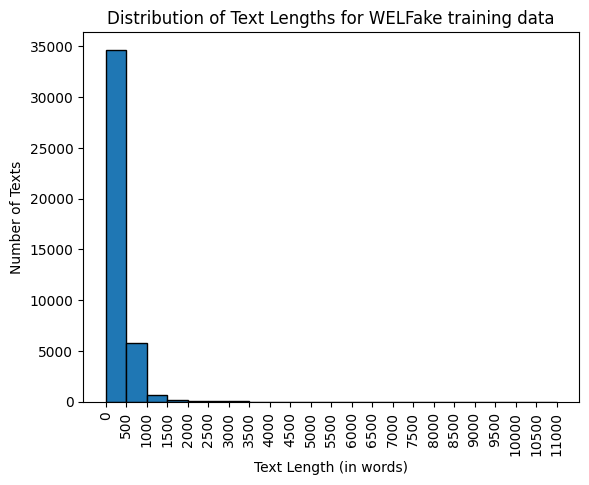

In [13]:
# WELFake

# Calculates the mean text length (in word tokens)
wf_mean_length = getMeanTextLength(wf_train_df)
print(f"WELFake train - mean length of word tokens in texts: {wf_mean_length}")

# Returns the text-lengths list and max text length in word tokens
wf_max_length, wf_text_lengths = getMaxTextLength(wf_train_df)
print(f"Maximum length of word tokens in texts: {wf_max_length}")

# Plots the WELFake text length distribution
plotDistributionOfTextLengthsAsHistogram(wf_text_lengths, 500, 500, "WELFake", rotation_value=90)

For WELFake trainng data, most of the texts are under 1000 word-tokens long. Therefore, the maximum sequence length will be capped to this value to reach a trade-off between memory efficiency and the model's performance.

### Fakeddit

In [23]:
# Drop NaN rows as they were causing a big problem with calculating text lengths and for deep learning models
fe_train_df = fe_train_df.dropna(subset=["clean_text"])
fe_val_df = fe_val_df.dropna(subset=["clean_text"])
fe_test_df = fe_test_df.dropna(subset=["clean_text"])

# Save again
fe_train_df.to_csv(os.path.join(main_root_path, "fe_train_preprocessed_for_hashmi.csv"))
fe_val_df.to_csv(os.path.join(main_root_path, "fe_val_preprocessed_for_hashmi.csv"))
fe_test_df.to_csv(os.path.join(main_root_path, "fe_test_preprocessed_for_hashmi.csv"))


00%|████████████████████████████████| 647496/647496 [00:14<00:00, 43631.17it/s]

Fakeddit train - mean length of word tokens in texts: 6.386356054709219



00%|████████████████████████████████| 647496/647496 [00:14<00:00, 43523.66it/s]

Maximum length of word tokens in texts: 278


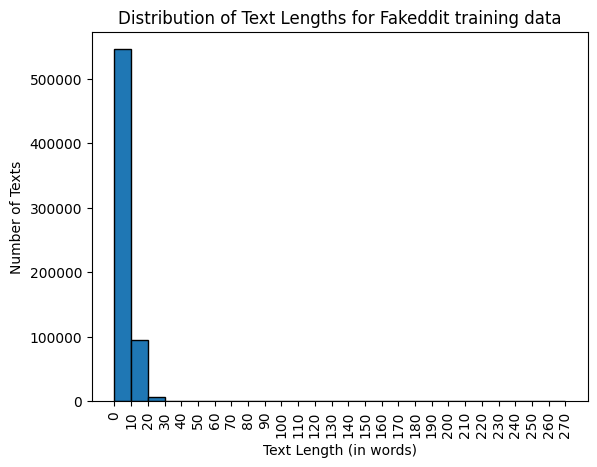

In [24]:
# Fakeddit
fe_mean_length = getMeanTextLength(fe_train_df)
print(f"Fakeddit train - mean length of word tokens in texts: {fe_mean_length}")

fe_max_length, fe_text_lengths = getMaxTextLength(fe_train_df)
print(f"Maximum length of word tokens in texts: {fe_max_length}")

# Plot the Fakeddit text length distribution
plotDistributionOfTextLengthsAsHistogram(fe_text_lengths, 10, 1, "Fakeddit", rotation_value=90)

### Constraint


00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 23065.44it/s]

Constraint train - mean length of word tokens in texts: 17.381587202007527



00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 26289.29it/s]

Maximum length of word tokens in texts: 884


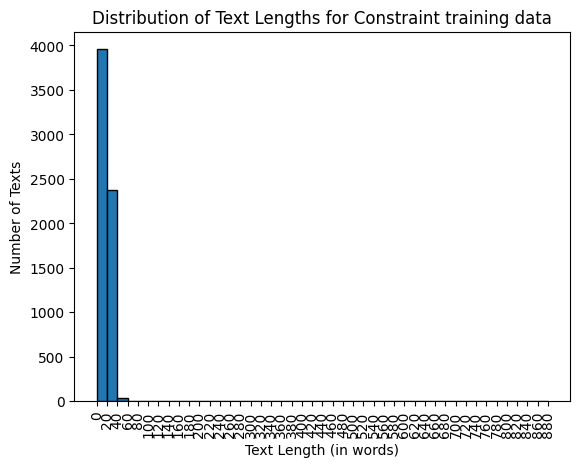

In [54]:
# Constraint
ct_mean_length = getMeanTextLength(ct_train_df)
print(f"Constraint train - mean length of word tokens in texts: {ct_mean_length}")

ct_max_length, ct_text_lengths = getMaxTextLength(ct_train_df)
print(f"Maximum length of word tokens in texts: {ct_max_length}")

# Plots the Constraint text length distribution
plotDistributionOfTextLengthsAsHistogram(ct_text_lengths, 20, 1, "Constraint", rotation_value=90)

### PolitiFact


00%|████████████████████████████████████████| 436/436 [00:00<00:00, 981.91it/s]

PolitiFact train - mean length of word tokens in texts: 768.348623853211


100%|███████████████████████████████████████| 436/436 [00:00<00:00, 1064.84it/s]

Maximum length of word tokens in texts: 8914


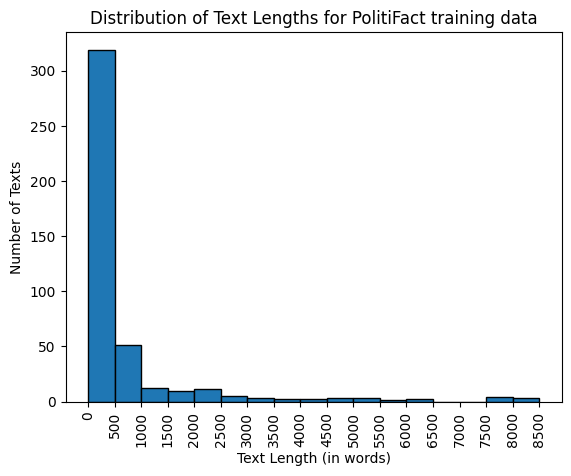

In [56]:
# PolitiFact
pf_mean_length = getMeanTextLength(pf_train_df)
print(f"PolitiFact train - mean length of word tokens in texts: {pf_mean_length}")

pf_max_length, pf_text_lengths = getMaxTextLength(pf_train_df)
print(f"Maximum length of word tokens in texts: {pf_max_length}")

# Plot the PolitiFact text length distribution
plotDistributionOfTextLengthsAsHistogram(pf_text_lengths, 500, 1, "PolitiFact", rotation_value=90)

### GossipCop


00%|███████████████████████████████████| 11042/11042 [00:04<00:00, 2258.63it/s]

GossipCop train - mean length of word tokens in texts: 352.70204673066473



00%|███████████████████████████████████| 11042/11042 [00:04<00:00, 2258.95it/s]

Maximum length of word tokens in texts: 10246


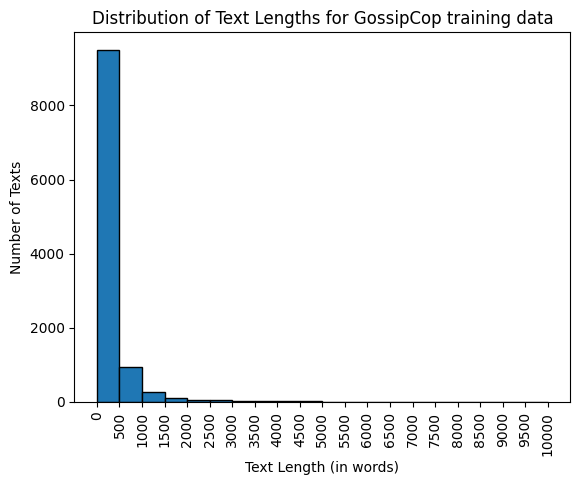

In [57]:
# GossipCop
gc_mean_length = getMeanTextLength(gc_train_df)
print(f"GossipCop train - mean length of word tokens in texts: {gc_mean_length}")

gc_max_length, gc_text_lengths = getMaxTextLength(gc_train_df)
print(f"Maximum length of word tokens in texts: {gc_max_length}")

# Plots the GossipCop text length distribution
plotDistributionOfTextLengthsAsHistogram(gc_text_lengths, 500, 1, "GossipCop", rotation_value=90)

### All-Four Unimodal Text Training Sets Combined


00%|███████████████████████████████████| 11042/11042 [00:04<00:00, 2288.29it/s]

All-Four Combined train - mean length of word tokens in texts: 352.70204673066473



00%|███████████████████████████████████| 11042/11042 [00:04<00:00, 2252.90it/s]

Maximum length of word tokens in texts: 10246


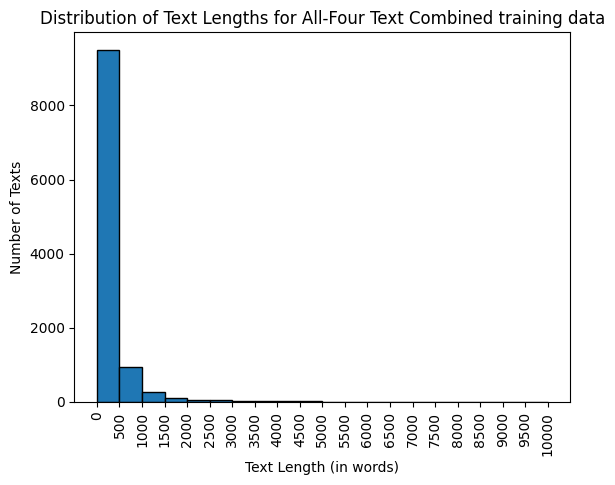

In [13]:
# All-Four Combined
all_four_mean_length = getMeanTextLength(all_four_train_df)

print(f"All-Four Combined train - mean length of word tokens in texts: {all_four_mean_length}")
all_four_max_length, all_four_text_lengths = getMaxTextLength(all_four_train_df)

print(f"Maximum length of word tokens in texts: {all_four_max_length}")

# Plots the All-Four combined text length distribution
plotDistributionOfTextLengthsAsHistogram(all_four_text_lengths, 500, 1, "All-Four Text Combined", rotation_value=90)

### Five-Shot Leave-One-Dataset-Out: Target = WELFake


00%|███████████████████████████████████| 17857/17857 [00:05<00:00, 3283.11it/s]

Five-Shot WELFake target training set - mean length of word tokens in texts: 243.2719941759534



00%|███████████████████████████████████| 17857/17857 [00:05<00:00, 3254.52it/s]

Maximum length of word tokens in texts: 10246


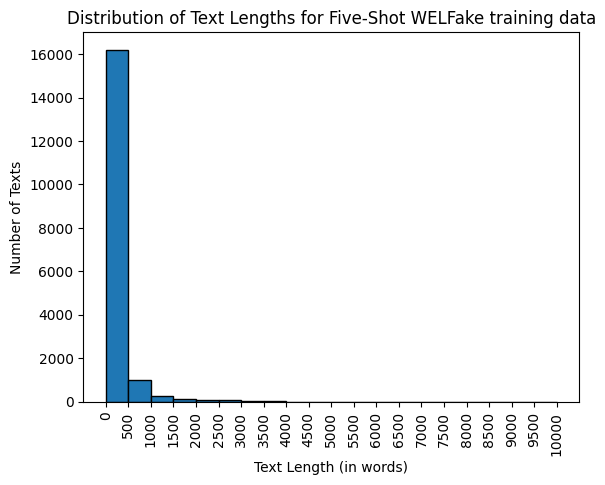

In [7]:
# Five-Shot: WELFake Target
five_shot_wf_target_mean_length = getMeanTextLength(five_shot_wf_target_train_df)
print(f"Five-Shot WELFake target training set - mean length of word tokens in texts: {five_shot_wf_target_mean_length}")

five_shot_wf_target_max_length, five_shot_wf_target_text_lengths = getMaxTextLength(five_shot_wf_target_train_df)
print(f"Maximum length of word tokens in texts: {five_shot_wf_target_max_length}")

# Plots the five-shot WELFake text-length distribution
plotDistributionOfTextLengthsAsHistogram(five_shot_wf_target_text_lengths, 500, 1, "Five-Shot WELFake", rotation_value=90)

### Five-Shot Leave-One-Dataset-Out: Target = Constraint


00%|███████████████████████████████████| 53040/53040 [00:22<00:00, 2367.14it/s]

Five-Shot Constraint target training set - mean length of word tokens in texts: 325.57498114630465



00%|███████████████████████████████████| 53040/53040 [00:22<00:00, 2349.93it/s]

Maximum length of word tokens in texts: 10775


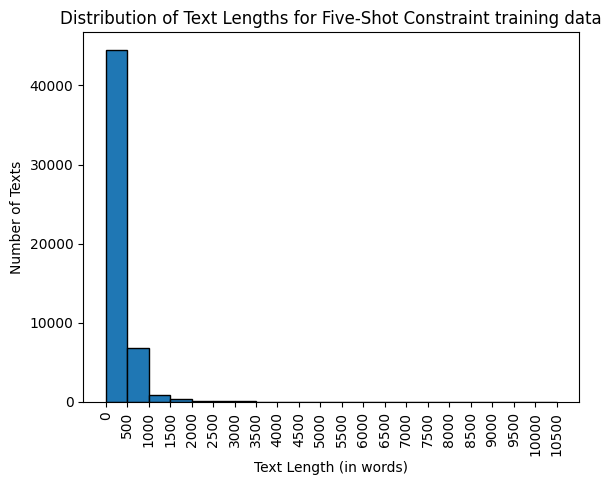

In [8]:
# Five-Shot: Constraint Target
five_shot_ct_target_mean_length = getMeanTextLength(five_shot_ct_target_train_df)
print(f"Five-Shot Constraint target training set - mean length of word tokens in texts: {five_shot_ct_target_mean_length}")

five_shot_ct_target_max_length, five_shot_ct_target_text_lengths = getMaxTextLength(five_shot_ct_target_train_df)
print(f"Maximum length of word tokens in texts: {five_shot_ct_target_max_length}")

# Plots the five-shot Constraint text-length distribution
plotDistributionOfTextLengthsAsHistogram(five_shot_ct_target_text_lengths, 500, 1, "Five-Shot Constraint", rotation_value=90)

### Five-Shot Leave-One-Dataset-Out: Target = PolitiFact


00%|███████████████████████████████████| 58982/58982 [00:22<00:00, 2606.95it/s]

Five-Shot PolitiFact target training set - mean length of word tokens in texts: 289.0501000305178



00%|███████████████████████████████████| 58982/58982 [00:22<00:00, 2606.43it/s]

Maximum length of word tokens in texts: 10775


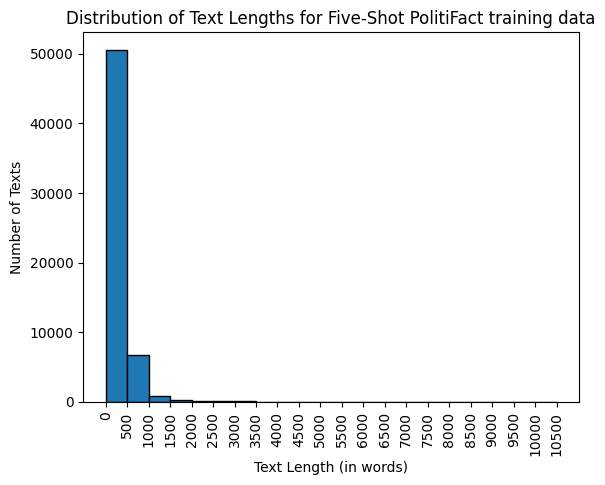

In [9]:
# Five-Shot: PolitiFact Target
five_shot_pf_target_mean_length = getMeanTextLength(five_shot_pf_target_train_df)
print(f"Five-Shot PolitiFact target training set - mean length of word tokens in texts: {five_shot_pf_target_mean_length}")

five_shot_pf_target_max_length, five_shot_pf_target_text_lengths = getMaxTextLength(five_shot_pf_target_train_df)
print(f"Maximum length of word tokens in texts: {five_shot_pf_target_max_length}")

# Plots the five-shot PolitiFact text-length distribution
plotDistributionOfTextLengthsAsHistogram(five_shot_pf_target_text_lengths, 500, 1, "Five-Shot PolitiFact", rotation_value=90)

### Five-Shot Leave-One-Dataset-Out: Target = GossipCop


00%|███████████████████████████████████| 48376/48376 [00:18<00:00, 2658.63it/s]

Five-Shot GossipCop target training set - mean length of word tokens in texts: 278.7695551513147



00%|███████████████████████████████████| 48376/48376 [00:18<00:00, 2675.39it/s]

Maximum length of word tokens in texts: 10775


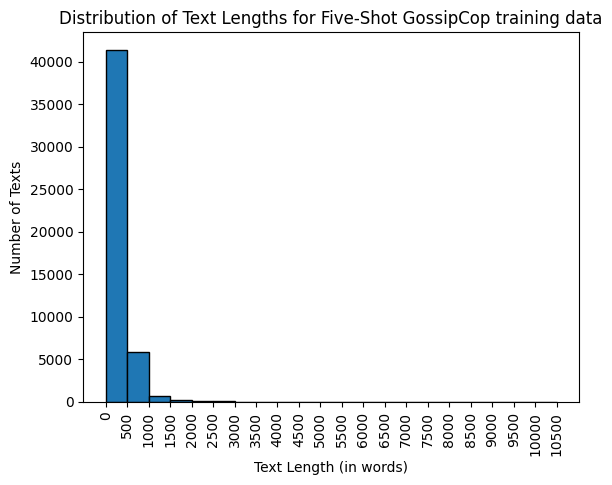

In [10]:
# Five-Shot: GossipCop Target
five_shot_gc_target_mean_length = getMeanTextLength(five_shot_gc_target_train_df)
print(f"Five-Shot GossipCop target training set - mean length of word tokens in texts: {five_shot_gc_target_mean_length}")

five_shot_gc_target_max_length, five_shot_gc_target_text_lengths = getMaxTextLength(five_shot_gc_target_train_df)
print(f"Maximum length of word tokens in texts: {five_shot_gc_target_max_length}")

# Plots the five-shot GossipCop text-length distribution
plotDistributionOfTextLengthsAsHistogram(five_shot_gc_target_text_lengths, 500, 1, "Five-Shot GossipCop", rotation_value=90)

It is not necessary to plot the distributions for the zero-shot training datasets as well, as it is assumed that they will be similar to the five-shot distributions (as there is only a difference of five extra samples).

## CNN-LSTM Input Preparation: Converting and Saving Texts to/as FastText Embeddings, Extracting and Scaling Engineered Features, and One-Hot Encoding Class Labels

In [3]:
def encodeTextAsEmbeddingSequence(text, model):
    """
    Converts a single cleaned and preprocessed text into a sequence (array) of fastText
    embeddings using the inputted pre-trained fastText model for a specific dataset.
    
    Input Parameters:
        text: text to convert into embeddings
        model: A pre-trained, supervised fastText model for this particular (fake news) task
    
    Output:
        np.array: a two-dimensional NumPy array of word embeddings for this particular text, of shape (num_words x embedding_size)
    """
    # Tokenizes the inputted text into word tokens
    words = word_tokenize(text)
    
    # Retrieves the fastText embedding for each word using the inputted pre-trained model
    embeddings = [] # Sets up the list to store each word embedding in for the text
    for word in words:
        embedding = model.get_word_vector(word) # Use fastText in-built "get_word_vector" method to get embedding from pre-trained model
        # Adds the embedding to the embeddings list
        embeddings.append(embedding)
        
    # Converts the list of word embeddings into a NumPy array for deep learning
    return np.array(embeddings)

def prepareEmbeddedSequencesForCNN_LSTM_Model(df, model, max_tokens=1000):
    """
    Processes and prepares a DataFrames' fastText embeddings for CNN-LSTM model, truncating text embeddings
    to max_tokens length (1000 is the default based on the analysis above),
    padding all the shorter texts with zero values for consistent dimensionality.
    
    Input Parameters:
        df (pd.DataFrame): DataFrame containing a "clean_text" column
        fasttext_model: A pre-trained, supervised fastText model for this particular dataset and task
        max_tokens (int): The maximum number of tokens to use, the default was 1000 for WELFake, but this needs to be 25
        for Fakeddit based on the analysis above.
        
    Output:
        pd.DataFrame: DataFrame with new "cnn_lstm_inputs" column containing padded and truncated embeddings
        padded_sequences (np ndarray): NumPy matrix of padded embeddings ready for model input
    """
    # Creates a deep copy of the DataFrame
    processed_df = df.copy()
    
    # First, converts each text into word embeddings using the helper function defined above
    processed_df["embed_seq"] = processed_df["clean_text"].progress_apply(
        lambda x: encodeTextAsEmbeddingSequence(x, model) # Use lambda to enable passing in the pre-trained fastText model as a parameter
    )
    
    # Pads the sequences shorter than max_length with 0s using the in-built Keras pad_sequences function
    # Reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
    """
        This function transforms a list (of length num_samples) 
        of sequences (lists of integers) into a 2D NumPy array of 
        shape (num_samples, num_timesteps). num_timesteps is either the
        maxlen argument if provided, or the length of the longest sequence in the list.
    """
    padded_sequences = pad_sequences(
        processed_df["embed_seq"].tolist(),  # Converts the Series/column of embedded word sequences to a list for pad_sequences to work
        maxlen=max_tokens,  # Truncates/pads all sequences to max_tokens to reduce the dimensionality and thus time taken for deep learning
        dtype="float32",  # Define the embedding values data type to be 32-bit floats
        padding="post",  # Pad with zeroes at the END of the news text word sequence
        truncating="post",  # Also truncate at the END of the word embedding sequence
        value=0.0  # Fill the empty spaces for texts shorter than the maximum length with zeroes
    )
    
    # Adds the padded sequences (CNN-LSTM inputs) as a new column 
    processed_df["cnn_lstm_inputs"] = list(padded_sequences)

    # Returns a new DataFrame with the column containing padded or truncated neural network inputs, as well as the NumPy matrix of embeddings
    return processed_df, padded_sequences

def saveLargeDFsInChunks(df, save_path, chunksize=10000):
    """
    Saves a large (this was particularly required for Fakeddit due to memory limits) pandas DataFrame to
    disk in chunks using the pandas chunksize parameter to avoid out-of-memory kernel crashes.

        Input Parameters:
            df (pd.DataFrame): The DataFrame to save.
            filename (str): The path to save the CSV file.
            chunksize (int): The number of rows per chunk. Default is 10,000.
    """
    df.to_csv(
            save_path,
            chunksize=chunksize,    # Process this many rows at a time
            index=False,            # Ignore index
        )
    print(f"Successfully saved DataFrame to csv under: {save_path}")


def saveEmbeddingsAsNumPyArraysToDisk(train_embeddings, val_embeddings, test_embeddings, root_path, dataset_name):
    """
    Saves the fastText training, validation and test embedding arrays of shape (num_samples * 
    max_sequence_length * embedding_size) to .npy files for easier loading.
        
        Input Parameters:
            train_embeddings (NumPy nd.array): NumPy fastText embeddings for a training set.
            val_embeddings (NumPy nd.array): NumPy fastText embeddings for a validation set.
            test_embeddings (NumPy nd.array): NumPy fastText embeddings for a test set.
            root_path (str): directory string where to save
            dataset_name (str): dataset name to save file as
    """
    # Clears memory to prevent the Jupyter kernel crashes
    gc.collect()
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_train_embeddings.npy", train_embeddings)
    gc.collect()
    gc.collect()
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_val_embeddings.npy",  val_embeddings)
    gc.collect()
    gc.collect()
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_test_embeddings.npy",  test_embeddings)
    gc.collect()
    gc.collect()
    print(f"Saved {dataset_name} train, validation and test embeddings as .npy files in {root_path} folder!")

def saveHugeArraysInChunks(filepath, array, chunk_size=1000):
    """
    Saves a massive np array to disk chunk by chunk, otherwise the Kernel will crash.

        Input Parameters:
            filepath (str): file path to save to
            array (np nd.array): array to save
            chunk_size (int): default=1000, chunk size to save large arrays by to prevent the kernel from crashing
    """
    with open(filepath, "wb") as f:
        # Iterates over the array in steps of "chunk_size"
        for i in range(0, len(array), chunk_size):
            np.save(f, array[i:i+chunk_size])  # Writes the chunks to array

def saveExtraFeaturesAndOneHotLabelsToDisk(train_extra_features, val_extra_features, test_extra_features,
                                          train_labels, val_labels, test_labels, root_path, dataset_name):
    """
    Saves the fastText training, validation and test extra engineered feature arrays of shape (num_samples * 10) 
    and one-hot encoded labels to .npy files.
    
        Input Parameters:
            train_extra_features, val_extra_features, test_extra_features (np nd.array): extra features train, validation, test NumPy arrays
            train_labels, val_labels, test_labels (np nd.array): arrays of train, validation and test labels to save
            root_path (str): where to save the arrays to
            dataset_name (str): name of dataset for saving the arrays
    """

    # Saves the extra features as .npy files
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_train_extra_features.npy", train_extra_features)
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_val_extra_features.npy", val_extra_features)
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_test_extra_features.npy", test_extra_features)

    # Saves the labels
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_train_labels.npy", train_labels)
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_val_labels.npy", val_labels)
    np.save(f"{root_path}/{dataset_name}_for_hashmi_approach_test_labels.npy", test_labels)

    print(f"Saved extra features and labels for {dataset_name} in {root_path} directory!")


def loadExtraFeaturesAndOneHotLabelsFromDisk(root_path, dataset_name):
    """
    Loads in NumPy arrays of training, validation and test extra features and one-hot encoded labels from .npy files.

        Input Parameters:
            root_path (str): where to load the extra features and labels arrays from
            dataset_name (str): the name of dataset for loading the arrays

        Output:
            train_extra_features, val_extra_features, test_extra_features (np nd.array): extra features train, validation, test NumPy arrays
            train_labels, val_labels, test_labels (np nd.array): arrays of train, validation and test one-hot encoded labels
    """

    # Loads extra features arrays for three data splits
    train_extra_features = np.load(f"{root_path}/{dataset_name}_for_hashmi_approach_train_extra_features.npy")
    val_extra_features = np.load(f"{root_path}/{dataset_name}_for_hashmi_approach_val_extra_features.npy")
    test_extra_features = np.load(f"{root_path}/{dataset_name}_for_hashmi_approach_test_extra_features.npy")

    # Loads the labels for the three splits
    train_labels = np.load(f"{root_path}/{dataset_name}_for_hashmi_approach_train_labels.npy")
    val_labels = np.load(f"{root_path}/{dataset_name}_for_hashmi_approach_val_labels.npy")
    test_labels = np.load(f"{root_path}/{dataset_name}_for_hashmi_approach_test_labels.npy")

    print(f"Loaded extra features and labels for {dataset_name} from {root_path} directory!")

    # Returns the extra features arrays and the labels
    return train_extra_features, val_extra_features, test_extra_features, train_labels, val_labels, test_labels

    
def loadEmbeddingsFromNpyFiles(train_path, val_path, test_path):
    """
    Loads in the NumPy arrays of training, validation and test embeddings from .npy files.

        Input Parameters:
            train_path (str): path where to load the training embeddings from
            val_path (str): path where to load the validation embeddings from
            test_path (str): path where to load the test embeddings from

        Output:
            train_embeddings (np nd.array): NumPy array of training embeddings
            val_embeddings (np nd.array): NumPy array of validation embeddings
            test_embeddings (np nd.array): NumPy array of test embeddings
    """
    train_embeddings = np.load(train_path)
    gc.collect()
    val_embeddings = np.load(val_path)
    gc.collect()
    test_embeddings = np.load(test_path)
    gc.collect()
    return train_embeddings, val_embeddings, test_embeddings

# Stores the TEN extra engineered feature column names for the datasets
feature_cols = [
    "exclamation_point_frequency", "third_person_pronoun_frequency", 
    "noun_to_verb_ratio", "cardinal_named_entity_frequency",
    "person_named_entity_frequency", "nrc_positive_emotion_score", 
    "nrc_trust_emotion_score", "flesch_kincaid_readability_score",
    "difficult_words_readability_score", "capital_letter_frequency"
]

def prepareDataForCNN_LSTM(train_df, val_df, test_df, feature_cols):
    """
    This function prepares training, validation and test data by extracting and scaling
    the extra engineered features from pandas DataFrames into numpy matrices for CNN-LSTM model training,
    as well as extracting and one-hot encoding the binary labels
    
        Input Parameters:
            wf_train_df (pd.DataFrame): Training news DataFrame containing texts and extra engineered feature columns
            wf_val_df (pd.DataFrame): Validation news DataFrame with extra engineered feature columns
            wf_test_df (pd.DataFrame): Test news DataFrame with extra engineered feature columns
            feature_cols (list of strings): list of names of extra engineered feature columns
    
        Output:
            y_train (numpy.ndarray): a NumPy array containing one-hot encoded ground truth labels for the training set 
            y_val (numpy.ndarray): a NumPy array containing one-hot encoded ground truth labels for the validation set 
            y_test (numpy.ndarray): a NumPy array containing one-hot encoded ground truth labels for the test set 
            X_train_extra (numpy.ndarray): the training set's scaled extra engineered features matrix, e.g. sentiment scores, readability scores
                                         Should be of shape (num_samples, num_features[10])
            X_val_extra (numpy.ndarray): the validation dataset's scaled extra engineered features matrix
            X_test_extra (numpy.ndarray): the test dataset's scaled extra engineered features matrix
    """

    # Prepares the list of 2D arrays of extra engineered features to concatenate/combine with the fastText embeddings for model training
    X_train_extra = train_df[feature_cols].values
    X_val_extra = val_df[feature_cols].values
    X_test_extra = test_df[feature_cols].values
    
    # Scales the features to avoid extreme values
    scaler = MinMaxScaler()
    X_train_extra_scaled = scaler.fit_transform(X_train_extra) # Fit feature scaler using the training set
    X_val_extra_scaled = scaler.transform(X_val_extra) # Use fitted scaler to transform the validation set
    X_test_extra_scaled = scaler.transform(X_test_extra) # Use fitted scaler to transform the validation set
    
    # Prepares the label feature matrices, to_categorical converts integer labels into one-hot encoded arrays
    y_train = to_categorical(train_df["label"].values)
    y_val = to_categorical(val_df["label"].values)
    y_test = to_categorical(test_df["label"].values)

    # Returns the feature and label matrices as NumPy arrays
    return X_train_extra_scaled, X_val_extra_scaled, X_test_extra_scaled, y_train, y_val, y_test

### Prepare WELFake Data

In [15]:
# Applies the functions to generate inputs for the CNN-LSTM model (padded and truncated sequences of word embeddings)
# WELFake
wf_train_df, wf_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(wf_train_df, wf_model) # 1000 tokens for max_length
saveLargeDFsInChunks(wf_train_df, "../../FPData/FastText/wf_train_with_cnn_lstm_inputs.csv")
wf_val_df, wf_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(wf_val_df, wf_model)
saveLargeDFsInChunks(wf_val_df, "../../FPData/FastText/wf_val_with_cnn_lstm_inputs.csv")
wf_test_df, wf_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(wf_test_df, wf_model)
saveLargeDFsInChunks(wf_test_df, "../../FPData/FastText/wf_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 41559/41559 [00:39<00:00, 1047.63it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/wf_train_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 9325/9325 [00:09<00:00, 1024.04it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/wf_val_with_cnn_lstm_inputs.csv



00%|███████████████████████████████████| 11237/11237 [00:10<00:00, 1036.26it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/wf_test_with_cnn_lstm_inputs.csv


In [35]:
print(f"Shape of WELFake training embeddings matrix: {wf_train_embeddings.shape}")

Shape of WELFake training embeddings matrix: (41559, 1000, 140)


The shape of the WELFake embeddings matrix is: 


    num_samples (41559 for the training set) x max_sequence_length (1000 word tokens) x 140 (size of auto-tuned fastText embeddings).

In [34]:
# Saves the WELFake embeddings
saveEmbeddingsAsNumPyArraysToDisk(
    wf_train_embeddings,
    wf_val_embeddings,
    wf_test_embeddings,
    "../../FPData/FastText",
    "wf"
)

Saved wf train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [45]:
# Prepares the extra-features matrices and one-hot encoded labels for WELFake
wf_X_train_extra_scaled, wf_X_val_extra_scaled, wf_X_test_extra_scaled, wf_y_train, wf_y_val, wf_y_test = prepareDataForCNN_LSTM(
    wf_train_df,
    wf_val_df,
    wf_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(wf_X_train_extra_scaled, wf_X_val_extra_scaled, wf_X_test_extra_scaled,
                                          wf_y_train, wf_y_val, wf_y_test, "../../FPData/FastText", "wf")

Saved extra features and labels for wf in ../../FPData/FastText directory!


In [6]:
# Loads WELFake embeddings back in
wf_X_train, wf_X_val, wf_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/wf_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/wf_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/wf_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
wf_X_train_extra_scaled, wf_X_val_extra_scaled, wf_X_test_extra_scaled, wf_y_train, wf_y_val, wf_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "wf"
                                                                                                        )

Loaded extra features and labels for wf from ../../FPData/FastText directory!


In [14]:
# Checks the dataset sizes are correct
print(wf_X_train.shape, wf_X_val.shape, wf_X_test.shape)
print(wf_X_train_extra_scaled.shape, wf_X_val_extra_scaled.shape, wf_X_test_extra_scaled.shape)
print(wf_y_train.shape, wf_y_val.shape, wf_y_test.shape)

(41559, 1000, 140) (9325, 1000, 140) (11237, 1000, 140)
(41559, 10) (9325, 10) (11237, 10)
(41559, 2) (9325, 2) (11237, 2)


### Prepare Fakeddit Data

In [2]:
# Frees up the memory!
gc.collect()

0

In [31]:
# Fakeddit: do separately and clear garbage as VERYYY large files!

# Prepares the training set embeddings
fe_train_df, fe_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(fe_train_df, fe_model, max_tokens=25)
saveLargeDFsInChunks(fe_train_df, "../../FPData/FastText/fe_train_with_cnn_lstm_inputs.csv")


00%|████████████████████████████████| 647496/647496 [00:22<00:00, 28413.60it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/fe_train_with_cnn_lstm_inputs.csv


In [32]:
# Frees up the memory!
gc.collect()

0

In [33]:
# Prepares the validation set embeddings
fe_val_df, fe_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(fe_val_df, fe_model, max_tokens=25)
saveLargeDFsInChunks(fe_val_df, "../../FPData/FastText/fe_val_with_cnn_lstm_inputs.csv")


00%|██████████████████████████████████| 70239/70239 [00:02<00:00, 27601.58it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/fe_val_with_cnn_lstm_inputs.csv


In [34]:
# Frees up the memory!
gc.collect()

0

In [35]:
# Prepares the test set embeddings
fe_test_df, fe_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(fe_test_df, fe_model, max_tokens=25)
saveLargeDFsInChunks(fe_test_df, "../../FPData/FastText/fe_test_with_cnn_lstm_inputs.csv")


00%|██████████████████████████████████| 71010/71010 [00:02<00:00, 27911.65it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/fe_test_with_cnn_lstm_inputs.csv


In [36]:
# Frees up the memory!
gc.collect()

0

In [37]:
print(f"Shape of Fakeddit training embeddings matrix: {fe_train_embeddings.shape}")

Shape of Fakeddit training embeddings matrix: (647496, 25, 46)


In [38]:
# Saves the HUGE Fakeddit embeddings separately

# Saves the training set embeddings
np.save("../../FPData/FastText/fe_for_hashmi_approach_train_embeddings.npy", fe_train_embeddings)

In [44]:
# Saves the validation set embeddings
np.save("../../FPData/FastText/fe_for_hashmi_approach_val_embeddings.npy", fe_val_embeddings)

In [45]:
# Saves the test set embeddings
np.save("../../FPData/FastText/fe_for_hashmi_approach_test_embeddings.npy", fe_test_embeddings)

In [43]:
# Prepares the extra-features matrices and one-hot encoded labels for Fakeddit
fe_X_train_extra_scaled, fe_X_val_extra_scaled, fe_X_test_extra_scaled, fe_y_train, fe_y_val, fe_y_test = prepareDataForCNN_LSTM(
    fe_train_df,
    fe_val_df,
    fe_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(fe_X_train_extra_scaled, fe_X_val_extra_scaled, fe_X_test_extra_scaled,
                                          fe_y_train, fe_y_val, fe_y_test, "../../FPData/FastText", "fe")

Saved extra features and labels for fe in ../../FPData/FastText directory!


In [5]:
# Loads Fakeddit embeddings back in
fe_X_train, fe_X_val, fe_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/fe_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/fe_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/fe_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
fe_X_train_extra_scaled, fe_X_val_extra_scaled, fe_X_test_extra_scaled, fe_y_train, fe_y_val, fe_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "fe"
                                                                                                        )

Loaded extra features and labels for fe from ../../FPData/FastText directory!


In [6]:
# Checks the dataset sizes are correct
print(fe_X_train.shape, fe_X_val.shape, fe_X_test.shape)
print(fe_X_train_extra_scaled.shape, fe_X_val_extra_scaled.shape, fe_X_test_extra_scaled.shape)
print(fe_y_train.shape, fe_y_val.shape, fe_y_test.shape)

(647496, 25, 46) (70239, 25, 46) (71010, 25, 46)
(647496, 10) (70239, 10) (71010, 10)
(647496, 2) (70239, 2) (71010, 2)


### Prepare Constraint Data

In [66]:
# Prepares and saves the Constraint embeddings for training, validation and test sets as .csv files
ct_train_df, ct_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(ct_train_df, ct_model, max_tokens=60)
saveLargeDFsInChunks(ct_train_df, "../../FPData/FastText/ct_train_with_cnn_lstm_inputs.csv")
ct_val_df, ct_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(ct_val_df, ct_model, max_tokens=60)
saveLargeDFsInChunks(ct_val_df, "../../FPData/FastText/ct_val_with_cnn_lstm_inputs.csv")
ct_test_df, ct_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(ct_test_df, ct_model, max_tokens=60)
saveLargeDFsInChunks(ct_test_df, "../../FPData/FastText/ct_test_with_cnn_lstm_inputs.csv")


00%|████████████████████████████████████| 6376/6376 [00:00<00:00, 11939.68it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/ct_train_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████| 2128/2128 [00:00<00:00, 13134.51it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/ct_val_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 12806.26it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/ct_test_with_cnn_lstm_inputs.csv


In [68]:
print(f"Shape of Constraint training embeddings matrix: {ct_train_embeddings.shape}")

Shape of Constraint training embeddings matrix: (6376, 60, 10)


In [69]:
# Saves the Constraint embeddings as .npy files
saveEmbeddingsAsNumPyArraysToDisk(
    ct_train_embeddings,
    ct_val_embeddings,
    ct_test_embeddings,
    "../../FPData/FastText",
    "ct"
)

Saved ct train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [70]:
# Prepares the extra-features matrices and one-hot encoded labels for Constraint
ct_X_train_extra_scaled, ct_X_val_extra_scaled, ct_X_test_extra_scaled, ct_y_train, ct_y_val, ct_y_test = prepareDataForCNN_LSTM(
    ct_train_df,
    ct_val_df,
    ct_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(ct_X_train_extra_scaled, ct_X_val_extra_scaled, ct_X_test_extra_scaled,
                                          ct_y_train, ct_y_val, ct_y_test, "../../FPData/FastText", "ct")

Saved extra features and labels for ct in ../../FPData/FastText directory!


In [35]:
# Loads theConstraint embeddings back in
ct_X_train, ct_X_val, ct_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/ct_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/ct_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/ct_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
ct_X_train_extra_scaled, ct_X_val_extra_scaled, ct_X_test_extra_scaled, ct_y_train, ct_y_val, ct_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "ct"
                                                                                                        )

Loaded extra features and labels for ct from ../../FPData/FastText directory!


In [36]:
# Checks the dataset sizes are correct
print(ct_X_train.shape, ct_X_val.shape, ct_X_test.shape)
print(ct_X_train_extra_scaled.shape, ct_X_val_extra_scaled.shape, ct_X_test_extra_scaled.shape)
print(ct_y_train.shape, ct_y_val.shape, ct_y_test.shape)

(6376, 60, 10) (2128, 60, 10) (2122, 60, 10)
(6376, 10) (2128, 10) (2122, 10)
(6376, 2) (2128, 2) (2122, 2)


### Prepare PolitiFact Data

In [73]:
# Prepares and saves the PolitiFact embeddings for training, validation and test sets as .csv files
pf_train_df, pf_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(pf_train_df, pf_model, max_tokens=2000)
saveLargeDFsInChunks(pf_train_df, "../../FPData/FastText/pf_train_with_cnn_lstm_inputs.csv")
pf_val_df, pf_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(pf_val_df, pf_model, max_tokens=2000)
saveLargeDFsInChunks(pf_val_df, "../../FPData/FastText/pf_val_with_cnn_lstm_inputs.csv")
pf_test_df, pf_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(pf_test_df, pf_model, max_tokens=2000)
saveLargeDFsInChunks(pf_test_df, "../../FPData/FastText/pf_test_with_cnn_lstm_inputs.csv")


00%|████████████████████████████████████████| 436/436 [00:01<00:00, 424.62it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/pf_train_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 422.42it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/pf_val_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████████| 126/126 [00:00<00:00, 451.58it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/pf_test_with_cnn_lstm_inputs.csv


In [81]:
print(f"Shape of PolitiFact training embeddings matrix: {pf_train_embeddings.shape}")

Shape of PolitiFact training embeddings matrix: (436, 2000, 11)


In [75]:
# Saves thePolitiFact embeddings as .npy files
saveEmbeddingsAsNumPyArraysToDisk(
    pf_train_embeddings,
    pf_val_embeddings,
    pf_test_embeddings,
    "../../FPData/FastText",
    "pf"
)

Saved pf train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [76]:
# Prepares the extra-features matrices and one-hot encoded labels for PolitiFact
pf_X_train_extra_scaled, pf_X_val_extra_scaled, pf_X_test_extra_scaled, pf_y_train, pf_y_val, pf_y_test = prepareDataForCNN_LSTM(
    pf_train_df,
    pf_val_df,
    pf_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(pf_X_train_extra_scaled, pf_X_val_extra_scaled, pf_X_test_extra_scaled,
                                          pf_y_train, pf_y_val, pf_y_test, "../../FPData/FastText", "pf")

Saved extra features and labels for pf in ../../FPData/FastText directory!


In [51]:
# Loads the PolitiFact embeddings back in
pf_X_train, pf_X_val, pf_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/pf_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/pf_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/pf_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
pf_X_train_extra_scaled, pf_X_val_extra_scaled, pf_X_test_extra_scaled, pf_y_train, pf_y_val, pf_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "pf"
                                                                                                        )

Loaded extra features and labels for pf from ../../FPData/FastText directory!


### Prepare GossipCop Data

In [78]:
# Prepares and saves the GossipCop embeddings for training, validation and test sets as .csv files
gc_train_df, gc_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(gc_train_df, gc_model, max_tokens=1500)
saveLargeDFsInChunks(gc_train_df, "../../FPData/FastText/gc_train_with_cnn_lstm_inputs.csv")
gc_val_df, gc_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(gc_val_df, gc_model, max_tokens=1500)
saveLargeDFsInChunks(gc_val_df, "../../FPData/FastText/gc_val_with_cnn_lstm_inputs.csv")
gc_test_df, gc_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(gc_test_df, gc_model, max_tokens=1500)
saveLargeDFsInChunks(gc_test_df, "../../FPData/FastText/gc_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 11042/11042 [00:10<00:00, 1004.34it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/gc_train_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 2630/2630 [00:02<00:00, 1044.33it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/gc_val_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 3199/3199 [00:03<00:00, 1064.64it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/gc_test_with_cnn_lstm_inputs.csv


In [80]:
print(f"Shape of GossipCop training embeddings matrix: {gc_train_embeddings.shape}")

Shape of GossipCop training embeddings matrix: (11042, 1500, 6)


In [84]:
# Saves the GossipCop embeddings
saveEmbeddingsAsNumPyArraysToDisk(
    gc_train_embeddings,
    gc_val_embeddings,
    gc_test_embeddings,
    "../../FPData/FastText",
    "gc"
)

Saved gc train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [82]:
# Prepares the extra-features matrices and one-hot encoded labels for GossipCop
gc_X_train_extra_scaled, gc_X_val_extra_scaled, gc_X_test_extra_scaled, gc_y_train, gc_y_val, gc_y_test = prepareDataForCNN_LSTM(
    gc_train_df,
    gc_val_df,
    gc_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(gc_X_train_extra_scaled, gc_X_val_extra_scaled, gc_X_test_extra_scaled,
                                          gc_y_train, gc_y_val, gc_y_test, "../../FPData/FastText", "gc")

Saved extra features and labels for gc in ../../FPData/FastText directory!


In [74]:
# Loads the GossipCop embeddings back in
gc_X_train, gc_X_val, gc_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/gc_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/gc_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/gc_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
gc_X_train_extra_scaled, gc_X_val_extra_scaled, gc_X_test_extra_scaled, gc_y_train, gc_y_val, gc_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "gc"
                                                                                                        )

Loaded extra features and labels for gc from ../../FPData/FastText directory!


### Prepare All-Four Combined Data

In [15]:
# Prepares and saves the All-Four combined embeddings for training, validation and test sets as .csv files
all_four_train_df, all_four_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    all_four_train_df, all_four_model, max_tokens=500) # Cannot do more tokens as this crashes the Kernel immediately, unfortunately
saveLargeDFsInChunks(all_four_train_df, "../../FPData/FastText/all_four_train_with_cnn_lstm_inputs.csv")
all_four_val_df, all_four_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    all_four_val_df, all_four_model, max_tokens=500)
saveLargeDFsInChunks(all_four_val_df, "../../FPData/FastText/all_four_val_with_cnn_lstm_inputs.csv")
all_four_test_df, all_four_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    all_four_test_df, all_four_model, max_tokens=500)
saveLargeDFsInChunks(all_four_test_df, "../../FPData/FastText/all_four_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 11042/11042 [00:10<00:00, 1018.62it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/all_four_train_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 2630/2630 [00:02<00:00, 1041.56it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/all_four_val_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 3199/3199 [00:02<00:00, 1075.78it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/all_four_test_with_cnn_lstm_inputs.csv


In [17]:
print(f"Shape of All-Four combined training embeddings matrix: {all_four_train_embeddings.shape}")

Shape of All-Four combined training embeddings matrix: (11042, 500, 7)


In [18]:
# Saves the All-Four combined embeddings
saveEmbeddingsAsNumPyArraysToDisk(
    all_four_train_embeddings,
    all_four_val_embeddings,
    all_four_test_embeddings,
    "../../FPData/FastText",
    "all_four"
)

Saved all_four train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [20]:
# Prepares the extra-features matrices and one-hot encoded labels for All-Four combined
all_four_X_train_extra_scaled, all_four_X_val_extra_scaled, all_four_X_test_extra_scaled, all_four_y_train, all_four_y_val, all_four_y_test = prepareDataForCNN_LSTM(
    all_four_train_df,
    all_four_val_df,
    all_four_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(all_four_X_train_extra_scaled, all_four_X_val_extra_scaled, all_four_X_test_extra_scaled,
                                          all_four_y_train, all_four_y_val, all_four_y_test, "../../FPData/FastText", "all_four")

Saved extra features and labels for all_four in ../../FPData/FastText directory!


In [91]:
# Loads the All-Four combined embeddings back in
all_four_X_train, all_four_X_val, all_four_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/all_four_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/all_four_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/all_four_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
all_four_X_train_extra_scaled, all_four_X_val_extra_scaled, all_four_X_test_extra_scaled, all_four_y_train, all_four_y_val, all_four_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "all_four"
                                                                                                        )

Loaded extra features and labels for all_four from ../../FPData/FastText directory!


### Prepare Five-Shot: WELFake Target Data

In [5]:
# Prepares and saves the five-shot, target: WELFake embeddings for training, validation and test sets as .csv files

# Combined leave-one-out training data --> convert into embeddings using the pre-trained fastText model
five_shot_wf_target_train_df, five_shot_wf_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    five_shot_wf_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_wf_target_train_df, "../../FPData/FastText/five_shot_wf_target_train_with_cnn_lstm_inputs.csv")

# Validation set
# Uses the WELFake validation set and test set for evaluation, but this time using the pre-trained fT model to extract dense embeddings
# For improved generalization, uses the general pre-trained model instead of training a fastText model on the leavep=-one-dataset-out set
five_shot_wf_target_val_df, five_shot_wf_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    wf_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_wf_target_val_df, "../../FPData/FastText/five_shot_wf_target_val_with_cnn_lstm_inputs.csv")

# Test set
five_shot_wf_target_test_df, five_shot_wf_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    wf_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_wf_target_test_df, "../../FPData/FastText/five_shot_wf_target_test_with_cnn_lstm_inputs.csv")

In [21]:
print(f"Shape of Five-Shot Target: WELFake  training embeddings matrix: {five_shot_wf_target_train_embeddings.shape}")

Shape of Five-Shot Target: WELFake  training embeddings matrix: (17857, 500, 100)


In [22]:
# Saves the five-shot target: WELFake combined embeddings
saveEmbeddingsAsNumPyArraysToDisk(
    five_shot_wf_target_train_embeddings,
    five_shot_wf_target_val_embeddings,
    five_shot_wf_target_test_embeddings,
    "../../FPData/FastText",
    "five_shot_wf_target"
)

Saved five_shot_wf_target train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [23]:
# Prepares the extra-features matrices and one-hot encoded labels for five-shot: WELFake target combined
five_shot_wf_target_X_train_extra_scaled, five_shot_wf_target_X_val_extra_scaled, five_shot_wf_target_X_test_extra_scaled, five_shot_wf_target_y_train, five_shot_wf_target_y_val, five_shot_wf_target_y_test = prepareDataForCNN_LSTM(
    five_shot_wf_target_train_df,
    five_shot_wf_target_val_df,
    five_shot_wf_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(five_shot_wf_target_X_train_extra_scaled,
                                       five_shot_wf_target_X_val_extra_scaled,
                                       five_shot_wf_target_X_test_extra_scaled,
                                       five_shot_wf_target_y_train,
                                       five_shot_wf_target_y_val,
                                       five_shot_wf_target_y_test,
                                       "../../FPData/FastText", "five_shot_wf_target"
                                      )

Saved extra features and labels for five_shot_wf_target in ../../FPData/FastText directory!


In [6]:
# Loads the five-shot: WELFake target combined embeddings back in
five_shot_wf_target_X_train, five_shot_wf_target_X_val, five_shot_wf_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/five_shot_wf_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/five_shot_wf_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/five_shot_wf_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
five_shot_wf_target_X_train_extra_scaled, five_shot_wf_target_X_val_extra_scaled, five_shot_wf_target_X_test_extra_scaled, five_shot_wf_target_y_train, five_shot_wf_target_y_val, five_shot_wf_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "five_shot_wf_target"
                                                                                                        )

Loaded extra features and labels for five_shot_wf_target from ../../FPData/FastText directory!


In [7]:
# Checks the dataset sizes are correct
print(five_shot_wf_target_X_train.shape, five_shot_wf_target_X_val.shape, five_shot_wf_target_X_test.shape)
print(five_shot_wf_target_X_train_extra_scaled.shape, five_shot_wf_target_X_val_extra_scaled.shape,
      five_shot_wf_target_X_test_extra_scaled.shape, five_shot_wf_target_y_train.shape,
      five_shot_wf_target_y_val.shape, five_shot_wf_target_y_test.shape)

(17857, 500, 100) (9325, 500, 100) (11237, 500, 100)
(17857, 10) (9325, 10) (11237, 10) (17857, 2) (9325, 2) (11237, 2)


### Prepare Five-Shot: Constraint Target Data

In [8]:
# Prepares and saves the five-shot, target: Constraint embeddings for training, validation and test sets as .csv files
five_shot_ct_target_train_df, five_shot_ct_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    five_shot_ct_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_ct_target_train_df, "../../FPData/FastText/five_shot_ct_target_train_with_cnn_lstm_inputs.csv")

# Validation set
five_shot_ct_target_val_df, five_shot_ct_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    ct_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_ct_target_val_df, "../../FPData/FastText/five_shot_ct_target_val_with_cnn_lstm_inputs.csv")

# Test set
five_shot_ct_target_test_df, five_shot_ct_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    ct_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_ct_target_test_df, "../../FPData/FastText/five_shot_ct_target_test_with_cnn_lstm_inputs.csv")


00%|████████████████████████████████████| 53040/53040 [00:53<00:00, 982.38it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_ct_target_train_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 2128/2128 [00:00<00:00, 4285.79it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_ct_target_val_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 10162.92it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_ct_target_test_with_cnn_lstm_inputs.csv


In [75]:
gc.collect()

66

In [17]:
# Saves the five-shot target:Constraint embeddings in chunks
saveHugeArraysInChunks("../../FPData/FastText/five_shot_ct_target_for_hashmi_approach_train_embeddings.npy",
                       five_shot_ct_target_train_embeddings,
                       chunk_size=5000
                      )

In [18]:
np.save("../../FPData/FastText/five_shot_ct_target_for_hashmi_approach_val_embeddings.npy", five_shot_ct_target_val_embeddings)

In [19]:
np.save("../../FPData/FastText/five_shot_ct_target_for_hashmi_approach_test_embeddings.npy", five_shot_ct_target_test_embeddings)

In [29]:
# Prepares the extra-features matrices and one-hot encoded labels for five-shot: Constraint target combined
five_shot_ct_target_X_train_extra_scaled, five_shot_ct_target_X_val_extra_scaled, five_shot_ct_target_X_test_extra_scaled, five_shot_ct_target_y_train, five_shot_ct_target_y_val, five_shot_ct_target_y_test = prepareDataForCNN_LSTM(
    five_shot_ct_target_train_df,
    five_shot_ct_target_val_df,
    five_shot_ct_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(five_shot_ct_target_X_train_extra_scaled,
                                       five_shot_ct_target_X_val_extra_scaled,
                                       five_shot_ct_target_X_test_extra_scaled,
                                       five_shot_ct_target_y_train,
                                       five_shot_ct_target_y_val,
                                       five_shot_ct_target_y_test,
                                       "../../FPData/FastText", "five_shot_ct_target"
                                      )

Saved extra features and labels for five_shot_ct_target in ../../FPData/FastText directory!


In [8]:
# Loads the five-shot: Constraint target combined embeddings back in
five_shot_ct_target_X_train, five_shot_ct_target_X_val, five_shot_ct_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/five_shot_ct_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/five_shot_ct_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/five_shot_ct_target_for_hashmi_approach_test_embeddings.npy"
)

# Load the extra features and labels back in
five_shot_ct_target_X_train_extra_scaled, five_shot_ct_target_X_val_extra_scaled, five_shot_ct_target_X_test_extra_scaled, five_shot_ct_target_y_train, five_shot_ct_target_y_val, five_shot_ct_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "five_shot_ct_target"
                                                                                                        )

Loaded extra features and labels for five_shot_ct_target from ../../FPData/FastText directory!


In [9]:
# Checks the shapes look correct
print(five_shot_ct_target_X_train.shape, five_shot_ct_target_X_val.shape, five_shot_ct_target_X_test.shape)
print(five_shot_ct_target_X_train_extra_scaled.shape, five_shot_ct_target_X_val_extra_scaled.shape,
      five_shot_ct_target_X_test_extra_scaled.shape, five_shot_ct_target_y_train.shape,
      five_shot_ct_target_y_val.shape, five_shot_ct_target_y_test.shape)

(5000, 500, 100) (2128, 500, 100) (2122, 500, 100)
(53040, 10) (2128, 10) (2122, 10) (53040, 2) (2128, 2) (2122, 2)


### Prepare Five-Shot: PolitiFact Target Data

In [9]:
# Prepares and saves the five-shot, target: PolitiFact embeddings for training, validation and test sets as .csv files
five_shot_pf_target_train_df, five_shot_pf_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    five_shot_pf_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_pf_target_train_df, "../../FPData/FastText/five_shot_pf_target_train_with_cnn_lstm_inputs.csv")

# Validation set
five_shot_pf_target_val_df, five_shot_pf_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    pf_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_pf_target_val_df, "../../FPData/FastText/five_shot_pf_target_val_with_cnn_lstm_inputs.csv")

# Test set
five_shot_pf_target_test_df, five_shot_pf_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    pf_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_pf_target_test_df, "../../FPData/FastText/five_shot_pf_target_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 58982/58982 [00:53<00:00, 1111.94it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_pf_target_train_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 270.35it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_pf_target_val_with_cnn_lstm_inputs.csv


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 382.07it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_pf_target_test_with_cnn_lstm_inputs.csv


In [15]:
# Saves five-shot target: PolitiFact embedding arrays in chunks
saveHugeArraysInChunks("../../FPData/FastText/five_shot_pf_target_for_hashmi_approach_train_embeddings.npy",
                       five_shot_pf_target_train_embeddings,
                       chunk_size=5000
                      )

In [16]:
np.save("../../FPData/FastText/five_shot_pf_target_for_hashmi_approach_val_embeddings.npy", five_shot_pf_target_val_embeddings)

In [17]:
np.save("../../FPData/FastText/five_shot_pf_target_for_hashmi_approach_test_embeddings.npy", five_shot_pf_target_test_embeddings)

In [19]:
# Prepares the extra-features matrices and one-hot encoded labels for five-shot: PolitiFact target combined
five_shot_pf_target_X_train_extra_scaled, five_shot_pf_target_X_val_extra_scaled, five_shot_pf_target_X_test_extra_scaled, five_shot_pf_target_y_train, five_shot_pf_target_y_val, five_shot_pf_target_y_test = prepareDataForCNN_LSTM(
    five_shot_pf_target_train_df,
    five_shot_pf_target_val_df,
    five_shot_pf_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(five_shot_pf_target_X_train_extra_scaled,
                                       five_shot_pf_target_X_val_extra_scaled,
                                       five_shot_pf_target_X_test_extra_scaled,
                                       five_shot_pf_target_y_train,
                                       five_shot_pf_target_y_val,
                                       five_shot_pf_target_y_test,
                                       "../../FPData/FastText", "five_shot_pf_target"
                                      )

Saved extra features and labels for five_shot_pf_target in ../../FPData/FastText directory!


In [10]:
# Loads in the five-shot: PolitiFact target combined embeddings back in
five_shot_pf_target_X_train, five_shot_pf_target_X_val, five_shot_pf_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/five_shot_pf_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/five_shot_pf_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/five_shot_pf_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads in the the extra features and labels back in
five_shot_pf_target_X_train_extra_scaled, five_shot_pf_target_X_val_extra_scaled, five_shot_pf_target_X_test_extra_scaled, five_shot_pf_target_y_train, five_shot_pf_target_y_val, five_shot_pf_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "five_shot_pf_target"
                                                                                                        )

Loaded extra features and labels for five_shot_pf_target from ../../FPData/FastText directory!


In [11]:
# Checks sizes are correct
print(five_shot_pf_target_X_train.shape, five_shot_pf_target_X_val.shape, five_shot_pf_target_X_test.shape)
print(five_shot_pf_target_X_train_extra_scaled.shape, five_shot_pf_target_X_val_extra_scaled.shape,
      five_shot_pf_target_X_test_extra_scaled.shape, five_shot_pf_target_y_train.shape,
      five_shot_pf_target_y_val.shape, five_shot_pf_target_y_test.shape)

(5000, 500, 100) (104, 500, 100) (126, 500, 100)
(58982, 10) (104, 10) (126, 10) (58982, 2) (104, 2) (126, 2)


### Prepare Five-Shot: GossipCop Target Data

In [7]:
# Prepares and saves the five-shot, target: GossipCop embeddings for training, validation and test sets as .csv files
five_shot_gc_target_train_df, five_shot_gc_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    five_shot_gc_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_gc_target_train_df, "../../FPData/FastText/five_shot_gc_target_train_with_cnn_lstm_inputs.csv")

# Validation set
five_shot_gc_target_val_df, five_shot_gc_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    gc_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_gc_target_val_df, "../../FPData/FastText/five_shot_gc_target_val_with_cnn_lstm_inputs.csv")

# Test set
five_shot_gc_target_test_df, five_shot_gc_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    gc_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(five_shot_gc_target_test_df, "../../FPData/FastText/five_shot_gc_target_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 48376/48376 [00:41<00:00, 1157.81it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_gc_target_train_with_cnn_lstm_inputs.csv



00%|██████████████████████████████████████| 2630/2630 [00:02<00:00, 960.61it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_gc_target_val_with_cnn_lstm_inputs.csv



00%|██████████████████████████████████████| 3199/3199 [00:03<00:00, 949.06it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/five_shot_gc_target_test_with_cnn_lstm_inputs.csv


In [11]:
# Saves embeddings arrays in chunks
saveHugeArraysInChunks("../../FPData/FastText/five_shot_gc_target_for_hashmi_approach_train_embeddings.npy",
                       five_shot_gc_target_train_embeddings,
                       chunk_size=5000
                      )

In [13]:
np.save("../../FPData/FastText/five_shot_gc_target_for_hashmi_approach_val_embeddings.npy", five_shot_gc_target_val_embeddings)

In [14]:
np.save("../../FPData/FastText/five_shot_gc_target_for_hashmi_approach_test_embeddings.npy", five_shot_gc_target_test_embeddings)

In [15]:
# Prepares the extra-features matrices and one-hot encoded labels for five-shot: GossipCop target combined
five_shot_gc_target_X_train_extra_scaled, five_shot_gc_target_X_val_extra_scaled, five_shot_gc_target_X_test_extra_scaled, five_shot_gc_target_y_train, five_shot_gc_target_y_val, five_shot_gc_target_y_test = prepareDataForCNN_LSTM(
    five_shot_gc_target_train_df,
    five_shot_gc_target_val_df,
    five_shot_gc_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(five_shot_gc_target_X_train_extra_scaled,
                                       five_shot_gc_target_X_val_extra_scaled,
                                       five_shot_gc_target_X_test_extra_scaled,
                                       five_shot_gc_target_y_train,
                                       five_shot_gc_target_y_val,
                                       five_shot_gc_target_y_test,
                                       "../../FPData/FastText", "five_shot_gc_target"
                                      )

Saved extra features and labels for five_shot_gc_target in ../../FPData/FastText directory!


In [12]:
# Loads the five-shot: GossipCop target combined embeddings back in
five_shot_gc_target_X_train, five_shot_gc_target_X_val, five_shot_gc_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/five_shot_gc_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/five_shot_gc_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/five_shot_gc_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
five_shot_gc_target_X_train_extra_scaled, five_shot_gc_target_X_val_extra_scaled, five_shot_gc_target_X_test_extra_scaled, five_shot_gc_target_y_train, five_shot_gc_target_y_val, five_shot_gc_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "five_shot_gc_target"
                                                                                                        )

Loaded extra features and labels for five_shot_gc_target from ../../FPData/FastText directory!


In [13]:
# Checks the dataset sizes are correct
print(five_shot_gc_target_X_train.shape, five_shot_gc_target_X_val.shape, five_shot_gc_target_X_test.shape)
print(five_shot_gc_target_X_train_extra_scaled.shape, five_shot_gc_target_X_val_extra_scaled.shape,
      five_shot_gc_target_X_test_extra_scaled.shape, five_shot_gc_target_y_train.shape,
      five_shot_gc_target_y_val.shape, five_shot_gc_target_y_test.shape)

(5000, 500, 100) (2630, 500, 100) (3199, 500, 100)
(48376, 10) (2630, 10) (3199, 10) (48376, 2) (2630, 2) (3199, 2)


### Prepare Zero-Shot: WELFake Target Data

In [8]:
# Prepares and saves the zero-shot, target: WELFake embeddings for training, validation and test sets as .csv files

# Training set
zero_shot_wf_target_train_df, zero_shot_wf_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    zero_shot_wf_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_wf_target_train_df, "../../FPData/FastText/zero_shot_wf_target_train_with_cnn_lstm_inputs.csv")

# Validation set
zero_shot_wf_target_val_df, zero_shot_wf_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    wf_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_wf_target_val_df, "../../FPData/FastText/zero_shot_wf_target_val_with_cnn_lstm_inputs.csv")

# Test set
zero_shot_wf_target_test_df, zero_shot_wf_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    wf_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_wf_target_test_df, "../../FPData/FastText/zero_shot_wf_target_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 17852/17852 [00:13<00:00, 1320.65it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_wf_target_train_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 9325/9325 [00:09<00:00, 1033.40it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_wf_target_val_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████| 11237/11237 [00:11<00:00, 997.55it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_wf_target_test_with_cnn_lstm_inputs.csv


In [12]:
# Saves the zero-shot target: WELFake combined embeddings
saveEmbeddingsAsNumPyArraysToDisk(
    zero_shot_wf_target_train_embeddings,
    zero_shot_wf_target_val_embeddings,
    zero_shot_wf_target_test_embeddings,
    "../../FPData/FastText",
    "zero_shot_wf_target"
)

Saved zero_shot_wf_target train, validation and test embeddings as .npy files in ../../FPData/FastText folder!


In [13]:
# Prepares the extra-features matrices and one-hot encoded labels for zero-shot: WELFake target combined
zero_shot_wf_target_X_train_extra_scaled, zero_shot_wf_target_X_val_extra_scaled, zero_shot_wf_target_X_test_extra_scaled, zero_shot_wf_target_y_train, zero_shot_wf_target_y_val, zero_shot_wf_target_y_test = prepareDataForCNN_LSTM(
    zero_shot_wf_target_train_df,
    zero_shot_wf_target_val_df,
    zero_shot_wf_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(zero_shot_wf_target_X_train_extra_scaled,
                                       zero_shot_wf_target_X_val_extra_scaled,
                                       zero_shot_wf_target_X_test_extra_scaled,
                                       zero_shot_wf_target_y_train,
                                       zero_shot_wf_target_y_val,
                                       zero_shot_wf_target_y_test,
                                       "../../FPData/FastText", "zero_shot_wf_target"
                                      )

Saved extra features and labels for zero_shot_wf_target in ../../FPData/FastText directory!


In [4]:
# Loads the zero-shot: WELFake target combined embeddings back in
zero_shot_wf_target_X_train, zero_shot_wf_target_X_val, zero_shot_wf_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/zero_shot_wf_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/zero_shot_wf_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/zero_shot_wf_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
zero_shot_wf_target_X_train_extra_scaled, zero_shot_wf_target_X_val_extra_scaled, zero_shot_wf_target_X_test_extra_scaled, zero_shot_wf_target_y_train, zero_shot_wf_target_y_val, zero_shot_wf_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "zero_shot_wf_target"
                                                                                                        )

Loaded extra features and labels for zero_shot_wf_target from ../../FPData/FastText directory!


In [15]:
# Checks sizes are correct
print(zero_shot_wf_target_X_train.shape, zero_shot_wf_target_X_val.shape, zero_shot_wf_target_X_test.shape)
print(zero_shot_wf_target_X_train_extra_scaled.shape, zero_shot_wf_target_X_val_extra_scaled.shape,
      zero_shot_wf_target_X_test_extra_scaled.shape, zero_shot_wf_target_y_train.shape,
      zero_shot_wf_target_y_val.shape, zero_shot_wf_target_y_test.shape)

(17852, 500, 100) (9325, 500, 100) (11237, 500, 100)
(17852, 10) (9325, 10) (11237, 10) (17852, 2) (9325, 2) (11237, 2)


### Prepare Zero-Shot: Constraint Target Data

In [9]:
# Prepares and saves the zero-shot, target: Constraint embeddings for training, validation and test sets as .csv files

# Training set
zero_shot_ct_target_train_df, zero_shot_ct_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    zero_shot_ct_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_ct_target_train_df, "../../FPData/FastText/zero_shot_ct_target_train_with_cnn_lstm_inputs.csv")

# Validation set
zero_shot_ct_target_val_df, zero_shot_ct_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    ct_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_ct_target_val_df, "../../FPData/FastText/zero_shot_ct_target_val_with_cnn_lstm_inputs.csv")

# Test set
zero_shot_ct_target_test_df, zero_shot_ct_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    ct_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_ct_target_test_df, "../../FPData/FastText/zero_shot_ct_target_test_with_cnn_lstm_inputs.csv")


00%|████████████████████████████████████| 53035/53035 [00:53<00:00, 987.59it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_ct_target_train_with_cnn_lstm_inputs.csv



00%|█████████████████████████████████████| 2128/2128 [00:00<00:00, 6551.85it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_ct_target_val_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████| 2122/2122 [00:00<00:00, 10257.60it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_ct_target_test_with_cnn_lstm_inputs.csv


In [14]:
# Saves training embeddings in chunks
saveHugeArraysInChunks("../../FPData/FastText/zero_shot_ct_target_for_hashmi_approach_train_embeddings.npy",
                       zero_shot_ct_target_train_embeddings,
                       chunk_size=5000
                      )

In [15]:
np.save("../../FPData/FastText/zero_shot_ct_target_for_hashmi_approach_val_embeddings.npy", zero_shot_ct_target_val_embeddings)

In [16]:
np.save("../../FPData/FastText/zero_shot_ct_target_for_hashmi_approach_test_embeddings.npy", zero_shot_ct_target_test_embeddings)

In [6]:
# Prepares the extra-features matrices and one-hot encoded labels for zero-shot: Constraint target combined
zero_shot_ct_target_X_train_extra_scaled, zero_shot_ct_target_X_val_extra_scaled, zero_shot_ct_target_X_test_extra_scaled, zero_shot_ct_target_y_train, zero_shot_ct_target_y_val, zero_shot_ct_target_y_test = prepareDataForCNN_LSTM(
    zero_shot_ct_target_train_df,
    zero_shot_ct_target_val_df,
    zero_shot_ct_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(zero_shot_ct_target_X_train_extra_scaled,
                                       zero_shot_ct_target_X_val_extra_scaled,
                                       zero_shot_ct_target_X_test_extra_scaled,
                                       zero_shot_ct_target_y_train,
                                       zero_shot_ct_target_y_val,
                                       zero_shot_ct_target_y_test,
                                       "../../FPData/FastText", "zero_shot_ct_target"
                                      )

In [7]:
# Loads the zero-shot: Constraint target combined embeddings back in
zero_shot_ct_target_X_train, zero_shot_ct_target_X_val, zero_shot_ct_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/zero_shot_ct_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/zero_shot_ct_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/zero_shot_ct_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
zero_shot_ct_target_X_train_extra_scaled, zero_shot_ct_target_X_val_extra_scaled, zero_shot_ct_target_X_test_extra_scaled, zero_shot_ct_target_y_train, zero_shot_ct_target_y_val, zero_shot_ct_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "zero_shot_ct_target"
                                                                                                        )

Loaded extra features and labels for zero_shot_ct_target from ../../FPData/FastText directory!


In [19]:
# Checks the shapes are correct
print(zero_shot_ct_target_X_train.shape, zero_shot_ct_target_X_val.shape, zero_shot_ct_target_X_test.shape)
print(zero_shot_ct_target_X_train_extra_scaled.shape, zero_shot_ct_target_X_val_extra_scaled.shape,
      zero_shot_ct_target_X_test_extra_scaled.shape, zero_shot_ct_target_y_train.shape,
      zero_shot_ct_target_y_val.shape, zero_shot_ct_target_y_test.shape)

(5000, 500, 100) (2128, 500, 100) (2122, 500, 100)
(53035, 10) (2128, 10) (2122, 10) (53035, 2) (2128, 2) (2122, 2)


### Prepare Zero-Shot: PolitiFact Target Data

In [7]:
# Prepares and saves the zero-shot, target: PolitiFact embeddings for training, validation and test sets as .csv files
zero_shot_pf_target_train_df, zero_shot_pf_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    zero_shot_pf_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_pf_target_train_df, "../../FPData/FastText/zero_shot_pf_target_train_with_cnn_lstm_inputs.csv")

# Validation set
zero_shot_pf_target_val_df, zero_shot_pf_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    pf_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_pf_target_val_df, "../../FPData/FastText/zero_shot_pf_target_val_with_cnn_lstm_inputs.csv")

# Test set
zero_shot_pf_target_test_df, zero_shot_pf_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    pf_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_pf_target_test_df, "../../FPData/FastText/zero_shot_pf_target_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 58977/58977 [00:54<00:00, 1079.72it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_pf_target_train_with_cnn_lstm_inputs.csv



00%|████████████████████████████████████████| 104/104 [00:00<00:00, 254.63it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_pf_target_val_with_cnn_lstm_inputs.csv


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 374.22it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_pf_target_test_with_cnn_lstm_inputs.csv


In [9]:
# Saves training embeddings in chunks
saveHugeArraysInChunks("../../FPData/FastText/zero_shot_pf_target_for_hashmi_approach_train_embeddings.npy",
                       zero_shot_pf_target_train_embeddings,
                       chunk_size=5000
                      )

In [10]:
np.save("../../FPData/FastText/zero_shot_pf_target_for_hashmi_approach_val_embeddings.npy", zero_shot_pf_target_val_embeddings)

In [12]:
np.save("../../FPData/FastText/zero_shot_pf_target_for_hashmi_approach_test_embeddings.npy", zero_shot_pf_target_test_embeddings)

In [13]:
# Prepares the extra-features matrices and one-hot encoded labels for zero-shot: PolitiFact target combined
zero_shot_pf_target_X_train_extra_scaled, zero_shot_pf_target_X_val_extra_scaled, zero_shot_pf_target_X_test_extra_scaled, zero_shot_pf_target_y_train, zero_shot_pf_target_y_val, zero_shot_pf_target_y_test = prepareDataForCNN_LSTM(
    zero_shot_pf_target_train_df,
    zero_shot_pf_target_val_df,
    zero_shot_pf_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(zero_shot_pf_target_X_train_extra_scaled,
                                       zero_shot_pf_target_X_val_extra_scaled,
                                       zero_shot_pf_target_X_test_extra_scaled,
                                       zero_shot_pf_target_y_train,
                                       zero_shot_pf_target_y_val,
                                       zero_shot_pf_target_y_test,
                                       "../../FPData/FastText", "zero_shot_pf_target"
                                      )

Saved extra features and labels for zero_shot_pf_target in ../../FPData/FastText directory!


In [8]:
# Loads the zero-shot: PolitiFact target combined embeddings back in
zero_shot_pf_target_X_train, zero_shot_pf_target_X_val, zero_shot_pf_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/zero_shot_pf_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/zero_shot_pf_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/zero_shot_pf_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
zero_shot_pf_target_X_train_extra_scaled, zero_shot_pf_target_X_val_extra_scaled, zero_shot_pf_target_X_test_extra_scaled, zero_shot_pf_target_y_train, zero_shot_pf_target_y_val, zero_shot_pf_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "zero_shot_pf_target"
                                                                                                        )

Loaded extra features and labels for zero_shot_pf_target from ../../FPData/FastText directory!


In [10]:
# Checks the dataset sizes are correct
print(zero_shot_pf_target_X_train.shape, zero_shot_pf_target_X_val.shape, zero_shot_pf_target_X_test.shape)
print(zero_shot_pf_target_X_train_extra_scaled.shape, zero_shot_pf_target_X_val_extra_scaled.shape,
      zero_shot_pf_target_X_test_extra_scaled.shape, zero_shot_pf_target_y_train.shape,
      zero_shot_pf_target_y_val.shape, zero_shot_pf_target_y_test.shape)

(5000, 500, 100) (104, 500, 100) (126, 500, 100)
(58977, 10) (104, 10) (126, 10) (58977, 2) (104, 2) (126, 2)


### Prepare Zero-Shot: GossipCop Target Data

In [8]:
# Prepares and saves the zero-shot, target: GossipCop embeddings for training, validation and test sets as .csv files

# Training set
zero_shot_gc_target_train_df, zero_shot_gc_target_train_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    zero_shot_gc_target_train_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_gc_target_train_df, "../../FPData/FastText/zero_shot_gc_target_train_with_cnn_lstm_inputs.csv")

# Validation set
zero_shot_gc_target_val_df, zero_shot_gc_target_val_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    gc_val_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_gc_target_val_df, "../../FPData/FastText/zero_shot_gc_target_val_with_cnn_lstm_inputs.csv")

# Test set
zero_shot_gc_target_test_df, zero_shot_gc_target_test_embeddings = prepareEmbeddedSequencesForCNN_LSTM_Model(
    gc_test_df, pretrained_model, max_tokens=500
)
saveLargeDFsInChunks(zero_shot_gc_target_test_df, "../../FPData/FastText/zero_shot_gc_target_test_with_cnn_lstm_inputs.csv")


00%|███████████████████████████████████| 48371/48371 [00:43<00:00, 1113.68it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_gc_target_train_with_cnn_lstm_inputs.csv



00%|██████████████████████████████████████| 2630/2630 [00:02<00:00, 916.79it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_gc_target_val_with_cnn_lstm_inputs.csv



00%|██████████████████████████████████████| 3199/3199 [00:03<00:00, 942.31it/s]

Successfully saved DataFrame to csv under: ../../FPData/FastText/zero_shot_gc_target_test_with_cnn_lstm_inputs.csv


In [10]:
# Saves training embeddings in chunks
saveHugeArraysInChunks("../../FPData/FastText/zero_shot_gc_target_for_hashmi_approach_train_embeddings.npy",
                       zero_shot_gc_target_train_embeddings,
                       chunk_size=5000
                      )

In [12]:
np.save("../../FPData/FastText/zero_shot_gc_target_for_hashmi_approach_val_embeddings.npy", zero_shot_gc_target_val_embeddings)

In [13]:
np.save("../../FPData/FastText/zero_shot_gc_target_for_hashmi_approach_test_embeddings.npy", zero_shot_gc_target_test_embeddings)

In [14]:
# Prepares the extra-features matrices and one-hot encoded labels for zero-shot: GossipCop target combined
zero_shot_gc_target_X_train_extra_scaled, zero_shot_gc_target_X_val_extra_scaled, zero_shot_gc_target_X_test_extra_scaled, zero_shot_gc_target_y_train, zero_shot_gc_target_y_val, zero_shot_gc_target_y_test = prepareDataForCNN_LSTM(
    zero_shot_gc_target_train_df,
    zero_shot_gc_target_val_df,
    zero_shot_gc_target_test_df,
    feature_cols
)

# Saves these to .npy files as well
saveExtraFeaturesAndOneHotLabelsToDisk(zero_shot_gc_target_X_train_extra_scaled,
                                       zero_shot_gc_target_X_val_extra_scaled,
                                       zero_shot_gc_target_X_test_extra_scaled,
                                       zero_shot_gc_target_y_train,
                                       zero_shot_gc_target_y_val,
                                       zero_shot_gc_target_y_test,
                                       "../../FPData/FastText", "zero_shot_gc_target"
                                      )


Saved extra features and labels for zero_shot_gc_target in ../../FPData/FastText directory!


In [9]:
# Loads the zero-shot: GossipCop target combined embeddings back in
zero_shot_gc_target_X_train, zero_shot_gc_target_X_val, zero_shot_gc_target_X_test = loadEmbeddingsFromNpyFiles(
    "../../FPData/FastText/zero_shot_gc_target_for_hashmi_approach_train_embeddings.npy",
    "../../FPData/FastText/zero_shot_gc_target_for_hashmi_approach_val_embeddings.npy",
    "../../FPData/FastText/zero_shot_gc_target_for_hashmi_approach_test_embeddings.npy"
)

# Loads the extra features and labels back in
zero_shot_gc_target_X_train_extra_scaled, zero_shot_gc_target_X_val_extra_scaled, zero_shot_gc_target_X_test_extra_scaled, zero_shot_gc_target_y_train, zero_shot_gc_target_y_val, zero_shot_gc_target_y_test = loadExtraFeaturesAndOneHotLabelsFromDisk(
                                                                                                            "../../FPData/FastText",
                                                                                                            "zero_shot_gc_target"
                                                                                                        )


Loaded extra features and labels for zero_shot_gc_target from ../../FPData/FastText directory!


In [11]:
# Checks the dataset sizes are correct
print(zero_shot_gc_target_X_train.shape, zero_shot_gc_target_X_val.shape, zero_shot_gc_target_X_test.shape)
print(zero_shot_gc_target_X_train_extra_scaled.shape, zero_shot_gc_target_X_val_extra_scaled.shape,
      zero_shot_gc_target_X_test_extra_scaled.shape, zero_shot_gc_target_y_train.shape,
      zero_shot_gc_target_y_val.shape, zero_shot_gc_target_y_test.shape)

(5000, 500, 100) (2630, 500, 100) (3199, 500, 100)
(48371, 10) (2630, 10) (3199, 10) (48371, 2) (2630, 2) (3199, 2)


## Setting up the Model Architectures: L2, L1, No Regularization and Multi-Head Attention CNN-LSTM Neural Networks

### CNN-LSTM Model with L2-Regularization (as in the original Hashmi et al. paper, L2 lambda value of 0.01)

In [12]:
def createCNN_LSTMWithL2Regularization(input_shape, num_extra_features):
    """
    Recreates Hashmi et al.'s CNN-LSTM model for fake news detection with L2-regularization, as described in the paper.
    References for how to construct CNN-LSTM models, layer by layer:
        - https://cntemngwa.medium.com/using-rnn-rnn-with-cnn-cnn-with-lstm-with-keras-and-python-for-sentiment-classification-of-imdb-dafefd225e98
        - Chollet's "Deep Learning with Python": https://livebook.manning.com/book/deep-learning-with-python/chapter-6/176
            Chapter 6 on DL for text and sequences.
    Started by adding basic layers and then building this up making sure it works.
    
        Input Parameters:
            input_shape (tuple): Shape of the inputs (text embeddings), should be (max_sequence_length x embedding_size)
            num_extra_features (int): The number of extra features to add to text embeddings (should be 10)
    
        Output:
            tf.keras.Model: The constructed CNN-LSTM model with L2 regularization (as in the original research paper)
    """
    
    # Specifies and defines the shape of inputted tensor for the word embedding sequences: 
    # Should be: (max_sequence_length x embedding_size)
    # Reference: https://keras.io/api/layers/core_layers/input/
    word_embeddings_input = Input(shape=input_shape)

    # Sets the lambda value for L2 regularization, use the same value as in the research paper
    lambda_value = 0.01
    
    # Sets up the extra engineered features input tensor specification: should be 10 feaatures
    extra_features_input = Input(shape=(num_extra_features,))
    
    # Sets up the first convolutional layer with layer size and relu activation as specified in the research paper
    # Passes in just the word embeddings input. Use 1D convolutional layer because each "time step" aka WORD EMBEDDING
    # has a single "dimension", while images, in contrast have width x height (2 dimensions) and qould required Conv2D layers instead
    # Docs: "This layer creates a convolution kernel that is convolved with the layer input over a single 
    # spatial (or temporal) dimension to produce a tensor of outputs." Acts as a window sliding across the embedding features
    # Chollet: conv-layers allow for learning of local patterns (clusters of spatial features) rather than
    # simply global patterns that Dense layers allow for (Section 5.1.1)
    # Reference: https://keras.io/api/layers/convolution_layers/convolution1d/
    conv1_outputs = Conv1D(64, 4, activation="relu", kernel_regularizer=l2(lambda_value))(word_embeddings_input) # 64 filters, kernel size 4
    # Sets up the first pooling layer out of 2 as specified in research paper --> reduces dimensionality of outputs
    # Docs: "Downsamples the input representation by taking the maximum value over a spatial window of size"
    # Reference: https://keras.io/api/layers/core_layers/input/
    max_pooling1_outputs = MaxPooling1D(2)(conv1_outputs)
    
    # Sets up the second convolutional layer as described in the paper
    conv2_outputs = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(lambda_value))(max_pooling1_outputs) # 64 filters, kernel size 3
    # Sets up the second pooling layer out of 2 as specified in research pape
    max_pooling2_outputs = MaxPooling1D(2)(conv2_outputs)
    
    # Sets up the consecutive LSTM layers (using 50 and 30 units as in the research) with the recommended L2 regularization added
    lstm1_outputs = LSTM(50, return_sequences=True, kernel_regularizer=l2(lambda_value))(max_pooling2_outputs)
    lstm2_outputs = LSTM(30, return_sequences=False, kernel_regularizer=l2(lambda_value))(lstm1_outputs)

    # Sets up a single flatten layer to flatten the 3D tensor from (num_samples, timesteps, features) 1D for Dense layer processing
    # Chollet on this: 
        # "These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. 
        # First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top."
    flattened_outputs = Flatten()(lstm2_outputs)
    
    # Combines the sequence features with extra features using simple concatenaton
    combined = concatenate([flattened_outputs, extra_features_input])
    
    # Adds the final dense layers with 0.3 dropout for regularization
    dense1_outputs = Dense(64, activation="relu")(combined)
    dropout_outputs = Dropout(0.3)(dense1_outputs)

    # Adds a second dense layer as described in the paper
    dense2_outputs = Dense(16, activation="relu")(dropout_outputs)
    
    # Adds the final output layer with softmax for outputting probabilities for real or fake news
    softmax_outputs = Dense(2, activation="softmax")(dense2_outputs) # Use softmax for consistency with Hashmi et al.'s paper (despite the fact that sigmoid is more frequently used for binary classifciation!!)
    
    # Creates and compiles the model
    model = Model(inputs=[word_embeddings_input, extra_features_input], outputs=softmax_outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-3), # Usethe  Adam optimizer as in Hashmi et al.'s paper and a standard learning rate of 0.001
        loss="categorical_crossentropy", # Uses the loss detailed in Hashmi et al.'s paper
        metrics=["accuracy", F1Score(average="macro", name="f1_score")] # Monitors the accuracy and  F1-score while training
    )
    
    return model


def trainCNN_LSTMWithL2Regularization(X_train, X_train_extra, y_train):
    """
    Trains the CNN-LSTM model with L2 regularization on a given training set using a mini-validation
    split for training.

        Input Parameters:
            X_train (np nd.array): training set fastText embeddings 
            X_train_extra (np nd.array): scaled extra features from training set
            y_train (np nd.array): one-hot encoded training labels
        
        Output:
           model (tf.keras.Model): the trained CNN-LSTM model with L2 regularization
           history (keras.callbacks.History): history object storing the metrics' (accuracy and F1) performance for each epoch
    """

    # Sets random seeds for reproducible results
    # Reference: https://www.w3schools.com/python/ref_random_seed.asp
    random_state = 10
    tf.random.set_seed(random_state)
    random.seed(random_state)
    
    # Constructs the CNN-LSTM model model
    model = createCNN_LSTMWithL2Regularization(
        input_shape=X_train.shape[1:], # (max_sequence_length x embedding_size)
        num_extra_features=X_train_extra.shape[1] # Should be (10,)
    )

    # Checks that the featureset dimensions/shapes look correct
    print(f"Embedding (fastText) input dimensions: {X_train.shape[1:]}\nExtra features dimensions: {X_train_extra.shape[1]}")
    
    # Defines an EarlyStopping callback function to terminate training if validation loss is no longer decreasing
    # Reference: https://keras.io/api/callbacks/early_stopping/
    early_stopping_callback = EarlyStopping(
        monitor="val_loss", 
        patience=3, # Terminates training if no improvement in reducing validation loss after 5 epochs
        restore_best_weights=True # Returns the model weights found after the training reached optimal point on val_loss metric
    )
    
    # Trains the model and save the training-validation progress in a history
    history = model.fit(
        [X_train, X_train_extra], # Training featureset
        y_train, # Training labelset
        validation_split=0.2, # Creates a "mini" validation split out of the training data for evaluating training progress
        epochs=20, # Maximum number of epochs (usually terminates faster due to EarlyStopping)
        batch_size=64, # Use larger batch-size for faster training
        callbacks=[early_stopping_callback], # Uses early stopping to stop training when no more improvement on the validation set occurs
        verbose=1 # Displays the progress showing bars
    )

    return model, history

### CNN-LSTM Model with L1-Regularization for Comparison Purposes

In [13]:
def createCNN_LSTMWithL1Regularization(input_shape, num_extra_features):
    """
    This function recreates Hashmi et al.'s CNN-LSTM model for fake news detection with L1-regularization, instead of the L2
    regularization described in the paper.
    
        Input Parameters:
            input_shape (tuple): Shape of the inputs (text embeddings), should be (max_sequence_length x embedding_size)
            num_extra_features (int): The number of extra features to add to text embeddings (should be 10)
    
        Output:
            tf.keras.Model: The constructed CNN-LSTM model with L1 regularization
    """
    
    # Specifies and defines shape of inputted Keras tensor for the word embedding sequences
    word_embeddings_input = Input(shape=input_shape)

    # Sets the lambda value for L1 regularization
    lambda_value = 0.01
    
    # Sets up the extra engineered features input tensor specification: should be 10 features
    extra_features_input = Input(shape=(num_extra_features,))
    
    # Sets up the first convolutional layer with layer size and relu activation as specified in the research paper
    conv1_outputs = Conv1D(64, 4, activation="relu", kernel_regularizer=l1(lambda_value))(word_embeddings_input)  # 64 filters, kernel size 4
    # Sets up first pooling layer out of 2 as specified in research paper --> reduces dimensionality of outputs
    max_pooling1_outputs = MaxPooling1D(2)(conv1_outputs) # The '2' reduces sequence length by 1/2 by taking the max out of each window of 2 side-by-side elements
    
    # Sets up the second convolutional layer as described in the paper
    conv2_outputs = Conv1D(64, 3, activation='relu', kernel_regularizer=l1(lambda_value))(max_pooling1_outputs) # 64 filters, kernel size 3
    # Sets up the second pooling layer out of 2 as specified in research pape
    max_pooling2_outputs = MaxPooling1D(2)(conv2_outputs)
    
    # Sets up the consecutive LSTM layers (using 50 and 30 units as in the research) with the new L1 regularization added
    lstm1_outputs = LSTM(50, return_sequences=True, kernel_regularizer=l1(lambda_value))(max_pooling2_outputs)
    lstm2_outputs = LSTM(30, return_sequences=False, kernel_regularizer=l1(lambda_value))(lstm1_outputs)

    # Sets up the single flatten layer to flatten the 3D tensor from (num_samples, timesteps, features) into (num_samples, all_features)
    flattened_outputs = Flatten()(lstm2_outputs)
    
    # Combines the sequence features with extra features using simple concatenaton
    combined = concatenate([flattened_outputs, extra_features_input])
    
    # Adds the final dense layers with 0.3 dropout for regularization
    dense1_outputs = Dense(64, activation="relu")(combined)
    dropout_outputs = Dropout(0.3)(dense1_outputs)

    # Adds a second dense layer as described in the paper
    dense2_outputs = Dense(16, activation="relu")(dropout_outputs)
    
    # The final output layer with softmax for outputting probabilities for real or fake news
    softmax_outputs = Dense(2, activation="softmax")(dense2_outputs) # Use softmax for consistency with Hashmi et al.'s paper (despite the fact that sigmoid is more frequently used for binary classifciation!!)
    
    # Creates and compiles the model
    model = Model(inputs=[word_embeddings_input, extra_features_input], outputs=softmax_outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-3), # Uses the  Adam optimizer as in Hashmi et al.'s paper and a standard learning rate of 0.001
        loss="categorical_crossentropy", # Uses the loss detailed in Hashmi et al.'s paper
        metrics=["accuracy", F1Score(average="macro", name="f1_score")] # Monitors the accuracy and F1-score
    )
    
    return model


def trainCNN_LSTMWithL1Regularization(X_train, X_train_extra, y_train):
    """
    Trains the CNN-LSTM model with L1 regularization on a given training set using a mini-validation
    split for training.

        Input Parameters:
            X_train (np nd.array): training set fastText embeddings 
            X_train_extra (np nd.array): scaled extra features from training set
            y_train (np nd.array): one-hot encoded training labels
        
        Output:
           tf.keras.Model: the trained CNN-LSTM model with L1 regularization
           history (keras.callbacks.History): history object storing the metrics' (accuracy and F1) performance for each epoch
           
    """

    # Sets the random seeds for reproducible results
    random_state = 10
    tf.random.set_seed(random_state)
    random.seed(random_state)
    
    # Constructs the CNN-LSTM model model with L1-regularization
    model = createCNN_LSTMWithL1Regularization(
        input_shape=X_train.shape[1:], # (max_sequence_length x embedding_size)
        num_extra_features=X_train_extra.shape[1] # Should be (10,)
    )

    # Checks that the featureset dimensions/shapes look correct (1000, embedding_size) and (10,)
    print(f"Embedding (fastText) input dimensions: {X_train.shape[1:]}\nExtra features dimensions: {X_train_extra.shape[1]}")
    
    # Defines an EarlyStopping callback function to terminate training if validation loss is no longer decreasing
    # Reference: https://keras.io/api/callbacks/early_stopping/
    early_stopping_callback = EarlyStopping(
        monitor="val_loss", 
        patience=3, # Terminate training if no improvement in reducing validation loss after 3 epochs
        restore_best_weights=True # Return the model weights found after the training reached optimal point on val_loss metric
    )
    
    # Trains the model and save the training-validation progress in a history
    history = model.fit(
        [X_train, X_train_extra], # Training featureset
        y_train, # Training labelset
        validation_split=0.2, # Creates a "mini" validation split out of the training data for evaluating training progress
        epochs=20, # Maximum number of epochs (usually terminates faster due to EarlyStopping)
        batch_size=64, # Uses larger batch-size for faster training
        callbacks=[early_stopping_callback], # Uses early stopping to stop training when no more improvement on the validation set occurs
        verbose=1 # Logs the progress showing bars
    )
    

    return model, history

### CNN-LSTM Model without Regularization for Comparison Purposes

In [14]:
def createCNN_LSTMWithoutRegularization(input_shape, num_extra_features):
    """
    This function recreates Hashmi et al.'s CNN-LSTM model for fake news detection without any regularization, instead of the L2
    regularization described in the paper.
    
        Input Parameters:
            input_shape (tuple): Shape of the inputs (text embeddings), should be (max_sequence_length x embedding_size)
            num_extra_features (int): The number of extra features to add to text embeddings (should be 10)
    
        Output:
            tf.keras.Model: The constructed CNN-LSTM model without regularization
    """
    
    # Specifies and defines shape of inputted Keras tensor for the word embedding sequences
    word_embeddings_input = Input(shape=input_shape)

    # Sets up the extra engineered features input tensor specification: should be 10 features
    extra_features_input = Input(shape=(num_extra_features,))
    
    # Sets up the first convolutional layer with layer size and relu activation as specified in the research paper
    conv1_outputs = Conv1D(64, 4, activation="relu", kernel_regularizer=l2(lambda_value))(word_embeddings_input) # 64 filters, kernel size 4
    # Sets up first pooling layer out of 2 as specified in research paper --> reduces dimensionality of outputs
    max_pooling1_outputs = MaxPooling1D(2)(conv1_outputs)
    
    # Sets up the second convolutional layer as described in the paper
    conv2_outputs = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(lambda_value))(max_pooling1_outputs)
    # Sets up the second pooling layer out of 2 as specified in research pape
    max_pooling2_outputs = MaxPooling1D(2)(conv2_outputs)
    
    # Sets up the consecutive LSTM layers (using 50 and 30 units as in the research) with the new L1 regularization added
    lstm1_outputs = LSTM(50, return_sequences=True, kernel_regularizer=l2(lambda_value))(max_pooling2_outputs)
    lstm2_outputs = LSTM(30, return_sequences=False, kernel_regularizer=l2(lambda_value))(lstm1_outputs)

    # Sets up the single flatten layer to flatten the 3D tensor from (num_samples, timesteps, features) into (num_samples, all_features)
    flattened_outputs = Flatten()(lstm2_outputs)
    
    # Combines the sequence features with extra features using simple concatenaton
    combined = concatenate([flattened_outputs, extra_features_input])
    
    # Adds the final dense layers with 0.3 dropout for regularization
    dense1_outputs = Dense(64, activation="relu")(combined)
    dropout_outputs = Dropout(0.3)(dense1_outputs)

    # Adds the second dense layer as described in the paper
    dense2_outputs = Dense(16, activation="relu")(dropout_outputs)
    
    # Sets up the final output layer with softmax for outputting probabilities for real or fake news
    softmax_outputs = Dense(2, activation="softmax")(dense2_outputs) # Use softmax for consistency with Hashmi et al.'s paper 
    
    # Creates and compiles the model
    model = Model(inputs=[word_embeddings_input, extra_features_input], outputs=softmax_outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-3), # Uses the  Adam optimizer as in Hashmi et al.'s paper and a standard learning rate of 0.001
        loss="categorical_crossentropy", # Uses the loss detailed in Hashmi et al.'s paper
        metrics=["accuracy", F1Score(average="macro", name="f1_score")] # Monitors the accuracy and F1-score
    )
    
    return model


def trainCNN_LSTMWithoutRegularization(X_train, X_train_extra, y_train):
    """
    Trains the CNN-LSTM model without any regularization on a given training set using a mini-validation
    split for training.

        Input Parameters:
            X_train (np nd.array): training set fastText embeddings 
            X_train_extra (np nd.array): scaled extra features from training set
            y_train (np nd.array): one-hot encoded training labels
        
        Output:
           tf.keras.Model: the trained CNN-LSTM model without any regularization
           history (keras.callbacks.History): history object storing the metrics' (accuracy and F1) performance for each epoch
    """

    # Sets the random seeds for reproducible results
    random_state = 10
    tf.random.set_seed(random_state)
    random.seed(random_state)
    
    # Constructs the CNN-LSTM model model without regularization
    model = createCNN_LSTMWithoutRegularization(
        input_shape=X_train.shape[1:], # (max_sequence_length x embedding_size)
        num_extra_features=X_train_extra.shape[1] # Should be (10,)
    )

    # Checks that the featureset dimensions/shapes look correct (1000, embedding_size) and (10,)
    print(f"Embedding (fastText) input dimensions: {X_train.shape[1:]}\nExtra features dimensions: {X_train_extra.shape[1]}")
    
    # Defines an EarlyStopping callback function to terminate training if validation loss is no longer decreasing
    # Reference: https://keras.io/api/callbacks/early_stopping/
    early_stopping_callback = EarlyStopping(
        monitor="val_loss", 
        patience=3, # Terminats training if no improvement in reducing validation loss after 3 epochs
        restore_best_weights=True # Returns the model weights found after the training reached optimal point on val_loss metric
    )
    
    # Trains the model and save the training-validation progress in a history
    history = model.fit(
        [X_train, X_train_extra], # Training featureset
        y_train, # Training labelset
        validation_split=0.2, # Creates a "mini" validation split out of the training data for evaluating training progress
        epochs=20, # Maximum number of epochs (usually terminates faster due to EarlyStopping)
        batch_size=64, # Uses larger batch-size for faster training
        callbacks=[early_stopping_callback], # Uses early stopping to stop training when no more improvement on the validation set occurs
        verbose=1 # Logs the progress showing bars
    )

    return model, history

### CNN-LSTM Model without Regularization plus Multi-Head Attention layer for Comparison Purposes

In [16]:
def createCNN_LSTMWithMultiHeadAttention(input_shape, num_extra_features):
    """
    Creates Hashmi et al.'s (2024) CNN-LSTM model for fake news detection with no regularization PLUS multi-head attention
    layer for embeddings plus extra features (to capture the relationships between the features and embeddings)

    References: https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/
                https://keras.io/2.16/api/layers/attention_layers/multi_head_attention/
    
        Input Parameters:
            input_shape (tuple): The shape of the inputs (text embeddings matrix)
            num_extra_features (int): Number of extra features (should be 10) to add to text embeddings
            
        Output:
            tf.keras.Model: The compiled CNN-LSTM model with the multi-head attention layer
    """

    # Specifies and defines shape of inputted Keras tensor for the word embedding sequences
    word_embeddings_input = Input(shape=input_shape)

    # Sets up the extra engineered features input tensor specification: should be 10 features
    extra_features_input = Input(shape=(num_extra_features,))
    
    # Sets up the first convolutional layer with layer size and relu activation as specified in the research paper
    conv1_outputs = Conv1D(64, 4, activation="relu")(word_embeddings_input)  # 64 filters, kernel size 4
    # Sets up first pooling layer out of 2 as specified in research paper --> reduces dimensionality of outputs
    max_pooling1_outputs = MaxPooling1D(2)(conv1_outputs)
    
    # Sets up the second convolutional layer as described in the paper
    conv2_outputs = Conv1D(64, 3, activation='relu')(max_pooling1_outputs) # 64 filters, kernel size 3
    # Sets up the second pooling layer out of 2 as specified in research pape
    max_pooling2_outputs = MaxPooling1D(2)(conv2_outputs)
    
    # Sets up the  consecutive LSTM layers (using 50 and 30 units as in the research) with the new L1 regularization added
    lstm1_outputs = LSTM(50, return_sequences=True)(max_pooling2_outputs)
    lstm2_outputs = LSTM(30, return_sequences=True)(lstm1_outputs)

    # Prepares the extra engineered features for attention
    # Sets up a custom TensorFlow Lambda layer to expand the shape/dimensions of each extra features row (a 2D matrix) to match the dimensions
    # of the word embedding sequence (which is in 3D) --> 
    # This allows the extra featuresets to be treated as "time steps" together with the word-sequence embeddings for multi-head attention
    # Reference: https://www.geeksforgeeks.org/python-tensorflow-expand_dims/
    # Original shape of extra_features_input: (num_samples, 10), 10 is the number of the extra engineered features
    # The shape of extra_features_expanded will be (num_samples, 1, 10) after this next step to match the dimensions of
    # the features outputted by the last LSTM layer operating on the word embedding features
    extra_features_expanded = Lambda(
                                        lambda extra_features_tensor: 
                                                tf.expand_dims(extra_features_tensor, axis=1) # Adds the second dimension for compatibility
                                    )(extra_features_input)

    
    # Sets up another custom Lambda function to repeat the new dimension's extra-feature values along the second axis
    # to match the dimensions of the word embedding outputs fron the CNN-LSTM
    # This changes the shape of the extra features matrix from (num_samples, 1, 10) to (num_samples, 30, 10)
    # 30 is the number of features ("time steps") outputted by the final LSTM layer for the word embedding matrix
    # Reference: https://www.tensorflow.org/api_docs/python/tf/repeat
    extra_features_expanded = Lambda(
                                        lambda extra_features_tensor: 
                                             tf.repeat(extra_features_tensor,
                                                        # Docs: "The number of repetitions for each element. 
                                                        # repeats is broadcasted to fit the shape of the given axis.
                                                        repeats=lstm2_outputs.shape[1], # Shape of processed word embeddings with LSTM layer
                                                        axis=1 # Specifies the second dimension
                                                      )
                                    )(extra_features_expanded)

    # Implements the multi-head attention layer for capturing complex relationships between the word embeddings
    # This is self-attention, as the query, vaulue and key vectors are all the word embeddings
    # Reference: https://keras.io/api/layers/attention_layers/multi_head_attention/
    # https://www.tensorflow.org/text/tutorials/transformer
    # Docs: "This is an implementation of multi-headed attention as described in the paper 
            # "Attention is all you Need" Vaswani et al., 2017. 
            # If query, key, value are the same, then this is self-attention. 
            # Each timestep in query attends to the corresponding sequence in key, and returns a fixed-width vector."
    # How to choose number of attention heads:
        # Reference: https://www.linkedin.com/advice/3/how-do-you-choose-optimal-number-heads
        # https://stackoverflow.com/questions/72833114/tf-keras-layers-multiheadattentions-argument-key-dim-sometimes-not-matches-to-p
    # Try with 3 attention heads initially (captures 3 levels of menaning)
    # k_dim must be embedding_size (30 outputted by the LSTM for WELFake / num_heads [3]) = 10
    # Reference: https://discuss.pytorch.org/t/questions-about-torch-nn-multiheadattention/103752/4
    self_attention_matrix = MultiHeadAttention(num_heads=3, key_dim=10)(
        query=lstm2_outputs, 
        value=lstm2_outputs,
        key=lstm2_outputs
    )
    
    # Now implements the multi-head attention combining the word embedding features (x) as query and extra engineered features as keys
    extra_features_attention_matrix = MultiHeadAttention(num_heads=3, key_dim=10)(
        query=lstm2_outputs, 
        value=extra_features_expanded,
        key=extra_features_expanded
    )
    
    # Adds the multi-head attention features to reduce dimensionality and flattens then into 1D for Dense layers
    flattened_outputs = Flatten()(self_attention_matrix + extra_features_attention_matrix)
    
    # Sets up the first dense layer with dropout for regularization, as in the research paper
    dense1_outputs = Dense(64, activation="relu")(flattened_outputs)
    dropout1_outputs = Dropout(0.3)(dense1_outputs)

    # Sets up the second dense layer with dropout
    dense2_outputs = Dense(16, activation="relu")(dropout1_outputs)
    dropout2_outputs = Dropout(0.3)(dense2_outputs)
    
    # The final output layer to get probability scores
    outputs = Dense(2, activation="softmax")(dropout2_outputs)
    
    # Creates the model
    model = Model(inputs=[word_embeddings_input, extra_features_input], outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy", F1Score(average="macro", name="f1_score")]
    )
    
    return model


def trainCNN_LSTMWithMultiHeadAttention(X_train, X_train_extra, y_train):
    """
      Trains the CNN-LSTM model using extra multi-head attention layer on the training set with a validation split

          Input Parameters:
            X_train (np nd.array): training set fastText embeddings 
            X_train_extra (np nd.array): scaled extra features from training set
            y_train (np nd.array): one-hot encoded training labels
          
          Output:
           tf.keras.Model: the trained CNN-LSTM model with multi-head attention for extra feature fusion
           history (keras.callbacks.History): history object storing the metrics' (acc and F1) performance for each epoch
    """

    # Sets the random seeds for reproducible results
    random_state = 10
    tf.random.set_seed(random_state)
    random.seed(random_state)
    
    # Creates the model
    model = createCNN_LSTMWithMultiHeadAttention(
        input_shape=X_train.shape[1:], 
        num_extra_features=X_train_extra.shape[1]
    )

    # Checks that the embeddings and features seem to be the right size
    print(f"Embedding (fastText) input dimensions: {X_train.shape[1:]}\nExtra features dimensions: {X_train_extra.shape[1]}")
    
    # Defines EarlyStopping callback function to terminate training if validation-split loss is no longer decreasing
    early_stopping = EarlyStopping(
        monitor="val_loss", 
        patience=3, # Terminate training if no improvement after 3 epochs
        restore_best_weights=True # Return model weights found when training reached optimal point on val_loss metric
    )
    
    # Trains the models
    history = model.fit(
        [X_train, X_train_extra], # Training features
        y_train, # Training labels
        validation_split=0.2, # Creates a validation split from the training data
        epochs=20, # Maximum number of epochs (usually terminates faster due to EarlyStopping)
        batch_size=64, # Uses the larger batch-size for faster convergence and training
        callbacks=[early_stopping], # Uses early stopping to stop training when no more improvement on the validation set occurs
        verbose=1 # Logs progress
    )

    return model, history

### CNN-LSTM Model Evaluation Function

In [17]:
def evaluateCNN_LSTMModel(model, X_eval, X_eval_extra, y_eval, experiment_name):
    """
      Predicts the labels for a validation/test featureset using a trained CNN-LSTM,
      and outputs a dictionary storing a classification report as well as a Seaborn visualization of a confusion matrix.

          Input Parameters:
            model (tf.keras.Model): a pre-trained CNN-LSTM model
            X_eval (numpy.ndarray): the validation/test set fastText embeddings for a sequence of words in each news text
            X_eval_extra (numpy.ndarray): the validation/test set scaled extra engineered features, e.g. sentiment scores
            y_eval (numpy.ndarrayy): the array containing one-hot encoded ground truth labels for the validation/test set 
            experiment_name (str): a description of the model to print as the title for the confusion matrix
    
          Output:
            report (scikit-learn classification_report): automatic report containing performance scores
    """

    # Predicts the labels for the validation set using the model, using the concatenated embeddings and extra engineered features
    y_eval_pred = model.predict([X_eval, X_eval_extra])

    # Converts the one-hot encoded labels back to integer (0 = real, 1 = fake) class labels for metricds and plotting confusion matrix
    y_eval_true_classes = np.argmax(y_eval, axis=1) 

    # Converts the outputted probabilities back to class labels by getting the index with the highest score from the probability array 
    y_eval_pred_classes = np.argmax(y_eval_pred, axis=1)  

    # Outputs the scikit-learn classification report as dictionary containing the precision, recall, and F1-scores for the validation set
    report = classification_report(
        y_eval_true_classes,
        y_eval_pred_classes,
        target_names=["Real", "Fake"], # 0 = Real, 1 = Fake
        output_dict=True # Output a dictionary
    )

    # Extracts the overall accuracy from the scikit-learn classification report
    accuracy = report["accuracy"] 
    # Extracts the macro-averaged metrics (better for class imbalance, as performance on each class is represented in this metric)
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    # Prints out the accuracy & the macro-averaged metrics to 4 decimal points
    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-Precision: {macro_precision:.4f}")
    print(f"Macro-Recall: {macro_recall:.4f}")
    print(f"Macro-F1 Score: {macro_f1:.4f}")

    # Creates a confusion matrix
    cf_matrix = confusion_matrix(y_eval_true_classes, y_eval_pred_classes)
    
    # Plots the confusion matrix as a seaborn heatmap with annotated counts
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cf_matrix,
        annot=True, # Writes out the data value (counts) in each cell
        fmt="d", # Formats counts as integers 
        cmap="viridis", # Uses blue-green-yellow colormap
        xticklabels=["Real", "Fake"], # Annotates the axes with class names
        yticklabels=["Real", "Fake"]
    )
    
    # Adds titles and labels to confusion matrix
    plt.xlabel("Predicted Labels")
    plt.ylabel("Ground Truth Labels")
    plt.title(f"Confusion Matrix for {experiment_name}")
    
    # Displays the plot
    plt.show()
    
    # Returns the classification report
    return report 

## Training and Evaluating the CNN-LSTM Models

### WELFake

#### CNN-LSTM with L2 Regularization

In [41]:
wf_model_l2_reg, wf_history_l2_reg = trainCNN_LSTMWithL2Regularization(wf_X_train, wf_X_train_extra_scaled, wf_y_train)

Embedding (fastText) input dimensions: (1000, 140)
Extra features dimensions: 10
Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 64s 120ms/step - accuracy: 0.6125 - f1_score: 0.5856 - loss: 1.4262 - val_accuracy: 0.6955 - val_f1_score: 0.6821 - val_loss: 0.5960
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 99ms/step - accuracy: 0.6800 - f1_score: 0.6736 - loss: 0.5996 - val_accuracy: 0.7131 - val_f1_score: 0.7001 - val_loss: 0.5682
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - accuracy: 0.7043 - f1_score: 0.6992 - loss: 0.5745 - val_accuracy: 0.7228 - val_f1_score: 0.7089 - val_loss: 0.5505
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.7153 - f1_score: 0.7111 - loss: 0.5638 - val_accuracy: 0.7365 - val_f1_score: 0.7254 - val_loss: 0.5425
Epoch 5/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.7254 - f1_score: 0.7216 - loss: 0.5549 - val_accuracy: 0.7436 - val_f1_score: 0.7337 - val_loss: 0.5342
Epoch 6/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step -

292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Model Evaluation:
Accuracy: 0.7739
Macro-Precision: 0.7672
Macro-Recall: 0.7661
Macro-F1 Score: 0.7666


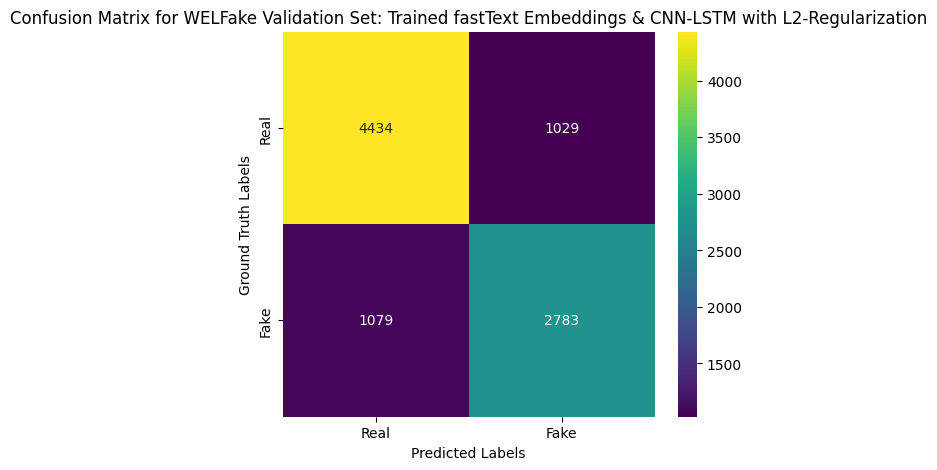

{'Real': {'precision': 0.8042807908579721,
  'recall': 0.8116419549697969,
  'f1-score': 0.8079446064139941,
  'support': 5463.0},
 'Fake': {'precision': 0.7300629590766002,
  'recall': 0.7206110823407561,
  'f1-score': 0.7253062288246026,
  'support': 3862.0},
 'accuracy': 0.773941018766756,
 'macro avg': {'precision': 0.7671718749672862,
  'recall': 0.7661265186552765,
  'f1-score': 0.7666254176192984,
  'support': 9325.0},
 'weighted avg': {'precision': 0.7735430679261053,
  'recall': 0.773941018766756,
  'f1-score': 0.7737194681565968,
  'support': 9325.0}}

In [45]:
evaluateCNN_LSTMModel(
    wf_model_l2_reg,
    wf_X_val,
    wf_X_val_extra_scaled,
    wf_y_val, 
    "WELFake Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

Model Evaluation:
Accuracy: 0.7784
Macro-Precision: 0.7646
Macro-Recall: 0.7671
Macro-F1 Score: 0.7658


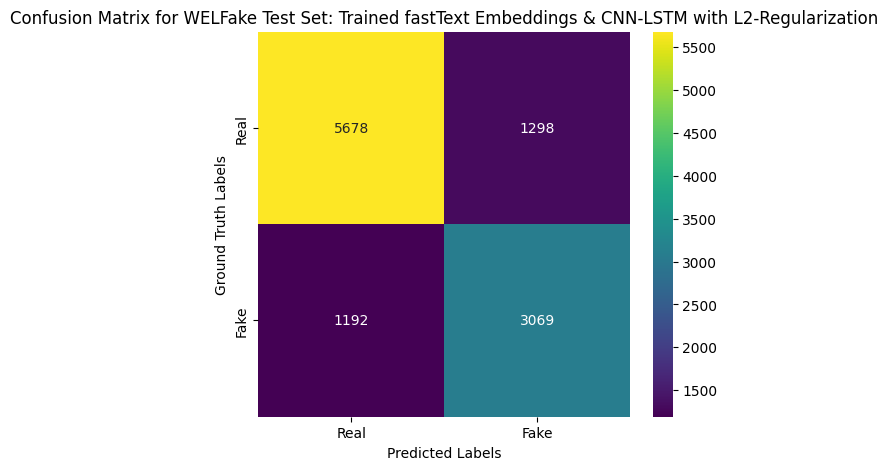

{'Real': {'precision': 0.8264919941775837,
  'recall': 0.8139334862385321,
  'f1-score': 0.8201646684963166,
  'support': 6976.0},
 'Fake': {'precision': 0.7027707808564232,
  'recall': 0.7202534616287256,
  'f1-score': 0.7114047287899861,
  'support': 4261.0},
 'accuracy': 0.7784106078134734,
 'macro avg': {'precision': 0.7646313875170034,
  'recall': 0.7670934739336288,
  'f1-score': 0.7657846986431514,
  'support': 11237.0},
 'weighted avg': {'precision': 0.7795776852017481,
  'recall': 0.7784106078134734,
  'f1-score': 0.7789235807425857,
  'support': 11237.0}}

In [46]:
evaluateCNN_LSTMModel(
    wf_model_l2_reg,
    wf_X_test,
    wf_X_test_extra_scaled,
    wf_y_test,
    "WELFake Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

In [56]:
wf_model_l1_reg, wf_history_l1_reg = trainCNN_LSTMWithL1Regularization(wf_X_train, wf_X_train_extra_scaled, wf_y_train)

Embedding (fastText) input dimensions: (1000, 140)
Extra features dimensions: 10
Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 58s 110ms/step - accuracy: 0.6143 - f1_score: 0.5877 - loss: 10.7589 - val_accuracy: 0.6953 - val_f1_score: 0.6818 - val_loss: 0.6791
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.6811 - f1_score: 0.6750 - loss: 0.6830 - val_accuracy: 0.7135 - val_f1_score: 0.7013 - val_loss: 0.6521
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - accuracy: 0.7040 - f1_score: 0.6991 - loss: 0.6582 - val_accuracy: 0.7240 - val_f1_score: 0.7101 - val_loss: 0.6341
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.7160 - f1_score: 0.7116 - loss: 0.6472 - val_accuracy: 0.7345 - val_f1_score: 0.7239 - val_loss: 0.6261
Epoch 5/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.7237 - f1_score: 0.7199 - loss: 0.6388 - val_accuracy: 0.7435 - val_f1_score: 0.7329 - val_loss: 0.6176
Epoch 6/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step 

292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Model Evaluation:
Accuracy: 0.7745
Macro-Precision: 0.7676
Macro-Recall: 0.7680
Macro-F1 Score: 0.7678


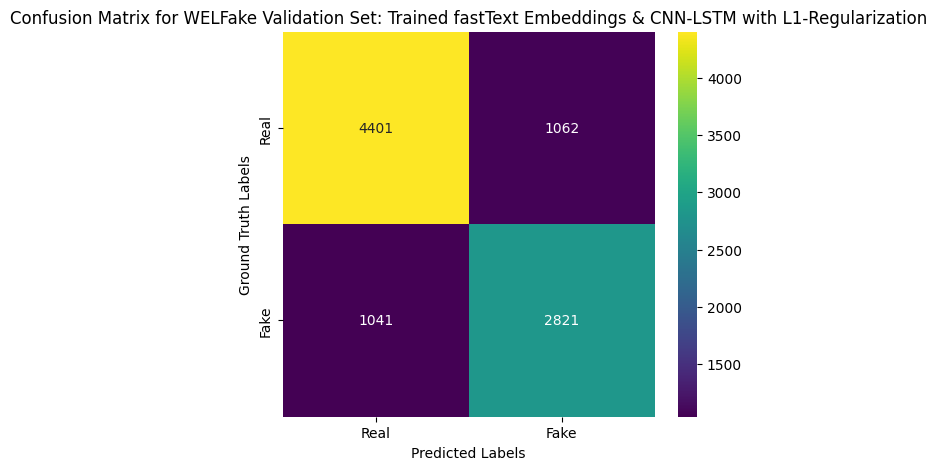

{'Real': {'precision': 0.8087100330760749,
  'recall': 0.8056013179571664,
  'f1-score': 0.8071526822558459,
  'support': 5463.0},
 'Fake': {'precision': 0.7265001287664177,
  'recall': 0.73045054375971,
  'f1-score': 0.7284699806326662,
  'support': 3862.0},
 'accuracy': 0.7744772117962466,
 'macro avg': {'precision': 0.7676050809212462,
  'recall': 0.7680259308584382,
  'f1-score': 0.7678113314442561,
  'support': 9325.0},
 'weighted avg': {'precision': 0.7746623493823594,
  'recall': 0.7744772117962466,
  'f1-score': 0.7745658089401655,
  'support': 9325.0}}

In [57]:
evaluateCNN_LSTMModel(
    wf_model_l1_reg,
    wf_X_val,
    wf_X_val_extra_scaled,
    wf_y_val, 
    "WELFake Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

Model Evaluation:
Accuracy: 0.7795
Macro-Precision: 0.7659
Macro-Recall: 0.7702
Macro-F1 Score: 0.7678


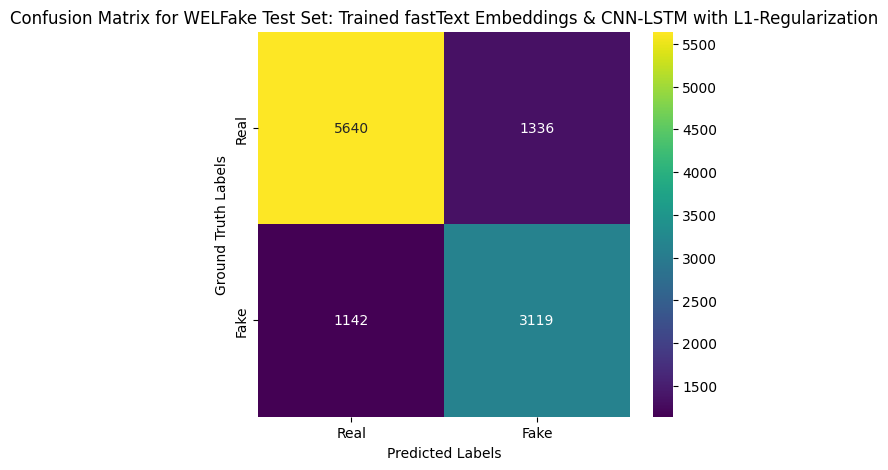

{'Real': {'precision': 0.8316130934827485,
  'recall': 0.8084862385321101,
  'f1-score': 0.8198866114260793,
  'support': 6976.0},
 'Fake': {'precision': 0.7001122334455668,
  'recall': 0.7319877962919502,
  'f1-score': 0.7156952730610372,
  'support': 4261.0},
 'accuracy': 0.7794785084987096,
 'macro avg': {'precision': 0.7658626634641577,
  'recall': 0.7702370174120301,
  'f1-score': 0.7677909422435583,
  'support': 11237.0},
 'weighted avg': {'precision': 0.7817487912118193,
  'recall': 0.7794785084987096,
  'f1-score': 0.7803779086785982,
  'support': 11237.0}}

In [58]:
evaluateCNN_LSTMModel(
    wf_model_l1_reg,
    wf_X_test,
    wf_X_test_extra_scaled,
    wf_y_test,
    "WELFake Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

#### CNN-LSTM without Regularization

In [69]:
wf_model_no_reg, wf_history_no_reg = trainCNN_LSTMWithoutRegularization(wf_X_train, wf_X_train_extra_scaled, wf_y_train)

Embedding (fastText) input dimensions: (1000, 140)
Extra features dimensions: 10
Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 56s 104ms/step - accuracy: 0.7170 - f1_score: 0.6991 - loss: 0.5397 - val_accuracy: 0.6718 - val_f1_score: 0.6537 - val_loss: 0.6703
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.6195 - f1_score: 0.6100 - loss: 0.6558 - val_accuracy: 0.7064 - val_f1_score: 0.6711 - val_loss: 0.5777
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9057 - f1_score: 0.9050 - loss: 0.2517 - val_accuracy: 0.9625 - val_f1_score: 0.9614 - val_loss: 0.1051
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9653 - f1_score: 0.9652 - loss: 0.1001 - val_accuracy: 0.9705 - val_f1_score: 0.9699 - val_loss: 0.0818
Epoch 5/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.9682 - f1_score: 0.9681 - loss: 0.0862 - val_accuracy: 0.9712 - val_f1_score: 0.9706 - val_loss: 0.0773
Epoch 6/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - ac

292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Model Evaluation:
Accuracy: 0.9659
Macro-Precision: 0.9636
Macro-Recall: 0.9665
Macro-F1 Score: 0.9650


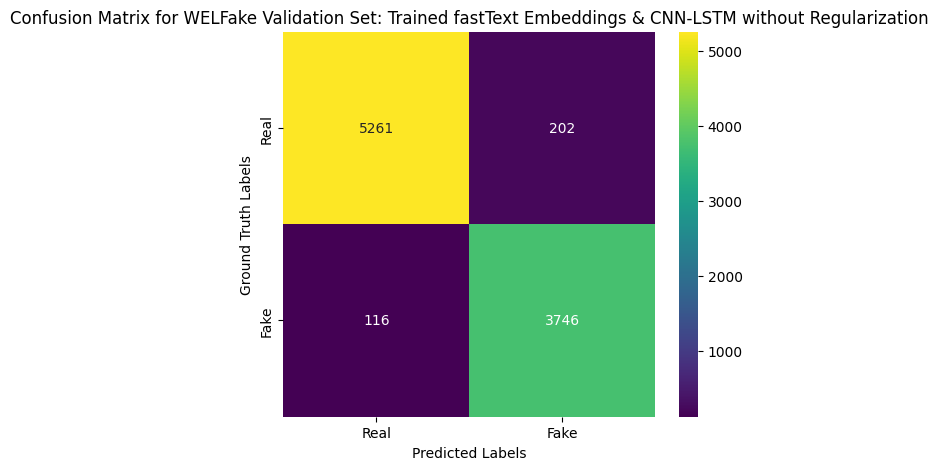

{'Real': {'precision': 0.978426631950902,
  'recall': 0.9630239794984441,
  'f1-score': 0.9706642066420664,
  'support': 5463.0},
 'Fake': {'precision': 0.9488348530901722,
  'recall': 0.969963749352667,
  'f1-score': 0.9592829705505762,
  'support': 3862.0},
 'accuracy': 0.9658981233243967,
 'macro avg': {'precision': 0.963630742520537,
  'recall': 0.9664938644255556,
  'f1-score': 0.9649735885963213,
  'support': 9325.0},
 'weighted avg': {'precision': 0.9661710340999489,
  'recall': 0.9658981233243967,
  'f1-score': 0.9659506051637463,
  'support': 9325.0}}

In [70]:
evaluateCNN_LSTMModel(
    wf_model_no_reg,
    wf_X_val,
    wf_X_val_extra_scaled,
    wf_y_val, 
    "WELFake Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

Model Evaluation:
Accuracy: 0.9652
Macro-Precision: 0.9605
Macro-Recall: 0.9664
Macro-F1 Score: 0.9633


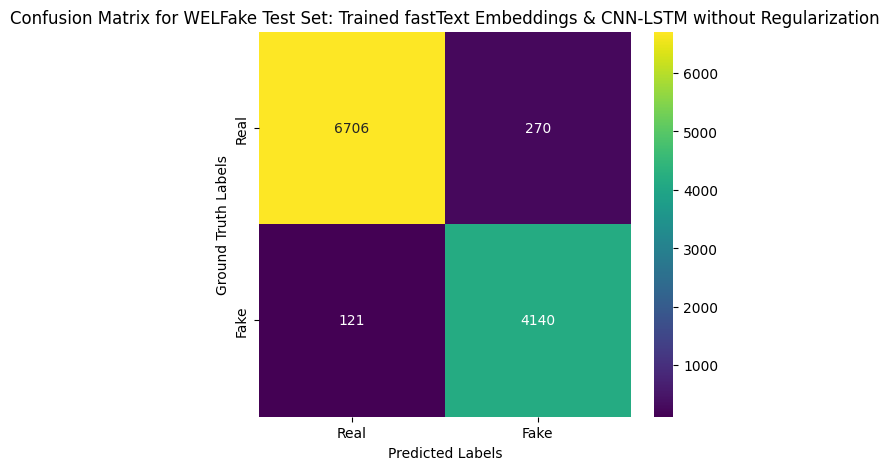

{'Real': {'precision': 0.9822762560421855,
  'recall': 0.961295871559633,
  'f1-score': 0.9716728247482431,
  'support': 6976.0},
 'Fake': {'precision': 0.9387755102040817,
  'recall': 0.9716029101149964,
  'f1-score': 0.9549071618037135,
  'support': 4261.0},
 'accuracy': 0.9652042360060514,
 'macro avg': {'precision': 0.9605258831231336,
  'recall': 0.9664493908373147,
  'f1-score': 0.9632899932759783,
  'support': 11237.0},
 'weighted avg': {'precision': 0.965781045753304,
  'recall': 0.9652042360060514,
  'f1-score': 0.9653153903968468,
  'support': 11237.0}}

In [71]:
evaluateCNN_LSTMModel(
    wf_model_no_reg,
    wf_X_test,
    wf_X_test_extra_scaled,
    wf_y_test,
    "WELFake Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

In [78]:
wf_model_no_reg_mh_att, wf_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(wf_X_train, wf_X_train_extra_scaled, wf_y_train)

Embedding (fastText) input dimensions: (1000, 140)
Extra features dimensions: 10
Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - accuracy: 0.9020 - f1_score: 0.9017 - loss: 0.2337 - val_accuracy: 0.9424 - val_f1_score: 0.9403 - val_loss: 0.1808
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 69s 133ms/step - accuracy: 0.9593 - f1_score: 0.9593 - loss: 0.1236 - val_accuracy: 0.9598 - val_f1_score: 0.9586 - val_loss: 0.1071
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 68s 131ms/step - accuracy: 0.9670 - f1_score: 0.9669 - loss: 0.0999 - val_accuracy: 0.9706 - val_f1_score: 0.9699 - val_loss: 0.0867
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 70s 134ms/step - accuracy: 0.9667 - f1_score: 0.9666 - loss: 0.0954 - val_accuracy: 0.9687 - val_f1_score: 0.9679 - val_loss: 0.0886
Epoch 5/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 71s 136ms/step - accuracy: 0.9694 - f1_score: 0.9693 - loss: 0.0875 - val_accuracy: 0.9633 - val_f1_score: 0.9623 - val_loss: 0.1069
Epoch 6/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 71s 136ms/step

292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step

Model Evaluation:
Accuracy: 0.9596
Macro-Precision: 0.9598
Macro-Recall: 0.9568
Macro-F1 Score: 0.9582


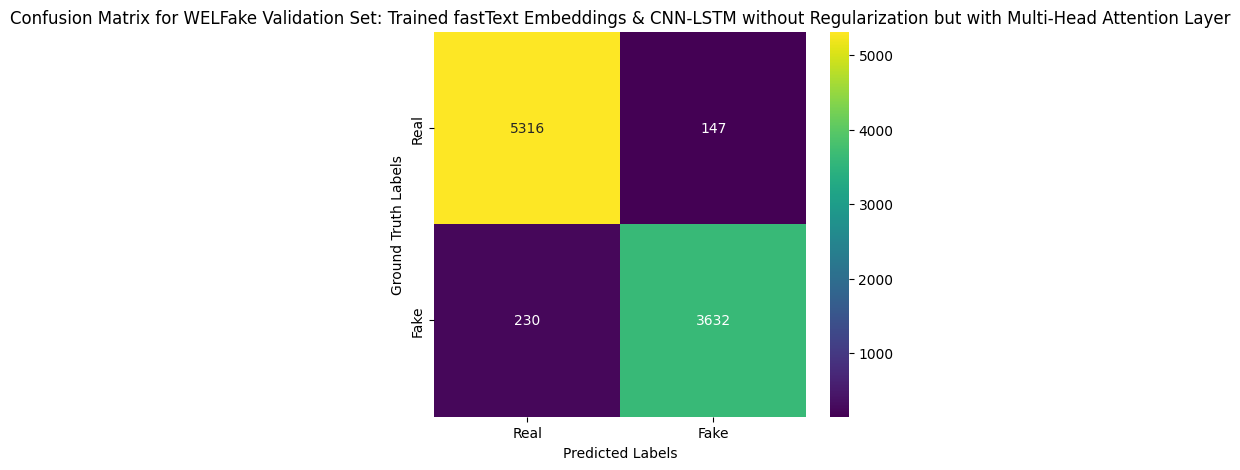

{'Real': {'precision': 0.9585286693112153,
  'recall': 0.9730917078528282,
  'f1-score': 0.9657552911254428,
  'support': 5463.0},
 'Fake': {'precision': 0.9611008203228367,
  'recall': 0.9404453650958052,
  'f1-score': 0.9506609082580814,
  'support': 3862.0},
 'accuracy': 0.9595710455764075,
 'macro avg': {'precision': 0.959814744817026,
  'recall': 0.9567685364743167,
  'f1-score': 0.9582080996917621,
  'support': 9325.0},
 'weighted avg': {'precision': 0.9595939397891652,
  'recall': 0.9595710455764075,
  'f1-score': 0.9595038695025205,
  'support': 9325.0}}

In [79]:
evaluateCNN_LSTMModel(
    wf_model_no_reg_mh_att,
    wf_X_val,
    wf_X_val_extra_scaled,
    wf_y_val, 
    "WELFake Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step

Model Evaluation:
Accuracy: 0.9617
Macro-Precision: 0.9601
Macro-Recall: 0.9585
Macro-F1 Score: 0.9593


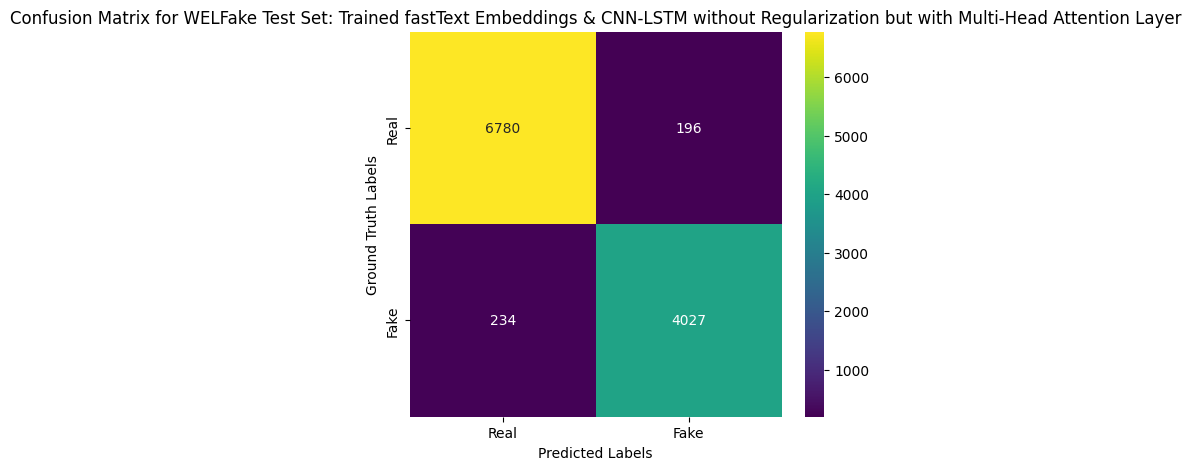

{'Real': {'precision': 0.9666381522668948,
  'recall': 0.9719036697247706,
  'f1-score': 0.9692637598284489,
  'support': 6976.0},
 'Fake': {'precision': 0.953587497040019,
  'recall': 0.9450833137761089,
  'f1-score': 0.9493163602074494,
  'support': 4261.0},
 'accuracy': 0.9617335587790335,
 'macro avg': {'precision': 0.9601128246534569,
  'recall': 0.9584934917504397,
  'f1-score': 0.9592900600179491,
  'support': 11237.0},
 'weighted avg': {'precision': 0.961689425567445,
  'recall': 0.9617335587790335,
  'f1-score': 0.9616998308629707,
  'support': 11237.0}}

In [80]:
evaluateCNN_LSTMModel(
    wf_model_no_reg_mh_att,
    wf_X_test,
    wf_X_test_extra_scaled,
    wf_y_test, 
    "WELFake Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### Fakeddit

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (25, 46)
Extra features dimensions: 10
Epoch 1/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.6496 - f1_score: 0.6217 - loss: 0.7195 - val_accuracy: 0.6674 - val_f1_score: 0.6471 - val_loss: 0.6117
Epoch 2/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6661 - f1_score: 0.6453 - loss: 0.6124 - val_accuracy: 0.6711 - val_f1_score: 0.6542 - val_loss: 0.6085
Epoch 3/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6702 - f1_score: 0.6513 - loss: 0.6088 - val_accuracy: 0.6733 - val_f1_score: 0.6573 - val_loss: 0.6065
Epoch 4/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6723 - f1_score: 0.6540 - loss: 0.6068 - val_accuracy: 0.6757 - val_f1_score: 0.6576 - val_loss: 0.6043
Epoch 5/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6741 - f1_score: 0.6563 - loss: 0.6051 - val_accuracy: 0.6768 - val_f1_score: 0.6609 - val_loss: 0.6024
Epoch 6/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - 

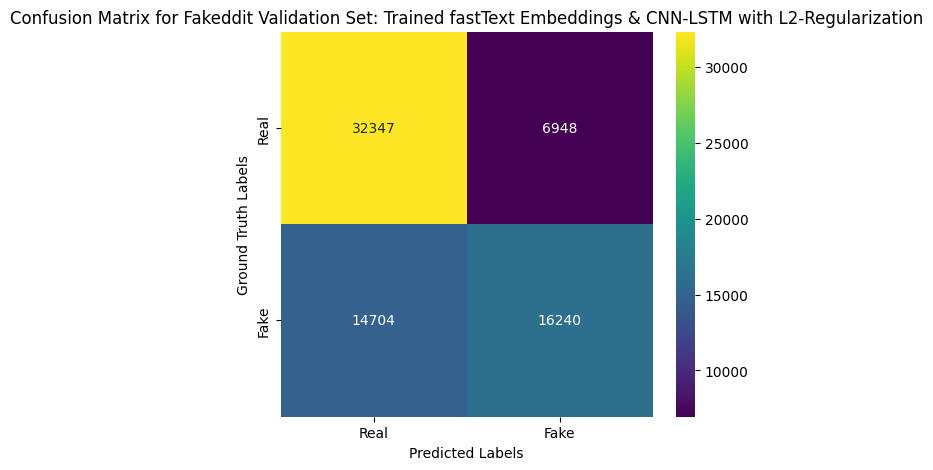

2220/2220 ━━━━━━━━━━━━━━━━━━━━ 2s 703us/step

Model Evaluation:
Accuracy: 0.6902
Macro-Precision: 0.6915
Macro-Recall: 0.6716
Macro-F1 Score: 0.6723


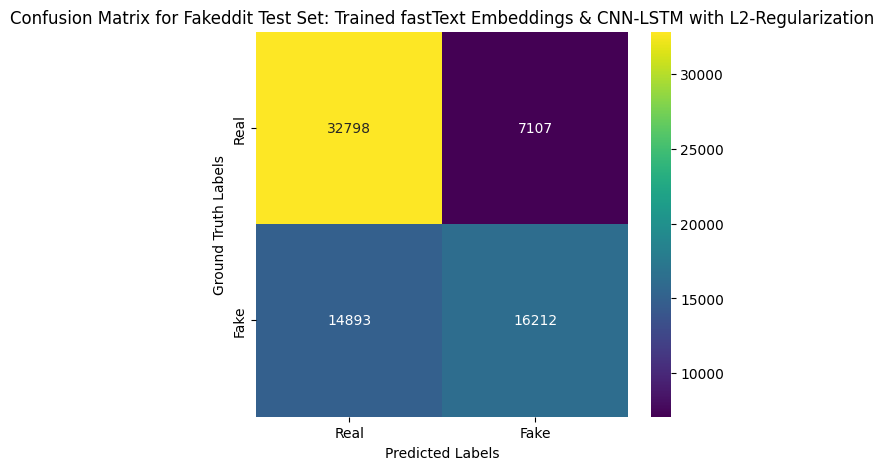

{'Real': {'precision': 0.6877188568073641,
  'recall': 0.8219020172910663,
  'f1-score': 0.7488469793141239,
  'support': 39905.0},
 'Fake': {'precision': 0.6952270680560916,
  'recall': 0.5212023790387398,
  'f1-score': 0.5957665735704836,
  'support': 31105.0},
 'accuracy': 0.6901844810590058,
 'macro avg': {'precision': 0.6914729624317278,
  'recall': 0.6715521981649031,
  'f1-score': 0.6723067764423037,
  'support': 71010.0},
 'weighted avg': {'precision': 0.6910077303588592,
  'recall': 0.6901844810590058,
  'f1-score': 0.6817921135113365,
  'support': 71010.0}}

In [16]:
fe_model_l2_reg, fe_history_l2_reg = trainCNN_LSTMWithL2Regularization(fe_X_train, fe_X_train_extra_scaled, fe_y_train)

evaluateCNN_LSTMModel(
    fe_model_l2_reg,
    fe_X_val,
    fe_X_val_extra_scaled,
    fe_y_val, 
    "Fakeddit Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    fe_model_l2_reg,
    fe_X_test,
    fe_X_test_extra_scaled,
    fe_y_test,
    "Fakeddit Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (25, 46)
Extra features dimensions: 10
Epoch 1/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6497 - f1_score: 0.6217 - loss: 1.7307 - val_accuracy: 0.6669 - val_f1_score: 0.6481 - val_loss: 0.6659
Epoch 2/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6662 - f1_score: 0.6454 - loss: 0.6664 - val_accuracy: 0.6685 - val_f1_score: 0.6525 - val_loss: 0.6622
Epoch 3/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6696 - f1_score: 0.6502 - loss: 0.6625 - val_accuracy: 0.6741 - val_f1_score: 0.6550 - val_loss: 0.6591
Epoch 4/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6731 - f1_score: 0.6543 - loss: 0.6599 - val_accuracy: 0.6763 - val_f1_score: 0.6590 - val_loss: 0.6575
Epoch 5/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6740 - f1_score: 0.6558 - loss: 0.6583 - val_accuracy: 0.6779 - val_f1_score: 0.6627 - val_loss: 0.6559
Epoch 6/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - 

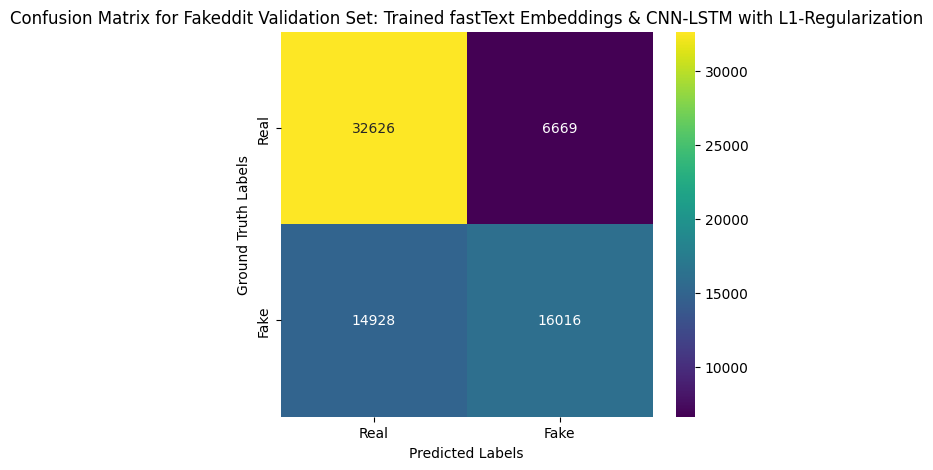

2220/2220 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step

Model Evaluation:
Accuracy: 0.6906
Macro-Precision: 0.6933
Macro-Recall: 0.6710
Macro-F1 Score: 0.6715


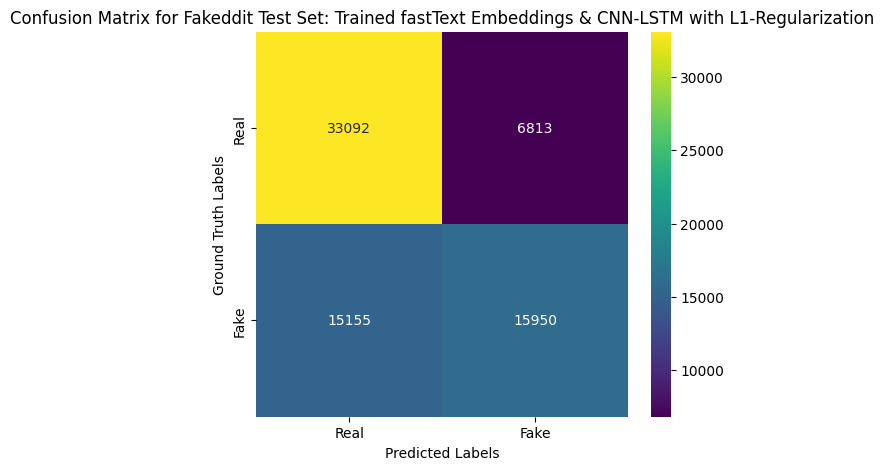

{'Real': {'precision': 0.6858872054220988,
  'recall': 0.8292695150983586,
  'f1-score': 0.7507940829476359,
  'support': 39905.0},
 'Fake': {'precision': 0.7006985019549269,
  'recall': 0.5127792959331298,
  'f1-score': 0.5921883121704908,
  'support': 31105.0},
 'accuracy': 0.690635121813829,
 'macro avg': {'precision': 0.6932928536885128,
  'recall': 0.6710244055157442,
  'f1-score': 0.6714911975590634,
  'support': 71010.0},
 'weighted avg': {'precision': 0.6923750997842114,
  'recall': 0.690635121813829,
  'f1-score': 0.6813189033951349,
  'support': 71010.0}}

In [18]:
fe_model_l1_reg, fe_history_l1_reg = trainCNN_LSTMWithL1Regularization(fe_X_train, fe_X_train_extra_scaled, fe_y_train)

evaluateCNN_LSTMModel(
    fe_model_l1_reg,
    fe_X_val,
    fe_X_val_extra_scaled,
    fe_y_val, 
    "Fakeddit Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    fe_model_l1_reg,
    fe_X_test,
    fe_X_test_extra_scaled,
    fe_y_test,
    "Fakeddit Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (25, 46)
Extra features dimensions: 10
Epoch 1/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8447 - f1_score: 0.8414 - loss: 0.3534 - val_accuracy: 0.8548 - val_f1_score: 0.8535 - val_loss: 0.3350
Epoch 2/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8570 - f1_score: 0.8547 - loss: 0.3309 - val_accuracy: 0.8548 - val_f1_score: 0.8538 - val_loss: 0.3339
Epoch 3/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8590 - f1_score: 0.8567 - loss: 0.3264 - val_accuracy: 0.8577 - val_f1_score: 0.8564 - val_loss: 0.3296
Epoch 4/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8608 - f1_score: 0.8586 - loss: 0.3236 - val_accuracy: 0.8573 - val_f1_score: 0.8561 - val_loss: 0.3307
Epoch 5/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8615 - f1_score: 0.8593 - loss: 0.3215 - val_accuracy: 0.8585 - val_f1_score: 0.8572 - val_loss: 0.3300
Epoch 6/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - 

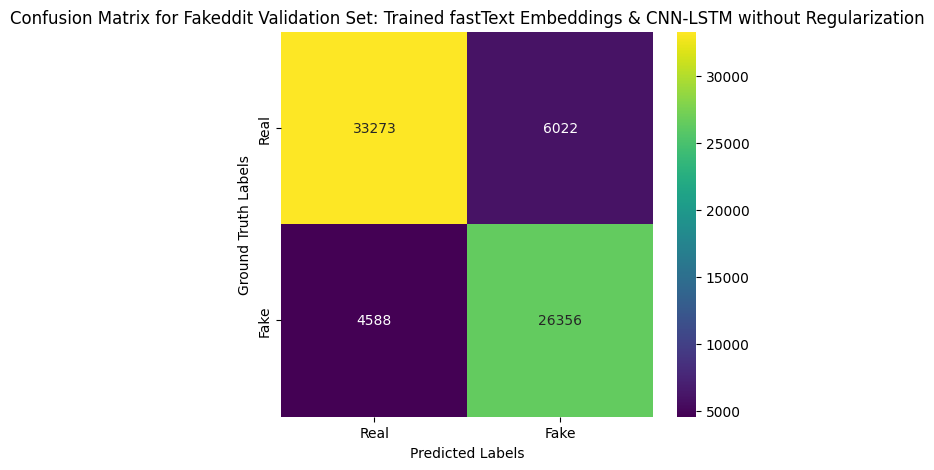

2220/2220 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step

Model Evaluation:
Accuracy: 0.8482
Macro-Precision: 0.8454
Macro-Recall: 0.8486
Macro-F1 Score: 0.8466


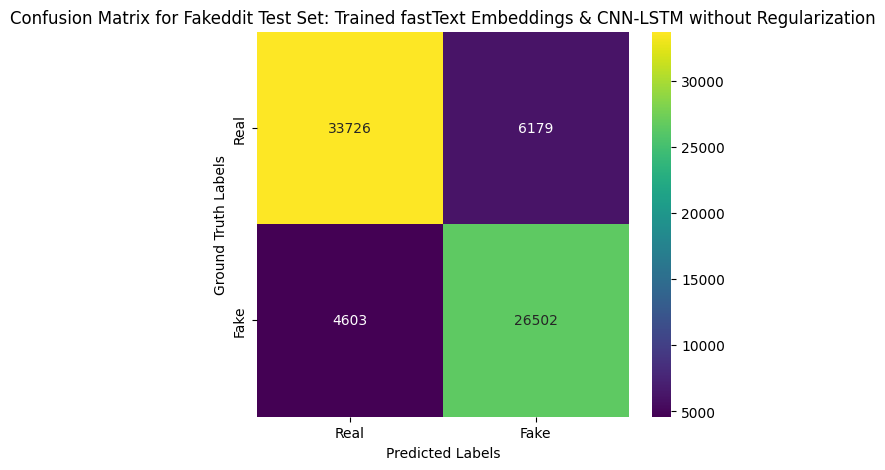

{'Real': {'precision': 0.8799081635315297,
  'recall': 0.8451572484651046,
  'f1-score': 0.8621826827210676,
  'support': 39905.0},
 'Fake': {'precision': 0.8109298981059331,
  'recall': 0.8520173605529657,
  'f1-score': 0.8309660427052958,
  'support': 31105.0},
 'accuracy': 0.8481622306717364,
 'macro avg': {'precision': 0.8454190308187314,
  'recall': 0.8485873045090352,
  'f1-score': 0.8465743627131816,
  'support': 71010.0},
 'weighted avg': {'precision': 0.8496931382384276,
  'recall': 0.8481622306717364,
  'f1-score': 0.8485086426183979,
  'support': 71010.0}}

In [26]:
fe_model_no_reg, fe_history_no_reg = trainCNN_LSTMWithoutRegularization(fe_X_train, fe_X_train_extra_scaled, fe_y_train)

evaluateCNN_LSTMModel(
    fe_model_no_reg,
    fe_X_val,
    fe_X_val_extra_scaled,
    fe_y_val, 
    "Fakeddit Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    fe_model_no_reg,
    fe_X_test,
    fe_X_test_extra_scaled,
    fe_y_test,
    "Fakeddit Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (25, 46)
Extra features dimensions: 10
Epoch 1/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.8436 - f1_score: 0.8405 - loss: 0.3651 - val_accuracy: 0.8511 - val_f1_score: 0.8503 - val_loss: 0.3403
Epoch 2/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8559 - f1_score: 0.8538 - loss: 0.3416 - val_accuracy: 0.8548 - val_f1_score: 0.8538 - val_loss: 0.3325
Epoch 3/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8577 - f1_score: 0.8555 - loss: 0.3373 - val_accuracy: 0.8566 - val_f1_score: 0.8555 - val_loss: 0.3325
Epoch 4/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8593 - f1_score: 0.8571 - loss: 0.3350 - val_accuracy: 0.8564 - val_f1_score: 0.8553 - val_loss: 0.3315
Epoch 5/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8597 - f1_score: 0.8576 - loss: 0.3327 - val_accuracy: 0.8572 - val_f1_score: 0.8561 - val_loss: 0.3320
Epoch 6/20
8094/8094 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - 

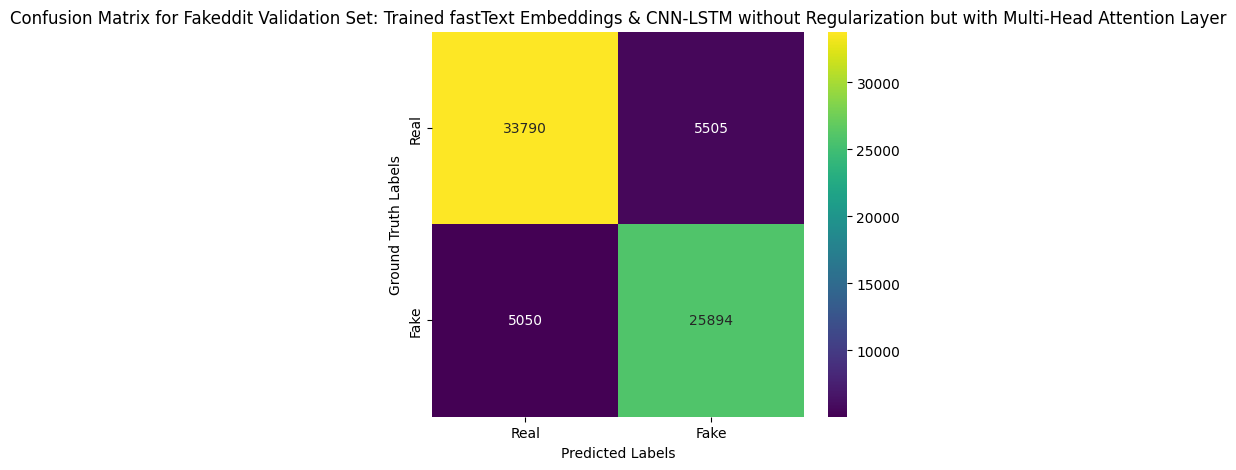

2220/2220 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step

Model Evaluation:
Accuracy: 0.8480
Macro-Precision: 0.8453
Macro-Recall: 0.8468
Macro-F1 Score: 0.8460


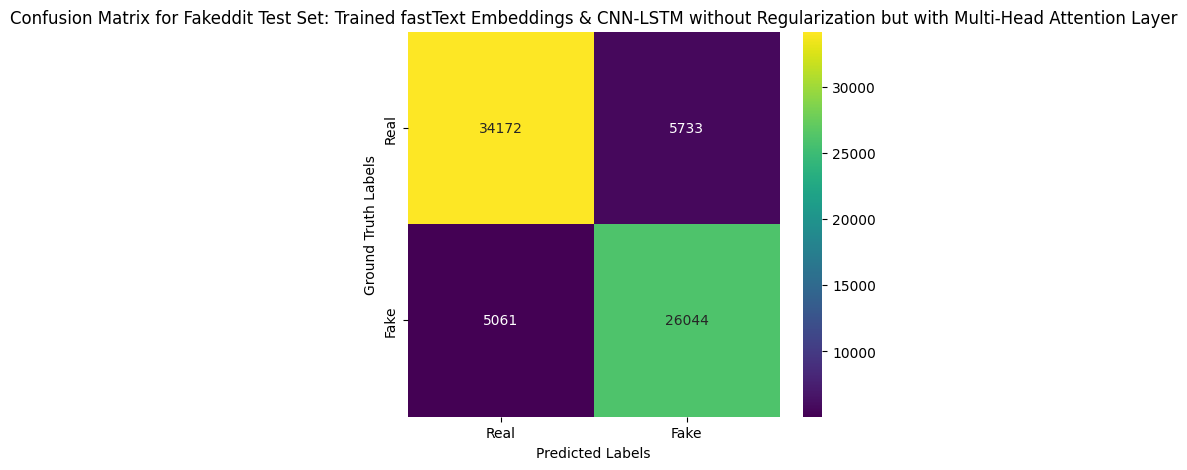

{'Real': {'precision': 0.8710014528585629,
  'recall': 0.8563337927577997,
  'f1-score': 0.8636053476206121,
  'support': 39905.0},
 'Fake': {'precision': 0.819586493375712,
  'recall': 0.8372930397042276,
  'f1-score': 0.8283451544162082,
  'support': 31105.0},
 'accuracy': 0.8479932403886776,
 'macro avg': {'precision': 0.8452939731171374,
  'recall': 0.8468134162310137,
  'f1-score': 0.8459752510184102,
  'support': 71010.0},
 'weighted avg': {'precision': 0.8484798035878394,
  'recall': 0.8479932403886776,
  'f1-score': 0.8481600820295266,
  'support': 71010.0}}

In [29]:
fe_model_no_reg_mh_att, fe_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(fe_X_train, fe_X_train_extra_scaled, fe_y_train)

evaluateCNN_LSTMModel(
    fe_model_no_reg_mh_att,
    fe_X_val,
    fe_X_val_extra_scaled,
    fe_y_val, 
    "Fakeddit Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    fe_model_no_reg_mh_att,
    fe_X_test,
    fe_X_test_extra_scaled,
    fe_y_test,
    "Fakeddit Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### Constraint

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (60, 10)
Extra features dimensions: 10
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7170 - f1_score: 0.6591 - loss: 2.3021 - val_accuracy: 0.9389 - val_f1_score: 0.9387 - val_loss: 0.7280
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9425 - f1_score: 0.9418 - loss: 0.5835 - val_accuracy: 0.9412 - val_f1_score: 0.9409 - val_loss: 0.3170
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9502 - f1_score: 0.9497 - loss: 0.2781 - val_accuracy: 0.9475 - val_f1_score: 0.9473 - val_loss: 0.2161
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9500 - f1_score: 0.9494 - loss: 0.2108 - val_accuracy: 0.9514 - val_f1_score: 0.9512 - val_loss: 0.1870
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9541 - f1_score: 0.9536 - loss: 0.1822 - val_accuracy: 0.9491 - val_f1_score: 0.9488 - val_loss: 0.1826
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9549 - f1_score: 0

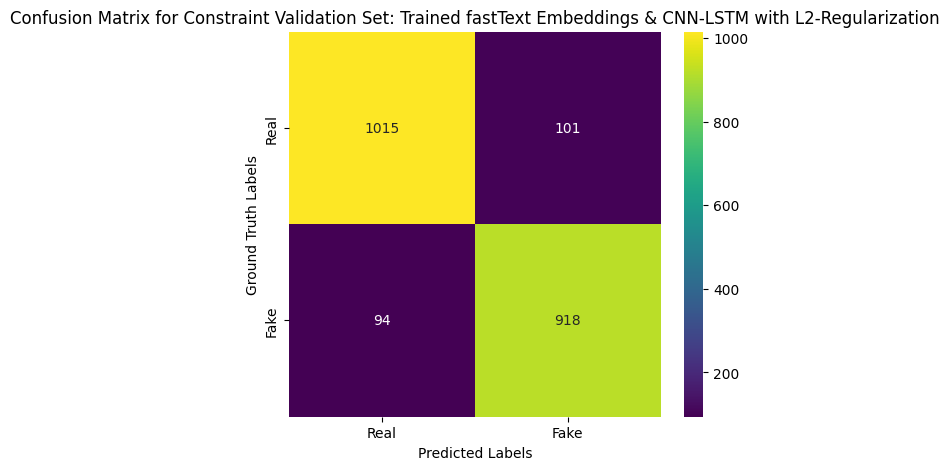

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation:
Accuracy: 0.9222
Macro-Precision: 0.9222
Macro-Recall: 0.9218
Macro-F1 Score: 0.9220


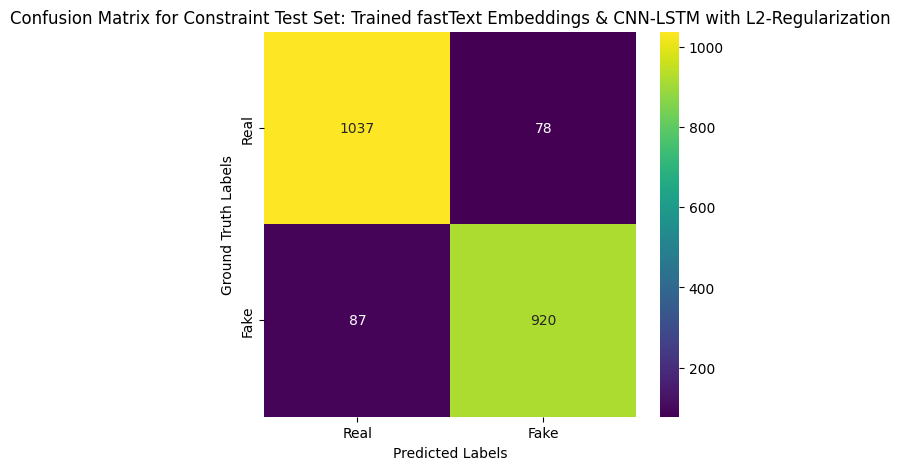

{'Real': {'precision': 0.9225978647686833,
  'recall': 0.9300448430493273,
  'f1-score': 0.9263063867798124,
  'support': 1115.0},
 'Fake': {'precision': 0.9218436873747495,
  'recall': 0.913604766633565,
  'f1-score': 0.9177057356608479,
  'support': 1007.0},
 'accuracy': 0.9222431668237512,
 'macro avg': {'precision': 0.9222207760717165,
  'recall': 0.9218248048414461,
  'f1-score': 0.9220060612203301,
  'support': 2122.0},
 'weighted avg': {'precision': 0.9222399681448891,
  'recall': 0.9222431668237512,
  'f1-score': 0.9222249279311803,
  'support': 2122.0}}

In [37]:
ct_model_l2_reg, ct_history_l2_reg = trainCNN_LSTMWithL2Regularization(ct_X_train, ct_X_train_extra_scaled, ct_y_train)

evaluateCNN_LSTMModel(
    ct_model_l2_reg,
    ct_X_val,
    ct_X_val_extra_scaled,
    ct_y_val, 
    "Constraint Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    ct_model_l2_reg,
    ct_X_test,
    ct_X_test_extra_scaled,
    ct_y_test,
    "Constraint Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (60, 10)
Extra features dimensions: 10
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6776 - f1_score: 0.6120 - loss: 19.6193 - val_accuracy: 0.9099 - val_f1_score: 0.9088 - val_loss: 6.0695
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9265 - f1_score: 0.9258 - loss: 3.9659 - val_accuracy: 0.9428 - val_f1_score: 0.9426 - val_loss: 0.7515
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9300 - f1_score: 0.9293 - loss: 0.6210 - val_accuracy: 0.9130 - val_f1_score: 0.9119 - val_loss: 0.4767
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9265 - f1_score: 0.9257 - loss: 0.4488 - val_accuracy: 0.9342 - val_f1_score: 0.9338 - val_loss: 0.3803
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9305 - f1_score: 0.9298 - loss: 0.3839 - val_accuracy: 0.9451 - val_f1_score: 0.9450 - val_loss: 0.3303
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9364 - f1_score: 

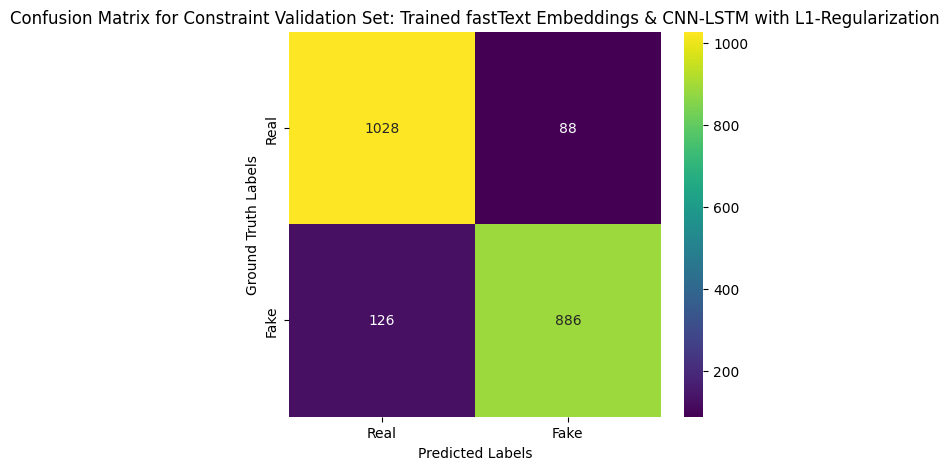

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation:
Accuracy: 0.9081
Macro-Precision: 0.9090
Macro-Recall: 0.9069
Macro-F1 Score: 0.9077


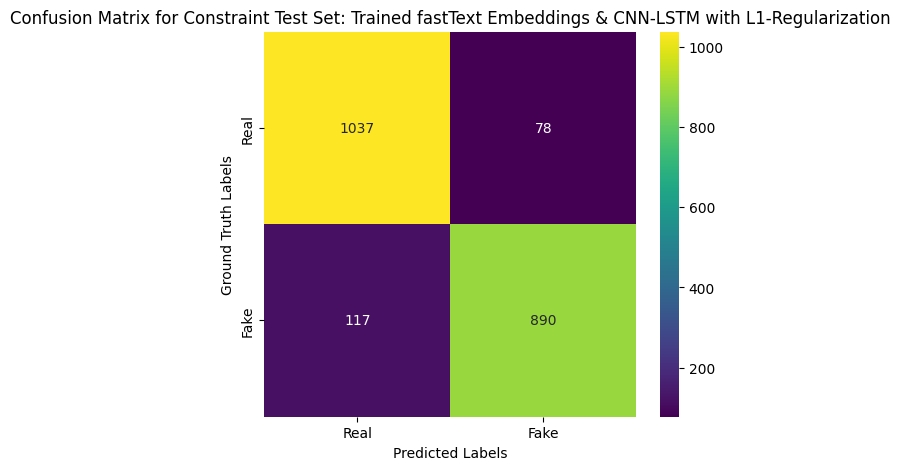

{'Real': {'precision': 0.8986135181975736,
  'recall': 0.9300448430493273,
  'f1-score': 0.9140590568532393,
  'support': 1115.0},
 'Fake': {'precision': 0.9194214876033058,
  'recall': 0.8838133068520357,
  'f1-score': 0.9012658227848102,
  'support': 1007.0},
 'accuracy': 0.9081055607917059,
 'macro avg': {'precision': 0.9090175029004397,
  'recall': 0.9069290749506815,
  'f1-score': 0.9076624398190247,
  'support': 2122.0},
 'weighted avg': {'precision': 0.9084879881276267,
  'recall': 0.9081055607917059,
  'f1-score': 0.907987998084668,
  'support': 2122.0}}

In [41]:
ct_model_l1_reg, ct_history_l1_reg = trainCNN_LSTMWithL1Regularization(ct_X_train, ct_X_train_extra_scaled, ct_y_train)

evaluateCNN_LSTMModel(
    ct_model_l1_reg,
    ct_X_val,
    ct_X_val_extra_scaled,
    ct_y_val, 
    "Constraint Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    ct_model_l1_reg,
    ct_X_test,
    ct_X_test_extra_scaled,
    ct_y_test,
    "Constraint Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

In [78]:
tf.keras.backend.clear_session(
    free_memory=True
)
gc.collect()

0

#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (60, 10)
Extra features dimensions: 10
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7756 - f1_score: 0.7351 - loss: 0.4371 - val_accuracy: 0.9365 - val_f1_score: 0.9362 - val_loss: 0.1673
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9473 - f1_score: 0.9467 - loss: 0.1449 - val_accuracy: 0.9467 - val_f1_score: 0.9465 - val_loss: 0.1335
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9621 - f1_score: 0.9618 - loss: 0.1208 - val_accuracy: 0.9608 - val_f1_score: 0.9607 - val_loss: 0.1116
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9612 - f1_score: 0.9608 - loss: 0.1046 - val_accuracy: 0.9639 - val_f1_score: 0.9639 - val_loss: 0.1010
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9642 - f1_score: 0.9639 - loss: 0.0960 - val_accuracy: 0.9655 - val_f1_score: 0.9655 - val_loss: 0.0964
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9681 - f1_score: 0

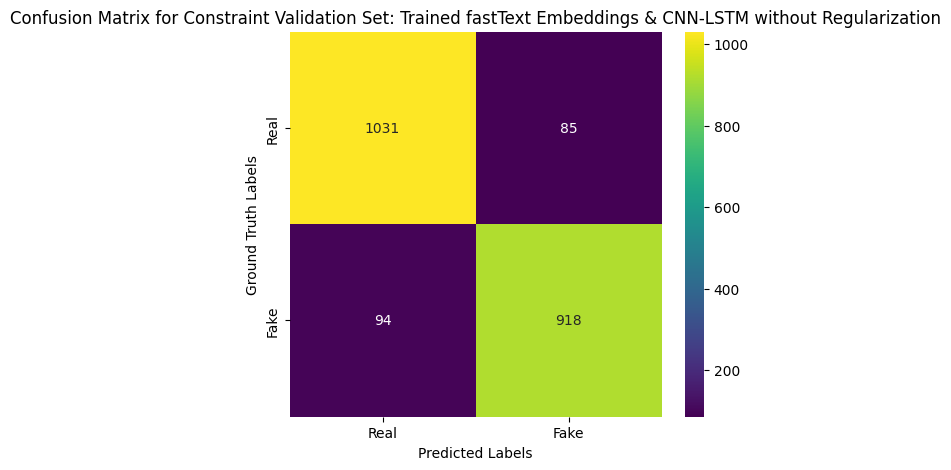

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Evaluation:
Accuracy: 0.9303
Macro-Precision: 0.9303
Macro-Recall: 0.9298
Macro-F1 Score: 0.9300


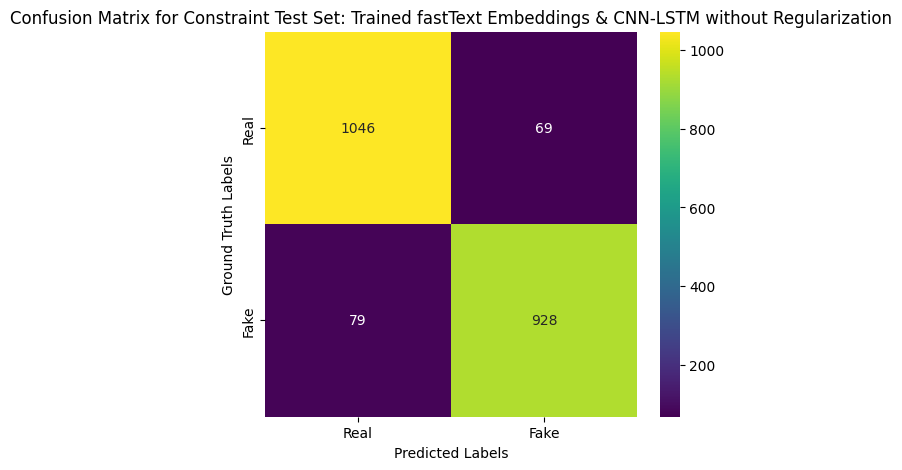

{'Real': {'precision': 0.9297777777777778,
  'recall': 0.9381165919282511,
  'f1-score': 0.9339285714285714,
  'support': 1115.0},
 'Fake': {'precision': 0.9307923771313942,
  'recall': 0.9215491559086395,
  'f1-score': 0.9261477045908184,
  'support': 1007.0},
 'accuracy': 0.9302544769085768,
 'macro avg': {'precision': 0.930285077454586,
  'recall': 0.9298328739184454,
  'f1-score': 0.9300381380096949,
  'support': 2122.0},
 'weighted avg': {'precision': 0.9302592582438907,
  'recall': 0.9302544769085768,
  'f1-score': 0.9302361431035868,
  'support': 2122.0}}

In [43]:
ct_model_no_reg, ct_history_no_reg = trainCNN_LSTMWithoutRegularization(ct_X_train, ct_X_train_extra_scaled, ct_y_train)

evaluateCNN_LSTMModel(
    ct_model_no_reg,
    ct_X_val,
    ct_X_val_extra_scaled,
    ct_y_val, 
    "Constraint Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    ct_model_no_reg,
    ct_X_test,
    ct_X_test_extra_scaled,
    ct_y_test,
    "Constraint Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (60, 10)
Extra features dimensions: 10
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7054 - f1_score: 0.6902 - loss: 0.4914 - val_accuracy: 0.9412 - val_f1_score: 0.9410 - val_loss: 0.1516
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9505 - f1_score: 0.9500 - loss: 0.1501 - val_accuracy: 0.9498 - val_f1_score: 0.9497 - val_loss: 0.1304
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9563 - f1_score: 0.9559 - loss: 0.1265 - val_accuracy: 0.9592 - val_f1_score: 0.9592 - val_loss: 0.1224
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9631 - f1_score: 0.9627 - loss: 0.1100 - val_accuracy: 0.9647 - val_f1_score: 0.9647 - val_loss: 0.1059
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9655 - f1_score: 0.9652 - loss: 0.1006 - val_accuracy: 0.9663 - val_f1_score: 0.9663 - val_loss: 0.0972
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9681 - f1_score: 

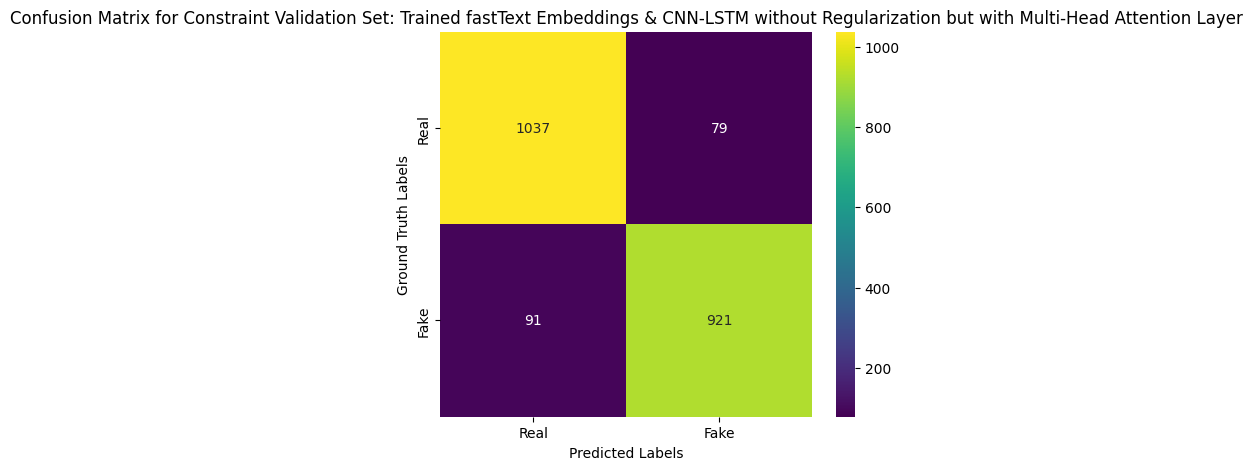

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model Evaluation:
Accuracy: 0.9312
Macro-Precision: 0.9312
Macro-Recall: 0.9308
Macro-F1 Score: 0.9310


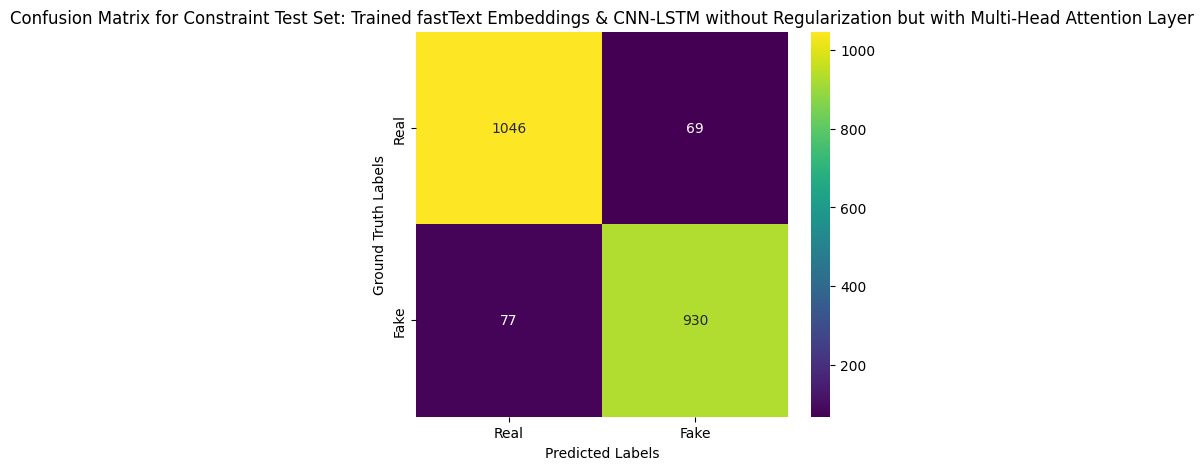

{'Real': {'precision': 0.931433659839715,
  'recall': 0.9381165919282511,
  'f1-score': 0.934763181411975,
  'support': 1115.0},
 'Fake': {'precision': 0.9309309309309309,
  'recall': 0.9235352532274081,
  'f1-score': 0.9272183449651047,
  'support': 1007.0},
 'accuracy': 0.9311969839773798,
 'macro avg': {'precision': 0.931182295385323,
  'recall': 0.9308259225778297,
  'f1-score': 0.9309907631885399,
  'support': 2122.0},
 'weighted avg': {'precision': 0.931195088675179,
  'recall': 0.9311969839773798,
  'f1-score': 0.9311827618540116,
  'support': 2122.0}}

In [45]:
ct_model_no_reg_mt_att, ct_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(ct_X_train, ct_X_train_extra_scaled, ct_y_train)

evaluateCNN_LSTMModel(
    ct_model_no_reg_mt_att,
    ct_X_val,
    ct_X_val_extra_scaled,
    ct_y_val, 
    "Constraint Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    ct_model_no_reg_mt_att,
    ct_X_test,
    ct_X_test_extra_scaled,
    ct_y_test,
    "Constraint Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### PolitiFact

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (2000, 11)
Extra features dimensions: 10
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5394 - f1_score: 0.3994 - loss: 3.1367 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 2.9214
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5507 - f1_score: 0.4092 - loss: 2.8401 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 2.6522
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.6023 - f1_score: 0.5164 - loss: 2.5742 - val_accuracy: 0.4432 - val_f1_score: 0.3071 - val_loss: 2.4031
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5914 - f1_score: 0.5126 - loss: 2.3316 - val_accuracy: 0.5114 - val_f1_score: 0.4421 - val_loss: 2.1655
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6128 - f1_score: 0.5513 - loss: 2.1452 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 2.5707
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5455 - f1_score:

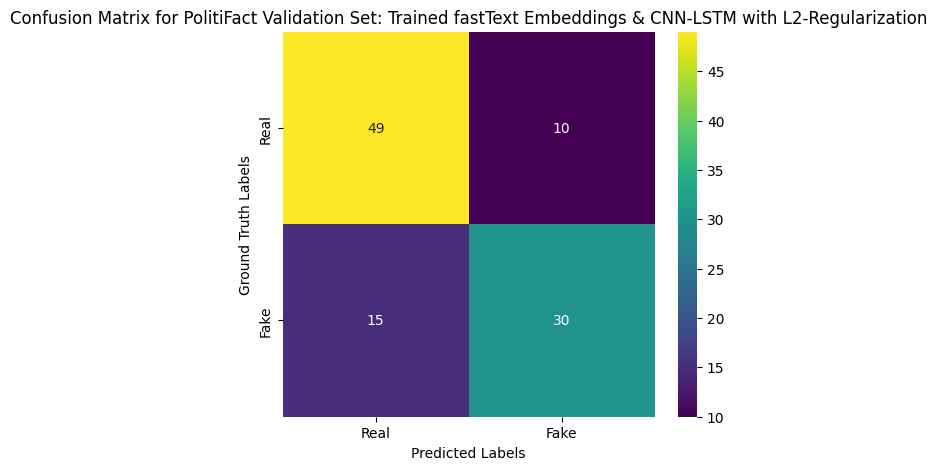

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Model Evaluation:
Accuracy: 0.6270
Macro-Precision: 0.6704
Macro-Recall: 0.6344
Macro-F1 Score: 0.6090


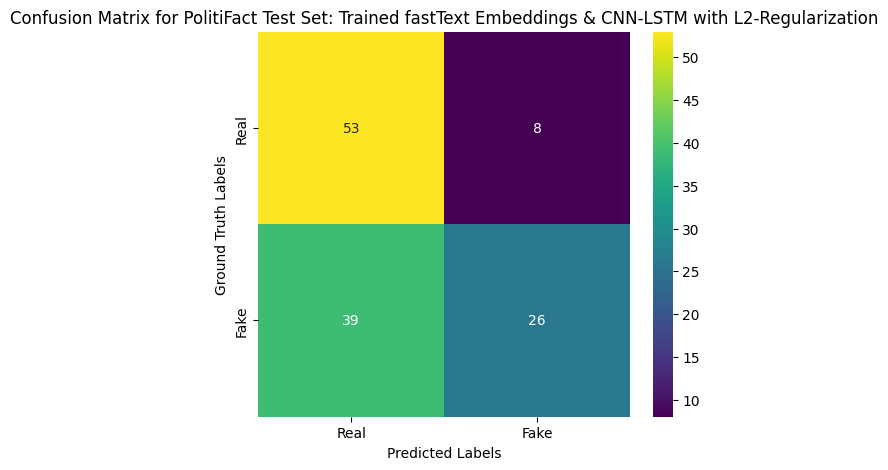

{'Real': {'precision': 0.5760869565217391,
  'recall': 0.8688524590163934,
  'f1-score': 0.6928104575163399,
  'support': 61.0},
 'Fake': {'precision': 0.7647058823529411,
  'recall': 0.4,
  'f1-score': 0.5252525252525253,
  'support': 65.0},
 'accuracy': 0.626984126984127,
 'macro avg': {'precision': 0.6703964194373402,
  'recall': 0.6344262295081967,
  'f1-score': 0.6090314913844326,
  'support': 126.0},
 'weighted avg': {'precision': 0.6733903706410099,
  'recall': 0.626984126984127,
  'f1-score': 0.6063718416659594,
  'support': 126.0}}

In [61]:
pf_model_l2_reg, pf_history_l2_reg = trainCNN_LSTMWithL2Regularization(pf_X_train, pf_X_train_extra_scaled, pf_y_train)

evaluateCNN_LSTMModel(
    pf_model_l2_reg,
    pf_X_val,
    pf_X_val_extra_scaled,
    pf_y_val, 
    "PolitiFact Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    pf_model_l2_reg,
    pf_X_test,
    pf_X_test_extra_scaled,
    pf_y_test,
    "PolitiFact Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (2000, 11)
Extra features dimensions: 10
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5394 - f1_score: 0.3994 - loss: 25.2702 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 23.7457
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.5466 - f1_score: 0.3972 - loss: 23.2921 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 21.8434
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6028 - f1_score: 0.5158 - loss: 21.4070 - val_accuracy: 0.4432 - val_f1_score: 0.3071 - val_loss: 20.0240
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.5870 - f1_score: 0.5003 - loss: 19.6088 - val_accuracy: 0.4545 - val_f1_score: 0.3295 - val_loss: 18.2829
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6227 - f1_score: 0.5428 - loss: 17.8866 - val_accuracy: 0.5795 - val_f1_score: 0.5590 - val_loss: 16.8121
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6894 -

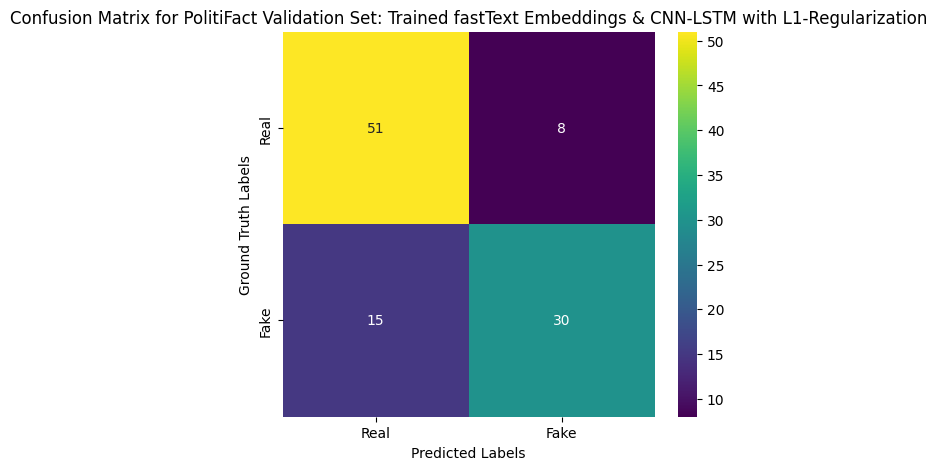

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Model Evaluation:
Accuracy: 0.6190
Macro-Precision: 0.6637
Macro-Recall: 0.6267
Macro-F1 Score: 0.5993


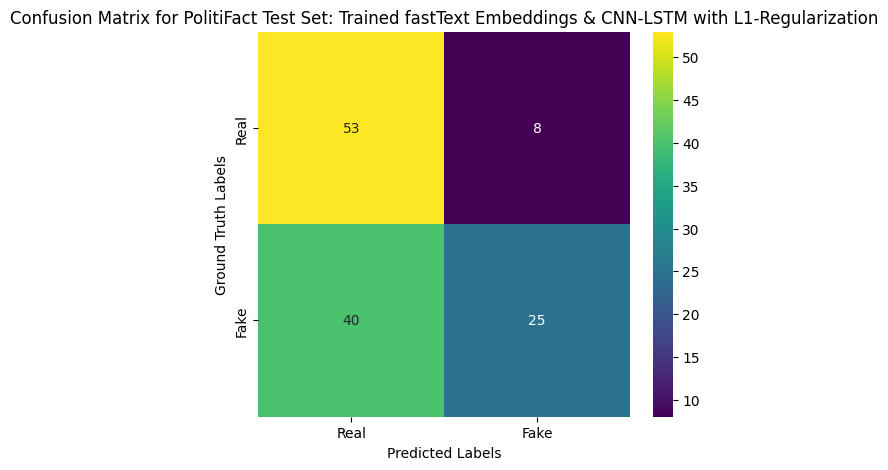

{'Real': {'precision': 0.5698924731182796,
  'recall': 0.8688524590163934,
  'f1-score': 0.6883116883116883,
  'support': 61.0},
 'Fake': {'precision': 0.7575757575757576,
  'recall': 0.38461538461538464,
  'f1-score': 0.5102040816326531,
  'support': 65.0},
 'accuracy': 0.6190476190476191,
 'macro avg': {'precision': 0.6637341153470186,
  'recall': 0.626733921815889,
  'f1-score': 0.5992578849721707,
  'support': 126.0},
 'weighted avg': {'precision': 0.6667132151003118,
  'recall': 0.6190476190476191,
  'f1-score': 0.5964307801042495,
  'support': 126.0}}

In [63]:
pf_model_l1_reg, pf_history_l1_reg = trainCNN_LSTMWithL1Regularization(pf_X_train, pf_X_train_extra_scaled, pf_y_train)

evaluateCNN_LSTMModel(
    pf_model_l1_reg,
    pf_X_val,
    pf_X_val_extra_scaled,
    pf_y_val, 
    "PolitiFact Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    pf_model_l1_reg,
    pf_X_test,
    pf_X_test_extra_scaled,
    pf_y_test,
    "PolitiFact Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (2000, 11)
Extra features dimensions: 10
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.5420 - f1_score: 0.4021 - loss: 0.6898 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 0.6889
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5481 - f1_score: 0.4096 - loss: 0.6641 - val_accuracy: 0.4432 - val_f1_score: 0.3071 - val_loss: 0.6625
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5990 - f1_score: 0.5421 - loss: 0.6408 - val_accuracy: 0.6250 - val_f1_score: 0.6226 - val_loss: 0.6367
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6345 - f1_score: 0.6325 - loss: 0.6328 - val_accuracy: 0.6932 - val_f1_score: 0.6613 - val_loss: 0.6248
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5680 - f1_score: 0.5660 - loss: 0.6312 - val_accuracy: 0.4545 - val_f1_score: 0.3125 - val_loss: 0.6232
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5773 - f1_score:

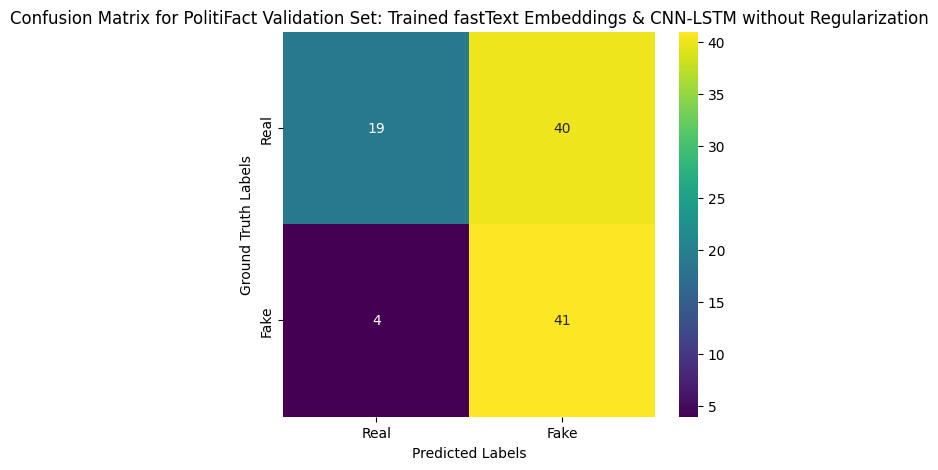

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Model Evaluation:
Accuracy: 0.6270
Macro-Precision: 0.6572
Macro-Recall: 0.6193
Macro-F1 Score: 0.5995


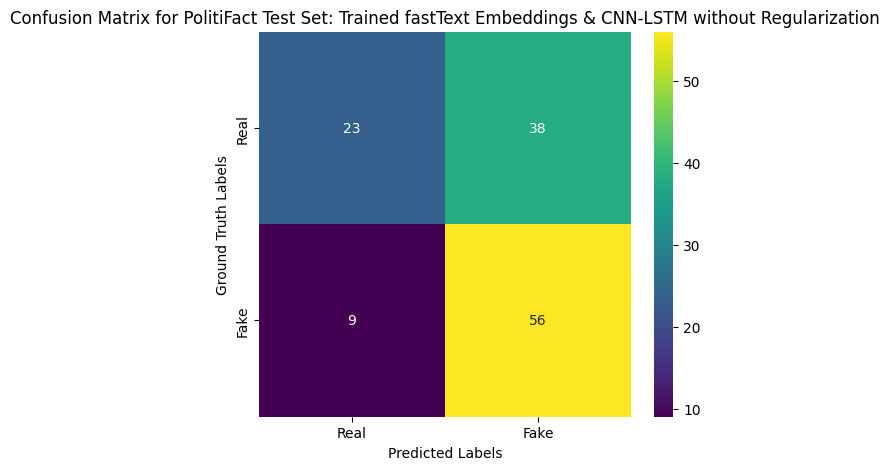

{'Real': {'precision': 0.71875,
  'recall': 0.3770491803278688,
  'f1-score': 0.4946236559139785,
  'support': 61.0},
 'Fake': {'precision': 0.5957446808510638,
  'recall': 0.8615384615384616,
  'f1-score': 0.7044025157232704,
  'support': 65.0},
 'accuracy': 0.626984126984127,
 'macro avg': {'precision': 0.6572473404255319,
  'recall': 0.6192938209331652,
  'f1-score': 0.5995130858186244,
  'support': 126.0},
 'weighted avg': {'precision': 0.6552948750422154,
  'recall': 0.626984126984127,
  'f1-score': 0.6028429089902005,
  'support': 126.0}}

In [65]:
pf_model_no_reg, pf_history_no_reg = trainCNN_LSTMWithoutRegularization(pf_X_train, pf_X_train_extra_scaled, pf_y_train)

evaluateCNN_LSTMModel(
    pf_model_no_reg,
    pf_X_val,
    pf_X_val_extra_scaled,
    pf_y_val, 
    "PolitiFact Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    pf_model_no_reg,
    pf_X_test,
    pf_X_test_extra_scaled,
    pf_y_test,
    "PolitiFact Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (2000, 11)
Extra features dimensions: 10
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.5205 - f1_score: 0.5136 - loss: 0.6822 - val_accuracy: 0.6477 - val_f1_score: 0.6399 - val_loss: 0.5889
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.6690 - f1_score: 0.6657 - loss: 0.6050 - val_accuracy: 0.7841 - val_f1_score: 0.7776 - val_loss: 0.5184
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.7326 - f1_score: 0.7314 - loss: 0.5401 - val_accuracy: 0.8068 - val_f1_score: 0.8048 - val_loss: 0.4587
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.7924 - f1_score: 0.7918 - loss: 0.4860 - val_accuracy: 0.8409 - val_f1_score: 0.8388 - val_loss: 0.3864
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.8312 - f1_score: 0.8290 - loss: 0.3837 - val_accuracy: 0.8409 - val_f1_score: 0.8355 - val_loss: 0.3408
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.8670 - f1_score:

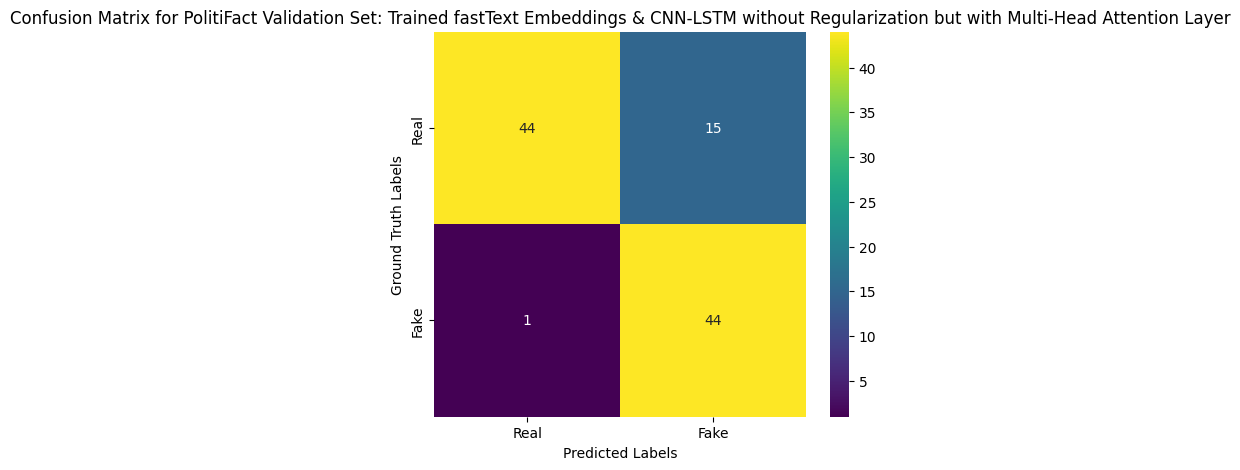

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Model Evaluation:
Accuracy: 0.8571
Macro-Precision: 0.8675
Macro-Recall: 0.8545
Macro-F1 Score: 0.8554


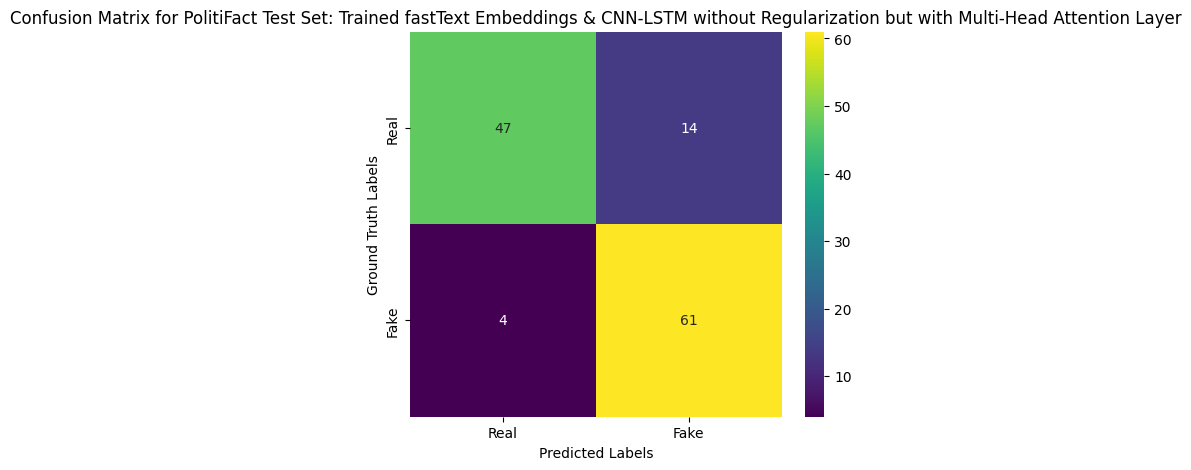

{'Real': {'precision': 0.9215686274509803,
  'recall': 0.7704918032786885,
  'f1-score': 0.8392857142857143,
  'support': 61.0},
 'Fake': {'precision': 0.8133333333333334,
  'recall': 0.9384615384615385,
  'f1-score': 0.8714285714285714,
  'support': 65.0},
 'accuracy': 0.8571428571428571,
 'macro avg': {'precision': 0.8674509803921568,
  'recall': 0.8544766708701135,
  'f1-score': 0.8553571428571429,
  'support': 126.0},
 'weighted avg': {'precision': 0.8657329598506068,
  'recall': 0.8571428571428571,
  'f1-score': 0.8558673469387755,
  'support': 126.0}}

In [67]:
pf_model_no_reg_mt_att, pf_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(pf_X_train, pf_X_train_extra_scaled, pf_y_train)

evaluateCNN_LSTMModel(
    pf_model_no_reg_mt_att,
    pf_X_val,
    pf_X_val_extra_scaled,
    pf_y_val, 
    "PolitiFact Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    pf_model_no_reg_mt_att,
    pf_X_test,
    pf_X_test_extra_scaled,
    pf_y_test,
    "PolitiFact Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### GossipCop

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (1500, 6)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.7699 - f1_score: 0.4428 - loss: 1.9455 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.6494
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5880 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5488
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5314 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5413
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5244 - val_accuracy: 0.7542 - val_f1_score: 0.4317 - val_loss: 0.5374
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.7710 - f1_score: 0.4381 - loss: 0.5207 - val_accuracy: 0.7542 - val_f1_score: 0.4371 - val_loss: 0.5352
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step -

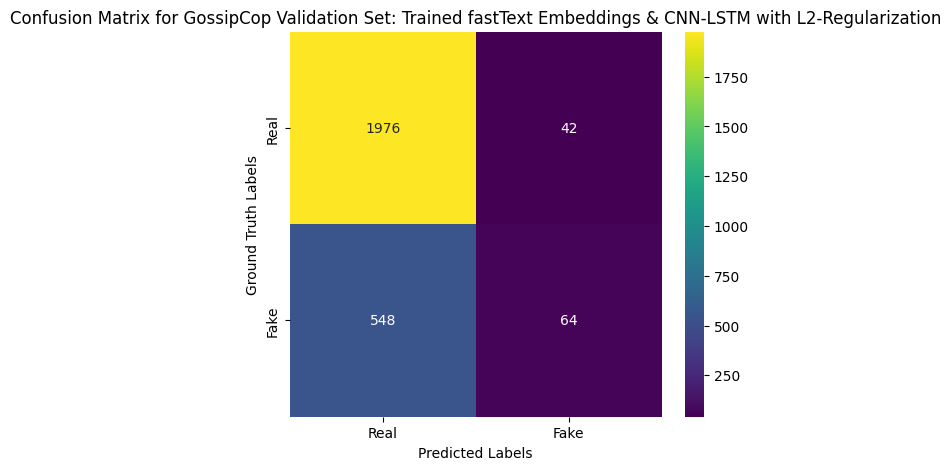

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Model Evaluation:
Accuracy: 0.7721
Macro-Precision: 0.6872
Macro-Recall: 0.5428
Macro-F1 Score: 0.5256


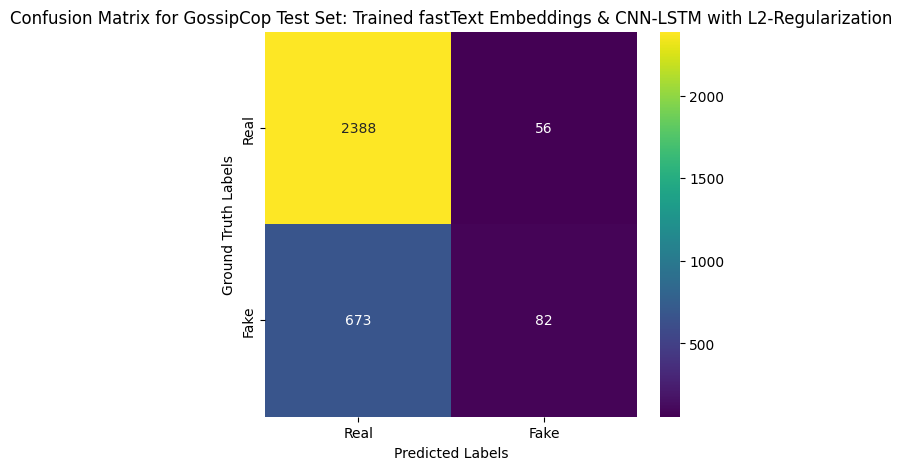

{'Real': {'precision': 0.7801372100620713,
  'recall': 0.9770867430441899,
  'f1-score': 0.867574931880109,
  'support': 2444.0},
 'Fake': {'precision': 0.5942028985507246,
  'recall': 0.10860927152317881,
  'f1-score': 0.18365061590145576,
  'support': 755.0},
 'accuracy': 0.772116286339481,
 'macro avg': {'precision': 0.6871700543063979,
  'recall': 0.5428480072836843,
  'f1-score': 0.5256127738907824,
  'support': 3199.0},
 'weighted avg': {'precision': 0.7362546201305092,
  'recall': 0.772116286339481,
  'f1-score': 0.7061610967554192,
  'support': 3199.0}}

In [79]:
gc_model_l2_reg, gc_history_l2_reg = trainCNN_LSTMWithL2Regularization(gc_X_train, gc_X_train_extra_scaled, gc_y_train)

evaluateCNN_LSTMModel(
    gc_model_l2_reg,
    gc_X_val,
    gc_X_val_extra_scaled,
    gc_y_val, 
    "GossipCop Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    gc_model_l2_reg,
    gc_X_test,
    gc_X_test_extra_scaled,
    gc_y_test,
    "GossipCop Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)


#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (1500, 6)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7699 - f1_score: 0.4428 - loss: 15.8572 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 1.1092
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.7523 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5864
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5704 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5810
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.7710 - f1_score: 0.4366 - loss: 0.5642 - val_accuracy: 0.7542 - val_f1_score: 0.4335 - val_loss: 0.5784
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7707 - f1_score: 0.4395 - loss: 0.5600 - val_accuracy: 0.7542 - val_f1_score: 0.4405 - val_loss: 0.5756
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step 

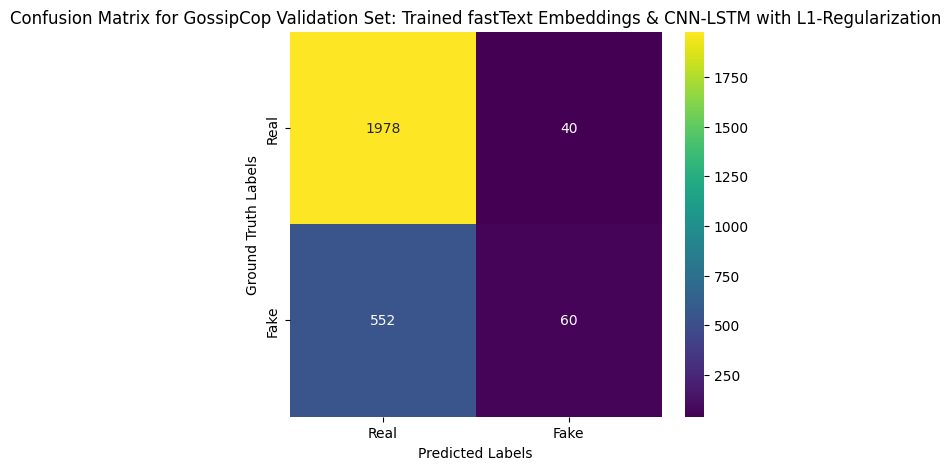

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Model Evaluation:
Accuracy: 0.7721
Macro-Precision: 0.6897
Macro-Recall: 0.5410
Macro-F1 Score: 0.5220


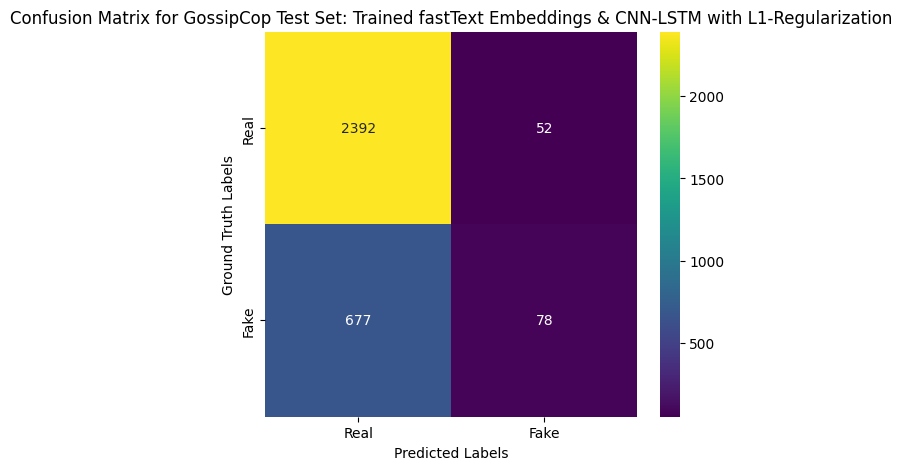

{'Real': {'precision': 0.7794069729553601,
  'recall': 0.9787234042553191,
  'f1-score': 0.8677670959550154,
  'support': 2444.0},
 'Fake': {'precision': 0.6,
  'recall': 0.10331125827814569,
  'f1-score': 0.17627118644067796,
  'support': 755.0},
 'accuracy': 0.772116286339481,
 'macro avg': {'precision': 0.6897034864776801,
  'recall': 0.5410173312667323,
  'f1-score': 0.5220191411978468,
  'support': 3199.0},
 'weighted avg': {'precision': 0.7370649083785247,
  'recall': 0.772116286339481,
  'f1-score': 0.7045662795488496,
  'support': 3199.0}}

In [81]:
gc_model_l1_reg, gc_history_l1_reg = trainCNN_LSTMWithL1Regularization(gc_X_train, gc_X_train_extra_scaled, gc_y_train)

evaluateCNN_LSTMModel(
    gc_model_l1_reg,
    gc_X_val,
    gc_X_val_extra_scaled,
    gc_y_val, 
    "GossipCop Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization"
)

evaluateCNN_LSTMModel(
    gc_model_l1_reg,
    gc_X_test,
    gc_X_test_extra_scaled,
    gc_y_test,
    "GossipCop Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (1500, 6)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.7699 - f1_score: 0.4428 - loss: 0.5646 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5568
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5411 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5489
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5325 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5457
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.7708 - f1_score: 0.4354 - loss: 0.5270 - val_accuracy: 0.7537 - val_f1_score: 0.4298 - val_loss: 0.5394
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.7710 - f1_score: 0.4386 - loss: 0.5209 - val_accuracy: 0.7533 - val_f1_score: 0.4367 - val_loss: 0.5367
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step -

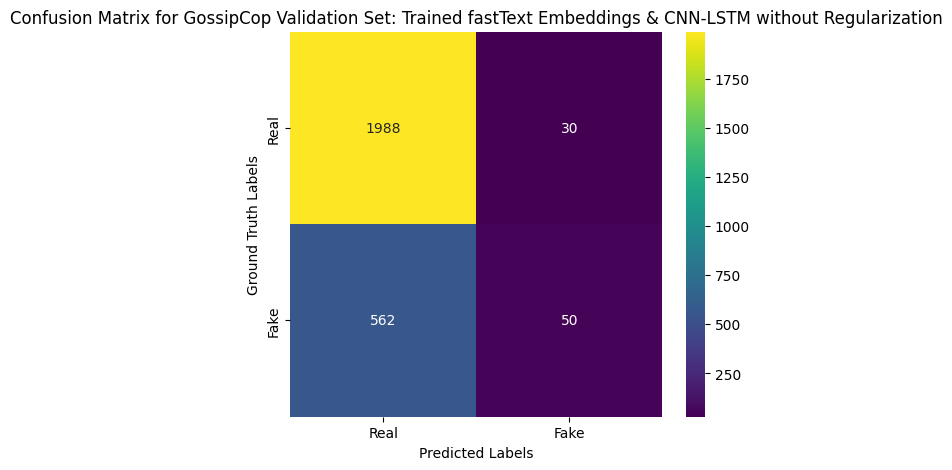

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Model Evaluation:
Accuracy: 0.7734
Macro-Precision: 0.7110
Macro-Recall: 0.5368
Macro-F1 Score: 0.5126


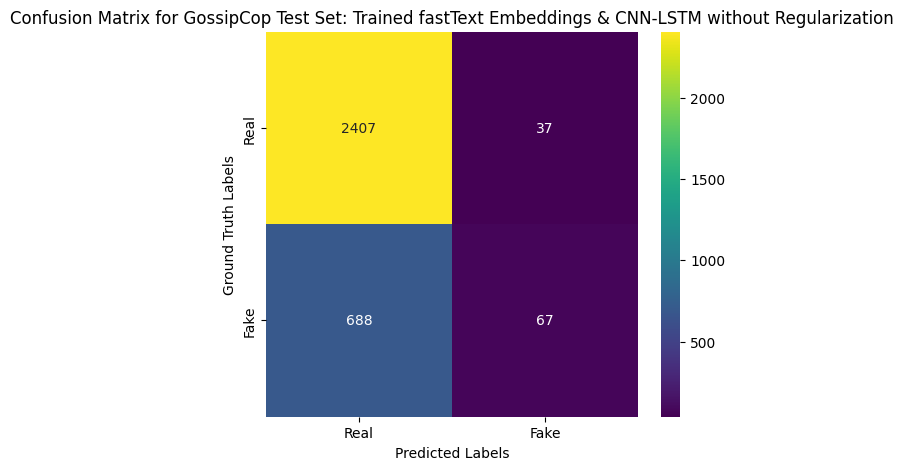

{'Real': {'precision': 0.7777059773828756,
  'recall': 0.984860883797054,
  'f1-score': 0.8691099476439791,
  'support': 2444.0},
 'Fake': {'precision': 0.6442307692307693,
  'recall': 0.08874172185430464,
  'f1-score': 0.1559953434225844,
  'support': 755.0},
 'accuracy': 0.7733666770865896,
 'macro avg': {'precision': 0.7109683733068224,
  'recall': 0.5368013028256794,
  'f1-score': 0.5125526455332817,
  'support': 3199.0},
 'weighted avg': {'precision': 0.7462043261934913,
  'recall': 0.7733666770865896,
  'f1-score': 0.7008068760006052,
  'support': 3199.0}}

In [83]:
gc_model_no_reg, gc_history_no_reg = trainCNN_LSTMWithoutRegularization(gc_X_train, gc_X_train_extra_scaled, gc_y_train)

evaluateCNN_LSTMModel(
    gc_model_no_reg,
    gc_X_val,
    gc_X_val_extra_scaled,
    gc_y_val, 
    "GossipCop Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    gc_model_no_reg,
    gc_X_test,
    gc_X_test_extra_scaled,
    gc_y_test,
    "GossipCop Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (1500, 6)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.7713 - f1_score: 0.6101 - loss: 0.4998 - val_accuracy: 0.8751 - val_f1_score: 0.8177 - val_loss: 0.3178
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 35s 251ms/step - accuracy: 0.8689 - f1_score: 0.8066 - loss: 0.3471 - val_accuracy: 0.8809 - val_f1_score: 0.8213 - val_loss: 0.3296
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.8844 - f1_score: 0.8247 - loss: 0.3196 - val_accuracy: 0.8669 - val_f1_score: 0.7803 - val_loss: 0.3190
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.8901 - f1_score: 0.8317 - loss: 0.3054 - val_accuracy: 0.8809 - val_f1_score: 0.8173 - val_loss: 0.2949
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.8891 - f1_score: 0.8292 - loss: 0.2926 - val_accuracy: 0.8651 - val_f1_score: 0.7769 - val_loss: 0.3106
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step -

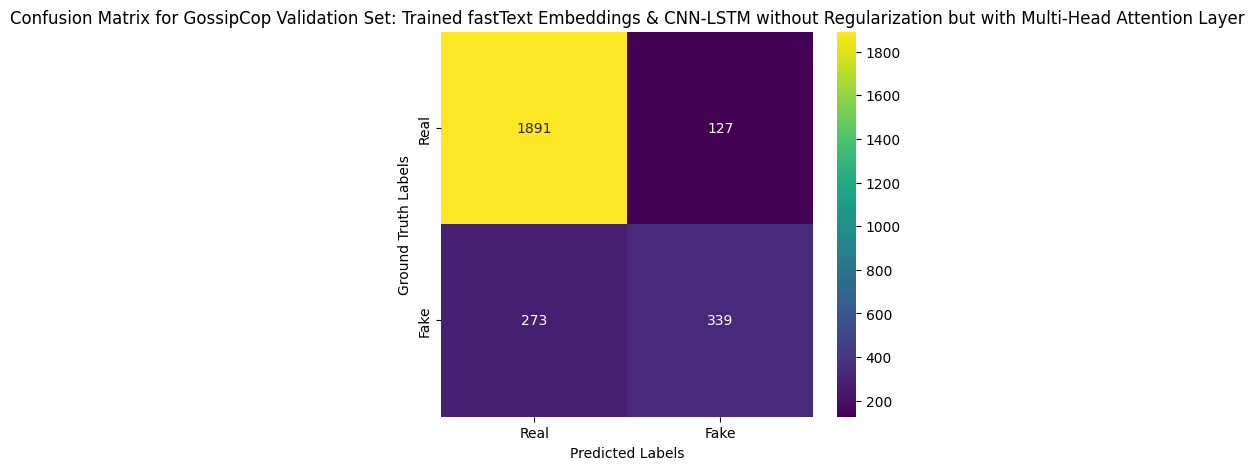

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step

Model Evaluation:
Accuracy: 0.8378
Macro-Precision: 0.7845
Macro-Recall: 0.7373
Macro-F1 Score: 0.7557


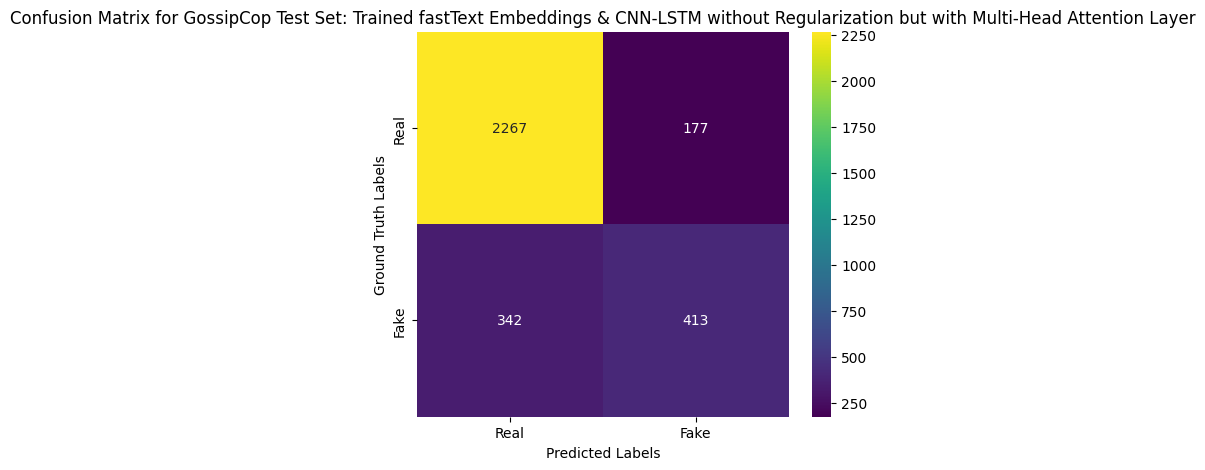

{'Real': {'precision': 0.8689152932157915,
  'recall': 0.9275777414075287,
  'f1-score': 0.8972887393627548,
  'support': 2444.0},
 'Fake': {'precision': 0.7,
  'recall': 0.5470198675496689,
  'f1-score': 0.6141263940520446,
  'support': 755.0},
 'accuracy': 0.8377618005626758,
 'macro avg': {'precision': 0.7844576466078957,
  'recall': 0.7372988044785989,
  'f1-score': 0.7557075667073997,
  'support': 3199.0},
 'weighted avg': {'precision': 0.8290493831257876,
  'recall': 0.8377618005626758,
  'f1-score': 0.8304592392972386,
  'support': 3199.0}}

In [85]:
gc_model_no_reg_mt_att, gc_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(gc_X_train, gc_X_train_extra_scaled, gc_y_train)

evaluateCNN_LSTMModel(
    gc_model_no_reg_mt_att,
    gc_X_val,
    gc_X_val_extra_scaled,
    gc_y_val, 
    "GossipCop Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    gc_model_no_reg_mt_att,
    gc_X_test,
    gc_X_test_extra_scaled,
    gc_y_test,
    "GossipCop Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### All-Four Combined

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 7)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7704 - f1_score: 0.4430 - loss: 1.9562 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.6504
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5887 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5487
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7707 - f1_score: 0.4353 - loss: 0.5308 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5403
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7707 - f1_score: 0.4355 - loss: 0.5240 - val_accuracy: 0.7537 - val_f1_score: 0.4316 - val_loss: 0.5367
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7709 - f1_score: 0.4383 - loss: 0.5188 - val_accuracy: 0.7542 - val_f1_score: 0.4405 - val_loss: 0.5344
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.

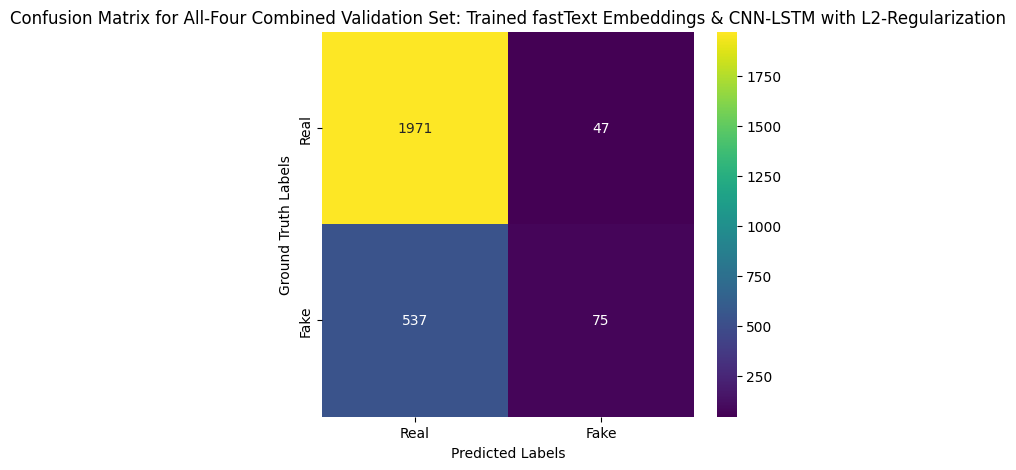

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

Model Evaluation:
Accuracy: 0.7734
Macro-Precision: 0.6878
Macro-Recall: 0.5501
Macro-F1 Score: 0.5386


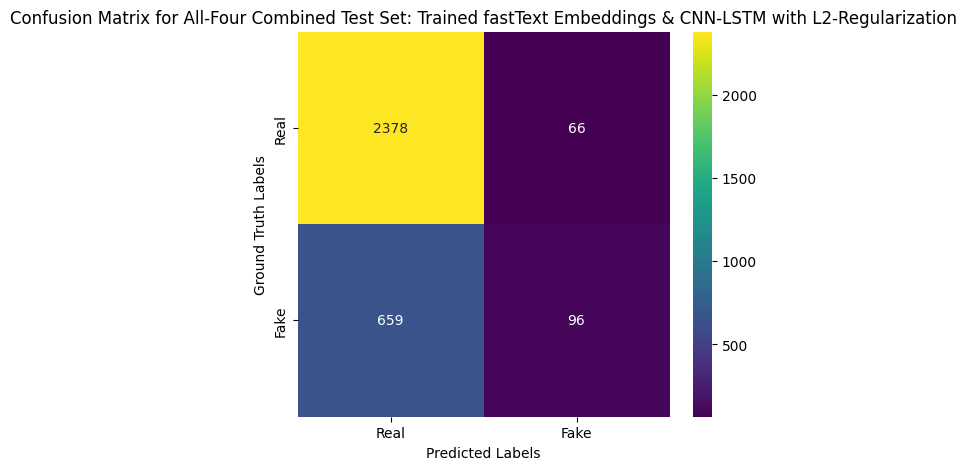

{'Real': {'precision': 0.7830095488969377,
  'recall': 0.9729950900163666,
  'f1-score': 0.8677248677248677,
  'support': 2444.0},
 'Fake': {'precision': 0.5925925925925926,
  'recall': 0.1271523178807947,
  'f1-score': 0.2093784078516903,
  'support': 755.0},
 'accuracy': 0.7733666770865896,
 'macro avg': {'precision': 0.6878010707447652,
  'recall': 0.5500737039485807,
  'f1-score': 0.538551637788279,
  'support': 3199.0},
 'weighted avg': {'precision': 0.7380690043487099,
  'recall': 0.7733666770865896,
  'f1-score': 0.7123476944819014,
  'support': 3199.0}}

In [97]:
all_four_model_l2_reg, all_four_history_l2_reg = trainCNN_LSTMWithL2Regularization(all_four_X_train, all_four_X_train_extra_scaled, all_four_y_train)

evaluateCNN_LSTMModel(
    all_four_model_l2_reg,
    all_four_X_val,
    all_four_X_val_extra_scaled,
    all_four_y_val, 
    "All-Four Combined Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    all_four_model_l2_reg,
    all_four_X_test,
    all_four_X_test_extra_scaled,
    all_four_y_test,
    "All-Four Combined Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)


In [98]:
# Frees up all the memory 
tf.keras.backend.clear_session(
    free_memory=True
)
gc.collect()

del all_four_model_l2_reg

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 7)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7704 - f1_score: 0.4430 - loss: 15.9772 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 1.1090
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.7537 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5873
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7708 - f1_score: 0.4353 - loss: 0.5716 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5815
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7708 - f1_score: 0.4357 - loss: 0.5651 - val_accuracy: 0.7546 - val_f1_score: 0.4354 - val_loss: 0.5780
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7701 - f1_score: 0.4399 - loss: 0.5593 - val_accuracy: 0.7542 - val_f1_score: 0.4405 - val_loss: 0.5758
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0

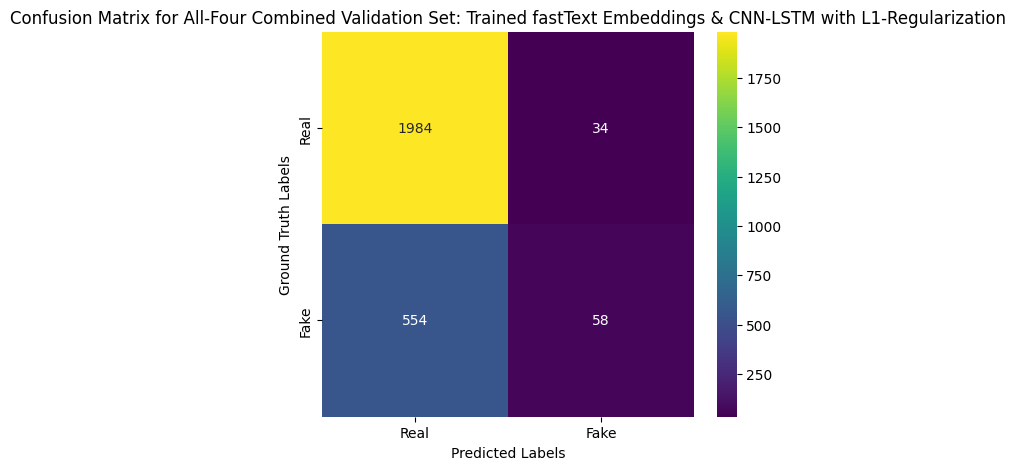

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

Model Evaluation:
Accuracy: 0.7718
Macro-Precision: 0.6887
Macro-Recall: 0.5399
Macro-F1 Score: 0.5200


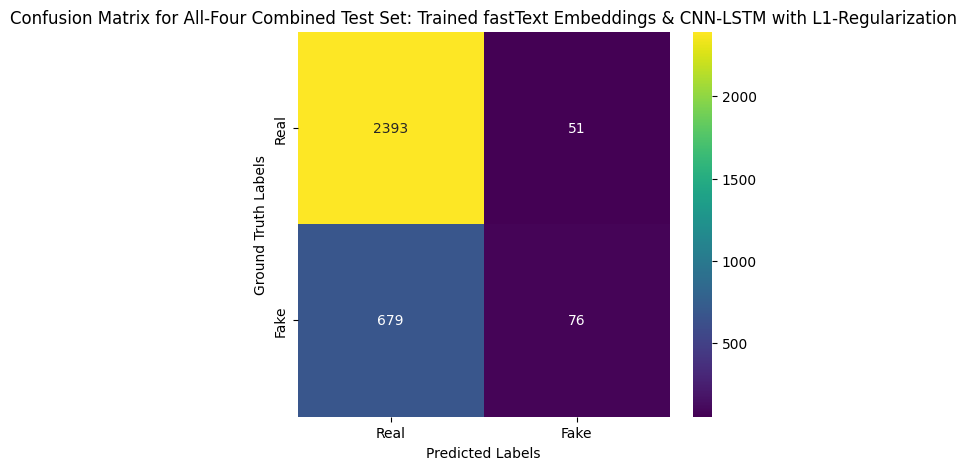

{'Real': {'precision': 0.7789713541666666,
  'recall': 0.9791325695581015,
  'f1-score': 0.8676577229876722,
  'support': 2444.0},
 'Fake': {'precision': 0.5984251968503937,
  'recall': 0.10066225165562914,
  'f1-score': 0.17233560090702948,
  'support': 755.0},
 'accuracy': 0.771803688652704,
 'macro avg': {'precision': 0.6886982755085302,
  'recall': 0.5398974106068652,
  'f1-score': 0.5199966619473508,
  'support': 3199.0},
 'weighted avg': {'precision': 0.7363604292608253,
  'recall': 0.771803688652704,
  'f1-score': 0.7035538773575111,
  'support': 3199.0}}

In [99]:
all_four_model_l1_reg, all_four_history_l1_reg = trainCNN_LSTMWithL1Regularization(all_four_X_train, all_four_X_train_extra_scaled, all_four_y_train)

evaluateCNN_LSTMModel(
    all_four_model_l1_reg,
    all_four_X_val,
    all_four_X_val_extra_scaled,
    all_four_y_val, 
    "All-Four Combined Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    all_four_model_l1_reg,
    all_four_X_test,
    all_four_X_test_extra_scaled,
    all_four_y_test,
    "All-Four Combined Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 7)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7701 - f1_score: 0.4430 - loss: 0.5590 - val_accuracy: 0.8800 - val_f1_score: 0.8208 - val_loss: 0.4234
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8080 - f1_score: 0.5774 - loss: 0.5001 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5505
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7717 - f1_score: 0.4393 - loss: 0.5337 - val_accuracy: 0.7542 - val_f1_score: 0.4299 - val_loss: 0.5450
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8057 - f1_score: 0.6018 - loss: 0.4655 - val_accuracy: 0.8791 - val_f1_score: 0.8399 - val_loss: 0.3397
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8863 - f1_score: 0.8360 - loss: 0.3361 - val_accuracy: 0.7678 - val_f1_score: 0.4946 - val_loss: 0.3651
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.

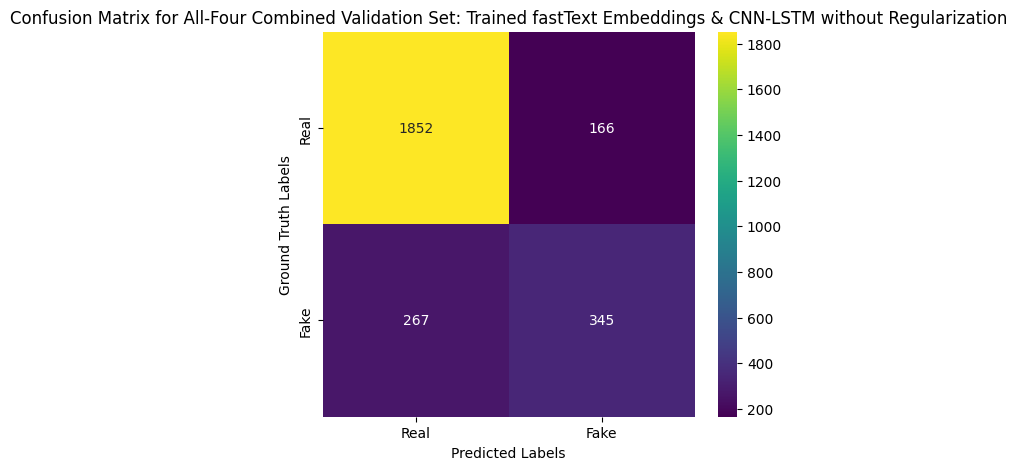

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

Model Evaluation:
Accuracy: 0.8256
Macro-Precision: 0.7612
Macro-Recall: 0.7321
Macro-F1 Score: 0.7444


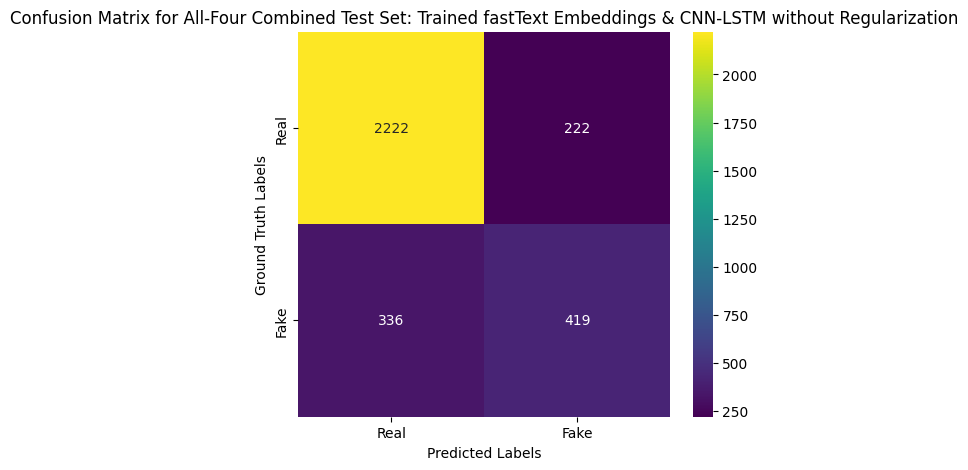

{'Real': {'precision': 0.8686473807662236,
  'recall': 0.9091653027823241,
  'f1-score': 0.8884446221511395,
  'support': 2444.0},
 'Fake': {'precision': 0.6536661466458659,
  'recall': 0.5549668874172186,
  'f1-score': 0.6002865329512894,
  'support': 755.0},
 'accuracy': 0.8255704907783682,
 'macro avg': {'precision': 0.7611567637060448,
  'recall': 0.7320660950997713,
  'f1-score': 0.7443655775512145,
  'support': 3199.0},
 'weighted avg': {'precision': 0.8179093902189056,
  'recall': 0.8255704907783682,
  'f1-score': 0.8204360703080988,
  'support': 3199.0}}

In [101]:
all_four_model_no_reg, all_four_history_no_reg = trainCNN_LSTMWithoutRegularization(all_four_X_train, all_four_X_train_extra_scaled, all_four_y_train)

evaluateCNN_LSTMModel(
    all_four_model_no_reg,
    all_four_X_val,
    all_four_X_val_extra_scaled,
    all_four_y_val, 
    "All-Four Combined Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    all_four_model_no_reg,
    all_four_X_test,
    all_four_X_test_extra_scaled,
    all_four_y_test,
    "All-Four Combined Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 7)
Extra features dimensions: 10
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8106 - f1_score: 0.7015 - loss: 0.4146 - val_accuracy: 0.8909 - val_f1_score: 0.8365 - val_loss: 0.2813
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8946 - f1_score: 0.8444 - loss: 0.2885 - val_accuracy: 0.8954 - val_f1_score: 0.8450 - val_loss: 0.2635
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9019 - f1_score: 0.8532 - loss: 0.2732 - val_accuracy: 0.9018 - val_f1_score: 0.8568 - val_loss: 0.2566
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9051 - f1_score: 0.8584 - loss: 0.2587 - val_accuracy: 0.9009 - val_f1_score: 0.8584 - val_loss: 0.2426
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9095 - f1_score: 0.8649 - loss: 0.2506 - val_accuracy: 0.9054 - val_f1_score: 0.8673 - val_loss: 0.2444
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.

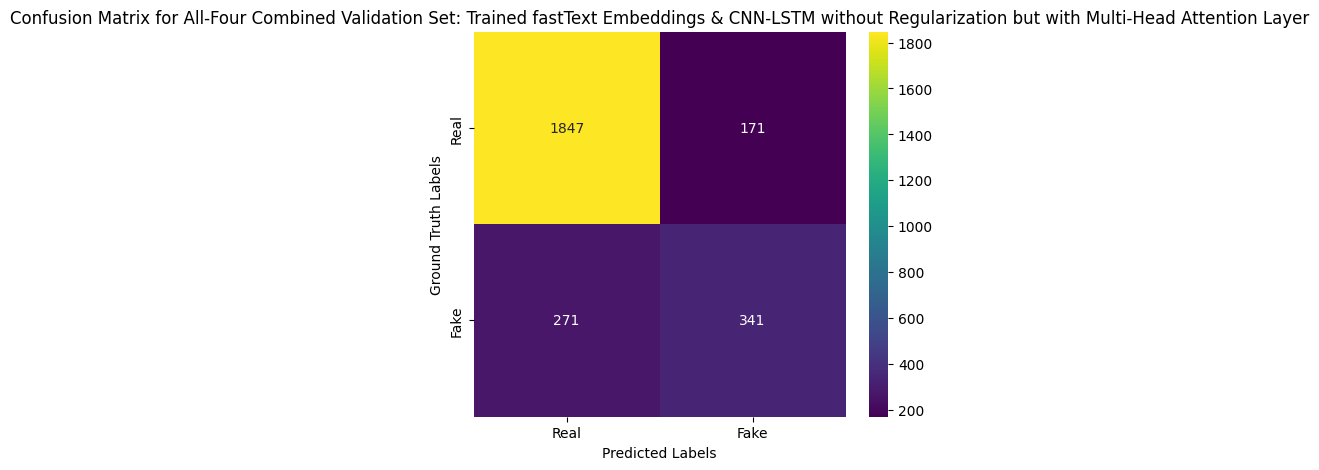

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Model Evaluation:
Accuracy: 0.8299
Macro-Precision: 0.7677
Macro-Recall: 0.7395
Macro-F1 Score: 0.7515


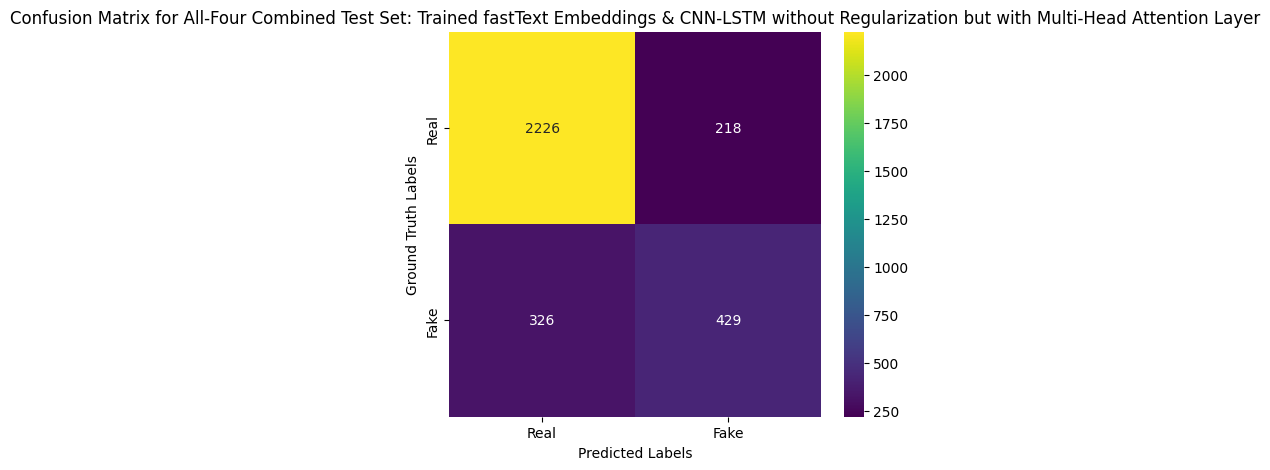

{'Real': {'precision': 0.872257053291536,
  'recall': 0.9108019639934534,
  'f1-score': 0.8911128903122498,
  'support': 2444.0},
 'Fake': {'precision': 0.6630602782071098,
  'recall': 0.5682119205298013,
  'f1-score': 0.6119828815977175,
  'support': 755.0},
 'accuracy': 0.8299468583932479,
 'macro avg': {'precision': 0.767658665749323,
  'recall': 0.7395069422616274,
  'f1-score': 0.7515478859549837,
  'support': 3199.0},
 'weighted avg': {'precision': 0.8228842601722044,
  'recall': 0.8299468583932479,
  'f1-score': 0.8252350670613989,
  'support': 3199.0}}

In [103]:
all_four_model_no_reg_mt_att, all_four_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(all_four_X_train, all_four_X_train_extra_scaled, all_four_y_train)

evaluateCNN_LSTMModel(
    all_four_model_no_reg_mt_att,
    all_four_X_val,
    all_four_X_val_extra_scaled,
    all_four_y_val, 
    "All-Four Combined Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    all_four_model_no_reg_mt_att,
    all_four_X_test,
    all_four_X_test_extra_scaled,
    all_four_y_test,
    "All-Four Combined Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)


### Five-Shot - Target: WELFake

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.6824 - f1_score: 0.4266 - loss: 1.9235 - val_accuracy: 0.6851 - val_f1_score: 0.5043 - val_loss: 0.6265
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7037 - f1_score: 0.5009 - loss: 0.6066 - val_accuracy: 0.6971 - val_f1_score: 0.5639 - val_loss: 0.5967
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7114 - f1_score: 0.5536 - loss: 0.5869 - val_accuracy: 0.7004 - val_f1_score: 0.5794 - val_loss: 0.5907
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7179 - f1_score: 0.5770 - loss: 0.5797 - val_accuracy: 0.7016 - val_f1_score: 0.5869 - val_loss: 0.5880
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7189 - f1_score: 0.5820 - loss: 0.5759 - val_accuracy: 0.7035 - val_f1_score: 0.5911 - val_loss: 0.5860
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accu

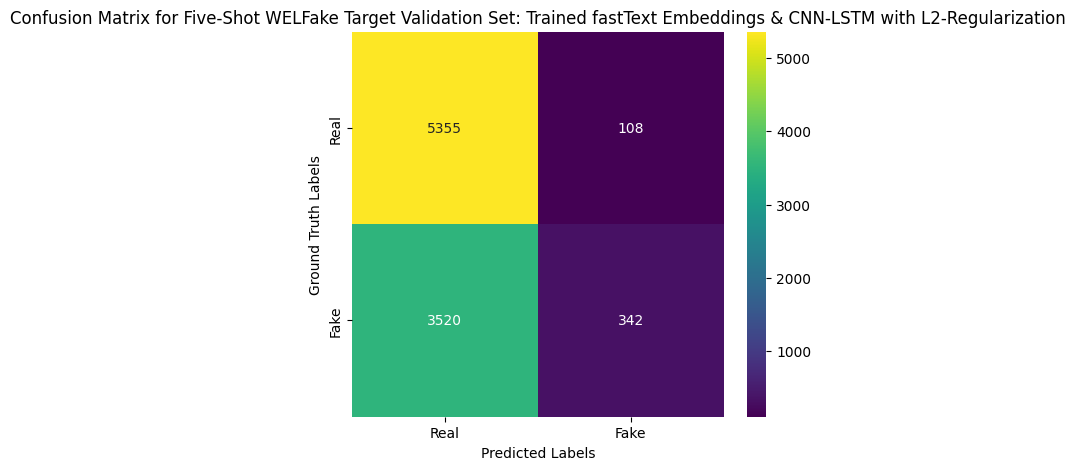

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Model Evaluation:
Accuracy: 0.6367
Macro-Precision: 0.6747
Macro-Recall: 0.5264
Macro-F1 Score: 0.4488


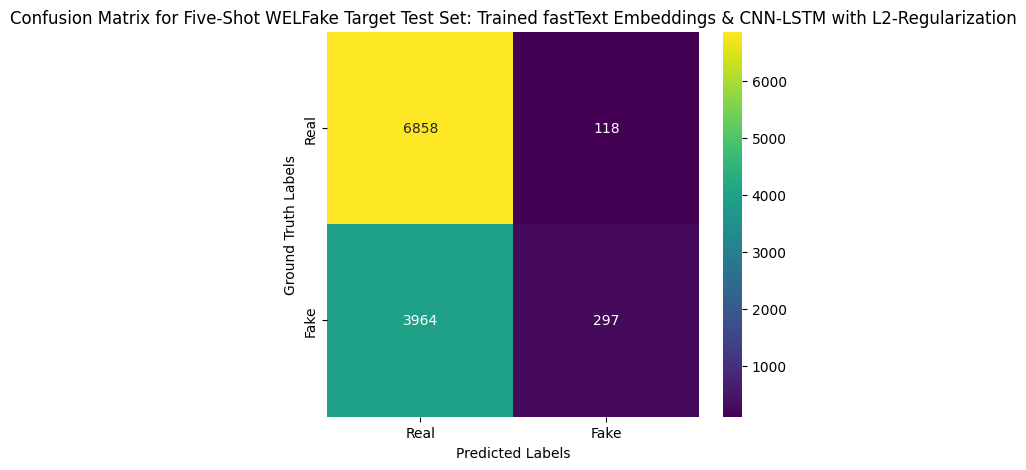

{'Real': {'precision': 0.6337091110700425,
  'recall': 0.9830848623853211,
  'f1-score': 0.7706483874592651,
  'support': 6976.0},
 'Fake': {'precision': 0.7156626506024096,
  'recall': 0.0697019478995541,
  'f1-score': 0.1270316509837468,
  'support': 4261.0},
 'accuracy': 0.6367357835721278,
 'macro avg': {'precision': 0.674685880836226,
  'recall': 0.5263934051424376,
  'f1-score': 0.44884001922150596,
  'support': 11237.0},
 'weighted avg': {'precision': 0.6647853798203688,
  'recall': 0.6367357835721278,
  'f1-score': 0.5265929532577716,
  'support': 11237.0}}

In [25]:
five_shot_wf_model_l2_reg, five_shot_wf_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    five_shot_wf_target_X_train,
    five_shot_wf_target_X_train_extra_scaled,
    five_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_l2_reg,
    five_shot_wf_target_X_val,
    five_shot_wf_target_X_val_extra_scaled,
    five_shot_wf_target_y_val, 
    "Five-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_l2_reg,
    five_shot_wf_target_X_test,
    five_shot_wf_target_X_test_extra_scaled,
    five_shot_wf_target_y_test, 
    "Five-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6831 - f1_score: 0.4165 - loss: 16.9460 - val_accuracy: 0.6870 - val_f1_score: 0.5198 - val_loss: 0.6774
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7048 - f1_score: 0.5193 - loss: 0.6661 - val_accuracy: 0.6979 - val_f1_score: 0.5684 - val_loss: 0.6660
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7148 - f1_score: 0.5633 - loss: 0.6562 - val_accuracy: 0.7004 - val_f1_score: 0.5853 - val_loss: 0.6612
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7192 - f1_score: 0.5793 - loss: 0.6499 - val_accuracy: 0.7041 - val_f1_score: 0.5912 - val_loss: 0.6582
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7204 - f1_score: 0.5864 - loss: 0.6469 - val_accuracy: 0.7049 - val_f1_score: 0.5932 - val_loss: 0.6560
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - acc

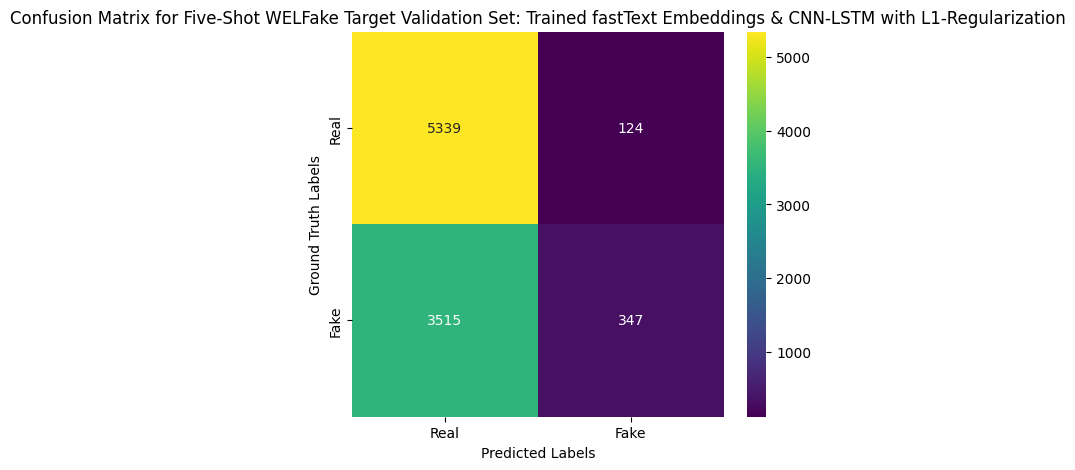

352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

Model Evaluation:
Accuracy: 0.6340
Macro-Precision: 0.6479
Macro-Recall: 0.5244
Macro-F1 Score: 0.4480


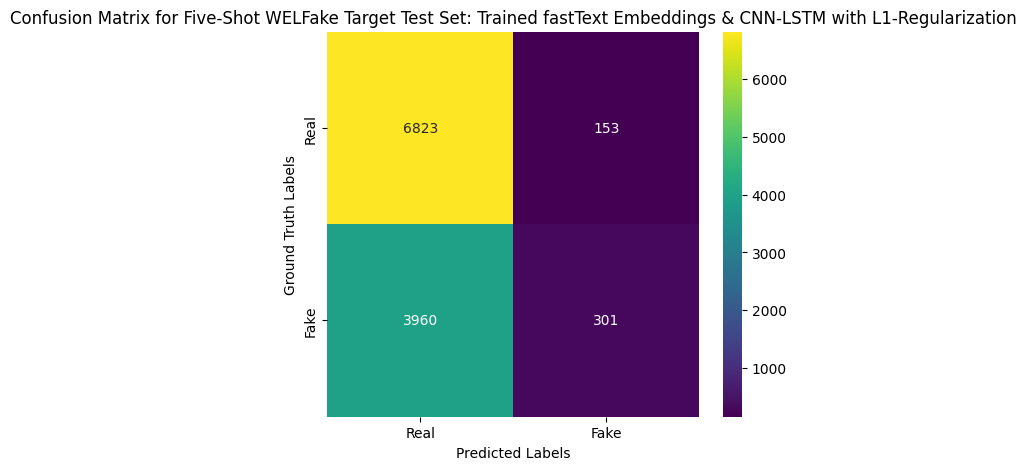

{'Real': {'precision': 0.6327552629138459,
  'recall': 0.9780676605504587,
  'f1-score': 0.7683991215721606,
  'support': 6976.0},
 'Fake': {'precision': 0.6629955947136564,
  'recall': 0.07064069467261207,
  'f1-score': 0.12767762460233298,
  'support': 4261.0},
 'accuracy': 0.6339770401352675,
 'macro avg': {'precision': 0.6478754288137512,
  'recall': 0.5243541776115354,
  'f1-score': 0.4480383730872468,
  'support': 11237.0},
 'weighted avg': {'precision': 0.6442222072761306,
  'recall': 0.6339770401352675,
  'f1-score': 0.5254415440524992,
  'support': 11237.0}}

In [27]:
five_shot_wf_model_l1_reg, five_shot_wf_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    five_shot_wf_target_X_train,
    five_shot_wf_target_X_train_extra_scaled,
    five_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_l1_reg,
    five_shot_wf_target_X_val,
    five_shot_wf_target_X_val_extra_scaled,
    five_shot_wf_target_y_val, 
    "Five-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_l1_reg,
    five_shot_wf_target_X_test,
    five_shot_wf_target_X_test_extra_scaled,
    five_shot_wf_target_y_test, 
    "Five-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6839 - f1_score: 0.4267 - loss: 0.6214 - val_accuracy: 0.6324 - val_f1_score: 0.5971 - val_loss: 0.6550
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6896 - f1_score: 0.5130 - loss: 0.6042 - val_accuracy: 0.6940 - val_f1_score: 0.5470 - val_loss: 0.5990
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7086 - f1_score: 0.5355 - loss: 0.5911 - val_accuracy: 0.7004 - val_f1_score: 0.5751 - val_loss: 0.5930
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7129 - f1_score: 0.5594 - loss: 0.5836 - val_accuracy: 0.7004 - val_f1_score: 0.5798 - val_loss: 0.5895
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7164 - f1_score: 0.5712 - loss: 0.5797 - val_accuracy: 0.7013 - val_f1_score: 0.5907 - val_loss: 0.5864
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accu

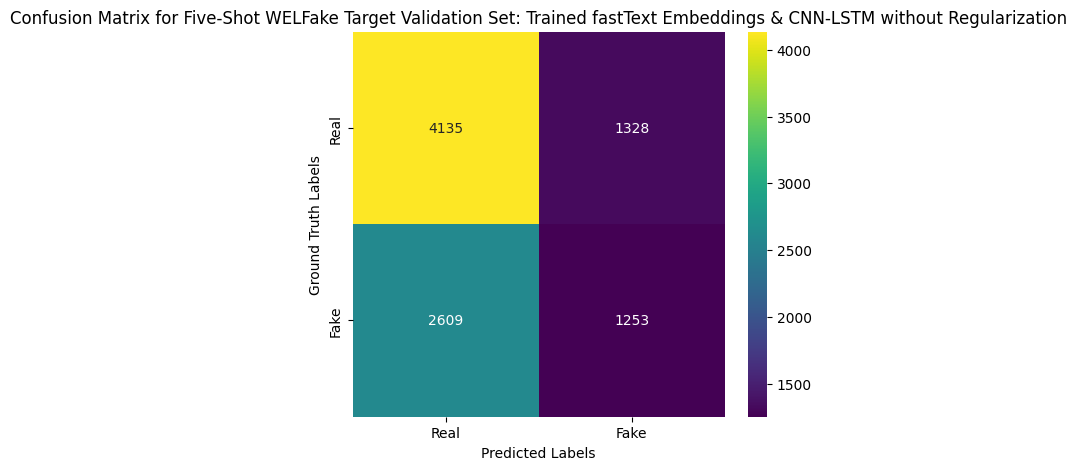

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Model Evaluation:
Accuracy: 0.5841
Macro-Precision: 0.5361
Macro-Recall: 0.5302
Macro-F1 Score: 0.5256


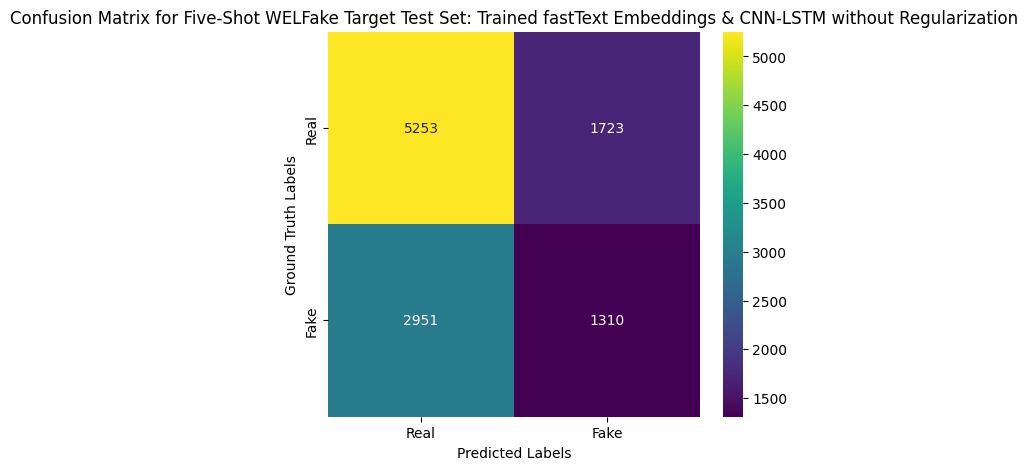

{'Real': {'precision': 0.6402974158946855,
  'recall': 0.7530103211009175,
  'f1-score': 0.692094861660079,
  'support': 6976.0},
 'Fake': {'precision': 0.4319155951203429,
  'recall': 0.3074395681764844,
  'f1-score': 0.35919934192486974,
  'support': 4261.0},
 'accuracy': 0.5840526831004716,
 'macro avg': {'precision': 0.5361065055075142,
  'recall': 0.530224944638701,
  'f1-score': 0.5256471017924744,
  'support': 11237.0},
 'weighted avg': {'precision': 0.5612803349727781,
  'recall': 0.5840526831004716,
  'f1-score': 0.5658629661726957,
  'support': 11237.0}}

In [29]:
five_shot_wf_model_no_reg, five_shot_wf_history_no_reg = trainCNN_LSTMWithoutRegularization(
    five_shot_wf_target_X_train,
    five_shot_wf_target_X_train_extra_scaled,
    five_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_no_reg,
    five_shot_wf_target_X_val,
    five_shot_wf_target_X_val_extra_scaled,
    five_shot_wf_target_y_val, 
    "Five-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_no_reg,
    five_shot_wf_target_X_test,
    five_shot_wf_target_X_test_extra_scaled,
    five_shot_wf_target_y_test, 
    "Five-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6912 - f1_score: 0.5537 - loss: 0.6108 - val_accuracy: 0.7648 - val_f1_score: 0.6941 - val_loss: 0.5134
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7688 - f1_score: 0.6999 - loss: 0.5192 - val_accuracy: 0.7914 - val_f1_score: 0.7491 - val_loss: 0.4699
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8105 - f1_score: 0.7563 - loss: 0.4533 - val_accuracy: 0.8105 - val_f1_score: 0.7751 - val_loss: 0.4453
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8334 - f1_score: 0.7911 - loss: 0.4143 - val_accuracy: 0.8043 - val_f1_score: 0.7710 - val_loss: 0.4604
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.8334 - f1_score: 0.7881 - loss: 0.4085 - val_accuracy: 0.8287 - val_f1_score: 0.8032 - val_loss: 0.4432
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accu

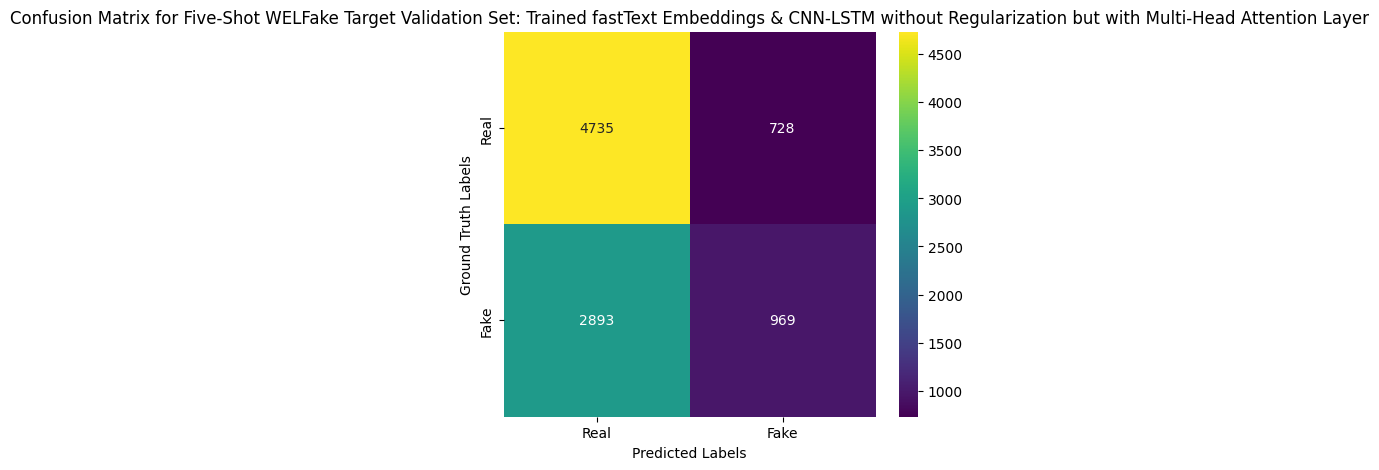

352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

Model Evaluation:
Accuracy: 0.6328
Macro-Precision: 0.5940
Macro-Recall: 0.5574
Macro-F1 Score: 0.5412


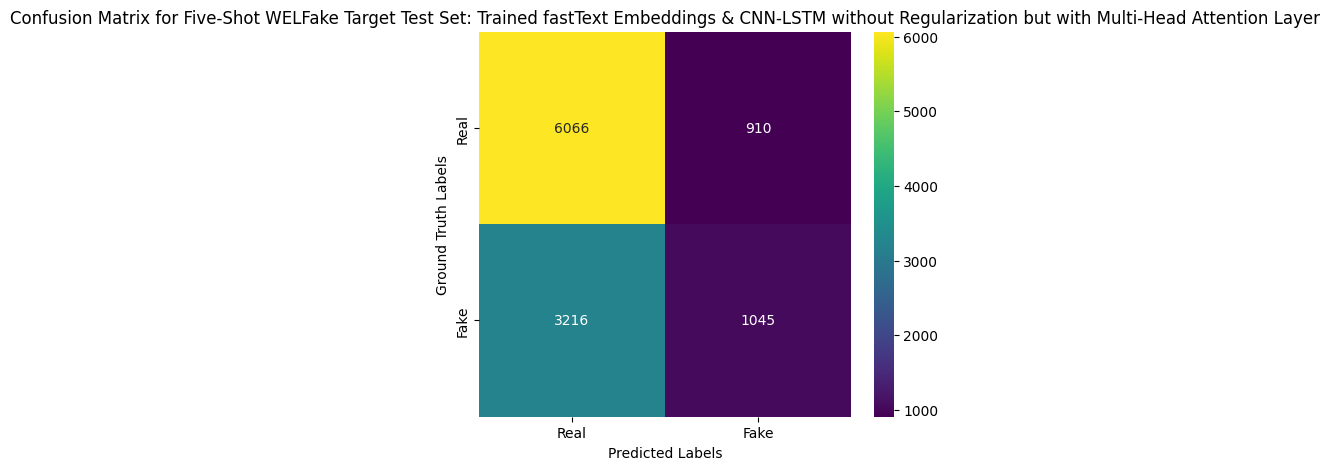

{'Real': {'precision': 0.6535229476405947,
  'recall': 0.869552752293578,
  'f1-score': 0.7462172468938368,
  'support': 6976.0},
 'Fake': {'precision': 0.5345268542199488,
  'recall': 0.24524759446139405,
  'f1-score': 0.3362290862290862,
  'support': 4261.0},
 'accuracy': 0.6328201477262615,
 'macro avg': {'precision': 0.5940249009302718,
  'recall': 0.557400173377486,
  'f1-score': 0.5412231665614615,
  'support': 11237.0},
 'weighted avg': {'precision': 0.608400374528076,
  'recall': 0.6328201477262615,
  'f1-score': 0.5907523049527047,
  'support': 11237.0}}

In [31]:
five_shot_wf_model_no_reg_mt_att, five_shot_wf_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    five_shot_wf_target_X_train,
    five_shot_wf_target_X_train_extra_scaled,
    five_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_no_reg_mt_att,
    five_shot_wf_target_X_val,
    five_shot_wf_target_X_val_extra_scaled,
    five_shot_wf_target_y_val, 
    "Five-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    five_shot_wf_model_no_reg_mt_att,
    five_shot_wf_target_X_test,
    five_shot_wf_target_X_test_extra_scaled,
    five_shot_wf_target_y_test, 
    "Five-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### Five-Shot - Target: Constraint

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5830 - f1_score: 0.3793 - loss: 2.9173 - val_accuracy: 0.6130 - val_f1_score: 0.4258 - val_loss: 1.3143
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5880 - f1_score: 0.4060 - loss: 1.1339 - val_accuracy: 0.6140 - val_f1_score: 0.4282 - val_loss: 0.7838
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6097 - f1_score: 0.4877 - loss: 0.7547 - val_accuracy: 0.6260 - val_f1_score: 0.4844 - val_loss: 0.6702
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6152 - f1_score: 0.5267 - loss: 0.6763 - val_accuracy: 0.6250 - val_f1_score: 0.4953 - val_loss: 0.6474
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6229 - f1_score: 0.5420 - loss: 0.6585 - val_accuracy: 0.6420 - val_f1_score: 0.5491 - val_loss: 0.6383
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6269 - f1_

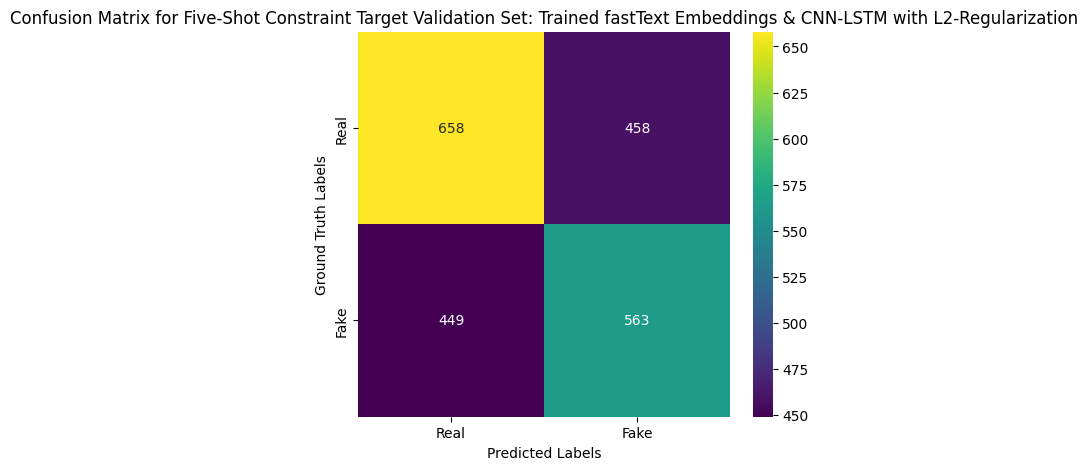

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.5707
Macro-Precision: 0.5697
Macro-Recall: 0.5697
Macro-F1 Score: 0.5697


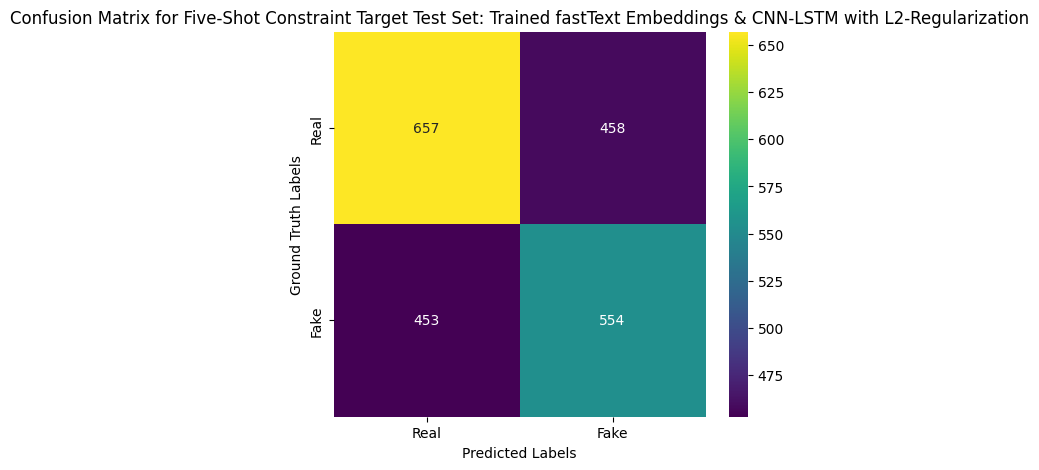

{'Real': {'precision': 0.5918918918918918,
  'recall': 0.589237668161435,
  'f1-score': 0.590561797752809,
  'support': 1115.0},
 'Fake': {'precision': 0.5474308300395256,
  'recall': 0.5501489572989077,
  'f1-score': 0.5487865279841506,
  'support': 1007.0},
 'accuracy': 0.5706880301602262,
 'macro avg': {'precision': 0.5696613609657087,
  'recall': 0.5696933127301713,
  'f1-score': 0.5696741628684798,
  'support': 2122.0},
 'weighted avg': {'precision': 0.570792792322932,
  'recall': 0.5706880301602262,
  'f1-score': 0.5707372470190489,
  'support': 2122.0}}

In [33]:
five_shot_ct_model_l2_reg, five_shot_ct_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    five_shot_ct_target_X_train,
    five_shot_ct_target_X_train_extra_scaled,
    five_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_l2_reg,
    five_shot_ct_target_X_val,
    five_shot_ct_target_X_val_extra_scaled,
    five_shot_ct_target_y_val, 
    "Five-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_l2_reg,
    five_shot_ct_target_X_test,
    five_shot_ct_target_X_test_extra_scaled,
    five_shot_ct_target_y_test, 
    "Five-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)


#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5831 - f1_score: 0.3791 - loss: 28.1338 - val_accuracy: 0.6040 - val_f1_score: 0.3881 - val_loss: 9.9619
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5881 - f1_score: 0.4022 - loss: 6.8962 - val_accuracy: 0.6280 - val_f1_score: 0.4887 - val_loss: 1.6954
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6117 - f1_score: 0.4909 - loss: 1.2698 - val_accuracy: 0.6390 - val_f1_score: 0.5405 - val_loss: 0.7312
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6181 - f1_score: 0.5261 - loss: 0.7344 - val_accuracy: 0.6440 - val_f1_score: 0.5623 - val_loss: 0.7123
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6224 - f1_score: 0.5446 - loss: 0.7254 - val_accuracy: 0.6460 - val_f1_score: 0.5702 - val_loss: 0.7083
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6203 - f1

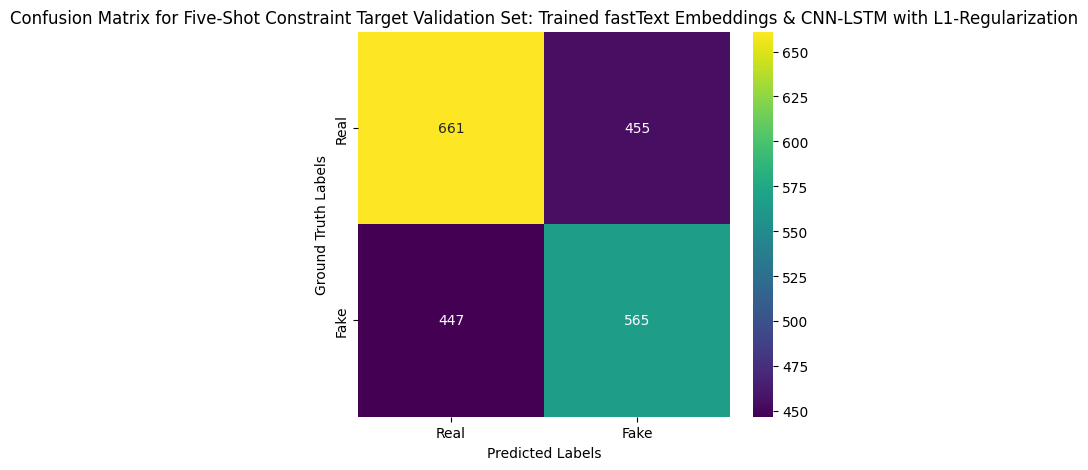

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.5726
Macro-Precision: 0.5714
Macro-Recall: 0.5713
Macro-F1 Score: 0.5714


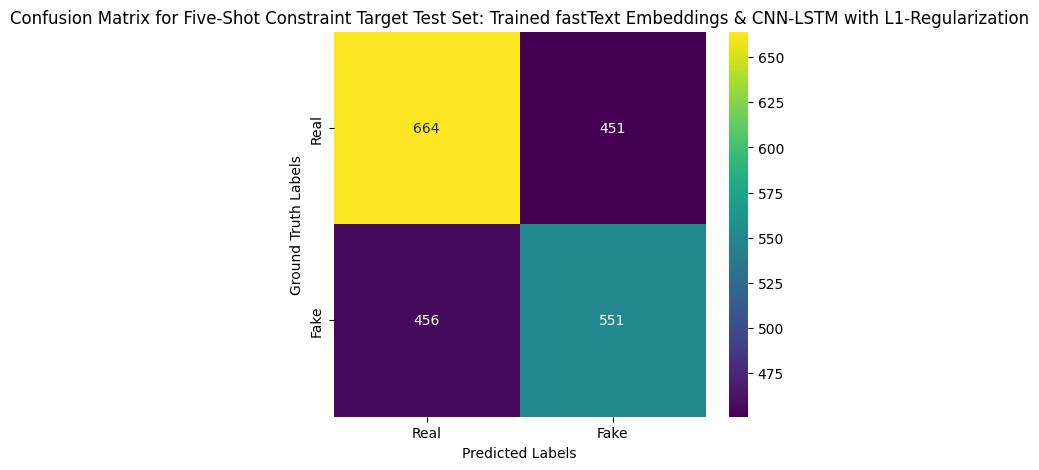

{'Real': {'precision': 0.5928571428571429,
  'recall': 0.5955156950672645,
  'f1-score': 0.5941834451901566,
  'support': 1115.0},
 'Fake': {'precision': 0.5499001996007984,
  'recall': 0.5471698113207547,
  'f1-score': 0.5485316077650573,
  'support': 1007.0},
 'accuracy': 0.5725730442978322,
 'macro avg': {'precision': 0.5713786712289706,
  'recall': 0.5713427531940096,
  'f1-score': 0.571357526477607,
  'support': 2122.0},
 'weighted avg': {'precision': 0.5724718262411491,
  'recall': 0.5725730442978322,
  'f1-score': 0.572519260323486,
  'support': 2122.0}}

In [35]:
five_shot_ct_model_l1_reg, five_shot_ct_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    five_shot_ct_target_X_train,
    five_shot_ct_target_X_train_extra_scaled,
    five_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_l1_reg,
    five_shot_ct_target_X_val,
    five_shot_ct_target_X_val_extra_scaled,
    five_shot_ct_target_y_val, 
    "Five-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_l1_reg,
    five_shot_ct_target_X_test,
    five_shot_ct_target_X_test_extra_scaled,
    five_shot_ct_target_y_test, 
    "Five-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5832 - f1_score: 0.3796 - loss: 0.6780 - val_accuracy: 0.6140 - val_f1_score: 0.4223 - val_loss: 0.6520
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5936 - f1_score: 0.4307 - loss: 0.6628 - val_accuracy: 0.6260 - val_f1_score: 0.4768 - val_loss: 0.6284
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6180 - f1_score: 0.5353 - loss: 0.6431 - val_accuracy: 0.6260 - val_f1_score: 0.4814 - val_loss: 0.6238
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6245 - f1_score: 0.5331 - loss: 0.6341 - val_accuracy: 0.6600 - val_f1_score: 0.5960 - val_loss: 0.6057
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6635 - f1_score: 0.6225 - loss: 0.6146 - val_accuracy: 0.6450 - val_f1_score: 0.5427 - val_loss: 0.6104
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6684 - f1_

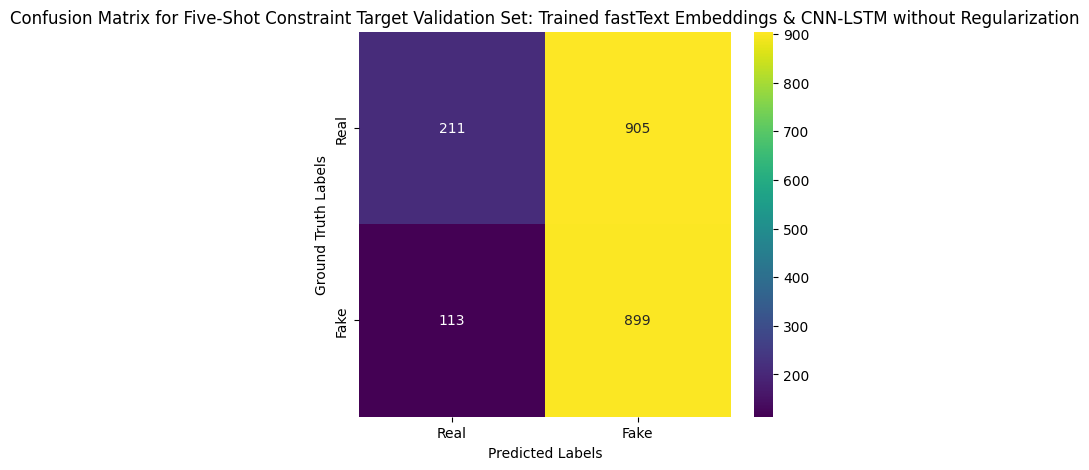

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.5113
Macro-Precision: 0.5564
Macro-Recall: 0.5291
Macro-F1 Score: 0.4545


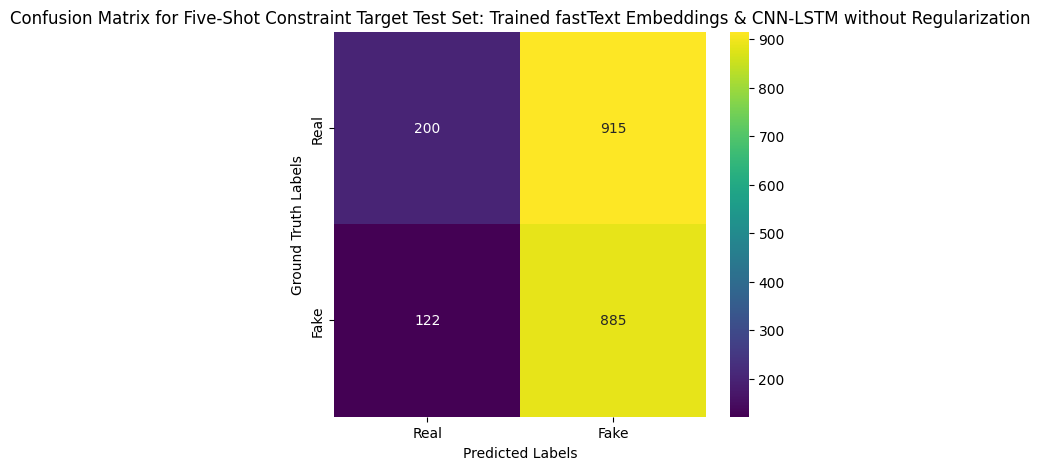

{'Real': {'precision': 0.6211180124223602,
  'recall': 0.17937219730941703,
  'f1-score': 0.2783576896311761,
  'support': 1115.0},
 'Fake': {'precision': 0.49166666666666664,
  'recall': 0.8788480635551142,
  'f1-score': 0.6305664410402565,
  'support': 1007.0},
 'accuracy': 0.5113100848256362,
 'macro avg': {'precision': 0.5563923395445134,
  'recall': 0.5291101304322656,
  'f1-score': 0.4544620653357163,
  'support': 2122.0},
 'weighted avg': {'precision': 0.5596865773724151,
  'recall': 0.5113100848256362,
  'f1-score': 0.44549916591248806,
  'support': 2122.0}}

In [37]:
five_shot_ct_model_no_reg, five_shot_ct_history_no_reg = trainCNN_LSTMWithoutRegularization(
    five_shot_ct_target_X_train,
    five_shot_ct_target_X_train_extra_scaled,
    five_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_no_reg,
    five_shot_ct_target_X_val,
    five_shot_ct_target_X_val_extra_scaled,
    five_shot_ct_target_y_val, 
    "Five-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_no_reg,
    five_shot_ct_target_X_test,
    five_shot_ct_target_X_test_extra_scaled,
    five_shot_ct_target_y_test, 
    "Five-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5775 - f1_score: 0.5155 - loss: 0.6759 - val_accuracy: 0.6660 - val_f1_score: 0.5582 - val_loss: 0.6085
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6673 - f1_score: 0.6337 - loss: 0.6095 - val_accuracy: 0.7940 - val_f1_score: 0.7874 - val_loss: 0.4740
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7607 - f1_score: 0.7516 - loss: 0.5440 - val_accuracy: 0.7320 - val_f1_score: 0.7319 - val_loss: 0.5266
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7791 - f1_score: 0.7732 - loss: 0.5213 - val_accuracy: 0.7670 - val_f1_score: 0.7663 - val_loss: 0.5006
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7969 - f1_score: 0.7896 - loss: 0.4652 - val_accuracy: 0.7720 - val_f1_score: 0.7716 - val_loss: 0.5197
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

Model Evaluation:
Accuracy: 0.565

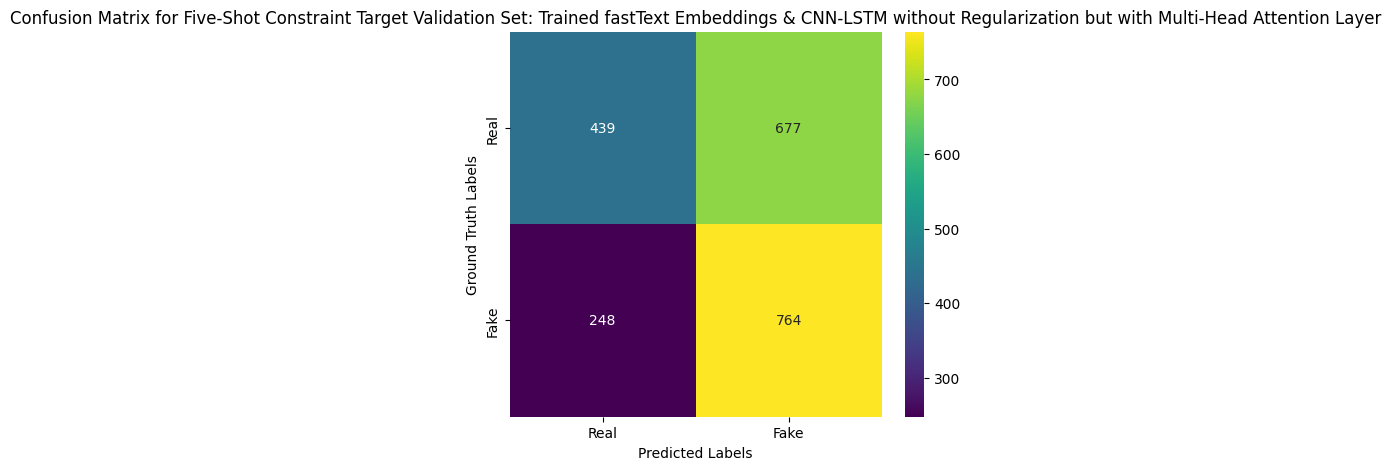

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Model Evaluation:
Accuracy: 0.5485
Macro-Precision: 0.5683
Macro-Recall: 0.5584
Macro-F1 Score: 0.5358


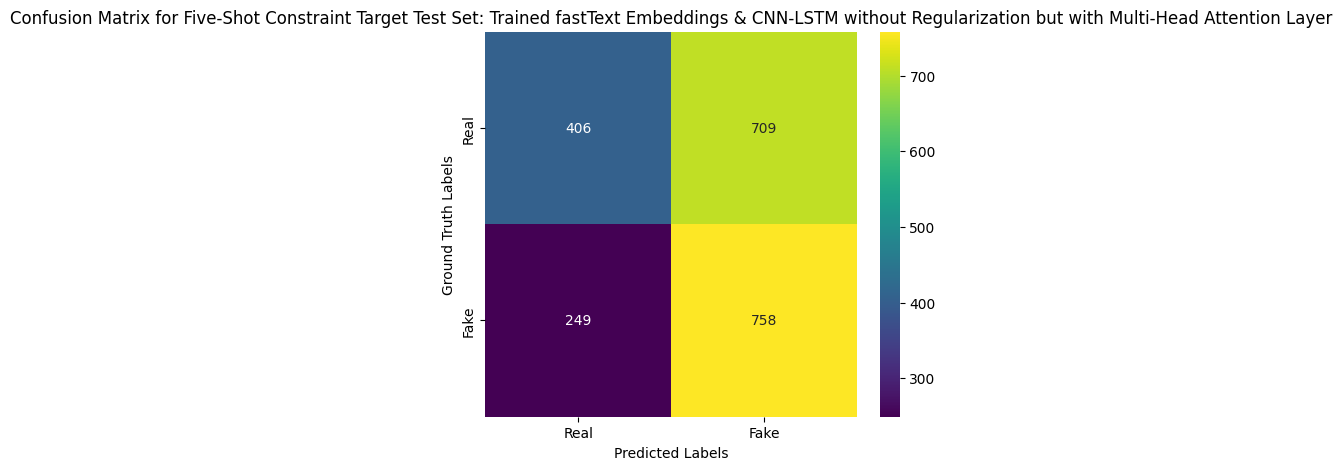

{'Real': {'precision': 0.6198473282442748,
  'recall': 0.36412556053811657,
  'f1-score': 0.45875706214689266,
  'support': 1115.0},
 'Fake': {'precision': 0.5167007498295841,
  'recall': 0.7527308838133069,
  'f1-score': 0.6127728375101051,
  'support': 1007.0},
 'accuracy': 0.5485391140433553,
 'macro avg': {'precision': 0.5682740390369294,
  'recall': 0.5584282221757118,
  'f1-score': 0.5357649498284989,
  'support': 2122.0},
 'weighted avg': {'precision': 0.570898881277454,
  'recall': 0.5485391140433553,
  'f1-score': 0.5318456039898498,
  'support': 2122.0}}

In [39]:
five_shot_ct_model_no_reg_mt_att, five_shot_ct_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    five_shot_ct_target_X_train,
    five_shot_ct_target_X_train_extra_scaled,
    five_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_no_reg_mt_att,
    five_shot_ct_target_X_val,
    five_shot_ct_target_X_val_extra_scaled,
    five_shot_ct_target_y_val, 
    "Five-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    five_shot_ct_model_no_reg_mt_att,
    five_shot_ct_target_X_test,
    five_shot_ct_target_X_test_extra_scaled,
    five_shot_ct_target_y_test, 
    "Five-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)


### Five-Shot - Target: PolitiFact

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5696 - f1_score: 0.3915 - loss: 2.9175 - val_accuracy: 0.6430 - val_f1_score: 0.5793 - val_loss: 1.3036
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6183 - f1_score: 0.5784 - loss: 1.1270 - val_accuracy: 0.6310 - val_f1_score: 0.6008 - val_loss: 0.7809
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6218 - f1_score: 0.5944 - loss: 0.7485 - val_accuracy: 0.6420 - val_f1_score: 0.5988 - val_loss: 0.6683
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6343 - f1_score: 0.6076 - loss: 0.6684 - val_accuracy: 0.6420 - val_f1_score: 0.5914 - val_loss: 0.6454
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6228 - f1_score: 0.5940 - loss: 0.6600 - val_accuracy: 0.6480 - val_f1_score: 0.6122 - val_loss: 0.6415
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6346 - f1_

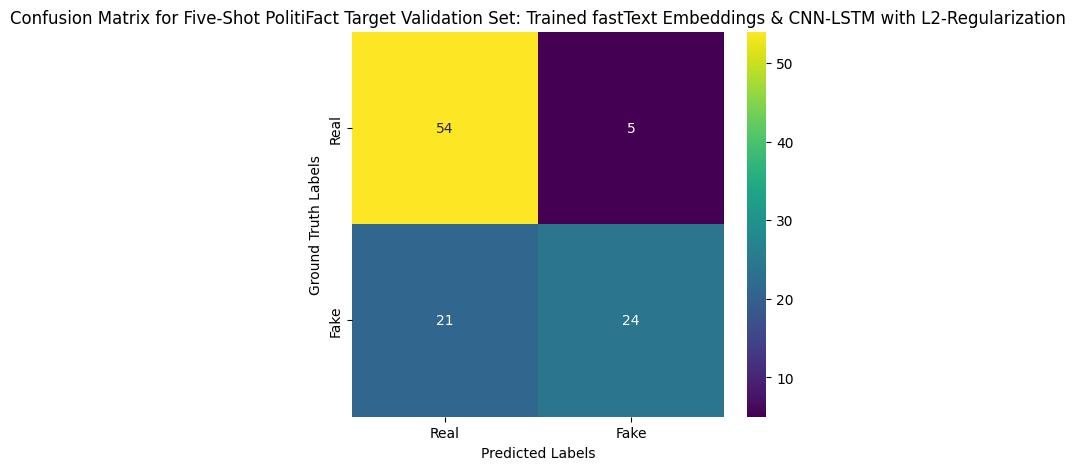

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Model Evaluation:
Accuracy: 0.6111
Macro-Precision: 0.6735
Macro-Recall: 0.6201
Macro-F1 Score: 0.5825


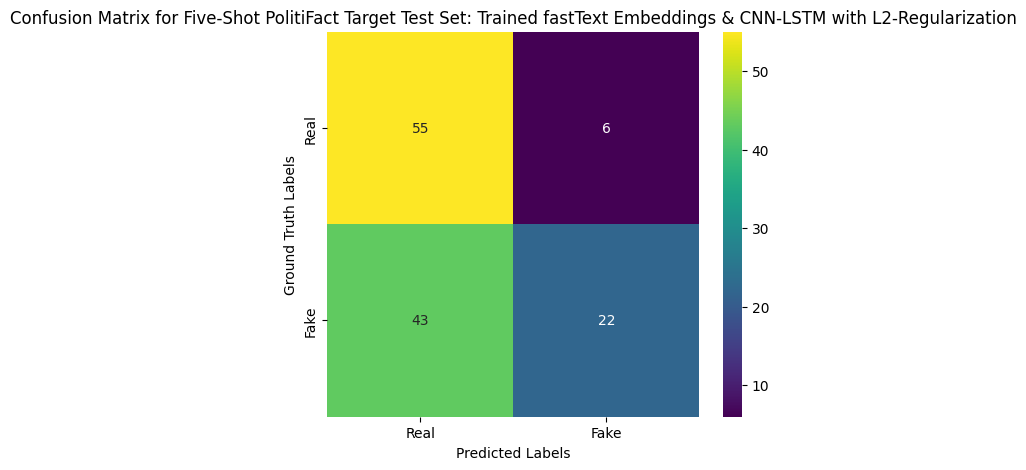

{'Real': {'precision': 0.5612244897959183,
  'recall': 0.9016393442622951,
  'f1-score': 0.6918238993710691,
  'support': 61.0},
 'Fake': {'precision': 0.7857142857142857,
  'recall': 0.3384615384615385,
  'f1-score': 0.4731182795698925,
  'support': 65.0},
 'accuracy': 0.6111111111111112,
 'macro avg': {'precision': 0.673469387755102,
  'recall': 0.6200504413619168,
  'f1-score': 0.5824710894704808,
  'support': 126.0},
 'weighted avg': {'precision': 0.6770327178490443,
  'recall': 0.6111111111111112,
  'f1-score': 0.578999571695859,
  'support': 126.0}}

In [60]:
five_shot_pf_model_l2_reg, five_shot_pf_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    five_shot_pf_target_X_train,
    five_shot_pf_target_X_train_extra_scaled,
    five_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_l2_reg,
    five_shot_pf_target_X_val,
    five_shot_pf_target_X_val_extra_scaled,
    five_shot_pf_target_y_val, 
    "Five-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_l2_reg,
    five_shot_pf_target_X_test,
    five_shot_pf_target_X_test_extra_scaled,
    five_shot_pf_target_y_test, 
    "Five-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5676 - f1_score: 0.3829 - loss: 28.1350 - val_accuracy: 0.6320 - val_f1_score: 0.5254 - val_loss: 9.9728
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6041 - f1_score: 0.5164 - loss: 6.8987 - val_accuracy: 0.6270 - val_f1_score: 0.5171 - val_loss: 1.7009
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6102 - f1_score: 0.5476 - loss: 1.2719 - val_accuracy: 0.6280 - val_f1_score: 0.5537 - val_loss: 0.7402
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6202 - f1_score: 0.5719 - loss: 0.7344 - val_accuracy: 0.6310 - val_f1_score: 0.5620 - val_loss: 0.7214
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6222 - f1_score: 0.5822 - loss: 0.7253 - val_accuracy: 0.6320 - val_f1_score: 0.5644 - val_loss: 0.7176
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6193 - f1

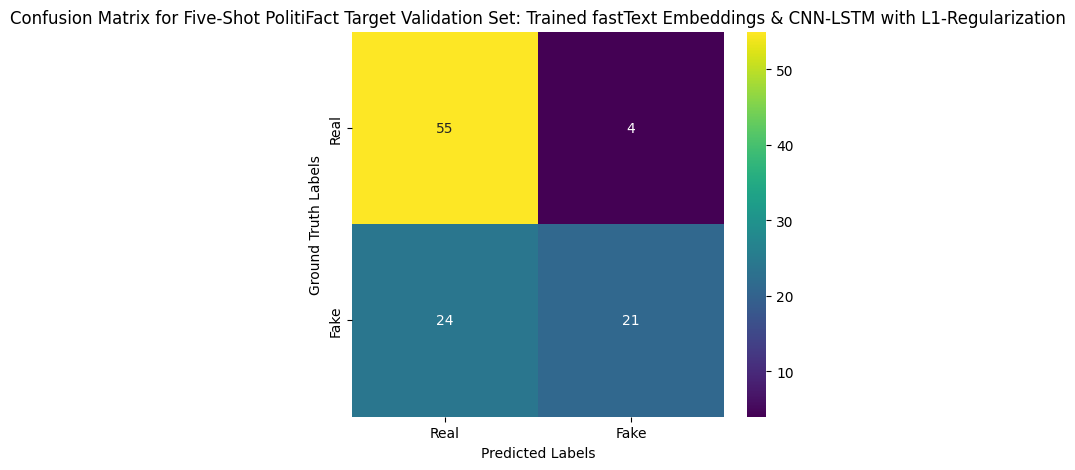

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Model Evaluation:
Accuracy: 0.6111
Macro-Precision: 0.6961
Macro-Recall: 0.6211
Macro-F1 Score: 0.5744


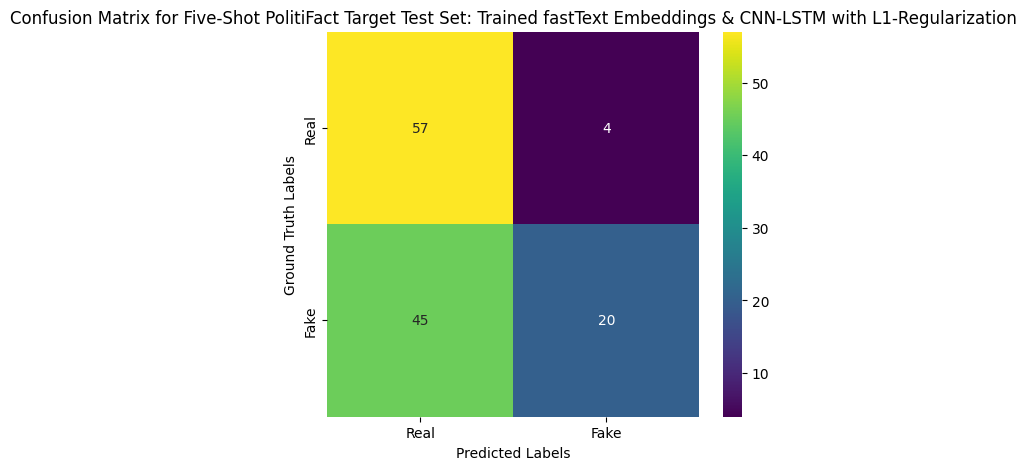

{'Real': {'precision': 0.5588235294117647,
  'recall': 0.9344262295081968,
  'f1-score': 0.6993865030674846,
  'support': 61.0},
 'Fake': {'precision': 0.8333333333333334,
  'recall': 0.3076923076923077,
  'f1-score': 0.449438202247191,
  'support': 65.0},
 'accuracy': 0.6111111111111112,
 'macro avg': {'precision': 0.696078431372549,
  'recall': 0.6210592686002523,
  'f1-score': 0.5744123526573378,
  'support': 126.0},
 'weighted avg': {'precision': 0.7004357298474945,
  'recall': 0.6111111111111112,
  'f1-score': 0.570444919310984,
  'support': 126.0}}

In [43]:
five_shot_pf_model_l1_reg, five_shot_pf_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    five_shot_pf_target_X_train,
    five_shot_pf_target_X_train_extra_scaled,
    five_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_l1_reg,
    five_shot_pf_target_X_val,
    five_shot_pf_target_X_val_extra_scaled,
    five_shot_pf_target_y_val, 
    "Five-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_l1_reg,
    five_shot_pf_target_X_test,
    five_shot_pf_target_X_test_extra_scaled,
    five_shot_pf_target_y_test, 
    "Five-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5705 - f1_score: 0.3980 - loss: 0.6768 - val_accuracy: 0.6380 - val_f1_score: 0.5834 - val_loss: 0.6556
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6062 - f1_score: 0.5711 - loss: 0.6568 - val_accuracy: 0.6470 - val_f1_score: 0.6181 - val_loss: 0.6377
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6184 - f1_score: 0.5943 - loss: 0.6409 - val_accuracy: 0.5790 - val_f1_score: 0.5774 - val_loss: 0.6563
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6478 - f1_score: 0.6406 - loss: 0.6253 - val_accuracy: 0.5420 - val_f1_score: 0.5225 - val_loss: 0.6614
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5944 - f1_score: 0.5658 - loss: 0.6659 - val_accuracy: 0.6430 - val_f1_score: 0.5902 - val_loss: 0.6458
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Model Evaluation:
Accuracy: 0.7596
M

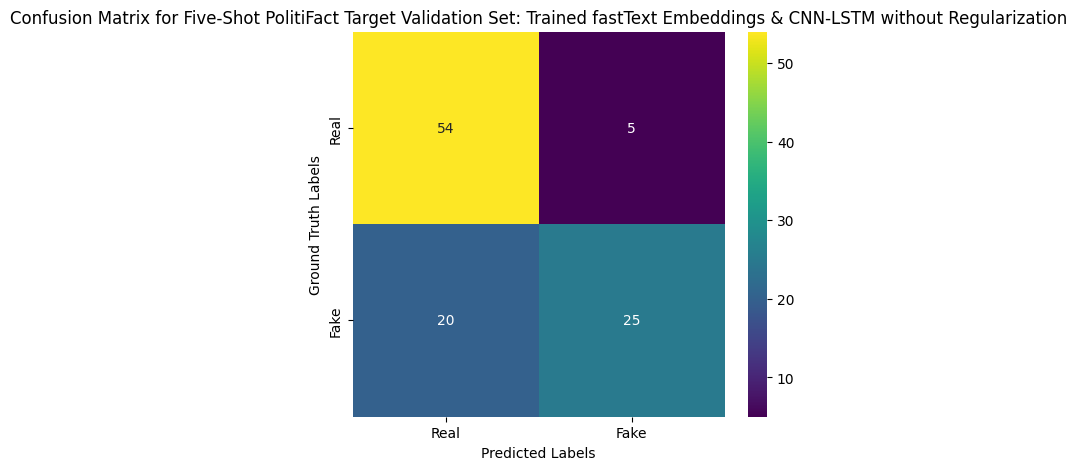

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Model Evaluation:
Accuracy: 0.6190
Macro-Precision: 0.6713
Macro-Recall: 0.6272
Macro-F1 Score: 0.5962


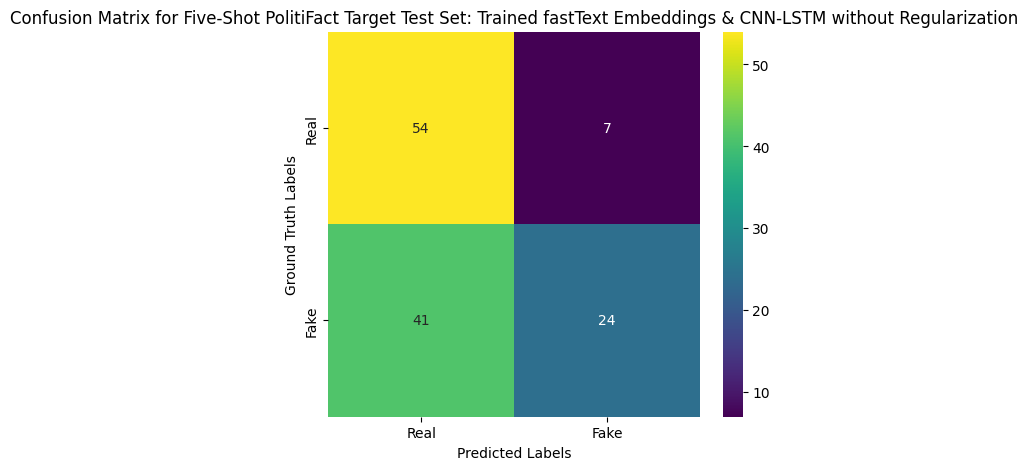

{'Real': {'precision': 0.5684210526315789,
  'recall': 0.8852459016393442,
  'f1-score': 0.6923076923076923,
  'support': 61.0},
 'Fake': {'precision': 0.7741935483870968,
  'recall': 0.36923076923076925,
  'f1-score': 0.5,
  'support': 65.0},
 'accuracy': 0.6190476190476191,
 'macro avg': {'precision': 0.6713073005093378,
  'recall': 0.6272383354350568,
  'f1-score': 0.5961538461538461,
  'support': 126.0},
 'weighted avg': {'precision': 0.6745735306006952,
  'recall': 0.6190476190476191,
  'f1-score': 0.5931013431013431,
  'support': 126.0}}

In [45]:
five_shot_pf_model_no_reg, five_shot_pf_history_no_reg = trainCNN_LSTMWithoutRegularization(
    five_shot_pf_target_X_train,
    five_shot_pf_target_X_train_extra_scaled,
    five_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_no_reg,
    five_shot_pf_target_X_val,
    five_shot_pf_target_X_val_extra_scaled,
    five_shot_pf_target_y_val, 
    "Five-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_no_reg,
    five_shot_pf_target_X_test,
    five_shot_pf_target_X_test_extra_scaled,
    five_shot_pf_target_y_test, 
    "Five-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5762 - f1_score: 0.5465 - loss: 0.6766 - val_accuracy: 0.6890 - val_f1_score: 0.6589 - val_loss: 0.6061
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7239 - f1_score: 0.7177 - loss: 0.5725 - val_accuracy: 0.7310 - val_f1_score: 0.7219 - val_loss: 0.5475
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7766 - f1_score: 0.7698 - loss: 0.5166 - val_accuracy: 0.7380 - val_f1_score: 0.7249 - val_loss: 0.5567
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7910 - f1_score: 0.7852 - loss: 0.4881 - val_accuracy: 0.7890 - val_f1_score: 0.7755 - val_loss: 0.4812
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8085 - f1_score: 0.8021 - loss: 0.4586 - val_accuracy: 0.7220 - val_f1_score: 0.7219 - val_loss: 0.5361
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8148 - f1_

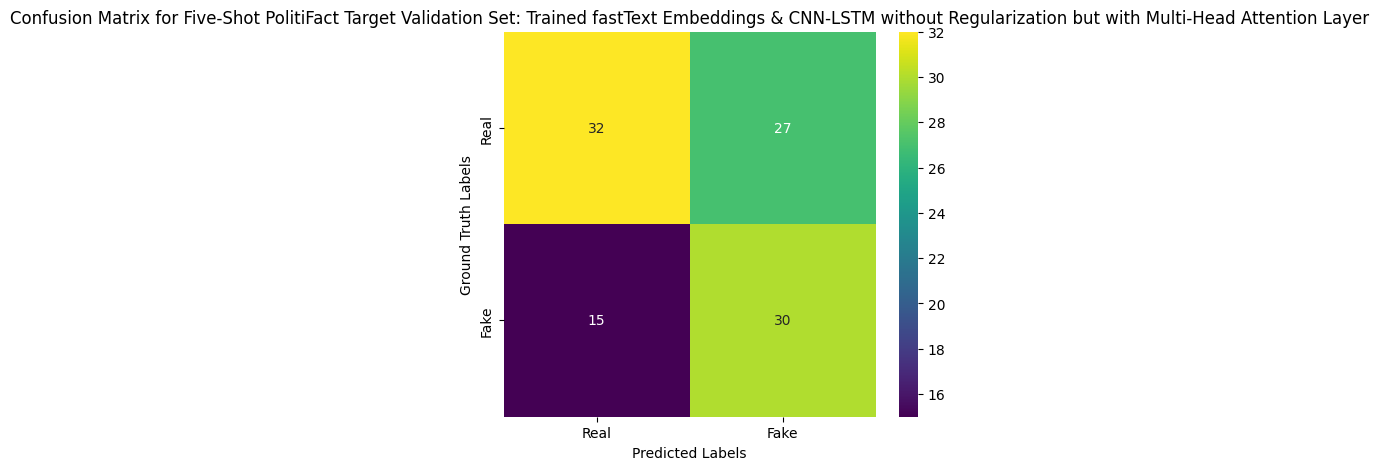

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Model Evaluation:
Accuracy: 0.6349
Macro-Precision: 0.6382
Macro-Recall: 0.6315
Macro-F1 Score: 0.6289


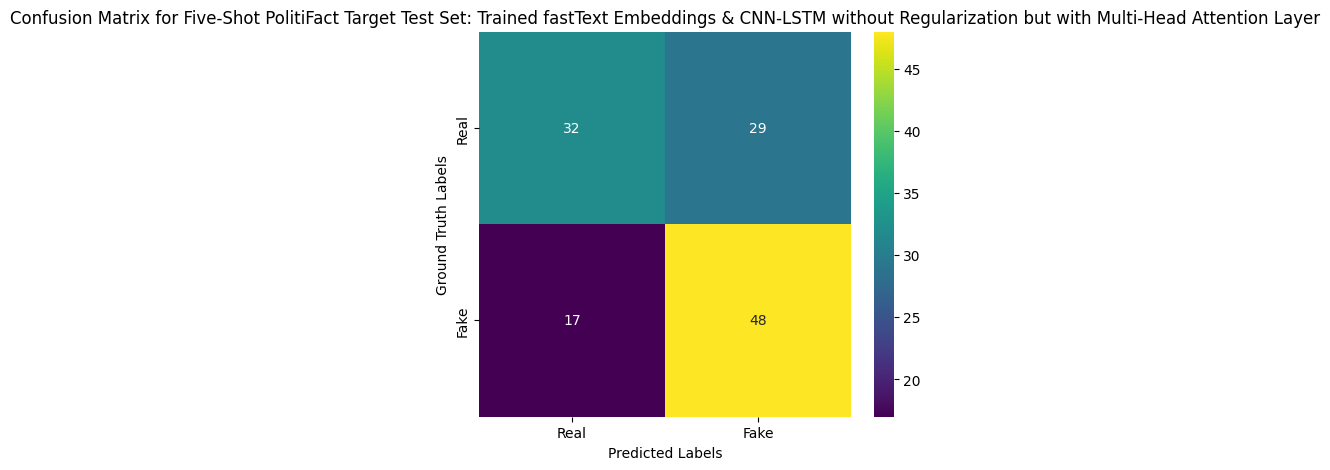

{'Real': {'precision': 0.6530612244897959,
  'recall': 0.5245901639344263,
  'f1-score': 0.5818181818181818,
  'support': 61.0},
 'Fake': {'precision': 0.6233766233766234,
  'recall': 0.7384615384615385,
  'f1-score': 0.676056338028169,
  'support': 65.0},
 'accuracy': 0.6349206349206349,
 'macro avg': {'precision': 0.6382189239332097,
  'recall': 0.6315258511979824,
  'f1-score': 0.6289372599231754,
  'support': 126.0},
 'weighted avg': {'precision': 0.6377477397885561,
  'recall': 0.6349206349206349,
  'f1-score': 0.6304331036725402,
  'support': 126.0}}

In [47]:
five_shot_pf_model_no_reg_mt_att, five_shot_pf_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    five_shot_pf_target_X_train,
    five_shot_pf_target_X_train_extra_scaled,
    five_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_no_reg_mt_att,
    five_shot_pf_target_X_val,
    five_shot_pf_target_X_val_extra_scaled,
    five_shot_pf_target_y_val, 
    "Five-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    five_shot_pf_model_no_reg_mt_att,
    five_shot_pf_target_X_test,
    five_shot_pf_target_X_test_extra_scaled,
    five_shot_pf_target_y_test, 
    "Five-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)


### Five-Shot - Target: GossipCop

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5520 - f1_score: 0.4486 - loss: 2.9217 - val_accuracy: 0.6510 - val_f1_score: 0.6501 - val_loss: 1.3200
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6217 - f1_score: 0.6186 - loss: 1.1307 - val_accuracy: 0.6330 - val_f1_score: 0.6070 - val_loss: 0.8072
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6490 - f1_score: 0.6339 - loss: 0.7651 - val_accuracy: 0.6490 - val_f1_score: 0.6454 - val_loss: 0.6731
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6486 - f1_score: 0.6412 - loss: 0.6603 - val_accuracy: 0.6440 - val_f1_score: 0.6377 - val_loss: 0.6494
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6634 - f1_score: 0.6527 - loss: 0.6391 - val_accuracy: 0.6780 - val_f1_score: 0.6649 - val_loss: 0.6051
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6541 - f1_

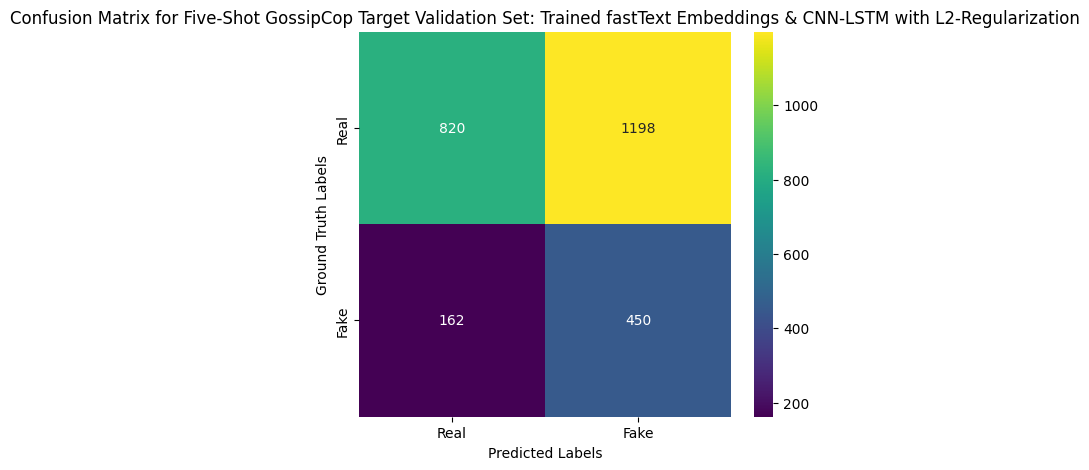

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.4817
Macro-Precision: 0.5447
Macro-Recall: 0.5587
Macro-F1 Score: 0.4699


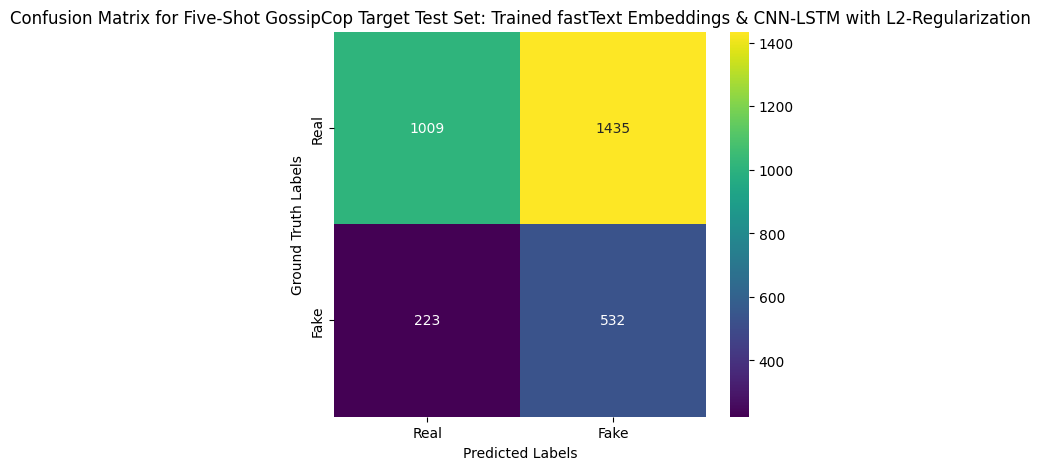

{'Real': {'precision': 0.8189935064935064,
  'recall': 0.412847790507365,
  'f1-score': 0.5489662676822633,
  'support': 2444.0},
 'Fake': {'precision': 0.2704626334519573,
  'recall': 0.704635761589404,
  'f1-score': 0.3908890521675239,
  'support': 755.0},
 'accuracy': 0.4817130353235386,
 'macro avg': {'precision': 0.5447280699727319,
  'recall': 0.5587417760483845,
  'f1-score': 0.4699276599248936,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6895340475543474,
  'recall': 0.4817130353235386,
  'f1-score': 0.5116582658961963,
  'support': 3199.0}}

In [49]:
five_shot_gc_model_l2_reg, five_shot_gc_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    five_shot_gc_target_X_train,
    five_shot_gc_target_X_train_extra_scaled,
    five_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_l2_reg,
    five_shot_gc_target_X_val,
    five_shot_gc_target_X_val_extra_scaled,
    five_shot_gc_target_y_val, 
    "Five-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_l2_reg,
    five_shot_gc_target_X_test,
    five_shot_gc_target_X_test_extra_scaled,
    five_shot_gc_target_y_test, 
    "Five-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)


#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5446 - f1_score: 0.4289 - loss: 28.1380 - val_accuracy: 0.6510 - val_f1_score: 0.6369 - val_loss: 9.9794
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6027 - f1_score: 0.5731 - loss: 6.9081 - val_accuracy: 0.6100 - val_f1_score: 0.6100 - val_loss: 1.7082
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6279 - f1_score: 0.6179 - loss: 1.2669 - val_accuracy: 0.6110 - val_f1_score: 0.6108 - val_loss: 0.7370
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6292 - f1_score: 0.6222 - loss: 0.7202 - val_accuracy: 0.6320 - val_f1_score: 0.6308 - val_loss: 0.7146
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6437 - f1_score: 0.6357 - loss: 0.7050 - val_accuracy: 0.6420 - val_f1_score: 0.6389 - val_loss: 0.7069
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6464 - f1

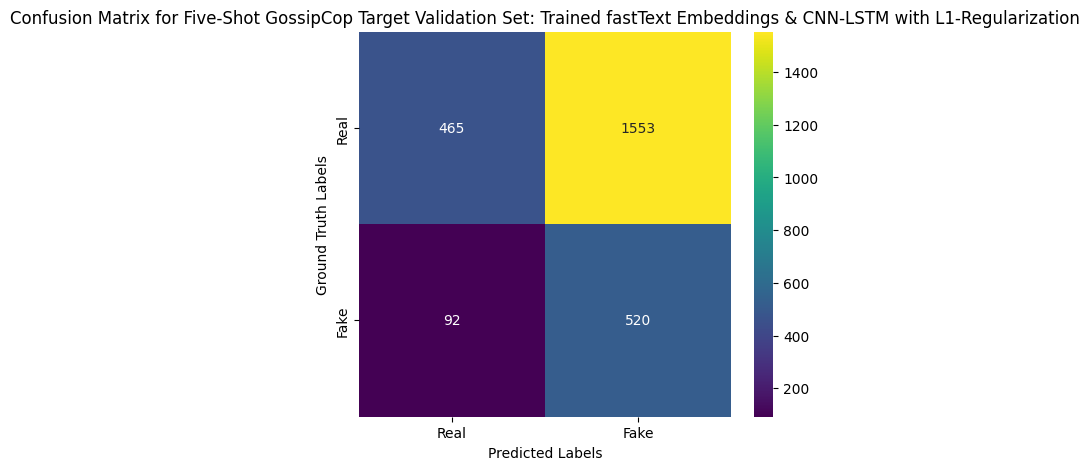

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.3839
Macro-Precision: 0.5447
Macro-Recall: 0.5428
Macro-F1 Score: 0.3837


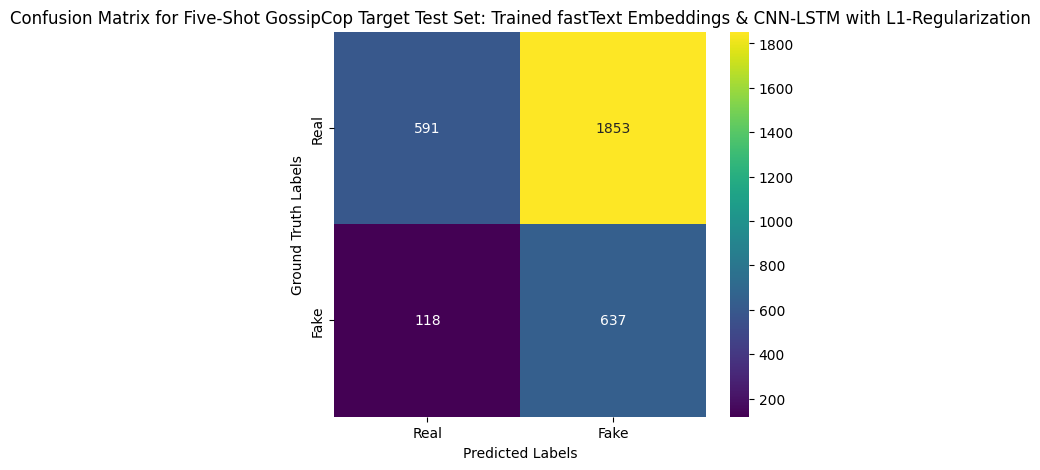

{'Real': {'precision': 0.8335684062059239,
  'recall': 0.2418166939443535,
  'f1-score': 0.3748810656517602,
  'support': 2444.0},
 'Fake': {'precision': 0.25582329317269076,
  'recall': 0.8437086092715231,
  'f1-score': 0.3926040061633282,
  'support': 755.0},
 'accuracy': 0.38386995936230073,
 'macro avg': {'precision': 0.5446958496893073,
  'recall': 0.5427626516079384,
  'f1-score': 0.3837425359075442,
  'support': 3199.0},
 'weighted avg': {'precision': 0.697214057865789,
  'recall': 0.38386995936230073,
  'f1-score': 0.37906387905789773,
  'support': 3199.0}}

In [51]:
five_shot_gc_model_l1_reg, five_shot_gc_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    five_shot_gc_target_X_train,
    five_shot_gc_target_X_train_extra_scaled,
    five_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_l1_reg,
    five_shot_gc_target_X_val,
    five_shot_gc_target_X_val_extra_scaled,
    five_shot_gc_target_y_val, 
    "Five-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_l1_reg,
    five_shot_gc_target_X_test,
    five_shot_gc_target_X_test_extra_scaled,
    five_shot_gc_target_y_test, 
    "Five-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5547 - f1_score: 0.4651 - loss: 0.6789 - val_accuracy: 0.6000 - val_f1_score: 0.5940 - val_loss: 0.6446
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6133 - f1_score: 0.6121 - loss: 0.6423 - val_accuracy: 0.6760 - val_f1_score: 0.6760 - val_loss: 0.5977
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7097 - f1_score: 0.7094 - loss: 0.5748 - val_accuracy: 0.7680 - val_f1_score: 0.7675 - val_loss: 0.5570
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7633 - f1_score: 0.7625 - loss: 0.5236 - val_accuracy: 0.6570 - val_f1_score: 0.6131 - val_loss: 0.6149
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7257 - f1_score: 0.7160 - loss: 0.5542 - val_accuracy: 0.7820 - val_f1_score: 0.7800 - val_loss: 0.4851
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7818 - f1_

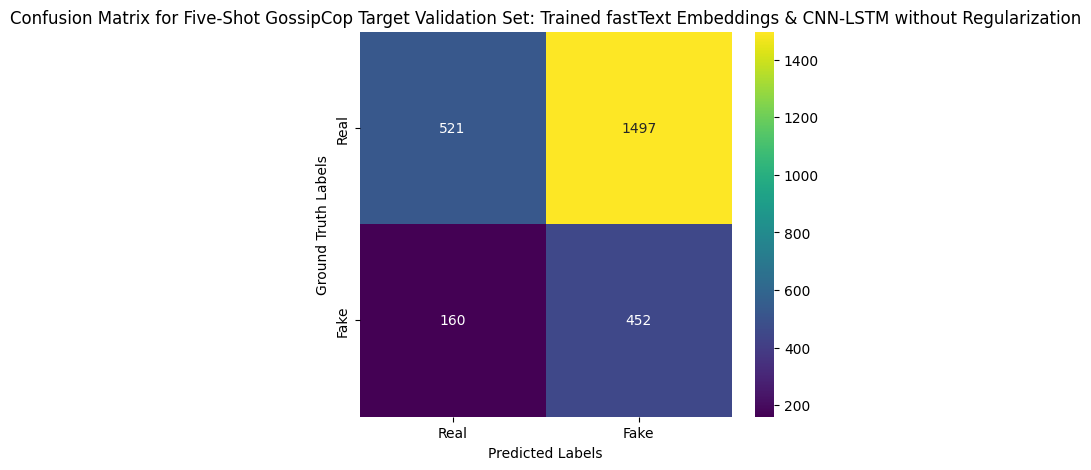

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.3926
Macro-Precision: 0.5093
Macro-Recall: 0.5105
Macro-F1 Score: 0.3913


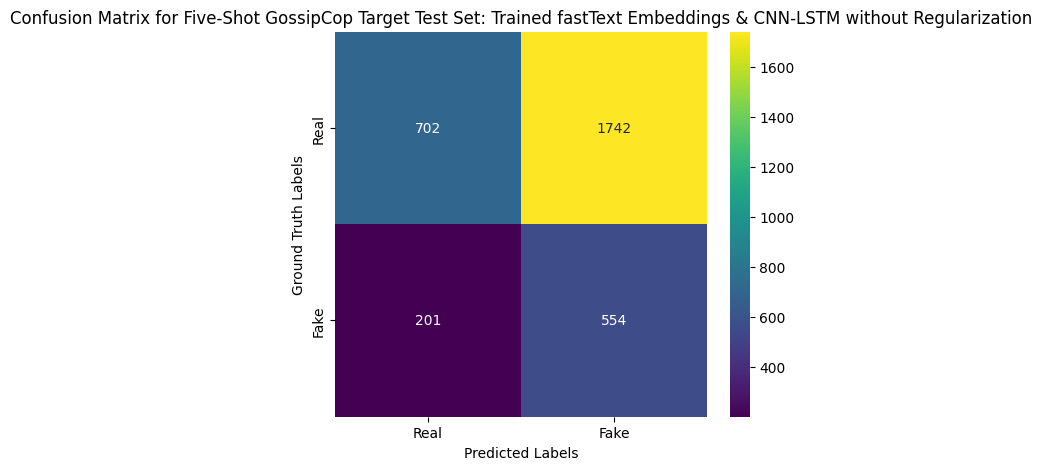

{'Real': {'precision': 0.7774086378737541,
  'recall': 0.2872340425531915,
  'f1-score': 0.4194801314610099,
  'support': 2444.0},
 'Fake': {'precision': 0.24128919860627177,
  'recall': 0.7337748344370861,
  'f1-score': 0.36315961979678796,
  'support': 755.0},
 'accuracy': 0.39262269459206,
 'macro avg': {'precision': 0.5093489182400129,
  'recall': 0.5105044384951388,
  'f1-score': 0.3913198756288989,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6508784169775524,
  'recall': 0.39262269459206,
  'f1-score': 0.40618785690443354,
  'support': 3199.0}}

In [53]:
five_shot_gc_model_no_reg, five_shot_gc_history_no_reg = trainCNN_LSTMWithoutRegularization(
    five_shot_gc_target_X_train,
    five_shot_gc_target_X_train_extra_scaled,
    five_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_no_reg,
    five_shot_gc_target_X_val,
    five_shot_gc_target_X_val_extra_scaled,
    five_shot_gc_target_y_val, 
    "Five-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_no_reg,
    five_shot_gc_target_X_test,
    five_shot_gc_target_X_test_extra_scaled,
    five_shot_gc_target_y_test, 
    "Five-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.5904 - f1_score: 0.5777 - loss: 0.6640 - val_accuracy: 0.7640 - val_f1_score: 0.7637 - val_loss: 0.5086
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7427 - f1_score: 0.7413 - loss: 0.5304 - val_accuracy: 0.7900 - val_f1_score: 0.7891 - val_loss: 0.4480
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7989 - f1_score: 0.7978 - loss: 0.4537 - val_accuracy: 0.8150 - val_f1_score: 0.8144 - val_loss: 0.4140
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8067 - f1_score: 0.8051 - loss: 0.4257 - val_accuracy: 0.8250 - val_f1_score: 0.8215 - val_loss: 0.3917
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8331 - f1_score: 0.8319 - loss: 0.3884 - val_accuracy: 0.8260 - val_f1_score: 0.8253 - val_loss: 0.3736
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8260 - f1_

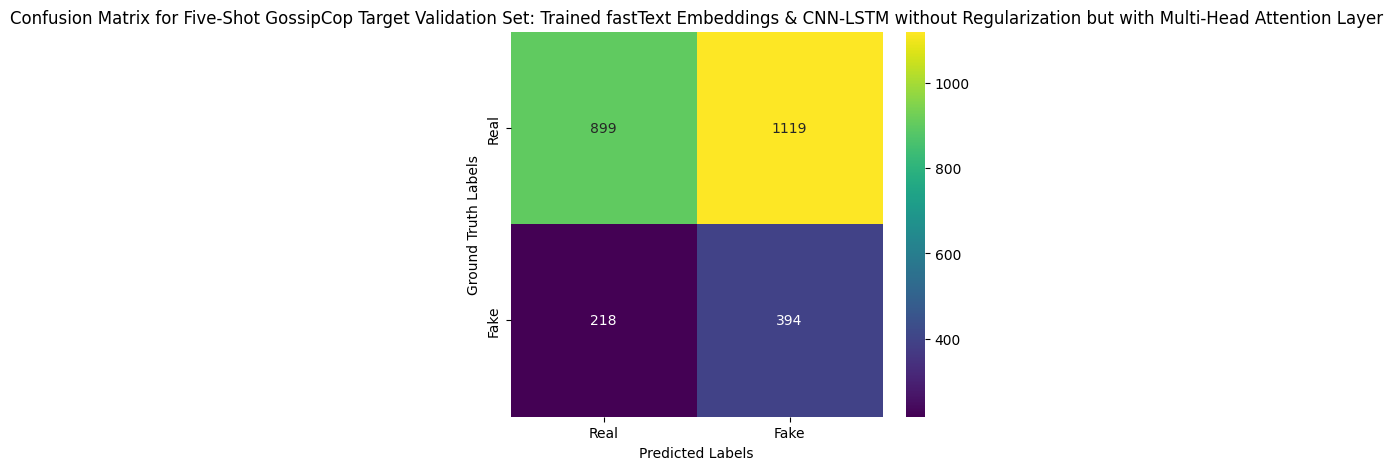

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Model Evaluation:
Accuracy: 0.4998
Macro-Precision: 0.5340
Macro-Recall: 0.5464
Macro-F1 Score: 0.4789


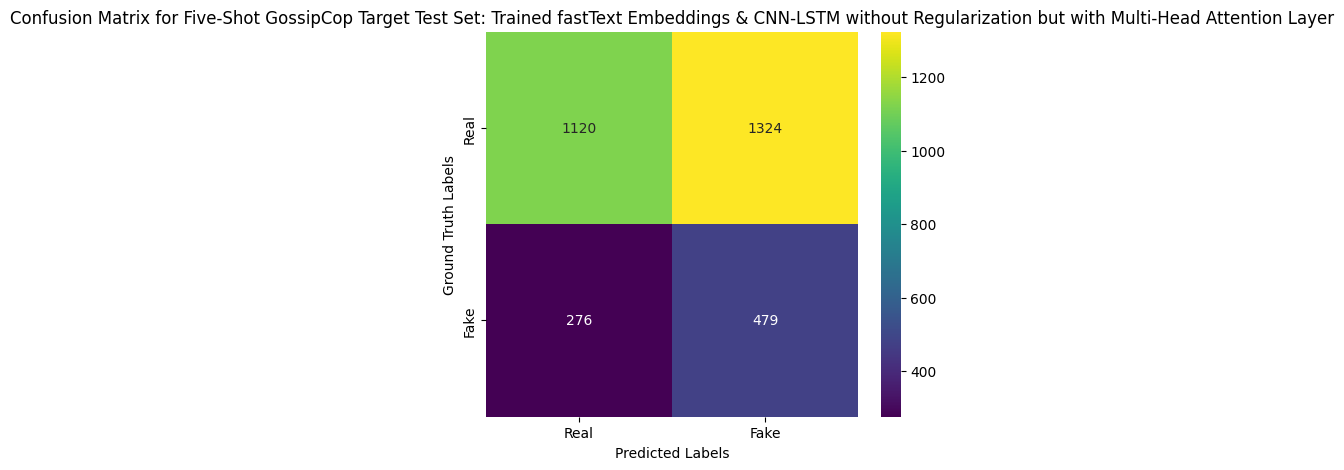

{'Real': {'precision': 0.8022922636103151,
  'recall': 0.4582651391162029,
  'f1-score': 0.5833333333333334,
  'support': 2444.0},
 'Fake': {'precision': 0.26566833056017747,
  'recall': 0.6344370860927152,
  'f1-score': 0.3745113369820172,
  'support': 755.0},
 'accuracy': 0.4998437011566114,
 'macro avg': {'precision': 0.5339802970852463,
  'recall': 0.5463511126044591,
  'f1-score': 0.4789223351576753,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6756429765040777,
  'recall': 0.4998437011566114,
  'f1-score': 0.5340489922125945,
  'support': 3199.0}}

In [55]:
five_shot_gc_model_no_reg_mt_att, five_shot_gc_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    five_shot_gc_target_X_train,
    five_shot_gc_target_X_train_extra_scaled,
    five_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_no_reg_mt_att,
    five_shot_gc_target_X_val,
    five_shot_gc_target_X_val_extra_scaled,
    five_shot_gc_target_y_val, 
    "Five-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    five_shot_gc_model_no_reg_mt_att,
    five_shot_gc_target_X_test,
    five_shot_gc_target_X_test_extra_scaled,
    five_shot_gc_target_y_test, 
    "Five-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)


### Zero-Shot - Target: WELFake

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6681 - f1_score: 0.4124 - loss: 1.9330 - val_accuracy: 0.6950 - val_f1_score: 0.4833 - val_loss: 0.6175
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.6975 - f1_score: 0.5431 - loss: 0.6111 - val_accuracy: 0.7051 - val_f1_score: 0.5668 - val_loss: 0.5897
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.7070 - f1_score: 0.5829 - loss: 0.5921 - val_accuracy: 0.7113 - val_f1_score: 0.5801 - val_loss: 0.5839
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7118 - f1_score: 0.5953 - loss: 0.5867 - val_accuracy: 0.7146 - val_f1_score: 0.5887 - val_loss: 0.5799
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7139 - f1_score: 0.6003 - loss: 0.5819 - val_accuracy: 0.7177 - val_f1_score: 0.5951 - val_loss: 0.5763
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accu

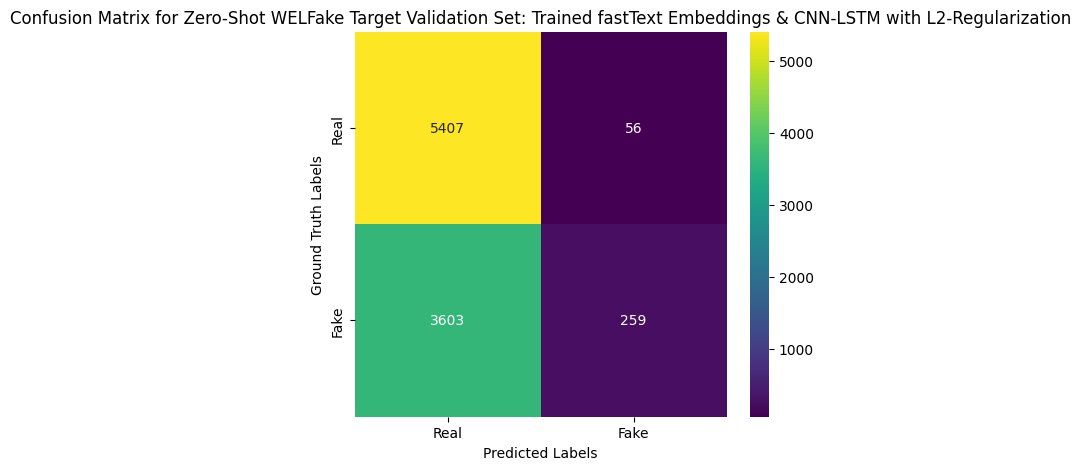

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step 

Model Evaluation:
Accuracy: 0.6353
Macro-Precision: 0.7097
Macro-Recall: 0.5219
Macro-F1 Score: 0.4348


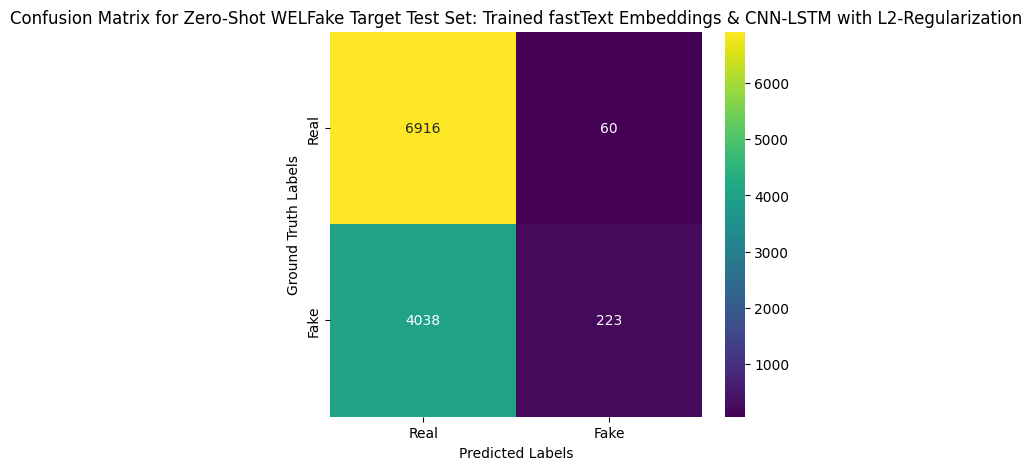

{'Real': {'precision': 0.6313675369727954,
  'recall': 0.9913990825688074,
  'f1-score': 0.7714445064138316,
  'support': 6976.0},
 'Fake': {'precision': 0.7879858657243817,
  'recall': 0.05233513259798169,
  'f1-score': 0.09815140845070422,
  'support': 4261.0},
 'accuracy': 0.6353119159918128,
 'macro avg': {'precision': 0.7096767013485885,
  'recall': 0.5218671075833945,
  'f1-score': 0.4347979574322679,
  'support': 11237.0},
 'weighted avg': {'precision': 0.6907562260188493,
  'recall': 0.6353119159918128,
  'f1-score': 0.5161359818591563,
  'support': 11237.0}}

In [20]:
zero_shot_wf_model_l2_reg, zero_shot_wf_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    zero_shot_wf_target_X_train,
    zero_shot_wf_target_X_train_extra_scaled,
    zero_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_l2_reg,
    zero_shot_wf_target_X_val,
    zero_shot_wf_target_X_val_extra_scaled,
    zero_shot_wf_target_y_val, 
    "Zero-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_l2_reg,
    zero_shot_wf_target_X_test,
    zero_shot_wf_target_X_test_extra_scaled,
    zero_shot_wf_target_y_test, 
    "Zero-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6683 - f1_score: 0.4144 - loss: 16.9524 - val_accuracy: 0.7023 - val_f1_score: 0.5126 - val_loss: 0.6706
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7004 - f1_score: 0.5510 - loss: 0.6732 - val_accuracy: 0.7062 - val_f1_score: 0.5716 - val_loss: 0.6586
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7073 - f1_score: 0.5828 - loss: 0.6616 - val_accuracy: 0.7124 - val_f1_score: 0.5802 - val_loss: 0.6529
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7133 - f1_score: 0.5987 - loss: 0.6566 - val_accuracy: 0.7152 - val_f1_score: 0.5935 - val_loss: 0.6499
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7140 - f1_score: 0.6028 - loss: 0.6512 - val_accuracy: 0.7194 - val_f1_score: 0.5983 - val_loss: 0.6452
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - acc

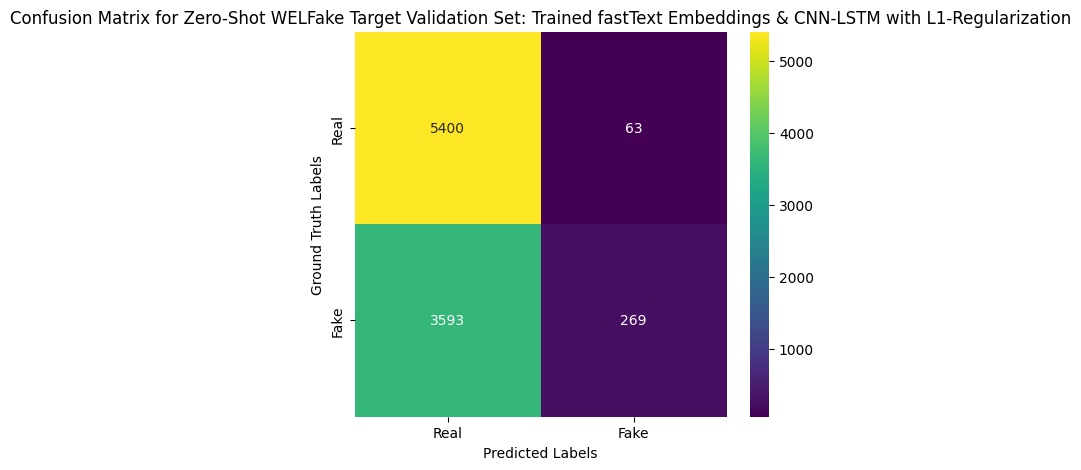

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Model Evaluation:
Accuracy: 0.6359
Macro-Precision: 0.7105
Macro-Recall: 0.5228
Macro-F1 Score: 0.4368


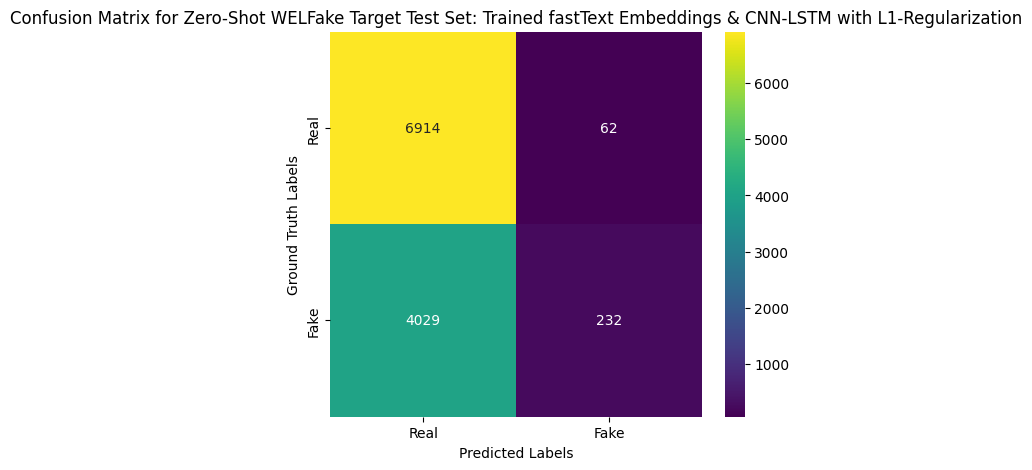

{'Real': {'precision': 0.631819427944805,
  'recall': 0.9911123853211009,
  'f1-score': 0.7716948490429153,
  'support': 6976.0},
 'Fake': {'precision': 0.7891156462585034,
  'recall': 0.05444731283736212,
  'f1-score': 0.10186608122941822,
  'support': 4261.0},
 'accuracy': 0.6359348580582006,
 'macro avg': {'precision': 0.7104675371016542,
  'recall': 0.5227798490792315,
  'f1-score': 0.43678046513616675,
  'support': 11237.0},
 'weighted avg': {'precision': 0.691465168465822,
  'recall': 0.6359348580582006,
  'f1-score': 0.5176999767768913,
  'support': 11237.0}}

In [22]:
zero_shot_wf_model_l1_reg, zero_shot_wf_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    zero_shot_wf_target_X_train,
    zero_shot_wf_target_X_train_extra_scaled,
    zero_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_l1_reg,
    zero_shot_wf_target_X_val,
    zero_shot_wf_target_X_val_extra_scaled,
    zero_shot_wf_target_y_val, 
    "Zero-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_l1_reg,
    zero_shot_wf_target_X_test,
    zero_shot_wf_target_X_test_extra_scaled,
    zero_shot_wf_target_y_test, 
    "Zero-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.6689 - f1_score: 0.4162 - loss: 0.6267 - val_accuracy: 0.6908 - val_f1_score: 0.4640 - val_loss: 0.6017
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7106 - f1_score: 0.5834 - loss: 0.5908 - val_accuracy: 0.7303 - val_f1_score: 0.5919 - val_loss: 0.5657
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7216 - f1_score: 0.6005 - loss: 0.5784 - val_accuracy: 0.7169 - val_f1_score: 0.5955 - val_loss: 0.5708
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7172 - f1_score: 0.6270 - loss: 0.5735 - val_accuracy: 0.7205 - val_f1_score: 0.6067 - val_loss: 0.5659
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.7273 - f1_score: 0.6367 - loss: 0.5665 - val_accuracy: 0.7267 - val_f1_score: 0.6192 - val_loss: 0.5635
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accu

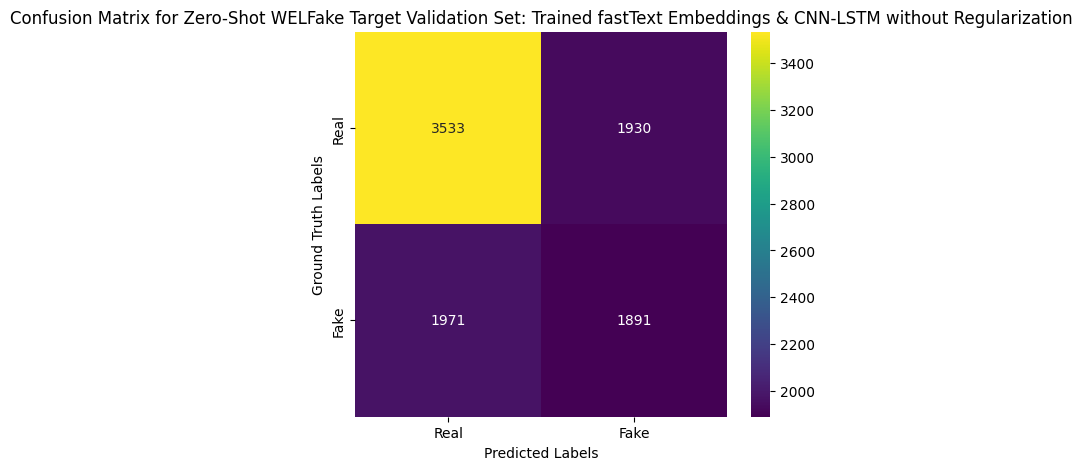

352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

Model Evaluation:
Accuracy: 0.5926
Macro-Precision: 0.5711
Macro-Recall: 0.5725
Macro-F1 Score: 0.5715


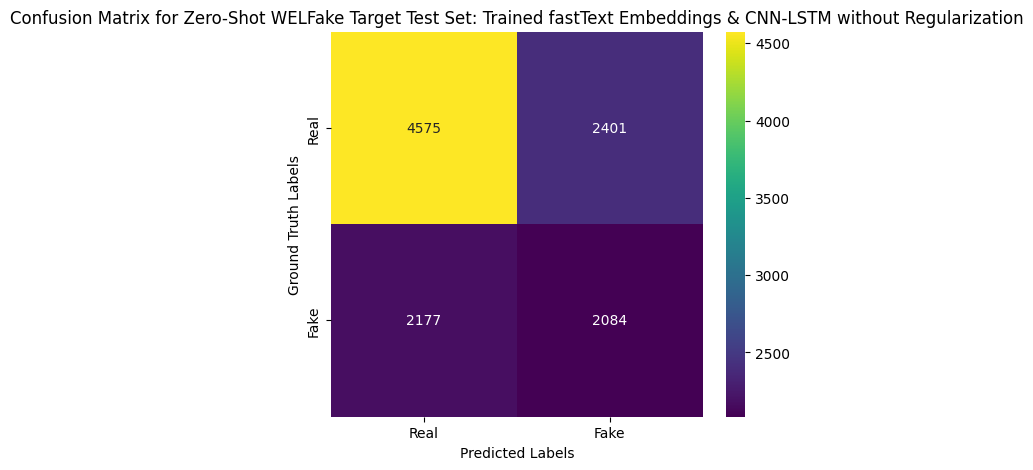

{'Real': {'precision': 0.6775770142180095,
  'recall': 0.6558199541284404,
  'f1-score': 0.6665209790209791,
  'support': 6976.0},
 'Fake': {'precision': 0.46465997770345596,
  'recall': 0.4890870687632011,
  'f1-score': 0.4765607134690144,
  'support': 4261.0},
 'accuracy': 0.5925958885823618,
 'macro avg': {'precision': 0.5711184959607327,
  'recall': 0.5724535114458208,
  'f1-score': 0.5715408462449967,
  'support': 11237.0},
 'weighted avg': {'precision': 0.5968402079006193,
  'recall': 0.5925958885823618,
  'f1-score': 0.5944892364280342,
  'support': 11237.0}}

In [24]:
zero_shot_wf_model_no_reg, zero_shot_wf_history_no_reg = trainCNN_LSTMWithoutRegularization(
    zero_shot_wf_target_X_train,
    zero_shot_wf_target_X_train_extra_scaled,
    zero_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_no_reg,
    zero_shot_wf_target_X_val,
    zero_shot_wf_target_X_val_extra_scaled,
    zero_shot_wf_target_y_val, 
    "Zero-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_no_reg,
    zero_shot_wf_target_X_test,
    zero_shot_wf_target_X_test_extra_scaled,
    zero_shot_wf_target_y_test, 
    "Zero-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

In [25]:
# Clears all the memory
tf.keras.backend.clear_session(
    free_memory=True
)
gc.collect()
del zero_shot_wf_model_no_reg

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.6956 - f1_score: 0.5937 - loss: 0.6012 - val_accuracy: 0.7732 - val_f1_score: 0.6998 - val_loss: 0.5346
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.7518 - f1_score: 0.6844 - loss: 0.5550 - val_accuracy: 0.7141 - val_f1_score: 0.6985 - val_loss: 0.5380
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.7682 - f1_score: 0.7252 - loss: 0.5123 - val_accuracy: 0.8001 - val_f1_score: 0.7397 - val_loss: 0.4725
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.7955 - f1_score: 0.7458 - loss: 0.4755 - val_accuracy: 0.8188 - val_f1_score: 0.7684 - val_loss: 0.4437
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8270 - f1_score: 0.7903 - loss: 0.4333 - val_accuracy: 0.8297 - val_f1_score: 0.7850 - val_loss: 0.3947
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accu

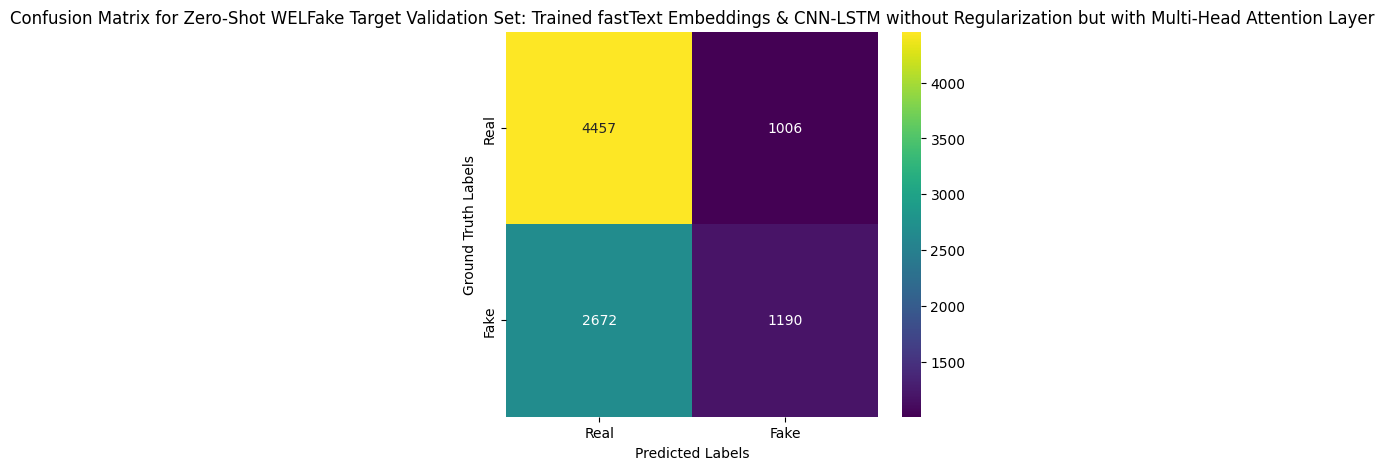

352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

Model Evaluation:
Accuracy: 0.6275
Macro-Precision: 0.5882
Macro-Recall: 0.5673
Macro-F1 Score: 0.5623


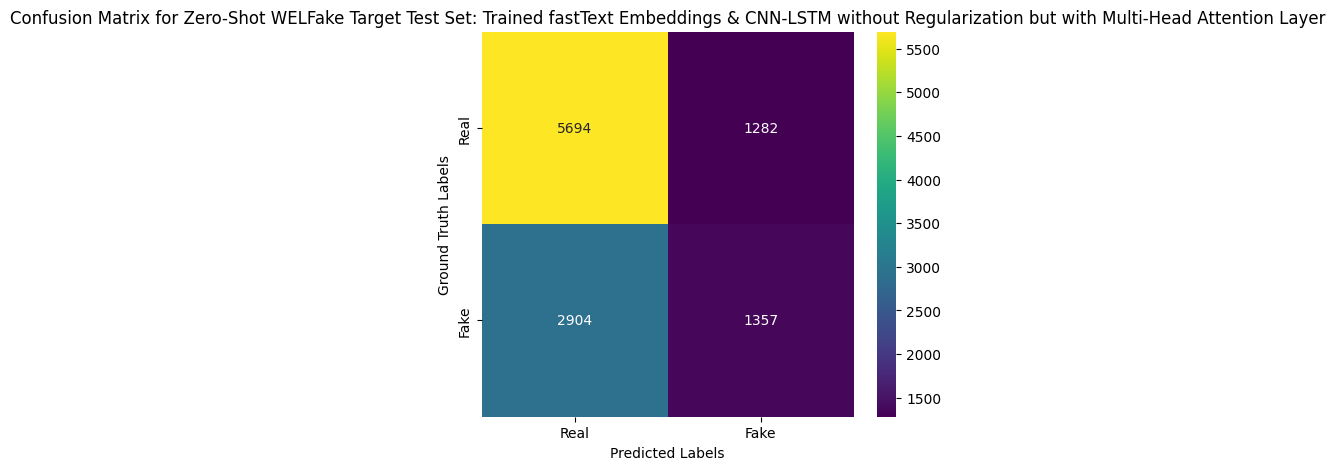

{'Real': {'precision': 0.6622470341939986,
  'recall': 0.8162270642201835,
  'f1-score': 0.7312186978297162,
  'support': 6976.0},
 'Fake': {'precision': 0.5142099280030314,
  'recall': 0.3184698427599155,
  'f1-score': 0.3933333333333333,
  'support': 4261.0},
 'accuracy': 0.6274806443000801,
 'macro avg': {'precision': 0.588228481098515,
  'recall': 0.5673484534900495,
  'f1-score': 0.5622760155815247,
  'support': 11237.0},
 'weighted avg': {'precision': 0.606112290981423,
  'recall': 0.6274806443000801,
  'f1-score': 0.6030946844703599,
  'support': 11237.0}}

In [26]:
zero_shot_wf_model_no_reg_mt_att, zero_shot_wf_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    zero_shot_wf_target_X_train,
    zero_shot_wf_target_X_train_extra_scaled,
    zero_shot_wf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_no_reg_mt_att,
    zero_shot_wf_target_X_val,
    zero_shot_wf_target_X_val_extra_scaled,
    zero_shot_wf_target_y_val, 
    "Zero-Shot WELFake Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    zero_shot_wf_model_no_reg_mt_att,
    zero_shot_wf_target_X_test,
    zero_shot_wf_target_X_test_extra_scaled,
    zero_shot_wf_target_y_test, 
    "Zero-Shot WELFake Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### Zero-Shot - Target: Constraint

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5799 - f1_score: 0.3801 - loss: 2.9143 - val_accuracy: 0.5540 - val_f1_score: 0.3606 - val_loss: 1.3267
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5921 - f1_score: 0.4370 - loss: 1.1283 - val_accuracy: 0.5640 - val_f1_score: 0.3919 - val_loss: 0.8062
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6118 - f1_score: 0.5150 - loss: 0.7539 - val_accuracy: 0.6080 - val_f1_score: 0.5231 - val_loss: 0.6850
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6107 - f1_score: 0.5507 - loss: 0.6728 - val_accuracy: 0.6040 - val_f1_score: 0.5182 - val_loss: 0.6673
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6329 - f1_score: 0.5810 - loss: 0.6543 - val_accuracy: 0.6400 - val_f1_score: 0.5972 - val_loss: 0.6493
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6241 - f1_

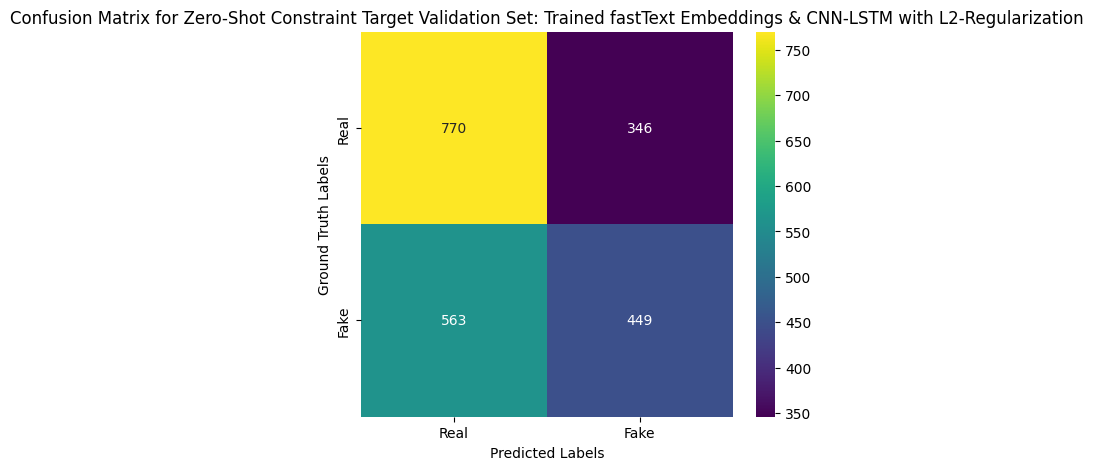

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Model Evaluation:
Accuracy: 0.5895
Macro-Precision: 0.5887
Macro-Recall: 0.5834
Macro-F1 Score: 0.5800


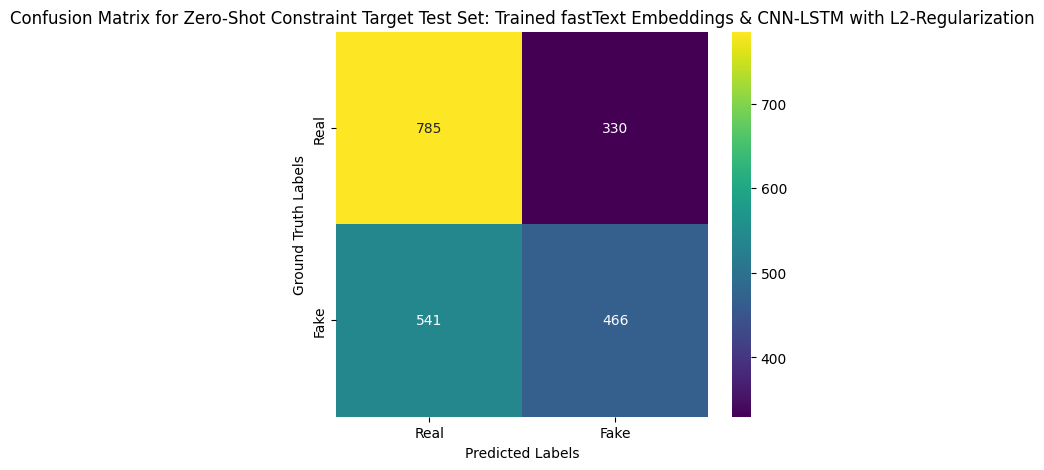

{'Real': {'precision': 0.5920060331825038,
  'recall': 0.7040358744394619,
  'f1-score': 0.6431790249897583,
  'support': 1115.0},
 'Fake': {'precision': 0.585427135678392,
  'recall': 0.4627606752730884,
  'f1-score': 0.516916250693289,
  'support': 1007.0},
 'accuracy': 0.5895381715362865,
 'macro avg': {'precision': 0.5887165844304478,
  'recall': 0.5833982748562752,
  'f1-score': 0.5800476378415236,
  'support': 2122.0},
 'weighted avg': {'precision': 0.5888840021803168,
  'recall': 0.5895381715362865,
  'f1-score': 0.5832607338886534,
  'support': 2122.0}}

In [28]:
zero_shot_ct_model_l2_reg, zero_shot_ct_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    zero_shot_ct_target_X_train,
    zero_shot_ct_target_X_train_extra_scaled,
    zero_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_l2_reg,
    zero_shot_ct_target_X_val,
    zero_shot_ct_target_X_val_extra_scaled,
    zero_shot_ct_target_y_val, 
    "Zero-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_l2_reg,
    zero_shot_ct_target_X_test,
    zero_shot_ct_target_X_test_extra_scaled,
    zero_shot_ct_target_y_test, 
    "Zero-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)


#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5802 - f1_score: 0.3779 - loss: 28.1311 - val_accuracy: 0.5530 - val_f1_score: 0.3581 - val_loss: 9.9854
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5829 - f1_score: 0.3778 - loss: 6.9037 - val_accuracy: 0.5600 - val_f1_score: 0.3808 - val_loss: 1.7201
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5954 - f1_score: 0.4423 - loss: 1.2726 - val_accuracy: 0.5820 - val_f1_score: 0.4747 - val_loss: 0.7528
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6141 - f1_score: 0.5182 - loss: 0.7355 - val_accuracy: 0.5940 - val_f1_score: 0.5148 - val_loss: 0.7335
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6250 - f1_score: 0.5533 - loss: 0.7240 - val_accuracy: 0.6090 - val_f1_score: 0.5466 - val_loss: 0.7302
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6315 - f1

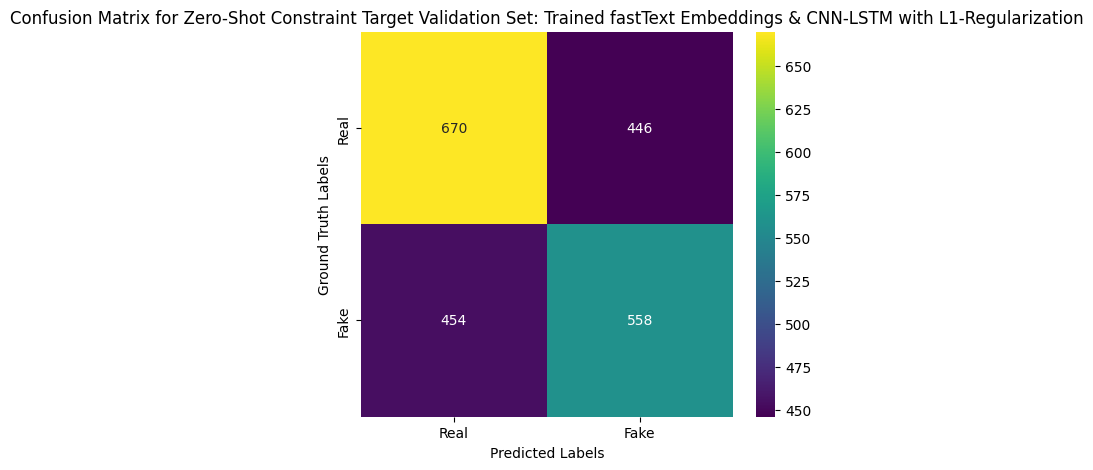

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.5759
Macro-Precision: 0.5745
Macro-Recall: 0.5744
Macro-F1 Score: 0.5744


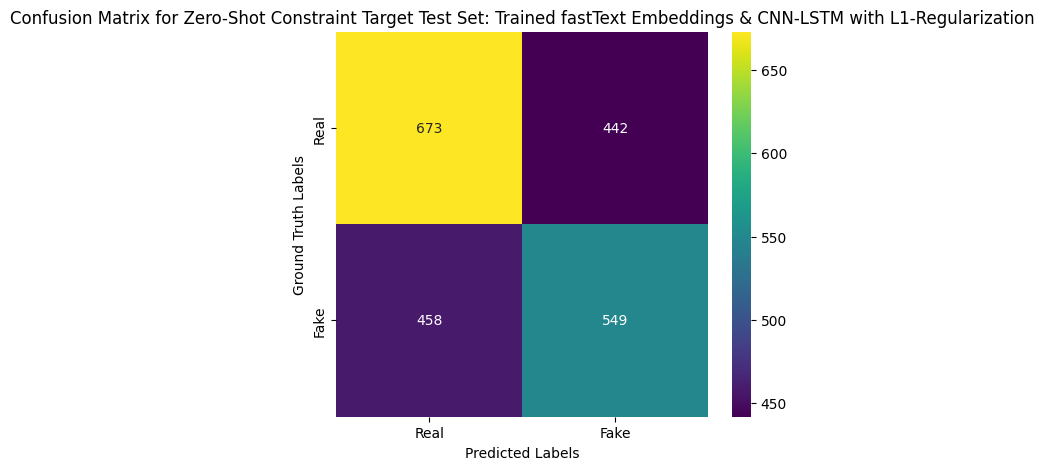

{'Real': {'precision': 0.5950486295313882,
  'recall': 0.6035874439461884,
  'f1-score': 0.5992876224398932,
  'support': 1115.0},
 'Fake': {'precision': 0.5539858728557013,
  'recall': 0.5451837140019861,
  'f1-score': 0.5495495495495496,
  'support': 1007.0},
 'accuracy': 0.5758718190386428,
 'macro avg': {'precision': 0.5745172511935448,
  'recall': 0.5743855789740873,
  'f1-score': 0.5744185859947214,
  'support': 2122.0},
 'weighted avg': {'precision': 0.5755622035311918,
  'recall': 0.5758718190386428,
  'f1-score': 0.5756843050974917,
  'support': 2122.0}}

In [30]:
zero_shot_ct_model_l1_reg, zero_shot_ct_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    zero_shot_ct_target_X_train,
    zero_shot_ct_target_X_train_extra_scaled,
    zero_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_l1_reg,
    zero_shot_ct_target_X_val,
    zero_shot_ct_target_X_val_extra_scaled,
    zero_shot_ct_target_y_val, 
    "Zero-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_l1_reg,
    zero_shot_ct_target_X_test,
    zero_shot_ct_target_X_test_extra_scaled,
    zero_shot_ct_target_y_test, 
    "Zero-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5805 - f1_score: 0.3846 - loss: 0.6709 - val_accuracy: 0.5560 - val_f1_score: 0.3654 - val_loss: 0.6675
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5977 - f1_score: 0.4492 - loss: 0.6548 - val_accuracy: 0.5800 - val_f1_score: 0.4385 - val_loss: 0.6529
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6252 - f1_score: 0.5611 - loss: 0.6359 - val_accuracy: 0.6760 - val_f1_score: 0.6513 - val_loss: 0.6203
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6913 - f1_score: 0.6810 - loss: 0.5920 - val_accuracy: 0.5540 - val_f1_score: 0.3626 - val_loss: 0.6813
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6000 - f1_score: 0.4471 - loss: 0.6597 - val_accuracy: 0.6030 - val_f1_score: 0.5103 - val_loss: 0.6584
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6282 - f1_

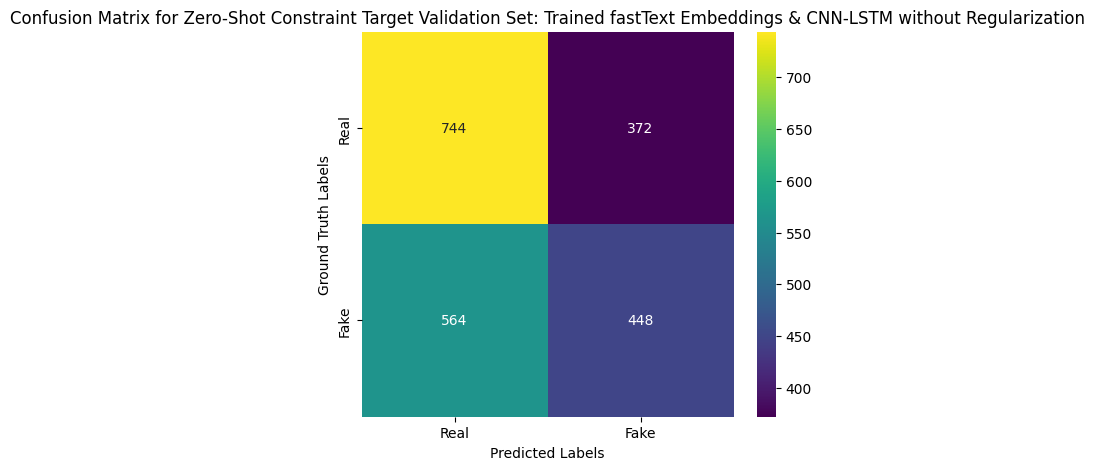

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.5867
Macro-Precision: 0.5855
Macro-Recall: 0.5809
Macro-F1 Score: 0.5780


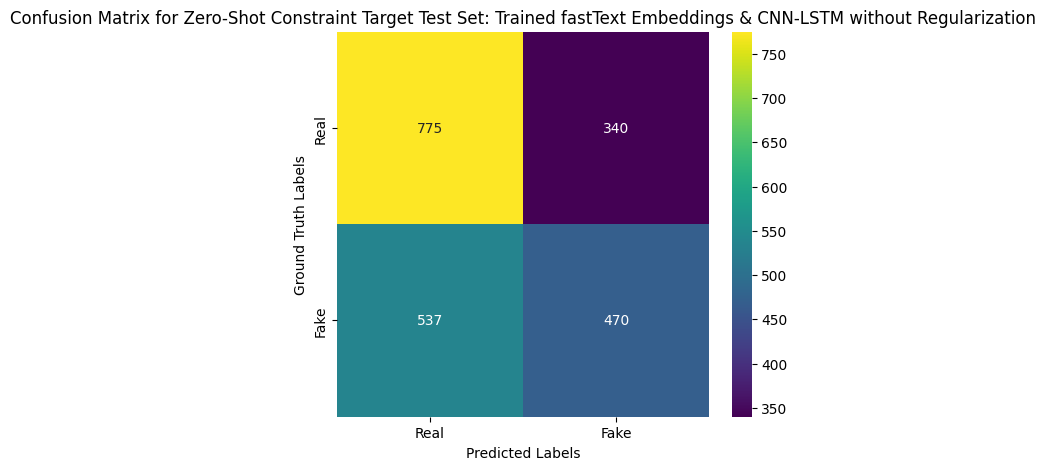

{'Real': {'precision': 0.5907012195121951,
  'recall': 0.695067264573991,
  'f1-score': 0.638648537288834,
  'support': 1115.0},
 'Fake': {'precision': 0.5802469135802469,
  'recall': 0.4667328699106256,
  'f1-score': 0.5173362685745735,
  'support': 1007.0},
 'accuracy': 0.5867106503298775,
 'macro avg': {'precision': 0.585474066546221,
  'recall': 0.5809000672423084,
  'f1-score': 0.5779924029317037,
  'support': 2122.0},
 'weighted avg': {'precision': 0.5857401044917089,
  'recall': 0.5867106503298775,
  'f1-score': 0.5810795200431882,
  'support': 2122.0}}

In [32]:
zero_shot_ct_model_no_reg, zero_shot_ct_history_no_reg = trainCNN_LSTMWithoutRegularization(
    zero_shot_ct_target_X_train,
    zero_shot_ct_target_X_train_extra_scaled,
    zero_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_no_reg,
    zero_shot_ct_target_X_val,
    zero_shot_ct_target_X_val_extra_scaled,
    zero_shot_ct_target_y_val, 
    "Zero-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_no_reg,
    zero_shot_ct_target_X_test,
    zero_shot_ct_target_X_test_extra_scaled,
    zero_shot_ct_target_y_test, 
    "Zero-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5840 - f1_score: 0.5051 - loss: 0.6695 - val_accuracy: 0.6930 - val_f1_score: 0.6920 - val_loss: 0.5792
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6850 - f1_score: 0.6730 - loss: 0.5929 - val_accuracy: 0.6950 - val_f1_score: 0.6493 - val_loss: 0.5566
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7625 - f1_score: 0.7516 - loss: 0.5211 - val_accuracy: 0.8000 - val_f1_score: 0.7946 - val_loss: 0.4508
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7944 - f1_score: 0.7884 - loss: 0.4719 - val_accuracy: 0.7920 - val_f1_score: 0.7784 - val_loss: 0.4616
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8183 - f1_score: 0.8121 - loss: 0.4352 - val_accuracy: 0.8090 - val_f1_score: 0.8085 - val_loss: 0.4117
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8280 - f1_

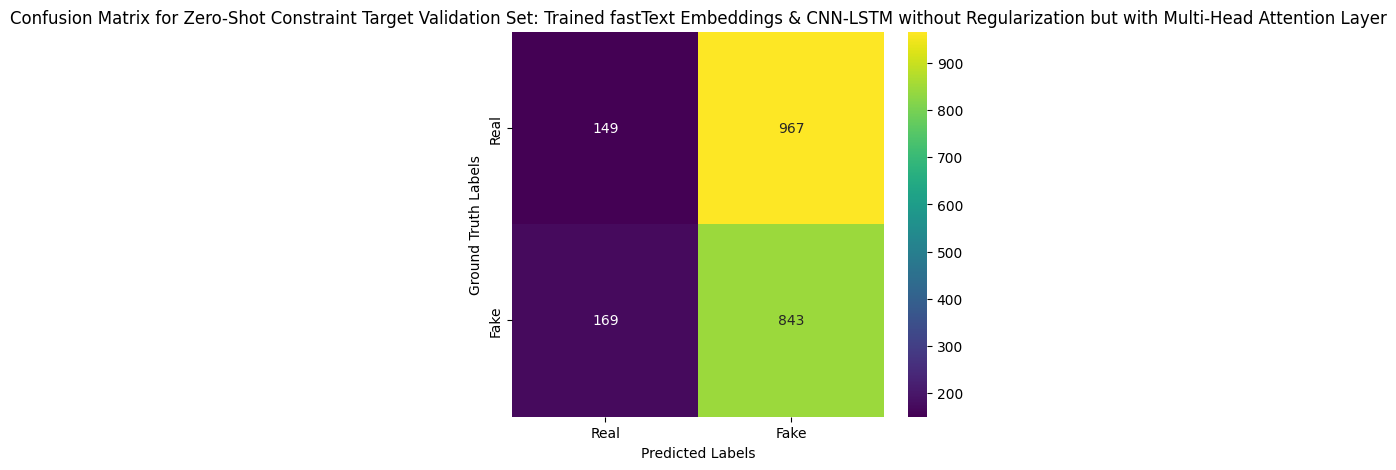

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Model Evaluation:
Accuracy: 0.4590
Macro-Precision: 0.4559
Macro-Recall: 0.4763
Macro-F1 Score: 0.3995


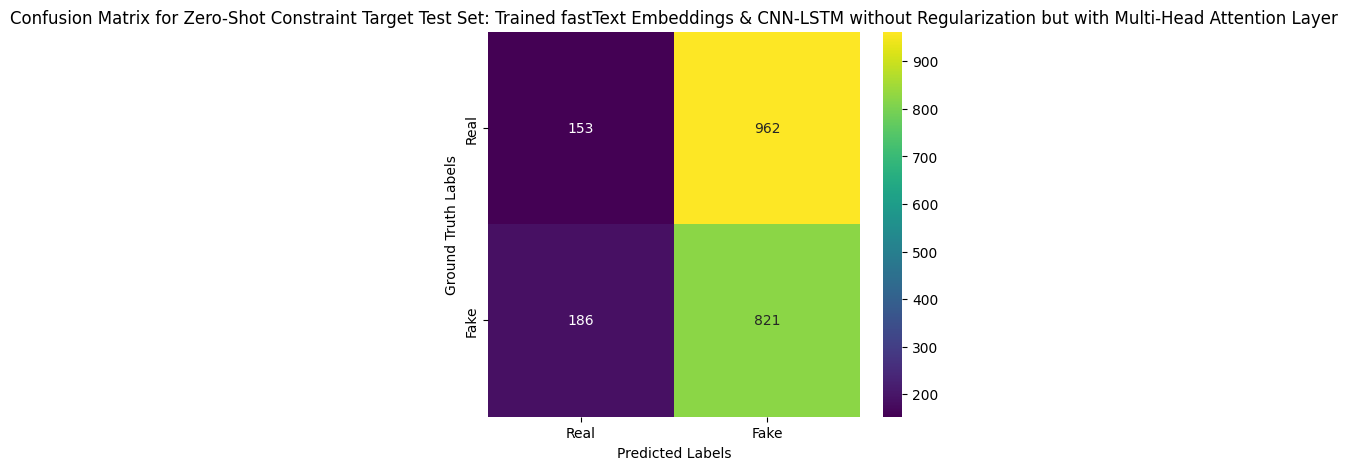

{'Real': {'precision': 0.45132743362831856,
  'recall': 0.13721973094170403,
  'f1-score': 0.21045392022008252,
  'support': 1115.0},
 'Fake': {'precision': 0.46045989904655077,
  'recall': 0.8152929493545183,
  'f1-score': 0.5885304659498208,
  'support': 1007.0},
 'accuracy': 0.4590009425070688,
 'macro avg': {'precision': 0.45589366633743467,
  'recall': 0.4762563401481112,
  'f1-score': 0.39949219308495165,
  'support': 2122.0},
 'weighted avg': {'precision': 0.455661266180703,
  'recall': 0.4590009425070688,
  'f1-score': 0.3898710180286812,
  'support': 2122.0}}

In [34]:
zero_shot_ct_model_no_reg_mt_att, zero_shot_ct_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    zero_shot_ct_target_X_train,
    zero_shot_ct_target_X_train_extra_scaled,
    zero_shot_ct_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_no_reg_mt_att,
    zero_shot_ct_target_X_val,
    zero_shot_ct_target_X_val_extra_scaled,
    zero_shot_ct_target_y_val, 
    "Zero-Shot Constraint Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    zero_shot_ct_model_no_reg_mt_att,
    zero_shot_ct_target_X_test,
    zero_shot_ct_target_X_test_extra_scaled,
    zero_shot_ct_target_y_test, 
    "Zero-Shot Constraint Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)


### Zero-Shot - Target: PolitiFact

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5651 - f1_score: 0.4246 - loss: 2.9196 - val_accuracy: 0.5840 - val_f1_score: 0.4282 - val_loss: 1.3136
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5929 - f1_score: 0.5055 - loss: 1.1349 - val_accuracy: 0.6210 - val_f1_score: 0.5375 - val_loss: 0.7907
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6044 - f1_score: 0.5307 - loss: 0.7595 - val_accuracy: 0.6230 - val_f1_score: 0.5566 - val_loss: 0.6785
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6196 - f1_score: 0.5671 - loss: 0.6781 - val_accuracy: 0.6390 - val_f1_score: 0.5915 - val_loss: 0.6534
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6174 - f1_score: 0.5724 - loss: 0.6628 - val_accuracy: 0.6440 - val_f1_score: 0.6056 - val_loss: 0.6468
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6145 - f1_

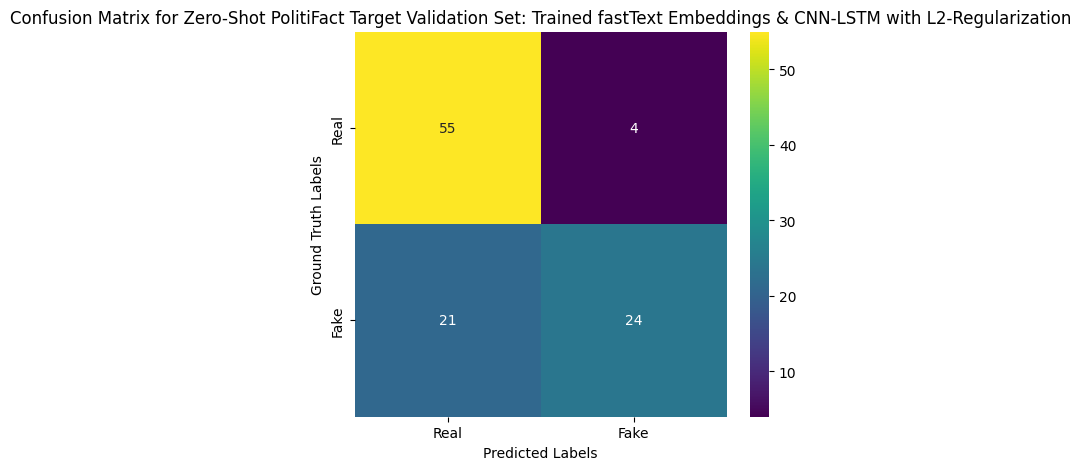

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Model Evaluation:
Accuracy: 0.5952
Macro-Precision: 0.6427
Macro-Recall: 0.6037
Macro-F1 Score: 0.5692


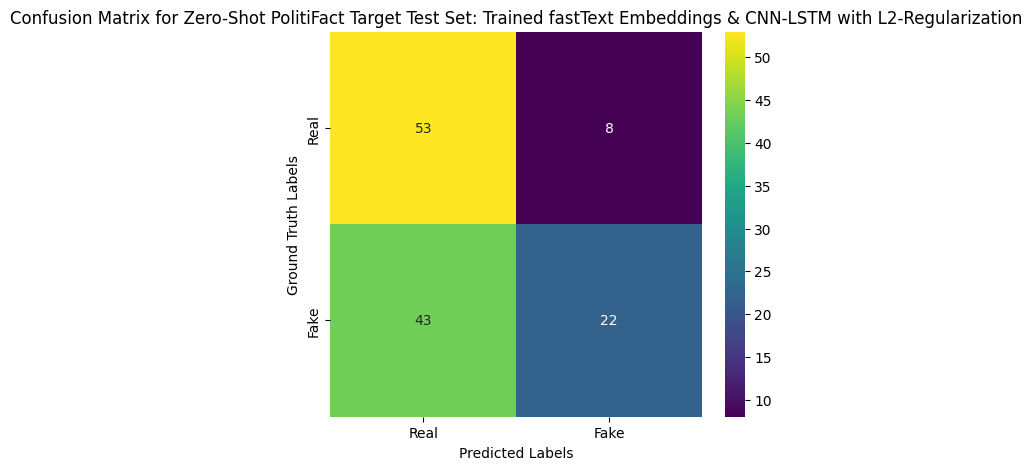

{'Real': {'precision': 0.5520833333333334,
  'recall': 0.8688524590163934,
  'f1-score': 0.6751592356687898,
  'support': 61.0},
 'Fake': {'precision': 0.7333333333333333,
  'recall': 0.3384615384615385,
  'f1-score': 0.4631578947368421,
  'support': 65.0},
 'accuracy': 0.5952380952380952,
 'macro avg': {'precision': 0.6427083333333333,
  'recall': 0.6036569987389659,
  'f1-score': 0.5691585652028159,
  'support': 126.0},
 'weighted avg': {'precision': 0.6455853174603174,
  'recall': 0.5952380952380952,
  'f1-score': 0.5657934645531025,
  'support': 126.0}}

In [37]:
zero_shot_pf_model_l2_reg, zero_shot_pf_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    zero_shot_pf_target_X_train,
    zero_shot_pf_target_X_train_extra_scaled,
    zero_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_l2_reg,
    zero_shot_pf_target_X_val,
    zero_shot_pf_target_X_val_extra_scaled,
    zero_shot_pf_target_y_val, 
    "Zero-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_l2_reg,
    zero_shot_pf_target_X_test,
    zero_shot_pf_target_X_test_extra_scaled,
    zero_shot_pf_target_y_test, 
    "Zero-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5650 - f1_score: 0.4250 - loss: 28.1354 - val_accuracy: 0.5840 - val_f1_score: 0.4282 - val_loss: 9.9698
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5775 - f1_score: 0.4644 - loss: 6.9018 - val_accuracy: 0.6250 - val_f1_score: 0.5488 - val_loss: 1.7035
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6073 - f1_score: 0.5351 - loss: 1.2763 - val_accuracy: 0.6240 - val_f1_score: 0.5549 - val_loss: 0.7404
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6152 - f1_score: 0.5583 - loss: 0.7397 - val_accuracy: 0.6330 - val_f1_score: 0.5828 - val_loss: 0.7216
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6183 - f1_score: 0.5696 - loss: 0.7315 - val_accuracy: 0.6390 - val_f1_score: 0.6020 - val_loss: 0.7173
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6137 - f1

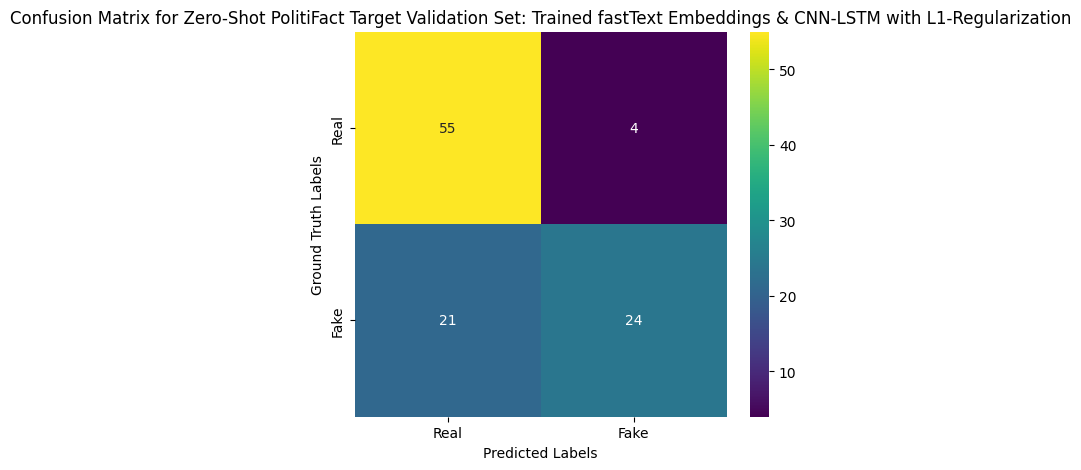

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Model Evaluation:
Accuracy: 0.5873
Macro-Precision: 0.6353
Macro-Recall: 0.5960
Macro-F1 Score: 0.5588


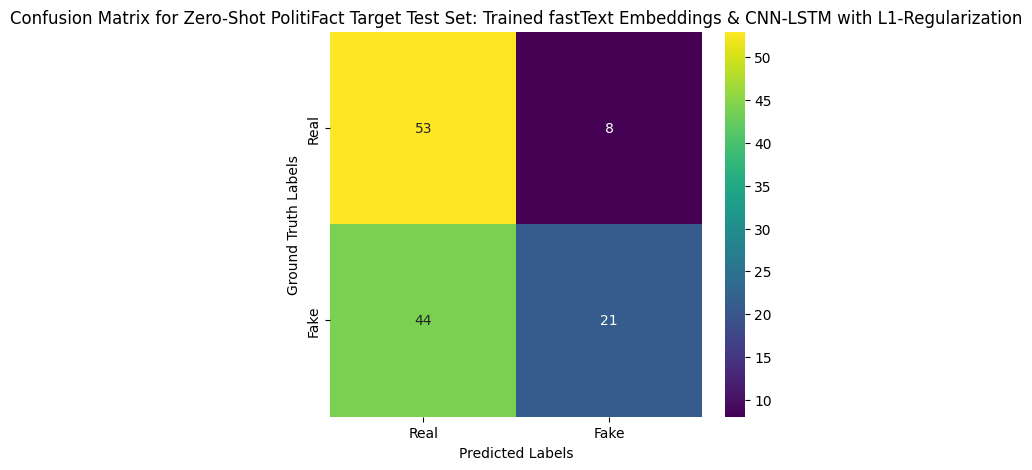

{'Real': {'precision': 0.5463917525773195,
  'recall': 0.8688524590163934,
  'f1-score': 0.6708860759493671,
  'support': 61.0},
 'Fake': {'precision': 0.7241379310344828,
  'recall': 0.3230769230769231,
  'f1-score': 0.44680851063829785,
  'support': 65.0},
 'accuracy': 0.5873015873015873,
 'macro avg': {'precision': 0.6352648418059011,
  'recall': 0.5959646910466583,
  'f1-score': 0.5588472932938324,
  'support': 126.0},
 'weighted avg': {'precision': 0.6380862097179196,
  'recall': 0.5873015873015873,
  'f1-score': 0.555290506542863,
  'support': 126.0}}

In [39]:
zero_shot_pf_model_l1_reg, zero_shot_pf_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    zero_shot_pf_target_X_train,
    zero_shot_pf_target_X_train_extra_scaled,
    zero_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_l1_reg,
    zero_shot_pf_target_X_val,
    zero_shot_pf_target_X_val_extra_scaled,
    zero_shot_pf_target_y_val, 
    "Zero-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_l1_reg,
    zero_shot_pf_target_X_test,
    zero_shot_pf_target_X_test_extra_scaled,
    zero_shot_pf_target_y_test, 
    "Zero-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5651 - f1_score: 0.4281 - loss: 0.6792 - val_accuracy: 0.5870 - val_f1_score: 0.4299 - val_loss: 0.6610
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5868 - f1_score: 0.5125 - loss: 0.6687 - val_accuracy: 0.6320 - val_f1_score: 0.5602 - val_loss: 0.6416
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6003 - f1_score: 0.5598 - loss: 0.6549 - val_accuracy: 0.6820 - val_f1_score: 0.6629 - val_loss: 0.6086
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6390 - f1_score: 0.6314 - loss: 0.6223 - val_accuracy: 0.7410 - val_f1_score: 0.7398 - val_loss: 0.5343
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7405 - f1_score: 0.7351 - loss: 0.5509 - val_accuracy: 0.5330 - val_f1_score: 0.5072 - val_loss: 0.6749
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6137 - f1_

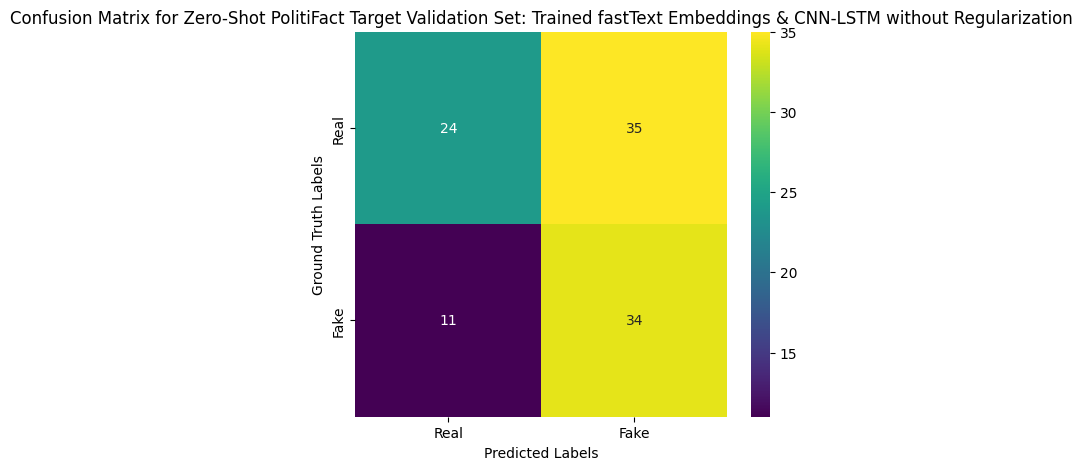

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Model Evaluation:
Accuracy: 0.5397
Macro-Precision: 0.5383
Macro-Recall: 0.5352
Macro-F1 Score: 0.5278


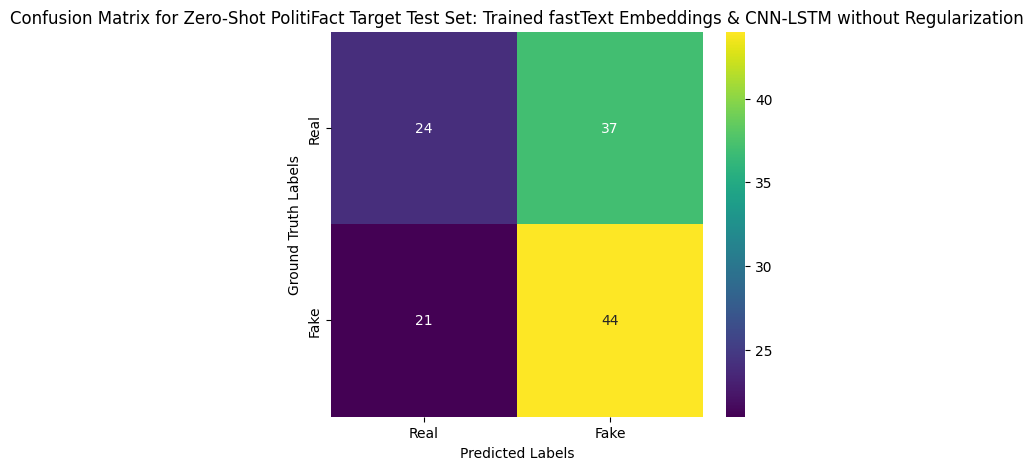

{'Real': {'precision': 0.5333333333333333,
  'recall': 0.39344262295081966,
  'f1-score': 0.4528301886792453,
  'support': 61.0},
 'Fake': {'precision': 0.5432098765432098,
  'recall': 0.676923076923077,
  'f1-score': 0.6027397260273972,
  'support': 65.0},
 'accuracy': 0.5396825396825397,
 'macro avg': {'precision': 0.5382716049382716,
  'recall': 0.5351828499369483,
  'f1-score': 0.5277849573533213,
  'support': 126.0},
 'weighted avg': {'precision': 0.5384283754654124,
  'recall': 0.5396825396825397,
  'f1-score': 0.5301644738191649,
  'support': 126.0}}

In [41]:
zero_shot_pf_model_no_reg, zero_shot_pf_history_no_reg = trainCNN_LSTMWithoutRegularization(
    zero_shot_pf_target_X_train,
    zero_shot_pf_target_X_train_extra_scaled,
    zero_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_no_reg,
    zero_shot_pf_target_X_val,
    zero_shot_pf_target_X_val_extra_scaled,
    zero_shot_pf_target_y_val, 
    "Zero-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_no_reg,
    zero_shot_pf_target_X_test,
    zero_shot_pf_target_X_test_extra_scaled,
    zero_shot_pf_target_y_test, 
    "Zero-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5644 - f1_score: 0.5212 - loss: 0.6822 - val_accuracy: 0.6330 - val_f1_score: 0.5773 - val_loss: 0.6311
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6691 - f1_score: 0.6523 - loss: 0.6299 - val_accuracy: 0.6380 - val_f1_score: 0.5408 - val_loss: 0.5990
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7250 - f1_score: 0.7073 - loss: 0.5692 - val_accuracy: 0.7260 - val_f1_score: 0.6925 - val_loss: 0.5373
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7560 - f1_score: 0.7464 - loss: 0.5194 - val_accuracy: 0.7580 - val_f1_score: 0.7371 - val_loss: 0.5027
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7916 - f1_score: 0.7835 - loss: 0.4860 - val_accuracy: 0.7950 - val_f1_score: 0.7839 - val_loss: 0.4972
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7768 - f1_

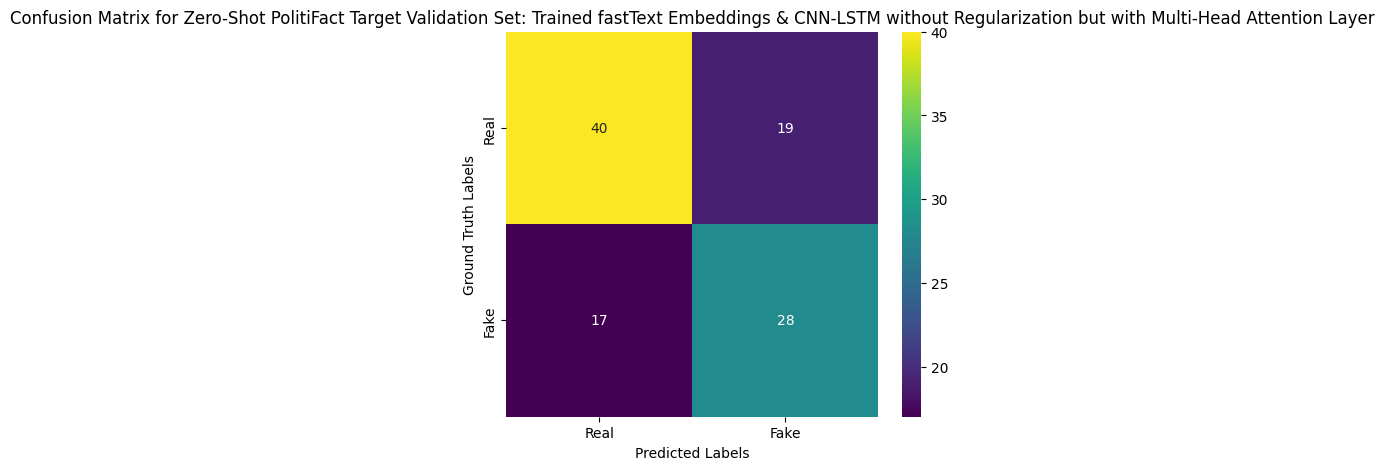

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Model Evaluation:
Accuracy: 0.6429
Macro-Precision: 0.6429
Macro-Recall: 0.6412
Macro-F1 Score: 0.6410


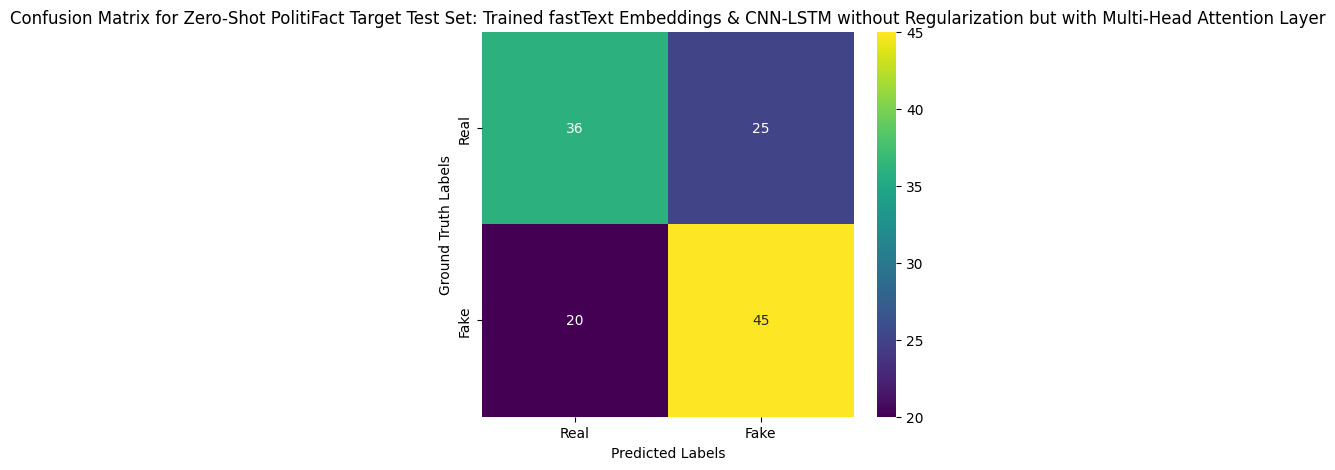

{'Real': {'precision': 0.6428571428571429,
  'recall': 0.5901639344262295,
  'f1-score': 0.6153846153846154,
  'support': 61.0},
 'Fake': {'precision': 0.6428571428571429,
  'recall': 0.6923076923076923,
  'f1-score': 0.6666666666666666,
  'support': 65.0},
 'accuracy': 0.6428571428571429,
 'macro avg': {'precision': 0.6428571428571429,
  'recall': 0.6412358133669609,
  'f1-score': 0.641025641025641,
  'support': 126.0},
 'weighted avg': {'precision': 0.6428571428571429,
  'recall': 0.6428571428571429,
  'f1-score': 0.6418396418396417,
  'support': 126.0}}

In [44]:
zero_shot_pf_model_no_reg_mt_att, zero_shot_pf_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    zero_shot_pf_target_X_train,
    zero_shot_pf_target_X_train_extra_scaled,
    zero_shot_pf_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_no_reg_mt_att,
    zero_shot_pf_target_X_val,
    zero_shot_pf_target_X_val_extra_scaled,
    zero_shot_pf_target_y_val, 
    "Zero-Shot PolitiFact Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    zero_shot_pf_model_no_reg_mt_att,
    zero_shot_pf_target_X_test,
    zero_shot_pf_target_X_test_extra_scaled,
    zero_shot_pf_target_y_test, 
    "Zero-Shot PolitiFact Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

### Zero-Shot - Target: GossipCop

#### CNN-LSTM with L2 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5480 - f1_score: 0.5170 - loss: 2.9236 - val_accuracy: 0.6310 - val_f1_score: 0.6272 - val_loss: 1.3158
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5978 - f1_score: 0.5932 - loss: 1.1324 - val_accuracy: 0.6110 - val_f1_score: 0.5605 - val_loss: 0.8097
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6174 - f1_score: 0.6070 - loss: 0.7648 - val_accuracy: 0.6380 - val_f1_score: 0.6220 - val_loss: 0.6828
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6460 - f1_score: 0.6380 - loss: 0.6662 - val_accuracy: 0.6480 - val_f1_score: 0.6421 - val_loss: 0.6352
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6631 - f1_score: 0.6578 - loss: 0.6354 - val_accuracy: 0.6590 - val_f1_score: 0.6475 - val_loss: 0.6270
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6563 - f1_

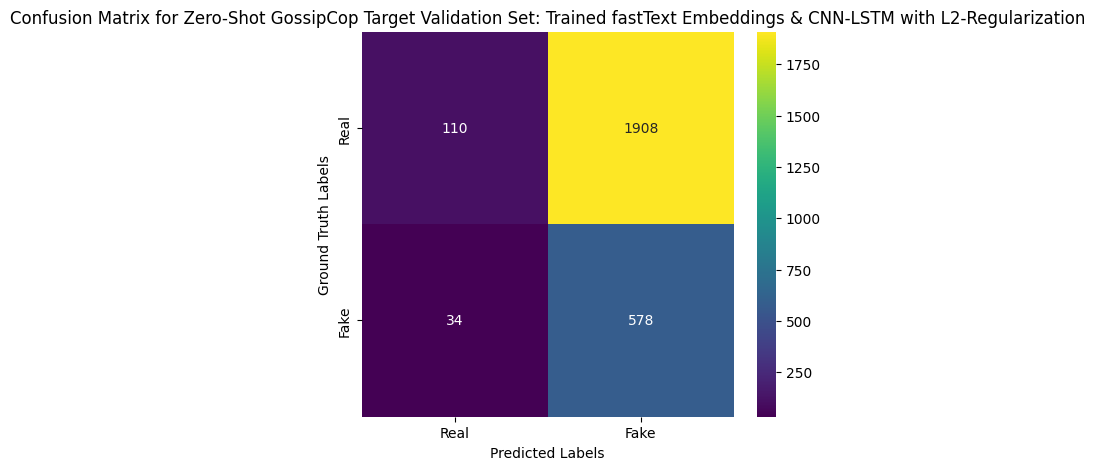

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.2701
Macro-Precision: 0.5214
Macro-Recall: 0.5063
Macro-F1 Score: 0.2456


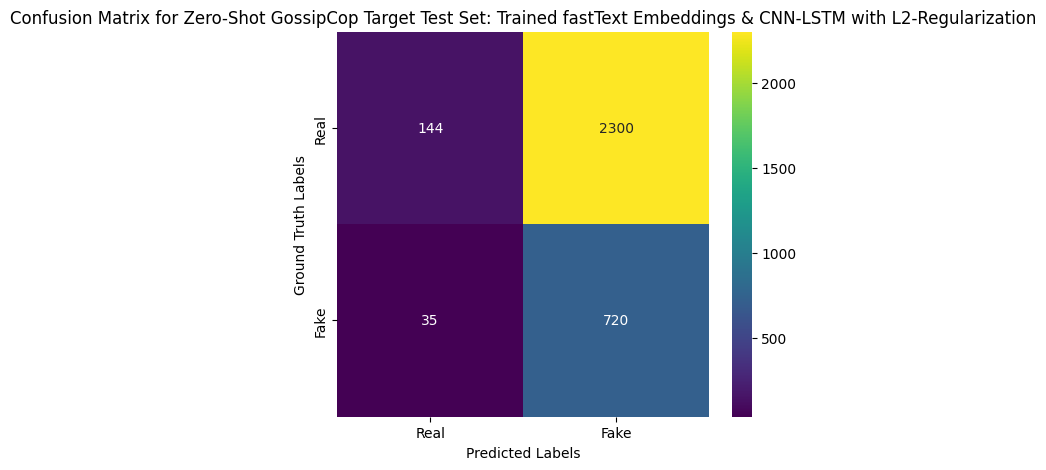

{'Real': {'precision': 0.8044692737430168,
  'recall': 0.058919803600654665,
  'f1-score': 0.10979794128860083,
  'support': 2444.0},
 'Fake': {'precision': 0.23841059602649006,
  'recall': 0.9536423841059603,
  'f1-score': 0.38145695364238413,
  'support': 755.0},
 'accuracy': 0.27008440137542983,
 'macro avg': {'precision': 0.5214399348847534,
  'recall': 0.5062810938533074,
  'f1-score': 0.24562744746549248,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6708730556511201,
  'recall': 0.27008440137542983,
  'f1-score': 0.17391252532333246,
  'support': 3199.0}}

In [47]:
zero_shot_gc_model_l2_reg, zero_shot_gc_history_l2_reg = trainCNN_LSTMWithL2Regularization(
    zero_shot_gc_target_X_train,
    zero_shot_gc_target_X_train_extra_scaled,
    zero_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_l2_reg,
    zero_shot_gc_target_X_val,
    zero_shot_gc_target_X_val_extra_scaled,
    zero_shot_gc_target_y_val, 
    "Zero-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_l2_reg,
    zero_shot_gc_target_X_test,
    zero_shot_gc_target_X_test_extra_scaled,
    zero_shot_gc_target_y_test, 
    "Zero-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM with L2-Regularization" 
)


#### CNN-LSTM with L1 Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5372 - f1_score: 0.4908 - loss: 28.1411 - val_accuracy: 0.5400 - val_f1_score: 0.3978 - val_loss: 9.9919
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5939 - f1_score: 0.5629 - loss: 6.9147 - val_accuracy: 0.6200 - val_f1_score: 0.5992 - val_loss: 1.7099
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6253 - f1_score: 0.6144 - loss: 1.2685 - val_accuracy: 0.6360 - val_f1_score: 0.6249 - val_loss: 0.7353
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6456 - f1_score: 0.6379 - loss: 0.7207 - val_accuracy: 0.6450 - val_f1_score: 0.6316 - val_loss: 0.7116
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6516 - f1_score: 0.6420 - loss: 0.7042 - val_accuracy: 0.6540 - val_f1_score: 0.6413 - val_loss: 0.7051
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6536 - f1

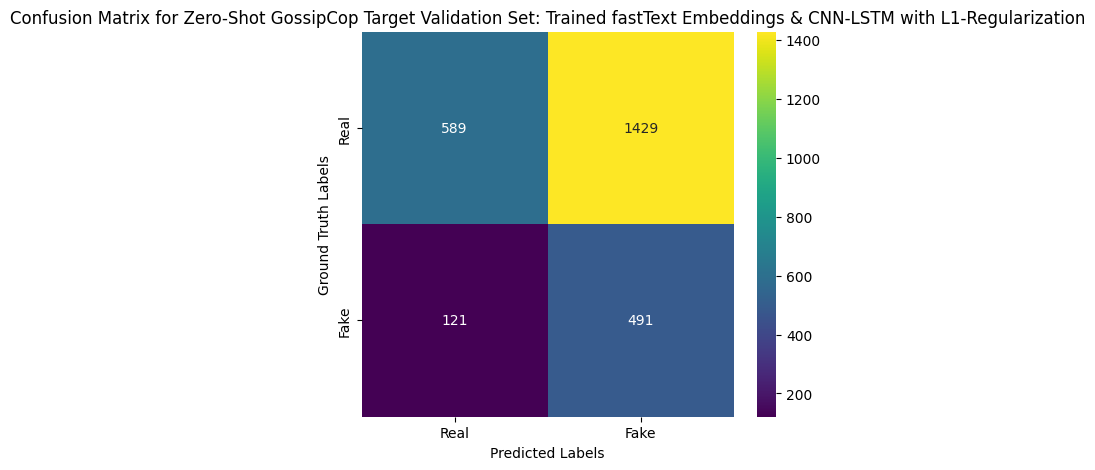

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Model Evaluation:
Accuracy: 0.4248
Macro-Precision: 0.5446
Macro-Recall: 0.5508
Macro-F1 Score: 0.4232


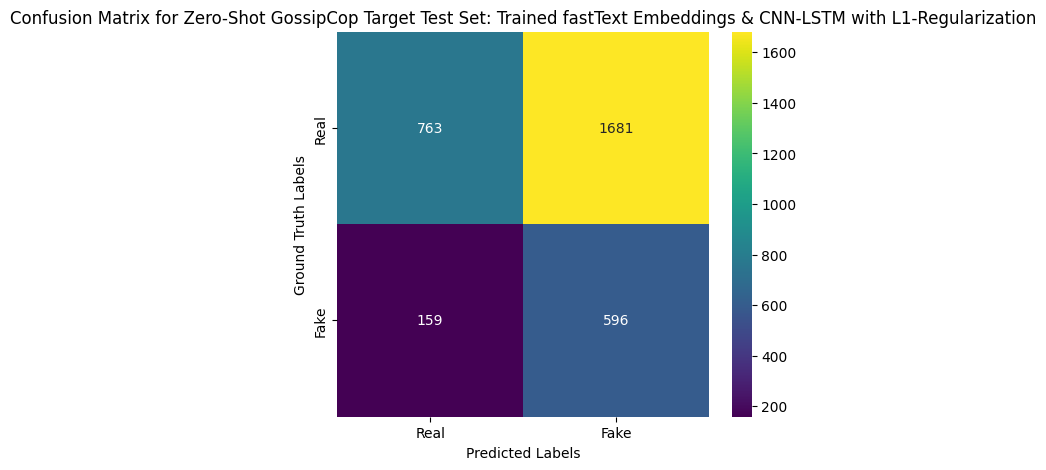

{'Real': {'precision': 0.8275488069414316,
  'recall': 0.31219312602291327,
  'f1-score': 0.4533571004159239,
  'support': 2444.0},
 'Fake': {'precision': 0.26174791392182695,
  'recall': 0.7894039735099337,
  'f1-score': 0.39313984168865435,
  'support': 755.0},
 'accuracy': 0.4248202563301032,
 'macro avg': {'precision': 0.5446483604316292,
  'recall': 0.5507985497664235,
  'f1-score': 0.42324847105228913,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6940134289389929,
  'recall': 0.4248202563301032,
  'f1-score': 0.43914514970036017,
  'support': 3199.0}}

In [51]:
zero_shot_gc_model_l1_reg, zero_shot_gc_history_l1_reg = trainCNN_LSTMWithL1Regularization(
    zero_shot_gc_target_X_train,
    zero_shot_gc_target_X_train_extra_scaled,
    zero_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_l1_reg,
    zero_shot_gc_target_X_val,
    zero_shot_gc_target_X_val_extra_scaled,
    zero_shot_gc_target_y_val, 
    "Zero-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_l1_reg,
    zero_shot_gc_target_X_test,
    zero_shot_gc_target_X_test_extra_scaled,
    zero_shot_gc_target_y_test, 
    "Zero-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM with L1-Regularization" 
)


#### CNN-LSTM without Regularization

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5501 - f1_score: 0.5300 - loss: 0.6820 - val_accuracy: 0.6190 - val_f1_score: 0.6189 - val_loss: 0.6558
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6150 - f1_score: 0.6137 - loss: 0.6521 - val_accuracy: 0.6500 - val_f1_score: 0.6498 - val_loss: 0.6310
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6366 - f1_score: 0.6339 - loss: 0.6244 - val_accuracy: 0.6690 - val_f1_score: 0.6597 - val_loss: 0.5962
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6919 - f1_score: 0.6915 - loss: 0.5763 - val_accuracy: 0.7710 - val_f1_score: 0.7695 - val_loss: 0.4865
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7481 - f1_score: 0.7472 - loss: 0.5259 - val_accuracy: 0.8020 - val_f1_score: 0.8019 - val_loss: 0.4749
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7715 - f1_

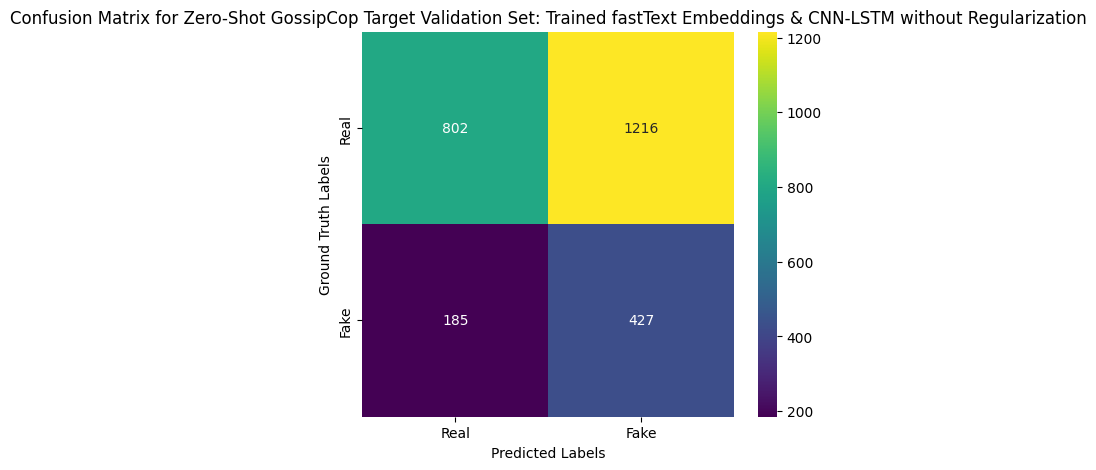

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

Model Evaluation:
Accuracy: 0.4717
Macro-Precision: 0.5323
Macro-Recall: 0.5426
Macro-F1 Score: 0.4592


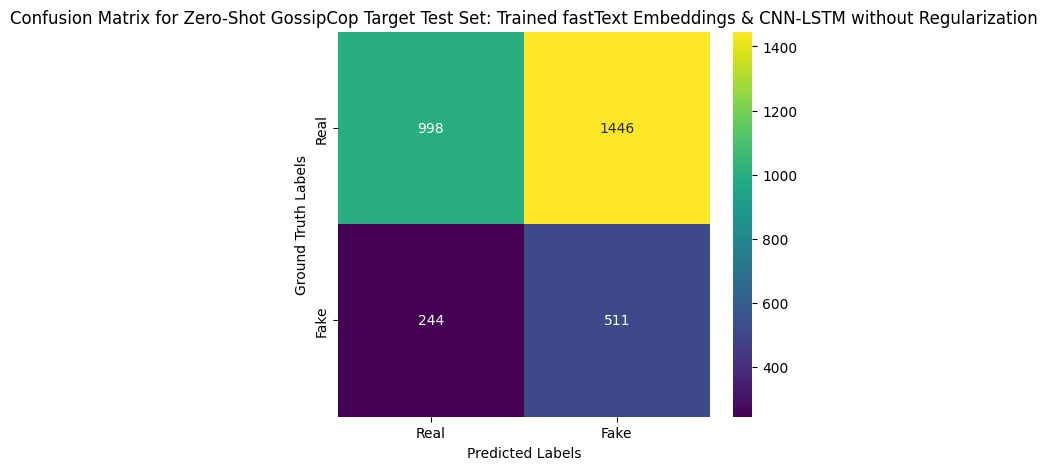

{'Real': {'precision': 0.8035426731078905,
  'recall': 0.4083469721767594,
  'f1-score': 0.5415084102007597,
  'support': 2444.0},
 'Fake': {'precision': 0.2611139499233521,
  'recall': 0.6768211920529801,
  'f1-score': 0.37684365781710916,
  'support': 755.0},
 'accuracy': 0.47170990934667084,
 'macro avg': {'precision': 0.5323283115156213,
  'recall': 0.5425840821148697,
  'f1-score': 0.4591760340089344,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6755233902056316,
  'recall': 0.47170990934667084,
  'f1-score': 0.5026456755806733,
  'support': 3199.0}}

In [53]:
zero_shot_gc_model_no_reg, zero_shot_gc_history_no_reg = trainCNN_LSTMWithoutRegularization(
    zero_shot_gc_target_X_train,
    zero_shot_gc_target_X_train_extra_scaled,
    zero_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_no_reg,
    zero_shot_gc_target_X_val,
    zero_shot_gc_target_X_val_extra_scaled,
    zero_shot_gc_target_y_val, 
    "Zero-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_no_reg,
    zero_shot_gc_target_X_test,
    zero_shot_gc_target_X_test_extra_scaled,
    zero_shot_gc_target_y_test, 
    "Zero-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization" 
)


#### CNN-LSTM without Regularization and with Multi-Head Attention Layers

Embedding (fastText) input dimensions: (500, 100)
Extra features dimensions: 10
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5709 - f1_score: 0.5575 - loss: 0.6787 - val_accuracy: 0.7060 - val_f1_score: 0.6983 - val_loss: 0.5729
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7202 - f1_score: 0.7181 - loss: 0.5778 - val_accuracy: 0.7900 - val_f1_score: 0.7899 - val_loss: 0.4599
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7794 - f1_score: 0.7785 - loss: 0.4779 - val_accuracy: 0.8070 - val_f1_score: 0.8066 - val_loss: 0.4301
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8099 - f1_score: 0.8089 - loss: 0.4359 - val_accuracy: 0.8270 - val_f1_score: 0.8267 - val_loss: 0.4003
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8275 - f1_score: 0.8269 - loss: 0.4189 - val_accuracy: 0.8230 - val_f1_score: 0.8229 - val_loss: 0.3981
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8523 - f1_

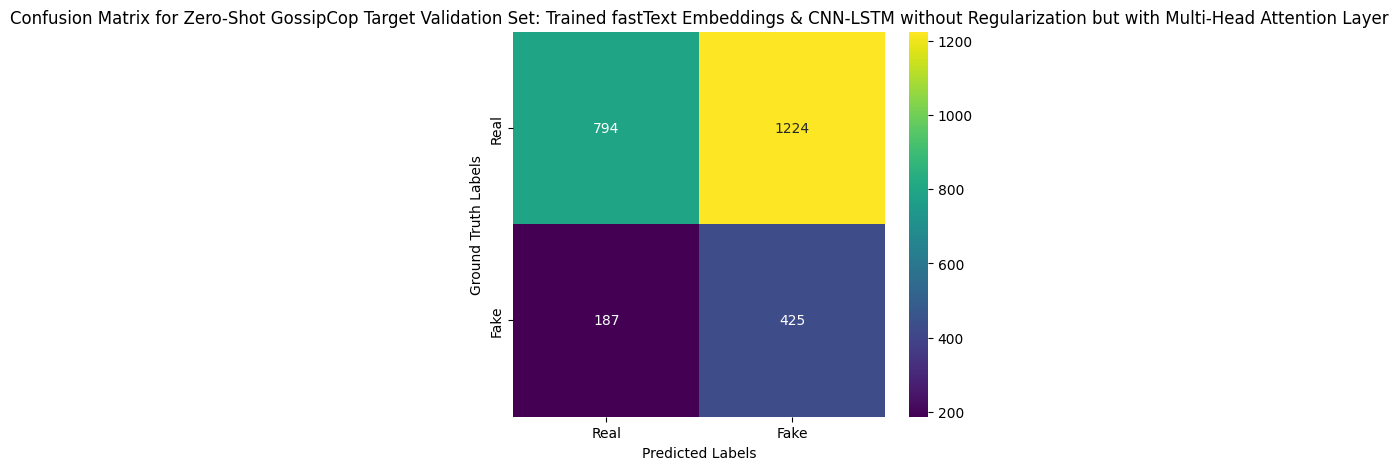

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Model Evaluation:
Accuracy: 0.4798
Macro-Precision: 0.5365
Macro-Recall: 0.5484
Macro-F1 Score: 0.4662


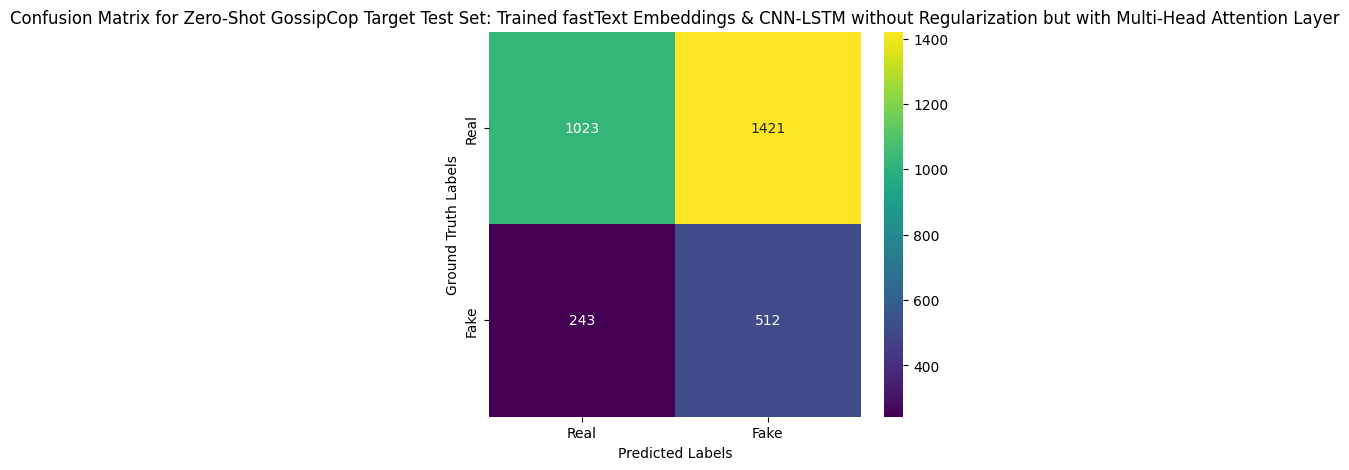

{'Real': {'precision': 0.8080568720379147,
  'recall': 0.4185761047463175,
  'f1-score': 0.5514824797843666,
  'support': 2444.0},
 'Fake': {'precision': 0.26487325400931194,
  'recall': 0.6781456953642384,
  'f1-score': 0.38095238095238093,
  'support': 755.0},
 'accuracy': 0.4798374492028759,
 'macro avg': {'precision': 0.5364650630236133,
  'recall': 0.5483609000552779,
  'f1-score': 0.46621743036837376,
  'support': 3199.0},
 'weighted avg': {'precision': 0.6798594254572347,
  'recall': 0.4798374492028759,
  'f1-score': 0.5112354573966988,
  'support': 3199.0}}

In [56]:
zero_shot_gc_model_no_reg_mt_att, zero_shot_gc_history_no_reg_mt_att = trainCNN_LSTMWithMultiHeadAttention(
    zero_shot_gc_target_X_train,
    zero_shot_gc_target_X_train_extra_scaled,
    zero_shot_gc_target_y_train
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_no_reg_mt_att,
    zero_shot_gc_target_X_val,
    zero_shot_gc_target_X_val_extra_scaled,
    zero_shot_gc_target_y_val, 
    "Zero-Shot GossipCop Target Validation Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)

evaluateCNN_LSTMModel(
    zero_shot_gc_model_no_reg_mt_att,
    zero_shot_gc_target_X_test,
    zero_shot_gc_target_X_test_extra_scaled,
    zero_shot_gc_target_y_test, 
    "Zero-Shot GossipCop Target Test Set: Trained fastText Embeddings & CNN-LSTM without Regularization but with Multi-Head Attention Layer" 
)


## Tables Showing Best Results and Model for Each Validation and Test Set

## Best Results: Full-Scale Evaluation Scenario  

| Dataset Name                                           | Best Model                              | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |  
|--------------------------------------------------------|-----------------------------------------|----------|-------------------|----------------|----------------|  
| WELFake Validation                                     | No Regularization                       | 0.9659   | 0.9636            | 0.9665         | 0.9650         |  
| WELFake Test                                           | No Regularization                       | 0.9652   | 0.9605            | 0.9664         | 0.9633         |  
| Fakeddit Validation                                    | No Regularization, Multi-Head Attention                       | 0.8497   | 0.8473            | 0.8484         | 0.8478         |  
| Fakeddit Test                                          | No Regularization                       | 0.8482   | 0.8454            | 0.8486         | 0.8466         |  
| Constraint Validation                                  | No Regularization, Multi-Head Attention                       | 0.9201   | 0.9202            | 0.9196         | 0.9199        |  
| Constraint Test                                        | No Regularization, Multi-Head Attention                       | 0.9312   | 0.9312            | 0.9308         | 0.9310        |  
| PolitiFact Validation                                  | No Regularization, Multi-Head Attention | 0.8462   | 0.8618            | 0.8618         | 0.8462         |  
| PolitiFact Test                                        | No Regularization, Multi-Head Attention | 0.8571   | 0.8675            | 0.8545         | 0.8554         |  
| GossipCop Validation                                   | No Regularization, Multi-Head Attention | 0.8479   | 0.8007            | 0.7455         | 0.7666         |  
| GossipCop Test                                         | No Regularization, Multi-Head Attention | 0.8378   | 0.7845            | 0.7373         | 0.7557         |  
| All-Four Combined Validation                           | No Regularization                       | 0.8354   | 0.7746            | 0.7407         | 0.7549         |  
| All-Four Combined Test                                 | No Regularization, Multi-Head Attention                       | 0.8299   | 0.7677            | 0.7395         | 0.7515         |  


## Best Results: Five-Shot Evaluation Scenario

| Dataset Name                         | Best Model                              | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |  
|--------------------------------------|-----------------------------------------|----------|-------------------|----------------|----------------|  
| Five-Shot: WELFake Target Validation | No Regularization, Multi-Head Attention | 0.6117   | 0.5959            | 0.5588         | 0.5360         |  
| Five-Shot: WELFake Target Test       | No Regularization, Multi-Head Attention | 0.6328   | 0.5940            | 0.5574         | 0.5412         |  
| Five-Shot: Constraint Target Validation | L1 Regularization | 0.5761   | 0.5752            | 0.5753         | 0.5753         |  
| Five-Shot: Constraint Target Test    | L1 Regularization | 0.5726   | 0.5714            | 0.5713         | 0.5714         |  
| Five-Shot: PolitiFact Target Validation | No Regularization | 0.7596   | 0.7815            | 0.7354         | 0.7393         |  
| Five-Shot: PolitiFact Target Test    | No Regularization, Multi-Head Attention | 0.6349   | 0.6382            | 0.6315         | 0.6289         |  
| Five-Shot: GossipCop Target Validation | L2 Regularization | 0.4829   | 0.5540            | 0.5708         | 0.4724         |  
| Five-Shot: GossipCop Target Test     | No Regularization, Multi-Head Attention | 0.4998   | 0.5340            | 0.5464         | 0.4789         |  


## Best Results: Zero-Shot Evaluation Scenario

| Dataset Name + Model Type                                           | Accuracy | Precision (Macro) | Recall (Macro) | Macro F1-score |  
|--------------------------------------------------------------------|----------|-------------------|----------------|----------------|  
| Zero-Shot: WELFake Target Validation - CNN-LSTM (No Regularization) | 0.5817   | 0.5684            | 0.5682        | 0.5683        |  
| Zero-Shot: WELFake Target Test - CNN-LSTM (No Regularization)     | 0.5926   | 0.5711            | 0.5725        | 0.5715        |  
| Zero-Shot: Constraint Target Validation - CNN-LSTM (L1 Regularization) | 0.5771   | 0.5759            | 0.5759        | 0.5759        |
| Zero-Shot: Constraint Target Test - CNN-LSTM (L2 Regularization)     | 0.5895   | 0.5887            | 0.5834        | 0.5800        |    
| Zero-Shot: PolitiFact Target Validation - CNN-LSTM (Both L2 and L1 Regularization) | 0.7596   | 0.7904            | 0.7328         | 0.7362         |  
| Zero-Shot: PolitiFact Target Test - CNN-LSTM (No Regularization, Multi-Head Attention)     | 0.6429   | 0.6429            | 0.6412         | 0.6410         |  
| Zero-Shot: GossipCop Target Validation - CNN-LSTM (No Regularization) | 0.4673   | 0.5362            | 0.5476         | 0.4562         |  
| Zero-Shot: GossipCop Target Test - CNN-LSTM (No Regularization, Multi-Head Attention)     | 0.4798   | 0.5365            | 0.5484         | 0.4662         |  
